In [1]:
import pickle
import pandas as pd
import torch
from torch import nn
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from operator import itemgetter
THREADS = 16
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time
import torch.nn.functional as F
loss_func = torch.nn.MSELoss()

In [2]:
ratings = pd.read_pickle('MOVIELENS/ml-100k/100k_benchmark_ratings.pkl')
films = pd.read_pickle('MOVIELENS/ml-100k/100k_benchmark_films_movielens.pkl')

In [3]:
row = []
for mid,haha in ratings.items():
    for info in haha:
        info['movie'] = mid
        row.append(info)
df_ratings = pd.DataFrame(row)
row = []
for mid,haha in films.items():
    haha['movie'] = mid
    row.append(haha)
df_movie = pd.DataFrame(row)

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
final = pd.merge(df_movie,df_ratings,on='movie')
a = final['user_id'].value_counts()[final['user_id'].value_counts() >= 10]
final = final[final['user_id'].isin(list(a.index))]
final.index = range(len(final))
hehe = final.copy()
del hehe['title']
del hehe['user_rating_date']

In [6]:
len(hehe['user_id'].value_counts())

943

In [7]:
movie = dict()
for i in range(df_movie.shape[0]):
    m = df_movie['movie'][i]
    movie.setdefault(m,dict())
    movie[m]['director'] = df_movie['director'][i]
    movie[m]['genre'] = df_movie['genre'][i]
    movie[m]['actors'] = df_movie['actors'][i]
    movie[m]['title'] = df_movie['title'][i]

In [8]:
def map_aspect_values_to_movies(x):
    (film, meta), aspect = x
    aspects = dict()
    if aspect == "director" and type(meta[aspect]) is str:
        aspects[meta[aspect]] = 1
    else:
        for g in meta[aspect]:
            aspects[g] = 1
    return film, meta, aspects


def dict_movie_aspect(paper_films, aspect):
    paper_films_aspect_prepended = map(
        lambda e: (e, aspect), list(paper_films.items()))
    aspect_dict = dict()
    with ProcessPoolExecutor(max_workers=THREADS) as executor:
        results = executor.map(map_aspect_values_to_movies,
                               paper_films_aspect_prepended)
    for film, meta, aspects in results:
        aspect_dict[film + "_" + meta["title"]] = aspects

    return aspect_dict

In [9]:
movie_genres = dict_movie_aspect(movie, "genre")
movie_directors = dict_movie_aspect(movie,'director')
movie_actors = dict_movie_aspect(movie,'actors')
actors = pd.DataFrame.from_dict(movie_actors,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index
directors = pd.DataFrame.from_dict(movie_directors,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index
genres = pd.DataFrame.from_dict(movie_genres,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index

<ipython-input-9-4af81307f982>:4: FutureWarning: In a future version, passing float-dtype values containing NaN and an integer dtype will raise IntCastingNaNError (subclass of ValueError) instead of silently ignoring the passed dtype. To retain the old behavior, call Series(arr) or DataFrame(arr) without passing a dtype.
  actors = pd.DataFrame.from_dict(movie_actors,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index
<ipython-input-9-4af81307f982>:5: FutureWarning: In a future version, passing float-dtype values containing NaN and an integer dtype will raise IntCastingNaNError (subclass of ValueError) instead of silently ignoring the passed dtype. To retain the old behavior, call Series(arr) or DataFrame(arr) without passing a dtype.
  directors = pd.DataFrame.from_dict(movie_directors,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index
<ipython-input-9-4af81307f982>:6: FutureWarning: In a future version, passing float-dtype values containing NaN and an integer dtype

In [10]:
actors_dict = dict(zip(actors, range(len(actors))))
directors_dict = dict(zip(directors, range(
    len(actors), len(actors) + len(directors))))
genres_dict = dict(zip(genres, range(
    len(actors) + len(directors), len(actors) + len(directors) + len(genres))))
# max(actors_dict.values()),max(directors_dict.values()),max(genres_dict.values())

In [11]:
genres_dict

{'Animation': 4309,
 "Children's": 4310,
 'Comedy': 4311,
 'Action': 4312,
 'Adventure': 4313,
 'Thriller': 4314,
 'Drama': 4315,
 'Crime': 4316,
 'Sci-Fi': 4317,
 'War': 4318,
 'Romance': 4319,
 'Horror': 4320,
 'Musical': 4321,
 'Documentary': 4322,
 'Western': 4323,
 'Fantasy': 4324,
 'Film-Noir': 4325,
 'Mystery': 4326,
 'unknown': 4327}

In [12]:
def change_director(x):
    qunima = itemgetter(*x)(directors_dict)
    if type(qunima) == int:
        return [qunima]
    else:
        return change_list(qunima)


def change_genre(x):
    qunima = itemgetter(*x)(genres_dict)
    if type(qunima) == int:
        return [qunima]
    else:
        return change_list(qunima)


def change_actor(x):
    qunima = itemgetter(*x)(actors_dict)
    if type(qunima) == int:
        return [qunima]
    else:
        return list(qunima)


def change_list(x):
    return list(x)

In [13]:
hehe['director'] = hehe['director'].map(change_director)
hehe['actors'] = hehe['actors'].map(change_actor)
hehe['genre'] = hehe['genre'].map(change_genre)

In [14]:
hehe = hehe[['user_id','movie','actors','director','genre','user_rating']]
hehe['user_rating'] = hehe['user_rating'].astype('float')

In [15]:
le = LabelEncoder()
y = le.fit_transform(hehe['user_id'])
hehe['user_id'] = y

y = le.fit_transform(hehe['movie'])
hehe['movie'] = y


In [16]:
print("The number of aspects is {}".format(max(genres_dict.values()) + 1))
print("The number of users is {}".format(max(hehe['user_id'])+1))

The number of aspects is 4328
The number of users is 943


In [17]:
len(hehe['user_id'].value_counts()), len(hehe['movie'].value_counts())

(943, 1239)

In [18]:
print("The number of items is {}".format(len(hehe['movie'].value_counts())))

The number of items is 1239


In [19]:
hehe.shape

(86572, 6)

In [20]:
hehe

,user_id,movie,actors,director,genre,user_rating
0,232,0,"[0, 1, 2, 3, 4]",[3442],"[4309, 4310, 4311]",4.0
1,208,0,"[0, 1, 2, 3, 4]",[3442],"[4309, 4310, 4311]",5.0
2,54,0,"[0, 1, 2, 3, 4]",[3442],"[4309, 4310, 4311]",4.0
3,201,0,"[0, 1, 2, 3, 4]",[3442],"[4309, 4310, 4311]",4.0
4,622,0,"[0, 1, 2, 3, 4]",[3442],"[4309, 4310, 4311]",3.0
...,...,...,...,...,...,...
86567,848,452,"[3434, 3435]",[4307],[4315],1.0
86568,848,453,"[3436, 2463, 874, 3437, 3438]",[3457],"[4319, 4314]",3.0
86569,848,455,"[46, 287, 408, 306, 2987]",[4177],"[4315, 4319]",2.0
86570,884,456,[116],[3521],[4311],3.0


In [21]:
from tqdm import tqdm
from torch.nn import LeakyReLU
leaky = LeakyReLU(0.2)

def calculate_score(x, users, aspects,batch_size):
    niubi = []
    # users: 128 * 8
    first = x.index[0]
    val_base = x[first]
    actor_base = torch.LongTensor(val_base)
    actors_base = aspects(actor_base)  # 3 * 8
    #actors_base = actors_base + items[first % 128].unsqueeze(1)
    #actors_base = F.dropout(actors_base, p=rate, training=True)
    pre_rating = torch.mm(actors_base, users[first].unsqueeze(1))
    niubi.append(pre_rating)
    pre_rating = pre_rating / pre_rating.shape[0]
    pre_rating = pre_rating.sum(0)
    for i in x.index[1:]:
        val = x[i]
        actor = torch.LongTensor(val)
        actors = aspects(actor)
        pre_ra = torch.mm(actors, users[i].unsqueeze(1))
        niubi.append(pre_ra)
        actors_f = pre_ra / pre_ra.shape[0]
        actors_f = actors_f.sum(0)
        pre_rating = torch.cat((pre_rating, actors_f))
    return pre_rating, niubi


class aspect_augumentation(nn.Module):
    def __init__(self, n_users, n_entity, n_rk, n_factors):
        super(aspect_augumentation, self).__init__()
        self.n_users = n_users
        self.n_entity = n_entity
        self.n_rk = n_rk
        self.n_factors = n_factors
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.entity_factors = torch.nn.Embedding(n_entity, n_factors)
        self.relation_k = torch.nn.Embedding(n_factors, n_rk)

    def forward(self, user_id, actors_id, directors_id, genres_id, batch_size):
        '''
        user_factors: n_users * 64
        entity_factors: n_entity * 64
        relation_k: 64 * 3
        '''
        
        users = self.user_factors(user_id)  # 128 * 8
        aspects = self.entity_factors  # n_entity * 8
        users = F.dropout(users, p=rate, training=self.training)
        scores = torch.matmul(users, F.dropout(self.relation_k.weight, p=rate, training=self.training))  # 128 * 3
        scores = leaky(scores)
        m=torch.nn.Softmax(dim=1)  # 128 * 3
        scores=m(scores)  # 128 * 3

        '''
        Compute the importance of each aspects
        '''
        scores_actors=scores[:, 0] # 128,
        scores_directors=scores[:, 1] # 128,
        scores_genres=scores[:, 2] # 128,

        '''
        Compute the contribution of each aspects
        '''
        contribute_actors,niubi_act=calculate_score(
            actors_id, users,aspects,batch_size)
        contribute_directors, niubi_dir=calculate_score(
            directors_id, users,aspects,batch_size)
        contribute_genres, niubi_gen=calculate_score(
            genres_id, users, aspects,batch_size)

        '''
        Compute the final predictions
        '''
        importance_sum=scores_actors + scores_directors + scores_genres
        prediction_sum=contribute_actors * scores_actors + contribute_directors * scores_directors + contribute_genres * scores_genres
        prediction=prediction_sum / importance_sum
        cnm = [niubi_act,niubi_dir,niubi_gen]

        return prediction, scores, contribute_actors, contribute_directors, contribute_genres,cnm

In [22]:
def binary_predictions(true_ratings, predicted_ratings):
    assert len(true_ratings) == len(predicted_ratings)
    binary_true_ratings = []
    binary_predicted_ratings = []

    for i in range(len(true_ratings)):
        if true_ratings[i] >= 3:
            binary_true_ratings.append(1)
        else:
            binary_true_ratings.append(0)

        if predicted_ratings[i] >= 3:
            binary_predicted_ratings.append(1)
        else:
            binary_predicted_ratings.append(0)

    return precision_score(binary_true_ratings, binary_predicted_ratings), recall_score(binary_true_ratings, binary_predicted_ratings), f1_score(binary_true_ratings, binary_predicted_ratings)

In [23]:
def arg_accuracy_int(ratings, predictions):
    ratings = ratings.cpu().detach().numpy()
    predictions = predictions.cpu().detach().numpy()
    total_nr = len(ratings)
    total_pred = 0
    for i in range(total_nr):
        (true_rating, pred_rating) = ratings[i], predictions[i]
        if round(pred_rating) >= int(true_rating)-1 and round(pred_rating) <= int(true_rating)+1:
            total_pred += 1

    return float(total_pred)/total_nr


def round_of_rating(number):
    return round(number * 2) / 2

In [24]:
def RMSE(data, model,batch_size):
    users_index = data.iloc[:, 0].values
    users = torch.LongTensor(users_index).to(DEVICE)
    actors_id = data.iloc[:, 2]
    directors_id = data.iloc[:, 3]
    genres_id = data.iloc[:, 4]
    rating = torch.FloatTensor(
        data.iloc[:, 5].values).to(DEVICE)
    prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm = model(users,actors_id, directors_id, genres_id,batch_size)
    rmse = loss_func(prediction, rating)
    mae = torch.nn.L1Loss()(prediction, rating)
    p,r,f = binary_predictions(rating, prediction)
    accuracy = arg_accuracy_int(rating,prediction)
    return rmse ** 0.5,mae,p,r,f, accuracy, cnm

In [25]:
def train(lr, dim, reg, batch_size, num_epochs, data, test):
    model = aspect_augumentation(943, 4328, 3, dim).to(DEVICE)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr,weight_decay=reg)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10, threshold_mode='abs',threshold = 0.005)
    for epoch in range(num_epochs):
        model.train()
        t1 = time.time()
        num_example = len(data)
        indices = list(range(num_example))
        for i in tqdm(range(0, num_example, batch_size)):
            optimizer.zero_grad()
            indexs = indices[i:min(i+batch_size, num_example)]
            users_index = data.iloc[:, 0].loc[indexs].values
            users = torch.LongTensor(users_index).to(DEVICE)
            actors_id = data.iloc[:, 2].loc[indexs]
            actors_id.index = range(len(actors_id))
            directors_id = data.iloc[:, 3].loc[indexs]
            directors_id.index = range(len(directors_id))
            genres_id = data.iloc[:, 4].loc[indexs]
            genres_id.index = range(len(genres_id))
            rating = torch.FloatTensor(
                data.iloc[:, 5].loc[indexs].values).to(DEVICE)
            prediction, scores, contribute_actors, contribute_directors, contribute_genres,cnm = model(
                users, actors_id, directors_id, genres_id,batch_size)

            err = loss_func(prediction, rating) 
            err.backward()
            optimizer.step()
        t2 = time.time()
        rmse, mae, p, r, f, accuracy,cnm = RMSE(test, model,batch_size)
        scheduler.step(rmse)
        print("Epoch: ", epoch, " Loss: ", err, " RMSE in test set:",
              rmse, "MAE in test set: ", mae)
        print("Accuracy in test set is: ", accuracy, "Precision in test set:",
              p, "Recall in test set: ", r, "F1 scores in test set is:", f)
        print("Time consumed is:", t2-t1)
    return rmse, mae, p, r, f, accuracy, model, cnm

In [26]:
trainset = hehe.sample(frac=0.8, random_state=0, axis=0)
trainset.index = range(len(trainset))
testset = hehe[~hehe.index.isin(trainset.index)]
testset.index = range(len(testset))
rate = 0.0

In [27]:
def grid(lrs, dims, regs, batch_sizes, num_epochs, data, test):
    res = []
    models = []
    qnm = []
    for lr in lrs:
        for dim in dims:
            for reg in regs:
                for batch_size in batch_sizes:
                    rmse, mae, p, r, f, accuracy, model,cnm = train(
                        lr, dim, reg, batch_size, num_epochs, data, test)
                    res.append(rmse)
                    res.append(mae)
                    res.append(p)
                    res.append(r)
                    res.append(f)
                    res.append(accuracy)
                    models.append(model)
                    state = { 'model': model.state_dict()}   
                    torch.save(state, '/home/jinfeng/Downloads/doctorant/Conférences/dsaa/argumrntative/KR2020-Aspect-Item-Recommender-System-master/data/MOVIELENS/ml-100k/models/model_' + str(lr) + '_' + str(dim) + '_' + str(reg) + '_' + str(batch_size) + '.pkl')
                    qnm.append(cnm)
    return res, models,qnm

In [29]:
trainset.to_csv('MOVIELENS/ml-100k/train.csv',index=False)
testset.to_csv('MOVIELENS/ml-100k/test.csv',index=False)

In [28]:
lrs = [1e-2]
dims = [32,16,8,4]
regs = [1e-6,4e-5,1e-7]
batch_sizes = [256]
num_epochs = 100
res_reg, models_reg,qnm = grid(lrs,dims,regs,batch_sizes,num_epochs,trainset,testset)

100%|██████████| 271/271 [00:57<00:00,  4.69it/s]


Epoch:  0  Loss:  tensor(6.3931, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(2.0366, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.5249, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.6000346540371954 Precision in test set: 0.7887810862049738 Recall in test set:  0.5529237023139462 F1 scores in test set is: 0.6501217886851417
Time consumed is: 57.80972671508789


100%|██████████| 271/271 [01:15<00:00,  3.58it/s]


Epoch:  1  Loss:  tensor(1.7072, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.3862, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.0373, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.7660852489315005 Precision in test set: 0.8160377358490566 Recall in test set:  0.716776110068793 F1 scores in test set is: 0.7631929415681706
Time consumed is: 75.62046551704407


100%|██████████| 271/271 [01:05<00:00,  4.14it/s]


Epoch:  2  Loss:  tensor(0.9067, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.1884, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8844, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8257479496361326 Precision in test set: 0.8284285118799499 Recall in test set:  0.7768136335209506 F1 scores in test set is: 0.8017912615483923
Time consumed is: 65.4790427684784


100%|██████████| 271/271 [01:14<00:00,  3.63it/s]


Epoch:  3  Loss:  tensor(0.7352, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.1086, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8146, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8487928843710292 Precision in test set: 0.8368846436443791 Recall in test set:  0.8013602251407129 F1 scores in test set is: 0.8187372708757636
Time consumed is: 74.66492247581482


100%|██████████| 271/271 [01:08<00:00,  3.99it/s]


Epoch:  4  Loss:  tensor(0.6759, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0682, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7740, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8606330137461015 Precision in test set: 0.8423996757194974 Recall in test set:  0.8123045653533458 F1 scores in test set is: 0.8270784415170932
Time consumed is: 68.02239298820496


100%|██████████| 271/271 [01:12<00:00,  3.75it/s]


Epoch:  5  Loss:  tensor(0.6404, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0462, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7487, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.866004389511378 Precision in test set: 0.84651463690765 Recall in test set:  0.8183239524702939 F1 scores in test set is: 0.8321806184911361
Time consumed is: 72.32023501396179


100%|██████████| 271/271 [01:15<00:00,  3.57it/s]


Epoch:  6  Loss:  tensor(0.6140, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0324, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7315, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8684301721150514 Precision in test set: 0.8497690624746779 Recall in test set:  0.8198092557848655 F1 scores in test set is: 0.8345203517288028
Time consumed is: 75.83986234664917


100%|██████████| 271/271 [01:17<00:00,  3.51it/s]


Epoch:  7  Loss:  tensor(0.5943, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0241, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7199, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8703361441607947 Precision in test set: 0.8524603497356649 Recall in test set:  0.8193402126328956 F1 scores in test set is: 0.8355722087136765
Time consumed is: 77.22877836227417


100%|██████████| 271/271 [01:18<00:00,  3.45it/s]


Epoch:  8  Loss:  tensor(0.5799, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0184, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7120, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8716067921912903 Precision in test set: 0.8546938775510204 Recall in test set:  0.8184803001876173 F1 scores in test set is: 0.8361951920773102
Time consumed is: 78.48911046981812


100%|██████████| 271/271 [01:20<00:00,  3.37it/s]


Epoch:  9  Loss:  tensor(0.5662, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0153, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7072, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8733394940510569 Precision in test set: 0.8568028885606433 Recall in test set:  0.816213258286429 F1 scores in test set is: 0.8360156938105533
Time consumed is: 80.34618043899536


100%|██████████| 271/271 [01:23<00:00,  3.26it/s]


Epoch:  10  Loss:  tensor(0.5708, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0112, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7024, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8739748180663047 Precision in test set: 0.8582175925925926 Recall in test set:  0.8115228267667292 F1 scores in test set is: 0.8342172934747669
Time consumed is: 83.18131923675537


100%|██████████| 271/271 [01:10<00:00,  3.84it/s]


Epoch:  11  Loss:  tensor(0.5594, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0059, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7003, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8759963035693659 Precision in test set: 0.8614452833319506 Recall in test set:  0.8116791744840526 F1 scores in test set is: 0.8358220970014089
Time consumed is: 70.65564274787903


100%|██████████| 271/271 [01:07<00:00,  4.02it/s]


Epoch:  12  Loss:  tensor(0.5416, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0050, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7011, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8772091948712025 Precision in test set: 0.8643614799966591 Recall in test set:  0.8090212632895559 F1 scores in test set is: 0.8357762971936201
Time consumed is: 67.42071104049683


100%|██████████| 271/271 [01:15<00:00,  3.59it/s]


Epoch:  13  Loss:  tensor(0.5382, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0055, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7043, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8770936814138847 Precision in test set: 0.8653266331658291 Recall in test set:  0.8076923076923077 F1 scores in test set is: 0.8355167394468704
Time consumed is: 75.61104583740234


100%|██████████| 271/271 [01:12<00:00,  3.75it/s]


Epoch:  14  Loss:  tensor(0.5253, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0049, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7081, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8780177890724269 Precision in test set: 0.8660804869800474 Recall in test set:  0.8008130081300813 F1 scores in test set is: 0.8321689683184403
Time consumed is: 72.34046983718872


100%|██████████| 271/271 [01:11<00:00,  3.79it/s]


Epoch:  15  Loss:  tensor(0.5155, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0000, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7038, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8802125447614647 Precision in test set: 0.8685878475450013 Recall in test set:  0.8034709193245778 F1 scores in test set is: 0.8347614213197968
Time consumed is: 71.45095872879028


100%|██████████| 271/271 [01:33<00:00,  2.89it/s]


Epoch:  16  Loss:  tensor(0.5508, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9890, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7005, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8831581379230681 Precision in test set: 0.870362473347548 Recall in test set:  0.7977642276422764 F1 scores in test set is: 0.832483582820084
Time consumed is: 93.65129923820496


100%|██████████| 271/271 [01:12<00:00,  3.76it/s]


Epoch:  17  Loss:  tensor(0.5181, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9836, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6945, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8856994339840591 Precision in test set: 0.8735248845561827 Recall in test set:  0.7985459662288931 F1 scores in test set is: 0.8343543249203627
Time consumed is: 72.12329339981079


100%|██████████| 271/271 [01:11<00:00,  3.78it/s]


Epoch:  18  Loss:  tensor(0.4945, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9730, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6903, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8866235416426014 Precision in test set: 0.8766166580444904 Recall in test set:  0.7947936210131332 F1 scores in test set is: 0.8337023370233703
Time consumed is: 71.73251938819885


100%|██████████| 271/271 [01:12<00:00,  3.73it/s]


Epoch:  19  Loss:  tensor(0.4364, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9616, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6789, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8910130530206769 Precision in test set: 0.8804413936918933 Recall in test set:  0.7921357098186367 F1 scores in test set is: 0.8339574503106868
Time consumed is: 72.7204258441925


100%|██████████| 271/271 [01:14<00:00,  3.65it/s]


Epoch:  20  Loss:  tensor(0.4134, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9490, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6691, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8952292942127758 Precision in test set: 0.8838210739080763 Recall in test set:  0.7861944965603502 F1 scores in test set is: 0.8321542344131397
Time consumed is: 74.25872826576233


100%|██████████| 271/271 [01:17<00:00,  3.52it/s]


Epoch:  21  Loss:  tensor(0.3630, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9370, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6607, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8984636710176735 Precision in test set: 0.8893489560391155 Recall in test set:  0.7891651031894934 F1 scores in test set is: 0.8362672410222424
Time consumed is: 77.07709860801697


100%|██████████| 271/271 [01:09<00:00,  3.88it/s]


Epoch:  22  Loss:  tensor(0.3612, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9237, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6497, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9031997227677024 Precision in test set: 0.8946992044337178 Recall in test set:  0.7824421513445904 F1 scores in test set is: 0.8348137954043121
Time consumed is: 69.80794191360474


100%|██████████| 271/271 [01:16<00:00,  3.53it/s]


Epoch:  23  Loss:  tensor(0.3741, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9124, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6424, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9058565322860114 Precision in test set: 0.8984354045596782 Recall in test set:  0.7855691056910569 F1 scores in test set is: 0.8382199607957627
Time consumed is: 76.7292799949646


100%|██████████| 271/271 [01:09<00:00,  3.91it/s]


Epoch:  24  Loss:  tensor(0.3388, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8972, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6292, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9103038003927457 Precision in test set: 0.9058577405857741 Recall in test set:  0.7785334584115072 F1 scores in test set is: 0.8373833347347179
Time consumed is: 69.3678047657013


100%|██████████| 271/271 [01:28<00:00,  3.06it/s]


Epoch:  25  Loss:  tensor(0.3218, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8873, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6222, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9135959339263025 Precision in test set: 0.909370477568741 Recall in test set:  0.7859599749843652 F1 scores in test set is: 0.8431734317343174
Time consumed is: 88.54109001159668


100%|██████████| 271/271 [01:19<00:00,  3.40it/s]


Epoch:  26  Loss:  tensor(0.2898, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8787, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6149, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9171768511031535 Precision in test set: 0.9140918676079582 Recall in test set:  0.7793933708567855 F1 scores in test set is: 0.8413857124773197
Time consumed is: 79.6833233833313


100%|██████████| 271/271 [01:15<00:00,  3.59it/s]


Epoch:  27  Loss:  tensor(0.2486, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8665, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6064, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9196026337068268 Precision in test set: 0.9180628032591779 Recall in test set:  0.783927454659162 F1 scores in test set is: 0.8457094665823319
Time consumed is: 75.58388924598694


100%|██████████| 271/271 [01:11<00:00,  3.81it/s]


Epoch:  28  Loss:  tensor(0.2788, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8595, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5984, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9208155250086635 Precision in test set: 0.9208573784006595 Recall in test set:  0.7858818011257036 F1 scores in test set is: 0.8480323927622422
Time consumed is: 71.21286845207214


100%|██████████| 271/271 [01:12<00:00,  3.74it/s]


Epoch:  29  Loss:  tensor(0.2549, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8486, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5908, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9224327134111124 Precision in test set: 0.9231405718488553 Recall in test set:  0.7849437148217636 F1 scores in test set is: 0.848451561113693
Time consumed is: 72.4627275466919


100%|██████████| 271/271 [01:23<00:00,  3.25it/s]


Epoch:  30  Loss:  tensor(0.2693, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8446, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5866, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9239343883562435 Precision in test set: 0.9259259259259259 Recall in test set:  0.7856472795497186 F1 scores in test set is: 0.8500380614057347
Time consumed is: 83.28160738945007


100%|██████████| 271/271 [01:13<00:00,  3.70it/s]


Epoch:  31  Loss:  tensor(0.2600, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8358, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5779, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9274575488044358 Precision in test set: 0.9289165582605464 Recall in test set:  0.7815040650406504 F1 scores in test set is: 0.8488579434490957
Time consumed is: 73.26742053031921


100%|██████████| 271/271 [01:13<00:00,  3.70it/s]


Epoch:  32  Loss:  tensor(0.2794, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8277, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5758, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9293057641215201 Precision in test set: 0.9314440703329592 Recall in test set:  0.7785334584115072 F1 scores in test set is: 0.8481519332311362
Time consumed is: 73.21692204475403


100%|██████████| 271/271 [01:29<00:00,  3.04it/s]


Epoch:  33  Loss:  tensor(0.2479, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8219, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5671, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9299988448654268 Precision in test set: 0.9348500517063082 Recall in test set:  0.7773608505315822 F1 scores in test set is: 0.8488625208075462
Time consumed is: 89.21088194847107


100%|██████████| 271/271 [01:14<00:00,  3.63it/s]


Epoch:  34  Loss:  tensor(0.2264, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8199, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5653, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9308651957953101 Precision in test set: 0.937149377198821 Recall in test set:  0.7704815509693559 F1 scores in test set is: 0.8456819254365266
Time consumed is: 74.61550545692444


100%|██████████| 271/271 [01:12<00:00,  3.75it/s]


Epoch:  35  Loss:  tensor(0.2137, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8149, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5585, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9311539794386046 Precision in test set: 0.9393737508327782 Recall in test set:  0.7715759849906192 F1 scores in test set is: 0.8472466629469076
Time consumed is: 72.33981919288635


100%|██████████| 271/271 [01:16<00:00,  3.54it/s]


Epoch:  36  Loss:  tensor(0.2363, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8075, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5524, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9328866812983713 Precision in test set: 0.9408540103866128 Recall in test set:  0.7647748592870544 F1 scores in test set is: 0.8437257438551099
Time consumed is: 76.63216137886047


100%|██████████| 271/271 [01:33<00:00,  2.89it/s]


Epoch:  37  Loss:  tensor(0.2286, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8060, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5513, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9342728427861846 Precision in test set: 0.9417447866845227 Recall in test set:  0.7696216385240775 F1 scores in test set is: 0.8470274455820356
Time consumed is: 93.9441568851471


100%|██████████| 271/271 [01:31<00:00,  2.98it/s]


Epoch:  38  Loss:  tensor(0.2084, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7999, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5463, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.934619383158138 Precision in test set: 0.9440987750340268 Recall in test set:  0.7591463414634146 F1 scores in test set is: 0.8415807262327759
Time consumed is: 91.02050232887268


100%|██████████| 271/271 [01:17<00:00,  3.48it/s]


Epoch:  39  Loss:  tensor(0.1989, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7975, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5434, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9350814369874091 Precision in test set: 0.9465678627145085 Recall in test set:  0.7589118198874296 F1 scores in test set is: 0.8424158278375564
Time consumed is: 77.97895359992981


100%|██████████| 271/271 [01:18<00:00,  3.47it/s]


Epoch:  40  Loss:  tensor(0.1934, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7936, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5402, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9372184359477879 Precision in test set: 0.9470386686245718 Recall in test set:  0.7562539086929331 F1 scores in test set is: 0.8409614465162777
Time consumed is: 78.16877698898315


100%|██████████| 271/271 [01:26<00:00,  3.15it/s]


Epoch:  41  Loss:  tensor(0.2022, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7898, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5342, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361788148319279 Precision in test set: 0.9490439582101321 Recall in test set:  0.7527360850531583 F1 scores in test set is: 0.8395675298631092
Time consumed is: 86.03971266746521


100%|██████████| 271/271 [01:22<00:00,  3.27it/s]


Epoch:  42  Loss:  tensor(0.2181, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7874, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5332, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9364098417465635 Precision in test set: 0.9506002755363118 Recall in test set:  0.7551594746716698 F1 scores in test set is: 0.841683366733467
Time consumed is: 82.94611048698425


100%|██████████| 271/271 [01:17<00:00,  3.51it/s]


Epoch:  43  Loss:  tensor(0.1806, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7863, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5295, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9362943282892457 Precision in test set: 0.9509512485136742 Recall in test set:  0.750234521575985 F1 scores in test set is: 0.8387519664394337
Time consumed is: 77.22066473960876


100%|██████████| 271/271 [01:07<00:00,  4.04it/s]


Epoch:  44  Loss:  tensor(0.1703, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7837, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5290, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9369874090331524 Precision in test set: 0.9526362823949955 Recall in test set:  0.75 F1 scores in test set is: 0.8392599396404672
Time consumed is: 67.09215235710144


100%|██████████| 271/271 [01:16<00:00,  3.55it/s]


Epoch:  45  Loss:  tensor(0.1914, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7832, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5259, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.936640868661199 Precision in test set: 0.9535714285714286 Recall in test set:  0.7514071294559099 F1 scores in test set is: 0.8405036726128017
Time consumed is: 76.27818536758423


100%|██████████| 271/271 [01:16<00:00,  3.52it/s]


Epoch:  46  Loss:  tensor(0.1936, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7893, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5282, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358322744599746 Precision in test set: 0.9556828459451311 Recall in test set:  0.7434333958724203 F1 scores in test set is: 0.8363012795145759
Time consumed is: 76.91629362106323


100%|██████████| 271/271 [01:24<00:00,  3.20it/s]


Epoch:  47  Loss:  tensor(0.1869, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7827, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5240, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9371029224904701 Precision in test set: 0.9561978545887961 Recall in test set:  0.7525797373358349 F1 scores in test set is: 0.8422572178477691
Time consumed is: 84.7960274219513


100%|██████████| 271/271 [01:24<00:00,  3.21it/s]


Epoch:  48  Loss:  tensor(0.1788, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7902, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5275, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9353702206307035 Precision in test set: 0.9559767348576013 Recall in test set:  0.7452313946216386 F1 scores in test set is: 0.8375505183623265
Time consumed is: 84.3608660697937


100%|██████████| 271/271 [01:19<00:00,  3.43it/s]


Epoch:  49  Loss:  tensor(0.1718, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7920, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5272, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9350236802587502 Precision in test set: 0.9565130260521042 Recall in test set:  0.7462476547842402 F1 scores in test set is: 0.8383980326717022
Time consumed is: 79.08052396774292


100%|██████████| 271/271 [01:17<00:00,  3.51it/s]


Epoch:  50  Loss:  tensor(0.1835, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7943, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5303, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9337530322282546 Precision in test set: 0.955839452771351 Recall in test set:  0.7428080050031269 F1 scores in test set is: 0.8359653367351427
Time consumed is: 77.26120805740356


100%|██████████| 271/271 [01:14<00:00,  3.63it/s]


Epoch:  51  Loss:  tensor(0.1926, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7932, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5246, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9331177082130068 Precision in test set: 0.9569645531702446 Recall in test set:  0.7492182614133833 F1 scores in test set is: 0.8404437234182488
Time consumed is: 74.66425228118896


100%|██████████| 271/271 [01:28<00:00,  3.08it/s]


Epoch:  52  Loss:  tensor(0.2294, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7842, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5213, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9338107889569135 Precision in test set: 0.9559843231835996 Recall in test set:  0.7436679174484052 F1 scores in test set is: 0.8365650969529086
Time consumed is: 88.13977193832397


100%|██████████| 271/271 [01:21<00:00,  3.34it/s]


Epoch:  53  Loss:  tensor(0.1789, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7837, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5206, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9351391937160679 Precision in test set: 0.956582215598609 Recall in test set:  0.7526579111944965 F1 scores in test set is: 0.8424552653454083
Time consumed is: 81.26408958435059


100%|██████████| 271/271 [01:17<00:00,  3.52it/s]


Epoch:  54  Loss:  tensor(0.1199, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7555, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4614, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358900311886335 Precision in test set: 0.9601621194147885 Recall in test set:  0.759302689180738 F1 scores in test set is: 0.8480006984459578
Time consumed is: 77.0316550731659


100%|██████████| 271/271 [01:20<00:00,  3.36it/s]


Epoch:  55  Loss:  tensor(0.0953, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7502, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4454, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9354857340880213 Precision in test set: 0.9606159312999704 Recall in test set:  0.7607879924953096 F1 scores in test set is: 0.8491035204816124
Time consumed is: 80.67830324172974


100%|██████████| 271/271 [01:34<00:00,  2.86it/s]


Epoch:  56  Loss:  tensor(0.0866, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7493, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4395, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9357167610026568 Precision in test set: 0.9612103174603175 Recall in test set:  0.7574265165728581 F1 scores in test set is: 0.8472367960825464
Time consumed is: 94.70627164840698


100%|██████████| 271/271 [01:21<00:00,  3.31it/s]


Epoch:  57  Loss:  tensor(0.0821, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7487, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4357, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9353702206307035 Precision in test set: 0.9610505450941527 Recall in test set:  0.7580519074421513 F1 scores in test set is: 0.8475657722227079
Time consumed is: 81.88709211349487


100%|██████████| 271/271 [01:14<00:00,  3.64it/s]


Epoch:  58  Loss:  tensor(0.0789, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7481, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4333, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9351969504447268 Precision in test set: 0.9611458023590048 Recall in test set:  0.7580519074421513 F1 scores in test set is: 0.8476028145623007
Time consumed is: 74.55808639526367


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  59  Loss:  tensor(0.0762, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7460, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4303, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.935659004273998 Precision in test set: 0.9615080150405699 Recall in test set:  0.7596153846153846 F1 scores in test set is: 0.8487204122630797
Time consumed is: 81.36309671401978


100%|██████████| 271/271 [01:19<00:00,  3.41it/s]


Epoch:  60  Loss:  tensor(0.0746, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7450, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4289, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9352547071733857 Precision in test set: 0.9619414788453934 Recall in test set:  0.7607098186366479 F1 scores in test set is: 0.8495722018508818
Time consumed is: 79.49746322631836


100%|██████████| 271/271 [01:14<00:00,  3.65it/s]


Epoch:  61  Loss:  tensor(0.0737, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7441, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4290, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9355434908166801 Precision in test set: 0.9618493690851735 Recall in test set:  0.7627423389618512 F1 scores in test set is: 0.8508022322985698
Time consumed is: 74.25207686424255


100%|██████████| 271/271 [01:15<00:00,  3.58it/s]


Epoch:  62  Loss:  tensor(0.0744, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7446, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4303, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9357167610026568 Precision in test set: 0.9622734436564224 Recall in test set:  0.7636804252657912 F1 scores in test set is: 0.8515516039051605
Time consumed is: 75.6990704536438


100%|██████████| 271/271 [01:23<00:00,  3.25it/s]


Epoch:  63  Loss:  tensor(0.0789, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7472, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4370, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9354279773593623 Precision in test set: 0.9620427881297446 Recall in test set:  0.7628205128205128 F1 scores in test set is: 0.8509265315020711
Time consumed is: 83.37794399261475


100%|██████████| 271/271 [01:21<00:00,  3.32it/s]


Epoch:  64  Loss:  tensor(0.0891, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7505, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4447, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9364675984752223 Precision in test set: 0.9614552605703048 Recall in test set:  0.7643839899937461 F1 scores in test set is: 0.8516679731730685
Time consumed is: 81.58342909812927


100%|██████████| 271/271 [01:19<00:00,  3.41it/s]


Epoch:  65  Loss:  tensor(0.0911, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7535, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4493, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.9619790637961683 Recall in test set:  0.7614915572232646 F1 scores in test set is: 0.8500741775023998
Time consumed is: 79.52313327789307


100%|██████████| 271/271 [01:30<00:00,  3.01it/s]


Epoch:  66  Loss:  tensor(0.0912, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7480, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4458, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361788148319279 Precision in test set: 0.9619865718799369 Recall in test set:  0.7616479049405879 F1 scores in test set is: 0.8501745200698081
Time consumed is: 90.08275198936462


100%|██████████| 271/271 [01:09<00:00,  3.92it/s]


Epoch:  67  Loss:  tensor(0.0908, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7445, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4385, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9365253552038812 Precision in test set: 0.9620750638632344 Recall in test set:  0.7654784240150094 F1 scores in test set is: 0.852590335219852
Time consumed is: 69.09248995780945


100%|██████████| 271/271 [01:15<00:00,  3.59it/s]


Epoch:  68  Loss:  tensor(0.0896, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7388, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4295, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9369874090331524 Precision in test set: 0.9624852304056716 Recall in test set:  0.7641494684177611 F1 scores in test set is: 0.8519260937772355
Time consumed is: 75.50477409362793


100%|██████████| 271/271 [01:26<00:00,  3.13it/s]


Epoch:  69  Loss:  tensor(0.0855, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7375, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4254, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9368141388471757 Precision in test set: 0.9624112075769534 Recall in test set:  0.7625859912445279 F1 scores in test set is: 0.8509246336357293
Time consumed is: 86.69986271858215


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  70  Loss:  tensor(0.0804, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7373, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4240, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9373917061337645 Precision in test set: 0.9626204997048987 Recall in test set:  0.7650093808630394 F1 scores in test set is: 0.8525132851293667
Time consumed is: 81.51021146774292


100%|██████████| 271/271 [01:17<00:00,  3.51it/s]


Epoch:  71  Loss:  tensor(0.0779, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7382, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4241, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9372761926764468 Precision in test set: 0.9628861908992202 Recall in test set:  0.7625859912445279 F1 scores in test set is: 0.8511102386249618
Time consumed is: 77.17546272277832


100%|██████████| 271/271 [01:12<00:00,  3.72it/s]


Epoch:  72  Loss:  tensor(0.0793, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7401, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4280, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9370451657618113 Precision in test set: 0.9628139717425431 Recall in test set:  0.7671200750469043 F1 scores in test set is: 0.8538983640793594
Time consumed is: 72.78299117088318


100%|██████████| 271/271 [01:17<00:00,  3.48it/s]


Epoch:  73  Loss:  tensor(0.0790, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7409, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4288, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9368718955758346 Precision in test set: 0.962952014976845 Recall in test set:  0.7639931207004378 F1 scores in test set is: 0.8520116821411446
Time consumed is: 77.91062998771667


100%|██████████| 271/271 [01:16<00:00,  3.52it/s]


Epoch:  74  Loss:  tensor(0.0803, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7412, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4299, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9384313272496246 Precision in test set: 0.9634528708602783 Recall in test set:  0.7686835522201376 F1 scores in test set is: 0.8551178363335943
Time consumed is: 77.00686883926392


100%|██████████| 271/271 [01:09<00:00,  3.89it/s]


Epoch:  75  Loss:  tensor(0.0862, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7409, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4292, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.937680489777059 Precision in test set: 0.9629411186474 Recall in test set:  0.765791119449656 F1 scores in test set is: 0.8531243196168082
Time consumed is: 69.72810387611389


100%|██████████| 271/271 [01:22<00:00,  3.27it/s]


Epoch:  76  Loss:  tensor(0.0878, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7404, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4284, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9372761926764468 Precision in test set: 0.9632439889633425 Recall in test set:  0.7641494684177611 F1 scores in test set is: 0.8522231909328684
Time consumed is: 83.02965974807739


100%|██████████| 271/271 [01:28<00:00,  3.08it/s]


Epoch:  77  Loss:  tensor(0.0888, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7380, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4243, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.938200300334989 Precision in test set: 0.9636077505655553 Recall in test set:  0.7658692933083177 F1 scores in test set is: 0.8534343830306198
Time consumed is: 88.1121416091919


100%|██████████| 271/271 [01:25<00:00,  3.15it/s]


Epoch:  78  Loss:  tensor(0.0804, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7401, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4248, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9372184359477879 Precision in test set: 0.9634617288840479 Recall in test set:  0.7606316447779863 F1 scores in test set is: 0.8501157660215807
Time consumed is: 86.00143814086914


100%|██████████| 271/271 [01:18<00:00,  3.46it/s]


Epoch:  79  Loss:  tensor(0.0765, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7407, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4236, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.937680489777059 Precision in test set: 0.963520157325467 Recall in test set:  0.7660256410256411 F1 scores in test set is: 0.8534970821357024
Time consumed is: 78.44644832611084


100%|██████████| 271/271 [01:26<00:00,  3.15it/s]


Epoch:  80  Loss:  tensor(0.0586, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7260, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3847, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9381425436063301 Precision in test set: 0.9639226629459836 Recall in test set:  0.7560975609756098 F1 scores in test set is: 0.8474546569701218
Time consumed is: 86.07108497619629


100%|██████████| 271/271 [01:20<00:00,  3.35it/s]


Epoch:  81  Loss:  tensor(0.0522, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7262, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3764, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.938258057063648 Precision in test set: 0.9642498493673428 Recall in test set:  0.7506253908692934 F1 scores in test set is: 0.8441318681318682
Time consumed is: 80.95976710319519


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  82  Loss:  tensor(0.0495, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7241, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3716, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9383735705209657 Precision in test set: 0.9647979139504563 Recall in test set:  0.7520325203252033 F1 scores in test set is: 0.845231296402056
Time consumed is: 81.38487195968628


100%|██████████| 271/271 [01:24<00:00,  3.22it/s]


Epoch:  83  Loss:  tensor(0.0475, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7226, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3685, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9386623541642601 Precision in test set: 0.9647307073954984 Recall in test set:  0.7505472170106317 F1 scores in test set is: 0.8442666197678509
Time consumed is: 84.14587712287903


100%|██████████| 271/271 [01:39<00:00,  2.72it/s]


Epoch:  84  Loss:  tensor(0.0467, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7211, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3660, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9387778676215779 Precision in test set: 0.964812030075188 Recall in test set:  0.7523452157598499 F1 scores in test set is: 0.8454341810515219
Time consumed is: 99.56118416786194


100%|██████████| 271/271 [01:18<00:00,  3.47it/s]


Epoch:  85  Loss:  tensor(0.0457, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7201, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3643, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9388356243502368 Precision in test set: 0.9650860344137655 Recall in test set:  0.7541432145090682 F1 scores in test set is: 0.8466736879059154
Time consumed is: 78.14839434623718


100%|██████████| 271/271 [01:15<00:00,  3.61it/s]


Epoch:  86  Loss:  tensor(0.0455, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7191, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3632, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9388933810788956 Precision in test set: 0.9653796268582261 Recall in test set:  0.7564102564102564 F1 scores in test set is: 0.8482138943677405
Time consumed is: 75.17261099815369


100%|██████████| 271/271 [01:23<00:00,  3.24it/s]


Epoch:  87  Loss:  tensor(0.0449, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7197, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3632, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9389511378075546 Precision in test set: 0.9652173913043478 Recall in test set:  0.7549249530956847 F1 scores in test set is: 0.8472167390446111
Time consumed is: 83.576012134552


100%|██████████| 271/271 [01:19<00:00,  3.40it/s]


Epoch:  88  Loss:  tensor(0.0447, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7201, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3636, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9387778676215779 Precision in test set: 0.9652839948274147 Recall in test set:  0.758599124452783 F1 scores in test set is: 0.84955132414095
Time consumed is: 79.81182718276978


100%|██████████| 271/271 [01:19<00:00,  3.41it/s]


Epoch:  89  Loss:  tensor(0.0446, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7206, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3655, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9385468407069424 Precision in test set: 0.9653662420382165 Recall in test set:  0.7582864290181364 F1 scores in test set is: 0.8493870402802102
Time consumed is: 79.57940101623535


100%|██████████| 271/271 [01:18<00:00,  3.44it/s]


Epoch:  90  Loss:  tensor(0.0456, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7217, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3691, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9383735705209657 Precision in test set: 0.9657370517928286 Recall in test set:  0.7579737335834896 F1 scores in test set is: 0.849334267694464
Time consumed is: 78.92774200439453


100%|██████████| 271/271 [01:13<00:00,  3.69it/s]


Epoch:  91  Loss:  tensor(0.0474, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7233, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3732, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9385468407069424 Precision in test set: 0.9656609765780071 Recall in test set:  0.7606316447779863 F1 scores in test set is: 0.8509707888752843
Time consumed is: 73.48114705085754


100%|██████████| 271/271 [01:11<00:00,  3.78it/s]


Epoch:  92  Loss:  tensor(0.0478, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7244, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3742, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9377960032343768 Precision in test set: 0.9656 Recall in test set:  0.7548467792370231 F1 scores in test set is: 0.8473148473148473
Time consumed is: 71.73136568069458


100%|██████████| 271/271 [01:13<00:00,  3.70it/s]


Epoch:  93  Loss:  tensor(0.0463, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7222, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3702, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9387778676215779 Precision in test set: 0.9654932378679395 Recall in test set:  0.7589899937460913 F1 scores in test set is: 0.8498774509803922
Time consumed is: 73.24626684188843


100%|██████████| 271/271 [01:09<00:00,  3.91it/s]


Epoch:  94  Loss:  tensor(0.0451, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7228, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3671, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9380847868776713 Precision in test set: 0.9653312019182736 Recall in test set:  0.7553158223889931 F1 scores in test set is: 0.8475066883031446
Time consumed is: 69.39904546737671


100%|██████████| 271/271 [01:15<00:00,  3.59it/s]


Epoch:  95  Loss:  tensor(0.0436, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7230, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3647, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9379692734203535 Precision in test set: 0.9653593470037826 Recall in test set:  0.758130081300813 F1 scores in test set is: 0.8492862772572028
Time consumed is: 75.45705223083496


100%|██████████| 271/271 [01:23<00:00,  3.25it/s]


Epoch:  96  Loss:  tensor(0.0428, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7224, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3630, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9381425436063301 Precision in test set: 0.9655551118210862 Recall in test set:  0.756019387116948 F1 scores in test set is: 0.8480357769203787
Time consumed is: 83.4866783618927


100%|██████████| 271/271 [01:10<00:00,  3.86it/s]


Epoch:  97  Loss:  tensor(0.0384, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7175, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3450, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9383158137923068 Precision in test set: 0.9655793476085651 Recall in test set:  0.7543777360850532 F1 scores in test set is: 0.8470113227420347
Time consumed is: 70.3176417350769


100%|██████████| 271/271 [01:06<00:00,  4.08it/s]


Epoch:  98  Loss:  tensor(0.0365, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7166, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3410, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.938200300334989 Precision in test set: 0.9657691922730457 Recall in test set:  0.7542995622263915 F1 scores in test set is: 0.8470350700083397
Time consumed is: 66.43669819831848


100%|██████████| 271/271 [01:12<00:00,  3.72it/s]


Epoch:  99  Loss:  tensor(0.0362, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7164, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3394, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9383158137923068 Precision in test set: 0.9655722981738349 Recall in test set:  0.7564102564102564 F1 scores in test set is: 0.8482882566957437
Time consumed is: 72.87976574897766


100%|██████████| 271/271 [01:09<00:00,  3.88it/s]


Epoch:  0  Loss:  tensor(5.9242, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(2.0323, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.5296, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.5979554118054753 Precision in test set: 0.8 Recall in test set:  0.5250156347717323 F1 scores in test set is: 0.6339736630952942
Time consumed is: 69.83095622062683


100%|██████████| 271/271 [01:10<00:00,  3.85it/s]


Epoch:  1  Loss:  tensor(1.6348, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.3754, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.0364, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.7625620884833083 Precision in test set: 0.8231886810369385 Recall in test set:  0.6776891807379612 F1 scores in test set is: 0.743386356815161
Time consumed is: 70.37907218933105


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  2  Loss:  tensor(0.9831, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.1647, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8779, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8293866235416426 Precision in test set: 0.836112349531877 Recall in test set:  0.733036272670419 F1 scores in test set is: 0.7811888199275211
Time consumed is: 81.46867656707764


100%|██████████| 271/271 [01:19<00:00,  3.42it/s]


Epoch:  3  Loss:  tensor(0.8014, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0768, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8092, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.853586692849717 Precision in test set: 0.843571552171656 Recall in test set:  0.7621951219512195 F1 scores in test set is: 0.8008213552361397
Time consumed is: 79.21426892280579


100%|██████████| 271/271 [01:26<00:00,  3.15it/s]


Epoch:  4  Loss:  tensor(0.7324, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0281, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7707, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8681991452004159 Precision in test set: 0.8496467344476994 Recall in test set:  0.7708724202626641 F1 scores in test set is: 0.8083449463070743
Time consumed is: 86.05066347122192


100%|██████████| 271/271 [01:21<00:00,  3.34it/s]


Epoch:  5  Loss:  tensor(0.6896, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9978, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7460, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8756497631974125 Precision in test set: 0.8551670818658191 Recall in test set:  0.7782207629768605 F1 scores in test set is: 0.8148815127082224
Time consumed is: 81.08116912841797


100%|██████████| 271/271 [01:07<00:00,  4.04it/s]


Epoch:  6  Loss:  tensor(0.6642, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9776, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7283, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8810211389626892 Precision in test set: 0.8591791172934913 Recall in test set:  0.7822076297686054 F1 scores in test set is: 0.8188886160896963
Time consumed is: 67.06091952323914


100%|██████████| 271/271 [01:07<00:00,  3.99it/s]


Epoch:  7  Loss:  tensor(0.6348, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9612, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7143, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8853528936121058 Precision in test set: 0.8639256838121452 Recall in test set:  0.7851782363977486 F1 scores in test set is: 0.822671799492178
Time consumed is: 67.89910888671875


100%|██████████| 271/271 [01:18<00:00,  3.46it/s]


Epoch:  8  Loss:  tensor(0.6219, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9477, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7031, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8889915675176158 Precision in test set: 0.8656562177058216 Recall in test set:  0.7858036272670419 F1 scores in test set is: 0.8237993771512867
Time consumed is: 78.34675598144531


100%|██████████| 271/271 [01:22<00:00,  3.30it/s]


Epoch:  9  Loss:  tensor(0.6177, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9371, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6946, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8911863232066536 Precision in test set: 0.8680788771204685 Recall in test set:  0.7880706691682301 F1 scores in test set is: 0.8261421839786929
Time consumed is: 82.230313539505


100%|██████████| 271/271 [01:09<00:00,  3.89it/s]


Epoch:  10  Loss:  tensor(0.5907, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9273, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6868, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8932655654383735 Precision in test set: 0.8714914932204854 Recall in test set:  0.7888524077548468 F1 scores in test set is: 0.8281153830372163
Time consumed is: 69.76723551750183


100%|██████████| 271/271 [01:17<00:00,  3.50it/s]


Epoch:  11  Loss:  tensor(0.5764, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9192, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6810, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8953448076700936 Precision in test set: 0.8744254617986298 Recall in test set:  0.7882270168855535 F1 scores in test set is: 0.8290918061094438
Time consumed is: 77.4761574268341


100%|██████████| 271/271 [01:12<00:00,  3.73it/s]


Epoch:  12  Loss:  tensor(0.5722, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9127, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6763, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8975395633591313 Precision in test set: 0.874761822276113 Recall in test set:  0.7895559724828017 F1 scores in test set is: 0.82997781247432
Time consumed is: 72.71955251693726


100%|██████████| 271/271 [01:10<00:00,  3.84it/s]


Epoch:  13  Loss:  tensor(0.5514, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9070, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6725, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8994455354048747 Precision in test set: 0.8770741030318826 Recall in test set:  0.7892432770481551 F1 scores in test set is: 0.8308439287330782
Time consumed is: 70.61285591125488


100%|██████████| 271/271 [01:20<00:00,  3.36it/s]


Epoch:  14  Loss:  tensor(0.5409, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8993, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6678, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9015825343652536 Precision in test set: 0.8784231641374498 Recall in test set:  0.7873671044402751 F1 scores in test set is: 0.8304064638469784
Time consumed is: 80.67218351364136


100%|██████████| 271/271 [01:16<00:00,  3.54it/s]


Epoch:  15  Loss:  tensor(0.5326, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8919, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6634, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9038350467829502 Precision in test set: 0.8812140240711669 Recall in test set:  0.7898686679174484 F1 scores in test set is: 0.833044768736087
Time consumed is: 76.6403260231018


100%|██████████| 271/271 [01:16<00:00,  3.54it/s]


Epoch:  16  Loss:  tensor(0.5151, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8835, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6572, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9060298024719879 Precision in test set: 0.8848144574085446 Recall in test set:  0.7884615384615384 F1 scores in test set is: 0.8338638336571451
Time consumed is: 76.55541276931763


100%|██████████| 271/271 [01:36<00:00,  2.81it/s]


Epoch:  17  Loss:  tensor(0.4947, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8746, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6515, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9085133418043202 Precision in test set: 0.8897123698605964 Recall in test set:  0.7883051907442151 F1 scores in test set is: 0.8359446240570338
Time consumed is: 96.4831531047821


100%|██████████| 271/271 [01:28<00:00,  3.07it/s]


Epoch:  18  Loss:  tensor(0.4894, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8659, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6433, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9125563128104425 Precision in test set: 0.8942754919499105 Recall in test set:  0.7815822388993121 F1 scores in test set is: 0.834139829801435
Time consumed is: 88.38891339302063


100%|██████████| 271/271 [01:16<00:00,  3.56it/s]


Epoch:  19  Loss:  tensor(0.4441, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8526, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6335, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9175233914751069 Precision in test set: 0.9026258205689278 Recall in test set:  0.773921200750469 F1 scores in test set is: 0.8333333333333334
Time consumed is: 76.1465392112732


100%|██████████| 271/271 [01:30<00:00,  2.98it/s]


Epoch:  20  Loss:  tensor(0.4084, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8382, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6214, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9217973893958646 Precision in test set: 0.9082829393439619 Recall in test set:  0.7749374609130707 F1 scores in test set is: 0.8363283556905424
Time consumed is: 90.92568635940552


100%|██████████| 271/271 [01:16<00:00,  3.52it/s]


Epoch:  21  Loss:  tensor(0.3934, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8239, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6114, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9264179276885757 Precision in test set: 0.9144583914458392 Recall in test set:  0.7688398999374609 F1 scores in test set is: 0.8353505754448549
Time consumed is: 76.93159127235413


100%|██████████| 271/271 [01:13<00:00,  3.70it/s]


Epoch:  22  Loss:  tensor(0.3739, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8053, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5967, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9317893034538524 Precision in test set: 0.9225640537194019 Recall in test set:  0.7571919949968731 F1 scores in test set is: 0.8317375810398868
Time consumed is: 73.22256422042847


100%|██████████| 271/271 [01:15<00:00,  3.60it/s]


Epoch:  23  Loss:  tensor(0.3465, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7916, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5856, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358900311886335 Precision in test set: 0.928831417624521 Recall in test set:  0.7580519074421513 F1 scores in test set is: 0.8347968319559229
Time consumed is: 75.30129313468933


100%|██████████| 271/271 [01:24<00:00,  3.22it/s]


Epoch:  24  Loss:  tensor(0.3297, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7801, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5762, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9386045974356012 Precision in test set: 0.9340234110476927 Recall in test set:  0.7547686053783614 F1 scores in test set is: 0.8348826148990444
Time consumed is: 84.14138007164001


100%|██████████| 271/271 [01:19<00:00,  3.40it/s]


Epoch:  25  Loss:  tensor(0.3070, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7658, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5664, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9419544876978168 Precision in test set: 0.9357067459936667 Recall in test set:  0.7622732958098811 F1 scores in test set is: 0.8401326842717443
Time consumed is: 79.75697946548462


100%|██████████| 271/271 [01:21<00:00,  3.34it/s]


Epoch:  26  Loss:  tensor(0.3013, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7560, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5575, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9451311077740556 Precision in test set: 0.9386995130335147 Recall in test set:  0.7685272045028143 F1 scores in test set is: 0.8451321727917473
Time consumed is: 81.1696126461029


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  27  Loss:  tensor(0.2846, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7445, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5476, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9479611874783412 Precision in test set: 0.9417847567981616 Recall in test set:  0.7689180737961225 F1 scores in test set is: 0.8466173179548975
Time consumed is: 81.37233209609985


100%|██████████| 271/271 [01:15<00:00,  3.59it/s]


Epoch:  28  Loss:  tensor(0.2882, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7382, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5413, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9487120249509068 Precision in test set: 0.9431666983463219 Recall in test set:  0.775797373358349 F1 scores in test set is: 0.8513339624260102
Time consumed is: 75.5037317276001


100%|██████████| 271/271 [01:24<00:00,  3.19it/s]


Epoch:  29  Loss:  tensor(0.2656, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7337, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5366, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9499826729814024 Precision in test set: 0.9468085106382979 Recall in test set:  0.7722795497185742 F1 scores in test set is: 0.8506845776285197
Time consumed is: 84.88960838317871


100%|██████████| 271/271 [01:21<00:00,  3.34it/s]


Epoch:  30  Loss:  tensor(0.2637, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7288, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5313, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9502136998960379 Precision in test set: 0.9474438604873388 Recall in test set:  0.775093808630394 F1 scores in test set is: 0.8526465150277336
Time consumed is: 81.04825735092163


100%|██████████| 271/271 [01:24<00:00,  3.23it/s]


Epoch:  31  Loss:  tensor(0.2581, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7242, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5262, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9526394824997112 Precision in test set: 0.9491363679740433 Recall in test set:  0.7775171982489055 F1 scores in test set is: 0.8547978170254823
Time consumed is: 84.02549314498901


100%|██████████| 271/271 [01:19<00:00,  3.41it/s]


Epoch:  32  Loss:  tensor(0.2564, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7230, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5247, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9528705094143468 Precision in test set: 0.9488181471597408 Recall in test set:  0.7782207629768605 F1 scores in test set is: 0.8550936265246522
Time consumed is: 79.5427303314209


100%|██████████| 271/271 [01:14<00:00,  3.61it/s]


Epoch:  33  Loss:  tensor(0.2422, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7179, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5189, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9535635901582534 Precision in test set: 0.9510188462642304 Recall in test set:  0.7771263289555973 F1 scores in test set is: 0.8553237255323727
Time consumed is: 74.98605108261108


100%|██████████| 271/271 [01:23<00:00,  3.24it/s]


Epoch:  34  Loss:  tensor(0.2452, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7160, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5172, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9535058334295945 Precision in test set: 0.9505253104106972 Recall in test set:  0.7779862414008756 F1 scores in test set is: 0.8556443985899751
Time consumed is: 83.72852921485901


100%|██████████| 271/271 [01:17<00:00,  3.47it/s]


Epoch:  35  Loss:  tensor(0.2325, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7132, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5144, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9535635901582534 Precision in test set: 0.9519846963175514 Recall in test set:  0.7780644152595372 F1 scores in test set is: 0.8562825310792791
Time consumed is: 78.01235604286194


100%|██████████| 271/271 [01:16<00:00,  3.55it/s]


Epoch:  36  Loss:  tensor(0.2230, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7123, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5137, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9537368603442301 Precision in test set: 0.9516374714394517 Recall in test set:  0.7814258911819888 F1 scores in test set is: 0.858173076923077
Time consumed is: 76.31327509880066


100%|██████████| 271/271 [01:22<00:00,  3.29it/s]


Epoch:  37  Loss:  tensor(0.2133, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7095, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5099, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9540256439875245 Precision in test set: 0.9531503967874558 Recall in test set:  0.7793151969981238 F1 scores in test set is: 0.8575115048815104
Time consumed is: 82.33924865722656


100%|██████████| 271/271 [01:24<00:00,  3.22it/s]


Epoch:  38  Loss:  tensor(0.2143, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7092, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5094, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9533903199722767 Precision in test set: 0.9534928229665072 Recall in test set:  0.7789243277048155 F1 scores in test set is: 0.8574133035022804
Time consumed is: 84.10590124130249


100%|██████████| 271/271 [01:25<00:00,  3.18it/s]


Epoch:  39  Loss:  tensor(0.2041, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7072, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5061, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9536791036155712 Precision in test set: 0.9541187739463601 Recall in test set:  0.7786898061288305 F1 scores in test set is: 0.8575241046831956
Time consumed is: 85.37780523300171


100%|██████████| 271/271 [01:20<00:00,  3.36it/s]


Epoch:  40  Loss:  tensor(0.2148, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7068, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5061, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9534480767009357 Precision in test set: 0.9527363184079602 Recall in test set:  0.7784552845528455 F1 scores in test set is: 0.8568232662192394
Time consumed is: 80.73185849189758


100%|██████████| 271/271 [01:24<00:00,  3.21it/s]


Epoch:  41  Loss:  tensor(0.2017, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7031, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5024, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9541411574448423 Precision in test set: 0.953341619657711 Recall in test set:  0.7794715447154471 F1 scores in test set is: 0.857683540492882
Time consumed is: 84.47869420051575


100%|██████████| 271/271 [01:22<00:00,  3.27it/s]


Epoch:  42  Loss:  tensor(0.2013, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7041, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5023, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9533903199722767 Precision in test set: 0.9540855288277968 Recall in test set:  0.7813477173233271 F1 scores in test set is: 0.859119821213684
Time consumed is: 82.79136109352112


100%|██████████| 271/271 [01:15<00:00,  3.60it/s]


Epoch:  43  Loss:  tensor(0.2031, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7000, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4981, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9536791036155712 Precision in test set: 0.9542452378673303 Recall in test set:  0.7793151969981238 F1 scores in test set is: 0.8579543009595937
Time consumed is: 75.25102925300598


100%|██████████| 271/271 [01:24<00:00,  3.21it/s]


Epoch:  44  Loss:  tensor(0.1960, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7009, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4978, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9533325632436179 Precision in test set: 0.954159106102569 Recall in test set:  0.7810350218886805 F1 scores in test set is: 0.8589605811804153
Time consumed is: 84.34688138961792


100%|██████████| 271/271 [01:16<00:00,  3.53it/s]


Epoch:  45  Loss:  tensor(0.1900, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6970, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4947, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9539678872588656 Precision in test set: 0.9549990404912685 Recall in test set:  0.7780644152595372 F1 scores in test set is: 0.8574997846127338
Time consumed is: 76.87855696678162


100%|██████████| 271/271 [01:21<00:00,  3.34it/s]


Epoch:  46  Loss:  tensor(0.1843, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6969, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4940, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.953794617072889 Precision in test set: 0.9542182551108551 Recall in test set:  0.7772045028142589 F1 scores in test set is: 0.8566627891947782
Time consumed is: 81.19273471832275


100%|██████████| 271/271 [01:23<00:00,  3.26it/s]


Epoch:  47  Loss:  tensor(0.1759, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6940, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4910, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9547187247314312 Precision in test set: 0.9548677654273668 Recall in test set:  0.7790025015634772 F1 scores in test set is: 0.8580161873600826
Time consumed is: 83.04942631721497


100%|██████████| 271/271 [01:18<00:00,  3.43it/s]


Epoch:  48  Loss:  tensor(0.1711, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6945, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4915, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9540256439875245 Precision in test set: 0.9543283011656793 Recall in test set:  0.7808005003126954 F1 scores in test set is: 0.8588872645971278
Time consumed is: 78.94844079017639


100%|██████████| 271/271 [01:25<00:00,  3.17it/s]


Epoch:  49  Loss:  tensor(0.1652, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6924, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4893, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9552962920180201 Precision in test set: 0.9555151631110685 Recall in test set:  0.7808005003126954 F1 scores in test set is: 0.8593676059367605
Time consumed is: 85.42102289199829


100%|██████████| 271/271 [01:18<00:00,  3.43it/s]


Epoch:  50  Loss:  tensor(0.1635, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6922, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4888, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9550652651033845 Precision in test set: 0.9541074324968991 Recall in test set:  0.7817385866166354 F1 scores in test set is: 0.8593649293172345
Time consumed is: 78.92649483680725


100%|██████████| 271/271 [01:21<00:00,  3.32it/s]


Epoch:  51  Loss:  tensor(0.1585, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6887, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4861, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.955873859304609 Precision in test set: 0.9555619541222766 Recall in test set:  0.7782989368355222 F1 scores in test set is: 0.8578691137822584
Time consumed is: 81.5216338634491


100%|██████████| 271/271 [01:18<00:00,  3.47it/s]


Epoch:  52  Loss:  tensor(0.1605, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6891, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4858, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9554695622039968 Precision in test set: 0.9553099471407976 Recall in test set:  0.7770481550969356 F1 scores in test set is: 0.8570073716428849
Time consumed is: 78.18412160873413


100%|██████████| 271/271 [01:28<00:00,  3.08it/s]


Epoch:  53  Loss:  tensor(0.1525, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6877, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4848, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9557005891186323 Precision in test set: 0.9562752258312512 Recall in test set:  0.7779080675422139 F1 scores in test set is: 0.8579187861022501
Time consumed is: 88.04919362068176


100%|██████████| 271/271 [01:33<00:00,  2.91it/s]


Epoch:  54  Loss:  tensor(0.1551, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6871, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4837, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9559316160332679 Precision in test set: 0.9565175379263697 Recall in test set:  0.7738430268918074 F1 scores in test set is: 0.8555377900695734
Time consumed is: 93.2039680480957


100%|██████████| 271/271 [01:17<00:00,  3.49it/s]


Epoch:  55  Loss:  tensor(0.1480, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6855, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4827, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9565669400485156 Precision in test set: 0.9572451151093054 Recall in test set:  0.7736085053158224 F1 scores in test set is: 0.8556852572416774
Time consumed is: 77.63212728500366


100%|██████████| 271/271 [01:21<00:00,  3.31it/s]


Epoch:  56  Loss:  tensor(0.1488, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6858, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4824, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9557583458472912 Precision in test set: 0.9571027403892708 Recall in test set:  0.7726704190118824 F1 scores in test set is: 0.8550542843548596
Time consumed is: 81.78701615333557


100%|██████████| 271/271 [01:17<00:00,  3.49it/s]


Epoch:  57  Loss:  tensor(0.1458, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6846, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4811, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9567402102344923 Precision in test set: 0.9583010085337471 Recall in test set:  0.7725140712945591 F1 scores in test set is: 0.8554362880886427
Time consumed is: 77.62541675567627


100%|██████████| 271/271 [01:14<00:00,  3.66it/s]


Epoch:  58  Loss:  tensor(0.1424, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6848, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4810, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9562203996765624 Precision in test set: 0.9587347931873479 Recall in test set:  0.7700906816760476 F1 scores in test set is: 0.8541206051935667
Time consumed is: 74.09919953346252


100%|██████████| 271/271 [01:25<00:00,  3.18it/s]


Epoch:  59  Loss:  tensor(0.1436, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6843, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4808, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9559316160332679 Precision in test set: 0.9591500097030856 Recall in test set:  0.7727485928705441 F1 scores in test set is: 0.8559182613213265
Time consumed is: 85.28732228279114


100%|██████████| 271/271 [01:17<00:00,  3.50it/s]


Epoch:  60  Loss:  tensor(0.1435, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6847, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4807, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9561626429479034 Precision in test set: 0.9589294403892944 Recall in test set:  0.7702470293933709 F1 scores in test set is: 0.8542940130922964
Time consumed is: 77.34177708625793


100%|██████████| 271/271 [01:35<00:00,  2.83it/s]


Epoch:  61  Loss:  tensor(0.1420, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6835, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4796, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9569712371491279 Precision in test set: 0.959879541480474 Recall in test set:  0.7724358974358975 F1 scores in test set is: 0.8560166334575068
Time consumed is: 95.68563294410706


100%|██████████| 271/271 [01:17<00:00,  3.51it/s]


Epoch:  62  Loss:  tensor(0.1471, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6836, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4793, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9564514265911979 Precision in test set: 0.959231217239371 Recall in test set:  0.7725140712945591 F1 scores in test set is: 0.8558067030397505
Time consumed is: 77.17936158180237


100%|██████████| 271/271 [01:11<00:00,  3.81it/s]


Epoch:  63  Loss:  tensor(0.1395, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6834, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4792, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9571445073351046 Precision in test set: 0.9598642753271934 Recall in test set:  0.7739993746091307 F1 scores in test set is: 0.8569697494265807
Time consumed is: 71.20384383201599


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  64  Loss:  tensor(0.1438, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6830, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4787, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9565091833198568 Precision in test set: 0.959019569850804 Recall in test set:  0.7738430268918074 F1 scores in test set is: 0.8565371636237777
Time consumed is: 81.53068923950195


100%|██████████| 271/271 [01:31<00:00,  2.96it/s]


Epoch:  65  Loss:  tensor(0.1392, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6821, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4778, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9571445073351046 Precision in test set: 0.9599260772298415 Recall in test set:  0.7714978111319575 F1 scores in test set is: 0.8554587613227581
Time consumed is: 91.59710335731506


100%|██████████| 271/271 [01:20<00:00,  3.35it/s]


Epoch:  66  Loss:  tensor(0.1396, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6828, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4782, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9572022640637634 Precision in test set: 0.9590768037238169 Recall in test set:  0.7731394621638524 F1 scores in test set is: 0.8561288088642659
Time consumed is: 80.95695543289185


100%|██████████| 271/271 [01:22<00:00,  3.28it/s]


Epoch:  67  Loss:  tensor(0.1392, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6822, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4776, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9570289938777867 Precision in test set: 0.9597478176527643 Recall in test set:  0.7735303314571608 F1 scores in test set is: 0.8566357891091679
Time consumed is: 82.59185934066772


100%|██████████| 271/271 [01:16<00:00,  3.55it/s]


Epoch:  68  Loss:  tensor(0.1401, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6816, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4765, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.95685572369181 Precision in test set: 0.9592848119716257 Recall in test set:  0.7717323327079425 F1 scores in test set is: 0.8553480916691937
Time consumed is: 76.39489030838013


100%|██████████| 271/271 [01:19<00:00,  3.42it/s]


Epoch:  69  Loss:  tensor(0.1395, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6810, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4766, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9572600207924223 Precision in test set: 0.9593401261523532 Recall in test set:  0.7728267667292058 F1 scores in test set is: 0.8560419102047885
Time consumed is: 79.28729796409607


100%|██████████| 271/271 [01:30<00:00,  3.00it/s]


Epoch:  70  Loss:  tensor(0.1425, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6817, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4766, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9570289938777867 Precision in test set: 0.9588429431178412 Recall in test set:  0.7722013758599124 F1 scores in test set is: 0.855460292716723
Time consumed is: 90.22687602043152


100%|██████████| 271/271 [01:20<00:00,  3.35it/s]


Epoch:  71  Loss:  tensor(0.1374, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6806, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4760, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9578953448076701 Precision in test set: 0.9593259732713538 Recall in test set:  0.774390243902439 F1 scores in test set is: 0.8569945497015312
Time consumed is: 80.82212328910828


100%|██████████| 271/271 [01:25<00:00,  3.15it/s]


Epoch:  72  Loss:  tensor(0.1436, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6819, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4767, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9571445073351046 Precision in test set: 0.9578763466951373 Recall in test set:  0.7714978111319575 F1 scores in test set is: 0.8546438623078587
Time consumed is: 85.9488205909729


100%|██████████| 271/271 [01:19<00:00,  3.42it/s]


Epoch:  73  Loss:  tensor(0.1191, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6378, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4274, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9606099110546379 Precision in test set: 0.9624038180578552 Recall in test set:  0.7724358974358975 F1 scores in test set is: 0.8570189513855762
Time consumed is: 79.29984712600708


100%|██████████| 271/271 [01:17<00:00,  3.51it/s]


Epoch:  74  Loss:  tensor(0.1168, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6318, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4214, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9611297216125678 Precision in test set: 0.9635777756078509 Recall in test set:  0.7714196372732958 F1 scores in test set is: 0.856857552207702
Time consumed is: 77.12703657150269


100%|██████████| 271/271 [01:23<00:00,  3.24it/s]


Epoch:  75  Loss:  tensor(0.1102, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6305, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4196, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9611297216125678 Precision in test set: 0.963517214397496 Recall in test set:  0.7700906816760476 F1 scores in test set is: 0.8560132082029893
Time consumed is: 83.60723805427551


100%|██████████| 271/271 [01:26<00:00,  3.13it/s]


Epoch:  76  Loss:  tensor(0.1101, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6299, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4196, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9611874783412268 Precision in test set: 0.9636363636363636 Recall in test set:  0.7706378986866792 F1 scores in test set is: 0.8563982277821214
Time consumed is: 86.51132297515869


100%|██████████| 271/271 [01:23<00:00,  3.25it/s]


Epoch:  77  Loss:  tensor(0.1086, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6300, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4195, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9613029917985445 Precision in test set: 0.9635599843688941 Recall in test set:  0.7710287679799875 F1 scores in test set is: 0.8566093451450408
Time consumed is: 83.35065770149231


100%|██████████| 271/271 [01:24<00:00,  3.21it/s]


Epoch:  78  Loss:  tensor(0.1089, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6303, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4200, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9614185052558623 Precision in test set: 0.9638460035176861 Recall in test set:  0.7711069418386491 F1 scores in test set is: 0.856770607139755
Time consumed is: 84.39524269104004


100%|██████████| 271/271 [01:28<00:00,  3.05it/s]


Epoch:  79  Loss:  tensor(0.1082, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6305, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4201, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9614185052558623 Precision in test set: 0.9637766061316149 Recall in test set:  0.7716541588492808 F1 scores in test set is: 0.8570808370235306
Time consumed is: 88.86073541641235


100%|██████████| 271/271 [01:19<00:00,  3.43it/s]


Epoch:  80  Loss:  tensor(0.1090, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6310, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4209, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9611874783412268 Precision in test set: 0.963888346671872 Recall in test set:  0.7720450281425891 F1 scores in test set is: 0.8573660908064937
Time consumed is: 79.12581968307495


100%|██████████| 271/271 [01:22<00:00,  3.29it/s]


Epoch:  81  Loss:  tensor(0.1080, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6316, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4213, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9614185052558623 Precision in test set: 0.9634396022228722 Recall in test set:  0.7725140712945591 F1 scores in test set is: 0.8574775478328778
Time consumed is: 82.52019619941711


100%|██████████| 271/271 [01:23<00:00,  3.24it/s]


Epoch:  82  Loss:  tensor(0.1077, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6328, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4223, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.961071964883909 Precision in test set: 0.963269680436477 Recall in test set:  0.7729049405878674 F1 scores in test set is: 0.85765093684941
Time consumed is: 83.59980177879333


100%|██████████| 271/271 [01:27<00:00,  3.10it/s]


Epoch:  83  Loss:  tensor(0.1077, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6331, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4222, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9607831812406146 Precision in test set: 0.9632446134347274 Recall in test set:  0.7723577235772358 F1 scores in test set is: 0.8573040045121263
Time consumed is: 87.3130853176117


100%|██████████| 271/271 [01:22<00:00,  3.30it/s]


Epoch:  84  Loss:  tensor(0.1082, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6337, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4229, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9610142081552501 Precision in test set: 0.9634609763227127 Recall in test set:  0.7729831144465291 F1 scores in test set is: 0.8577748861418348
Time consumed is: 82.08541536331177


100%|██████████| 271/271 [01:18<00:00,  3.44it/s]


Epoch:  85  Loss:  tensor(0.1079, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6330, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4226, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9614185052558623 Precision in test set: 0.9634858812074002 Recall in test set:  0.7735303314571608 F1 scores in test set is: 0.8581215852918221
Time consumed is: 78.9019410610199


100%|██████████| 271/271 [01:21<00:00,  3.34it/s]


Epoch:  86  Loss:  tensor(0.0975, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6218, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4092, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9622270994570867 Precision in test set: 0.9651370679380215 Recall in test set:  0.7596153846153846 F1 scores in test set is: 0.8501312335958006
Time consumed is: 81.12928795814514


100%|██████████| 271/271 [01:25<00:00,  3.15it/s]


Epoch:  87  Loss:  tensor(0.0969, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6209, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4093, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9625736398290401 Precision in test set: 0.9649713041757372 Recall in test set:  0.7623514696685428 F1 scores in test set is: 0.8517774478120359
Time consumed is: 85.99610424041748


100%|██████████| 271/271 [01:23<00:00,  3.26it/s]


Epoch:  88  Loss:  tensor(0.0953, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6208, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4096, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9624003696430634 Precision in test set: 0.9652070771967974 Recall in test set:  0.7633677298311444 F1 scores in test set is: 0.8525033829499323
Time consumed is: 83.08964347839355


100%|██████████| 271/271 [01:34<00:00,  2.86it/s]


Epoch:  89  Loss:  tensor(0.0943, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6207, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4099, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9624003696430634 Precision in test set: 0.965285332805855 Recall in test set:  0.7629768605378362 F1 scores in test set is: 0.852290093000917
Time consumed is: 94.8583505153656


100%|██████████| 271/271 [01:23<00:00,  3.23it/s]


Epoch:  90  Loss:  tensor(0.0937, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6209, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4102, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9624581263717223 Precision in test set: 0.9650875284343784 Recall in test set:  0.7628205128205128 F1 scores in test set is: 0.8521154433916954
Time consumed is: 83.9594235420227


100%|██████████| 271/271 [01:16<00:00,  3.56it/s]


Epoch:  91  Loss:  tensor(0.0935, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6209, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4103, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.962631396557699 Precision in test set: 0.9651013346515077 Recall in test set:  0.7631332082551595 F1 scores in test set is: 0.8523158859737199
Time consumed is: 76.13366055488586


100%|██████████| 271/271 [01:18<00:00,  3.44it/s]


Epoch:  92  Loss:  tensor(0.0924, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6209, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4105, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9625158831003812 Precision in test set: 0.9653842349915933 Recall in test set:  0.7630550343964978 F1 scores in test set is: 0.8523774178055277
Time consumed is: 78.86255264282227


100%|██████████| 271/271 [01:24<00:00,  3.21it/s]


Epoch:  93  Loss:  tensor(0.0927, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6209, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4105, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9624003696430634 Precision in test set: 0.9653739612188366 Recall in test set:  0.7628205128205128 F1 scores in test set is: 0.8522270742358078
Time consumed is: 84.34263396263123


100%|██████████| 271/271 [01:40<00:00,  2.69it/s]


Epoch:  94  Loss:  tensor(0.0921, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6210, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4106, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9625736398290401 Precision in test set: 0.9653671086483278 Recall in test set:  0.7626641651031895 F1 scores in test set is: 0.8521268233033453
Time consumed is: 100.66187405586243


100%|██████████| 271/271 [01:16<00:00,  3.56it/s]


Epoch:  95  Loss:  tensor(0.0914, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6210, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4107, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9624581263717223 Precision in test set: 0.9653671086483278 Recall in test set:  0.7626641651031895 F1 scores in test set is: 0.8521268233033453
Time consumed is: 76.17171335220337


100%|██████████| 271/271 [01:26<00:00,  3.12it/s]


Epoch:  96  Loss:  tensor(0.0918, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6212, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4109, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9623426129144045 Precision in test set: 0.9651933155344606 Recall in test set:  0.7630550343964978 F1 scores in test set is: 0.8523029906134032
Time consumed is: 86.83364868164062


100%|██████████| 271/271 [01:15<00:00,  3.57it/s]


Epoch:  97  Loss:  tensor(0.0915, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6211, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4108, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9625158831003812 Precision in test set: 0.9651933155344606 Recall in test set:  0.7630550343964978 F1 scores in test set is: 0.8523029906134032
Time consumed is: 75.96901988983154


100%|██████████| 271/271 [01:29<00:00,  3.04it/s]


Epoch:  98  Loss:  tensor(0.0849, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6198, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4099, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9621693427284279 Precision in test set: 0.9657582110412299 Recall in test set:  0.7562539086929331 F1 scores in test set is: 0.848261651102635
Time consumed is: 89.02303695678711


100%|██████████| 271/271 [01:25<00:00,  3.19it/s]


Epoch:  99  Loss:  tensor(0.0846, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.6201, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4110, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9619960725424512 Precision in test set: 0.9658750748353622 Recall in test set:  0.756722951844903 F1 scores in test set is: 0.8486017357762776
Time consumed is: 85.09764575958252


100%|██████████| 271/271 [01:19<00:00,  3.41it/s]


Epoch:  0  Loss:  tensor(5.9943, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(2.0890, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.5535, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.5966847637749798 Precision in test set: 0.7929440937781785 Recall in test set:  0.549953095684803 F1 scores in test set is: 0.6494645494830132
Time consumed is: 79.40052103996277


100%|██████████| 271/271 [01:24<00:00,  3.19it/s]


Epoch:  1  Loss:  tensor(1.7463, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.4265, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.0544, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.7591544414924338 Precision in test set: 0.8171175166297118 Recall in test set:  0.7202157598499062 F1 scores in test set is: 0.7656126646445339
Time consumed is: 84.95755004882812


100%|██████████| 271/271 [01:21<00:00,  3.34it/s]


Epoch:  2  Loss:  tensor(1.0186, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.2312, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9058, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8170266836086404 Precision in test set: 0.829160407277583 Recall in test set:  0.7766572858036273 F1 scores in test set is: 0.8020505368531525
Time consumed is: 81.2681896686554


100%|██████████| 271/271 [01:23<00:00,  3.23it/s]


Epoch:  3  Loss:  tensor(0.7976, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.1470, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8347, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.842150860575257 Precision in test set: 0.8380131362889983 Recall in test set:  0.7979205753595997 F1 scores in test set is: 0.8174755726413584
Time consumed is: 83.85238480567932


100%|██████████| 271/271 [01:14<00:00,  3.62it/s]


Epoch:  4  Loss:  tensor(0.7175, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.1045, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7932, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8554926648954603 Precision in test set: 0.8420881444137258 Recall in test set:  0.8095684803001876 F1 scores in test set is: 0.8255081705858908
Time consumed is: 74.77514266967773


100%|██████████| 271/271 [01:24<00:00,  3.20it/s]


Epoch:  5  Loss:  tensor(0.6756, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0797, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7665, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8619036617765969 Precision in test set: 0.8467774625050669 Recall in test set:  0.8165259537210757 F1 scores in test set is: 0.8313766068372668
Time consumed is: 84.72799801826477


100%|██████████| 271/271 [01:30<00:00,  3.01it/s]


Epoch:  6  Loss:  tensor(0.6491, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0637, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7476, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8656578491394248 Precision in test set: 0.8505234115069382 Recall in test set:  0.8193402126328956 F1 scores in test set is: 0.8346406529962174
Time consumed is: 90.13134169578552


100%|██████████| 271/271 [01:20<00:00,  3.38it/s]


Epoch:  7  Loss:  tensor(0.6298, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0530, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7344, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8676793346424858 Precision in test set: 0.8544995109227258 Recall in test set:  0.8194965603502189 F1 scores in test set is: 0.8366320830007982
Time consumed is: 80.17695260047913


100%|██████████| 271/271 [01:22<00:00,  3.29it/s]


Epoch:  8  Loss:  tensor(0.6120, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0484, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7275, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8698163336028647 Precision in test set: 0.8573763792398855 Recall in test set:  0.8200437773608505 F1 scores in test set is: 0.8382946417868701
Time consumed is: 82.46008539199829


100%|██████████| 271/271 [01:15<00:00,  3.59it/s]


Epoch:  9  Loss:  tensor(0.5928, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0507, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7267, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8687189557583459 Precision in test set: 0.8616558628046279 Recall in test set:  0.8209036898061288 F1 scores in test set is: 0.8407862604587855
Time consumed is: 75.41391658782959


100%|██████████| 271/271 [01:35<00:00,  2.85it/s]


Epoch:  10  Loss:  tensor(0.6001, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0554, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7260, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8681991452004159 Precision in test set: 0.8640448511831148 Recall in test set:  0.8192620387742339 F1 scores in test set is: 0.8410577424661931
Time consumed is: 95.04154968261719


100%|██████████| 271/271 [01:15<00:00,  3.58it/s]


Epoch:  11  Loss:  tensor(0.5930, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0507, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7229, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8697585768742059 Precision in test set: 0.8668212688421402 Recall in test set:  0.8181676047529706 F1 scores in test set is: 0.8417920051475911
Time consumed is: 75.69276142120361


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  12  Loss:  tensor(0.6496, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0470, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7226, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8713180085479958 Precision in test set: 0.8692147901952638 Recall in test set:  0.8177767354596623 F1 scores in test set is: 0.8427115640230394
Time consumed is: 81.39132618904114


100%|██████████| 271/271 [01:30<00:00,  2.98it/s]


Epoch:  13  Loss:  tensor(0.7495, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0433, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7243, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.873859304608987 Precision in test set: 0.8721772834512976 Recall in test set:  0.8091776110068793 F1 scores in test set is: 0.8394971613949715
Time consumed is: 90.88659596443176


100%|██████████| 271/271 [01:24<00:00,  3.20it/s]


Epoch:  14  Loss:  tensor(0.6850, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0412, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7230, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8745523853528936 Precision in test set: 0.8737732656514382 Recall in test set:  0.8073796122576611 F1 scores in test set is: 0.8392653989923615
Time consumed is: 84.79058051109314


100%|██████████| 271/271 [01:29<00:00,  3.02it/s]


Epoch:  15  Loss:  tensor(0.5822, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0254, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7176, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.877440221785838 Precision in test set: 0.8780073110601038 Recall in test set:  0.8073796122576611 F1 scores in test set is: 0.841213602117695
Time consumed is: 89.76632785797119


100%|██████████| 271/271 [01:22<00:00,  3.27it/s]


Epoch:  16  Loss:  tensor(0.5598, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0139, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7076, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8821762735358669 Precision in test set: 0.8825799811304571 Recall in test set:  0.8044090056285178 F1 scores in test set is: 0.8416833667334669
Time consumed is: 83.01718878746033


100%|██████████| 271/271 [01:26<00:00,  3.12it/s]


Epoch:  17  Loss:  tensor(0.5756, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9907, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6926, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8880674598590735 Precision in test set: 0.8875948930296756 Recall in test set:  0.8043308317698562 F1 scores in test set is: 0.8439140419947506
Time consumed is: 86.97478675842285


100%|██████████| 271/271 [01:22<00:00,  3.27it/s]


Epoch:  18  Loss:  tensor(0.5264, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9727, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6780, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8934388356243502 Precision in test set: 0.8897583029038428 Recall in test set:  0.8000312695434647 F1 scores in test set is: 0.8425125545402158
Time consumed is: 82.93994045257568


100%|██████████| 271/271 [01:23<00:00,  3.25it/s]


Epoch:  19  Loss:  tensor(0.4941, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9607, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8979438604597436 Precision in test set: 0.896394819740987 Recall in test set:  0.8008130081300813 F1 scores in test set is: 0.8459124690338562
Time consumed is: 83.47684717178345


100%|██████████| 271/271 [01:21<00:00,  3.31it/s]


Epoch:  20  Loss:  tensor(0.4219, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9541, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6612, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8989834815756036 Precision in test set: 0.8966465578424414 Recall in test set:  0.7901031894934334 F1 scores in test set is: 0.8400099734042553
Time consumed is: 81.92717099189758


100%|██████████| 271/271 [01:15<00:00,  3.57it/s]


Epoch:  21  Loss:  tensor(0.4209, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9442, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6529, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9023333718378191 Precision in test set: 0.9035040910707933 Recall in test set:  0.7941682301438399 F1 scores in test set is: 0.845315360292894
Time consumed is: 75.9578607082367


100%|██████████| 271/271 [01:20<00:00,  3.36it/s]


Epoch:  22  Loss:  tensor(0.3949, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9295, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6420, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9063185861152824 Precision in test set: 0.9075842190596289 Recall in test set:  0.7876797998749219 F1 scores in test set is: 0.8433916464384366
Time consumed is: 80.59999489784241


100%|██████████| 271/271 [01:22<00:00,  3.27it/s]


Epoch:  23  Loss:  tensor(0.3839, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9209, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6340, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9106503407646991 Precision in test set: 0.9133064516129032 Recall in test set:  0.7790806754221389 F1 scores in test set is: 0.840870739115761
Time consumed is: 82.93253445625305


100%|██████████| 271/271 [01:28<00:00,  3.07it/s]


Epoch:  24  Loss:  tensor(0.3665, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9053, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6236, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9137692041122791 Precision in test set: 0.9189441283462364 Recall in test set:  0.7701688555347092 F1 scores in test set is: 0.8380045081444307
Time consumed is: 88.32043147087097


100%|██████████| 271/271 [01:30<00:00,  3.00it/s]


Epoch:  25  Loss:  tensor(0.3215, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8951, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6144, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9167147972738824 Precision in test set: 0.9225161230021497 Recall in test set:  0.7715759849906192 F1 scores in test set is: 0.8403218253799328
Time consumed is: 90.43421459197998


100%|██████████| 271/271 [01:22<00:00,  3.28it/s]


Epoch:  26  Loss:  tensor(0.2862, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8819, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6040, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9188517962342613 Precision in test set: 0.9290895209009353 Recall in test set:  0.7610225140712945 F1 scores in test set is: 0.836699613235926
Time consumed is: 82.53392219543457


100%|██████████| 271/271 [01:31<00:00,  2.97it/s]


Epoch:  27  Loss:  tensor(0.2764, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8760, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5987, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9204689846367102 Precision in test set: 0.9349311772066609 Recall in test set:  0.759302689180738 F1 scores in test set is: 0.8380138906863379
Time consumed is: 91.19763278961182


100%|██████████| 271/271 [01:26<00:00,  3.13it/s]


Epoch:  28  Loss:  tensor(0.2622, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8675, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5894, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9229525239690424 Precision in test set: 0.9363408037094282 Recall in test set:  0.7577392120075047 F1 scores in test set is: 0.8376253024541999
Time consumed is: 86.72499632835388


100%|██████████| 271/271 [01:18<00:00,  3.47it/s]


Epoch:  29  Loss:  tensor(0.2168, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8550, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5810, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9258981171306457 Precision in test set: 0.9398166211470933 Recall in test set:  0.7532051282051282 F1 scores in test set is: 0.8362263495920846
Time consumed is: 78.06317019462585


100%|██████████| 271/271 [01:26<00:00,  3.12it/s]


Epoch:  30  Loss:  tensor(0.2008, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8529, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5748, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9262446575025991 Precision in test set: 0.9425702028081123 Recall in test set:  0.7557066916823014 F1 scores in test set is: 0.8388580354043734
Time consumed is: 86.80205512046814


100%|██████████| 271/271 [01:28<00:00,  3.07it/s]


Epoch:  31  Loss:  tensor(0.1911, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8492, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5708, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.928381656462978 Precision in test set: 0.9459996029382569 Recall in test set:  0.7449968730456535 F1 scores in test set is: 0.8335519986005423
Time consumed is: 88.22481417655945


100%|██████████| 271/271 [01:25<00:00,  3.15it/s]


Epoch:  32  Loss:  tensor(0.1691, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8451, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5686, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9287859535635902 Precision in test set: 0.948269040553907 Recall in test set:  0.7494527829893683 F1 scores in test set is: 0.8372194568159985
Time consumed is: 85.945383310318


100%|██████████| 271/271 [01:26<00:00,  3.13it/s]


Epoch:  33  Loss:  tensor(0.1668, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8370, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5624, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9312117361672635 Precision in test set: 0.9504329650641983 Recall in test set:  0.7464821763602252 F1 scores in test set is: 0.836201234730067
Time consumed is: 86.6926748752594


100%|██████████| 271/271 [01:16<00:00,  3.53it/s]


Epoch:  34  Loss:  tensor(0.1436, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8402, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5613, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9302876285087213 Precision in test set: 0.9510608486789431 Recall in test set:  0.7428861788617886 F1 scores in test set is: 0.8341818820224719
Time consumed is: 76.81572079658508


100%|██████████| 271/271 [01:22<00:00,  3.28it/s]


Epoch:  35  Loss:  tensor(0.1790, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8349, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5581, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9290747372068846 Precision in test set: 0.9535325272309384 Recall in test set:  0.7459349593495935 F1 scores in test set is: 0.8370542567656477
Time consumed is: 82.76867938041687


100%|██████████| 271/271 [01:33<00:00,  2.90it/s]


Epoch:  36  Loss:  tensor(0.1879, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8381, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5572, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9299410881367679 Precision in test set: 0.9519393758101505 Recall in test set:  0.7463258286429019 F1 scores in test set is: 0.8366855089610448
Time consumed is: 93.36125659942627


100%|██████████| 271/271 [01:33<00:00,  2.89it/s]


Epoch:  37  Loss:  tensor(0.1804, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8257, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5500, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9313850063532402 Precision in test set: 0.9528339675545764 Recall in test set:  0.7438242651657285 F1 scores in test set is: 0.8354552638510844
Time consumed is: 93.86105918884277


100%|██████████| 271/271 [01:24<00:00,  3.22it/s]


Epoch:  38  Loss:  tensor(0.1390, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8263, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5476, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9315005198105579 Precision in test set: 0.9535367545076283 Recall in test set:  0.7524233896185115 F1 scores in test set is: 0.8411255789565674
Time consumed is: 84.15951490402222


100%|██████████| 271/271 [01:39<00:00,  2.73it/s]


Epoch:  39  Loss:  tensor(0.1364, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8201, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5452, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9318470601825113 Precision in test set: 0.9540527100944803 Recall in test set:  0.7499218261413383 F1 scores in test set is: 0.8397601435637064
Time consumed is: 99.29001569747925


100%|██████████| 271/271 [01:19<00:00,  3.39it/s]


Epoch:  40  Loss:  tensor(0.1370, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8144, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5394, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.933002194755689 Precision in test set: 0.9531064503363672 Recall in test set:  0.7531269543464666 F1 scores in test set is: 0.8413973799126638
Time consumed is: 80.02207040786743


100%|██████████| 271/271 [01:26<00:00,  3.14it/s]


Epoch:  41  Loss:  tensor(0.1509, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8192, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5430, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9328866812983713 Precision in test set: 0.9543465287447782 Recall in test set:  0.7500781738586617 F1 scores in test set is: 0.8399719863433424
Time consumed is: 86.26081347465515


100%|██████████| 271/271 [01:23<00:00,  3.25it/s]


Epoch:  42  Loss:  tensor(0.1349, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8179, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5418, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.931442763081899 Precision in test set: 0.9545228380933426 Recall in test set:  0.7498436522826767 F1 scores in test set is: 0.8398931745545292
Time consumed is: 83.36245107650757


100%|██████████| 271/271 [01:20<00:00,  3.35it/s]


Epoch:  43  Loss:  tensor(0.1503, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8166, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5406, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9323091140117824 Precision in test set: 0.9554594811984718 Recall in test set:  0.7428861788617886 F1 scores in test set is: 0.835869469610344
Time consumed is: 80.98305320739746


100%|██████████| 271/271 [01:23<00:00,  3.26it/s]


Epoch:  44  Loss:  tensor(0.1601, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8251, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5443, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9303453852373802 Precision in test set: 0.9575380218434214 Recall in test set:  0.7333489681050657 F1 scores in test set is: 0.8305812563637169
Time consumed is: 83.11262941360474


100%|██████████| 271/271 [01:17<00:00,  3.52it/s]


Epoch:  45  Loss:  tensor(0.1932, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8383, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5528, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9283238997343191 Precision in test set: 0.9600870827285921 Recall in test set:  0.723968105065666 F1 scores in test set is: 0.8254746412336215
Time consumed is: 77.10293936729431


100%|██████████| 271/271 [01:25<00:00,  3.18it/s]


Epoch:  46  Loss:  tensor(0.1465, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8310, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5476, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9298833314081091 Precision in test set: 0.9592699525675397 Recall in test set:  0.7272514071294559 F1 scores in test set is: 0.8273010226767452
Time consumed is: 85.19973111152649


100%|██████████| 271/271 [01:29<00:00,  3.03it/s]


Epoch:  47  Loss:  tensor(0.1463, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8197, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5364, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9306341688806746 Precision in test set: 0.959580533496233 Recall in test set:  0.7367886178861789 F1 scores in test set is: 0.833554435305563
Time consumed is: 89.47749447822571


100%|██████████| 271/271 [01:18<00:00,  3.44it/s]


Epoch:  48  Loss:  tensor(0.1046, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8118, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5287, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9333487351276424 Precision in test set: 0.960326364099949 Recall in test set:  0.7360850531582239 F1 scores in test set is: 0.8333849626056558
Time consumed is: 78.73366904258728


100%|██████████| 271/271 [01:25<00:00,  3.18it/s]


Epoch:  49  Loss:  tensor(0.1311, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8174, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5308, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9310962227099457 Precision in test set: 0.961335676625659 Recall in test set:  0.7269387116948093 F1 scores in test set is: 0.8278655686623637
Time consumed is: 85.35613775253296


100%|██████████| 271/271 [01:24<00:00,  3.22it/s]


Epoch:  50  Loss:  tensor(0.1124, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8344, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5414, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.926822224789188 Precision in test set: 0.9620029148448886 Recall in test set:  0.7224046278924328 F1 scores in test set is: 0.8251629609786587
Time consumed is: 84.04652452468872


100%|██████████| 271/271 [01:22<00:00,  3.30it/s]


Epoch:  51  Loss:  tensor(0.1256, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8405, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5444, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9265334411458935 Precision in test set: 0.9630245118404653 Recall in test set:  0.7248280175109444 F1 scores in test set is: 0.8271186440677966
Time consumed is: 82.07173490524292


100%|██████████| 271/271 [01:22<00:00,  3.27it/s]


Epoch:  52  Loss:  tensor(0.0779, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7879, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4671, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9321358438258057 Precision in test set: 0.9637843336724313 Recall in test set:  0.7406191369606003 F1 scores in test set is: 0.8375917248695959
Time consumed is: 82.82250618934631


100%|██████████| 271/271 [01:18<00:00,  3.44it/s]


Epoch:  53  Loss:  tensor(0.0611, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7749, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4455, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9332332216703246 Precision in test set: 0.9634947921933461 Recall in test set:  0.7448405253283302 F1 scores in test set is: 0.8401745954763898
Time consumed is: 78.90145421028137


100%|██████████| 271/271 [01:23<00:00,  3.24it/s]


Epoch:  54  Loss:  tensor(0.0578, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7681, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4347, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.934619383158138 Precision in test set: 0.963953957996769 Recall in test set:  0.7463258286429019 F1 scores in test set is: 0.841293620021149
Time consumed is: 83.78501081466675


100%|██████████| 271/271 [01:20<00:00,  3.39it/s]


Epoch:  55  Loss:  tensor(0.0598, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7648, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4288, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9349659235300912 Precision in test set: 0.9644217278011625 Recall in test set:  0.7522670419011882 F1 scores in test set is: 0.8452349582784364
Time consumed is: 80.07244491577148


100%|██████████| 271/271 [01:27<00:00,  3.10it/s]


Epoch:  56  Loss:  tensor(0.0622, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7632, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4248, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9354279773593623 Precision in test set: 0.9644899187481192 Recall in test set:  0.751641651031895 F1 scores in test set is: 0.844866218531699
Time consumed is: 87.51166439056396


100%|██████████| 271/271 [01:29<00:00,  3.02it/s]


Epoch:  57  Loss:  tensor(0.0601, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7636, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4226, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9348504100727735 Precision in test set: 0.9647647647647648 Recall in test set:  0.7534396497811132 F1 scores in test set is: 0.8461065753665173
Time consumed is: 89.7359869480133


100%|██████████| 271/271 [01:16<00:00,  3.54it/s]


Epoch:  58  Loss:  tensor(0.0565, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7644, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4217, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9343883562435024 Precision in test set: 0.964866753168979 Recall in test set:  0.7557066916823014 F1 scores in test set is: 0.8475735390820218
Time consumed is: 76.47461462020874


100%|██████████| 271/271 [01:26<00:00,  3.13it/s]


Epoch:  59  Loss:  tensor(0.0540, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7668, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4228, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.934619383158138 Precision in test set: 0.9650174912543729 Recall in test set:  0.7547686053783614 F1 scores in test set is: 0.8470412773610563
Time consumed is: 86.51431965827942


100%|██████████| 271/271 [01:19<00:00,  3.43it/s]


Epoch:  60  Loss:  tensor(0.0525, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7682, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4249, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9353702206307035 Precision in test set: 0.9652382379382679 Recall in test set:  0.7553939962476548 F1 scores in test set is: 0.8475200631495856
Time consumed is: 79.08761668205261


100%|██████████| 271/271 [01:26<00:00,  3.12it/s]


Epoch:  61  Loss:  tensor(0.0537, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7758, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4333, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9345038697008201 Precision in test set: 0.9652034796520348 Recall in test set:  0.7546122576610381 F1 scores in test set is: 0.8470144342561312
Time consumed is: 86.81136894226074


100%|██████████| 271/271 [01:40<00:00,  2.71it/s]


Epoch:  62  Loss:  tensor(0.0562, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7784, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4419, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9348504100727735 Precision in test set: 0.9651879848816391 Recall in test set:  0.758599124452783 F1 scores in test set is: 0.8495141381423444
Time consumed is: 100.18802332878113


100%|██████████| 271/271 [01:20<00:00,  3.35it/s]


Epoch:  63  Loss:  tensor(0.0768, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7870, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4539, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9345038697008201 Precision in test set: 0.9650977263661747 Recall in test set:  0.7565666041275797 F1 scores in test set is: 0.8482033304119193
Time consumed is: 80.94817161560059


100%|██████████| 271/271 [01:20<00:00,  3.38it/s]


Epoch:  64  Loss:  tensor(0.0838, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7842, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4529, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9351391937160679 Precision in test set: 0.9657028913260219 Recall in test set:  0.7571919949968731 F1 scores in test set is: 0.8488300762422225
Time consumed is: 80.16343784332275


100%|██████████| 271/271 [01:18<00:00,  3.46it/s]


Epoch:  65  Loss:  tensor(0.0838, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7813, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4444, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9350814369874091 Precision in test set: 0.9653431032775522 Recall in test set:  0.7621169480925578 F1 scores in test set is: 0.8517758070857542
Time consumed is: 78.42610883712769


100%|██████████| 271/271 [01:17<00:00,  3.49it/s]


Epoch:  66  Loss:  tensor(0.0515, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7548, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3976, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9365831119325402 Precision in test set: 0.9651867787991395 Recall in test set:  0.7715759849906192 F1 scores in test set is: 0.8575897123989922
Time consumed is: 77.56405735015869


100%|██████████| 271/271 [01:26<00:00,  3.14it/s]


Epoch:  67  Loss:  tensor(0.0455, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7534, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3890, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.936640868661199 Precision in test set: 0.9652532391048292 Recall in test set:  0.7687617260787992 F1 scores in test set is: 0.8558746736292429
Time consumed is: 86.43810844421387


100%|██████████| 271/271 [01:20<00:00,  3.35it/s]


Epoch:  68  Loss:  tensor(0.0421, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7535, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3852, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9367563821185169 Precision in test set: 0.9660299330445057 Recall in test set:  0.766963727329581 F1 scores in test set is: 0.855063622102144
Time consumed is: 80.84005212783813


100%|██████████| 271/271 [01:30<00:00,  2.98it/s]


Epoch:  69  Loss:  tensor(0.0404, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7542, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3831, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9369874090331524 Precision in test set: 0.9661735700197238 Recall in test set:  0.7658692933083177 F1 scores in test set is: 0.8544392115820687
Time consumed is: 90.98723363876343


100%|██████████| 271/271 [01:25<00:00,  3.18it/s]


Epoch:  70  Loss:  tensor(0.0391, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7549, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3813, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9368141388471757 Precision in test set: 0.9661620658949243 Recall in test set:  0.7633677298311444 F1 scores in test set is: 0.8528756714266998
Time consumed is: 85.32618999481201


100%|██████████| 271/271 [01:30<00:00,  3.00it/s]


Epoch:  71  Loss:  tensor(0.0385, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7564, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3806, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9364098417465635 Precision in test set: 0.9662999306175042 Recall in test set:  0.7621169480925578 F1 scores in test set is: 0.8521480704514663
Time consumed is: 90.41628432273865


100%|██████████| 271/271 [01:24<00:00,  3.20it/s]


Epoch:  72  Loss:  tensor(0.0378, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7576, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3796, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358900311886335 Precision in test set: 0.966374850775965 Recall in test set:  0.7593808630393997 F1 scores in test set is: 0.8504640168096657
Time consumed is: 84.75941348075867


100%|██████████| 271/271 [01:33<00:00,  2.89it/s]


Epoch:  73  Loss:  tensor(0.0371, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7588, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3794, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.935659004273998 Precision in test set: 0.9662182361733931 Recall in test set:  0.7579737335834896 F1 scores in test set is: 0.8495203049020896
Time consumed is: 93.9467248916626


100%|██████████| 271/271 [01:26<00:00,  3.15it/s]


Epoch:  74  Loss:  tensor(0.0368, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7603, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3793, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.935659004273998 Precision in test set: 0.9666135140522224 Recall in test set:  0.7582082551594747 F1 scores in test set is: 0.8498203802681153
Time consumed is: 86.18214178085327


100%|██████████| 271/271 [01:20<00:00,  3.38it/s]


Epoch:  75  Loss:  tensor(0.0363, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7623, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3804, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9350814369874091 Precision in test set: 0.9665997993981946 Recall in test set:  0.7533614759224515 F1 scores in test set is: 0.8467621474387136
Time consumed is: 80.29914712905884


100%|██████████| 271/271 [01:17<00:00,  3.51it/s]


Epoch:  76  Loss:  tensor(0.0362, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7638, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3821, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9350236802587502 Precision in test set: 0.9662853702588802 Recall in test set:  0.7528142589118199 F1 scores in test set is: 0.8462958080674927
Time consumed is: 77.23944067955017


100%|██████████| 271/271 [01:25<00:00,  3.18it/s]


Epoch:  77  Loss:  tensor(0.0361, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7660, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3857, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9345038697008201 Precision in test set: 0.9663442160419186 Recall in test set:  0.7496873045653534 F1 scores in test set is: 0.8443387920408523
Time consumed is: 85.27288699150085


100%|██████████| 271/271 [01:24<00:00,  3.22it/s]


Epoch:  78  Loss:  tensor(0.0360, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7649, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3743, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9347926533441145 Precision in test set: 0.9664236574596982 Recall in test set:  0.7357723577235772 F1 scores in test set is: 0.8354711286671697
Time consumed is: 84.30650424957275


100%|██████████| 271/271 [01:21<00:00,  3.31it/s]


Epoch:  79  Loss:  tensor(0.0337, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7645, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3699, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9350236802587502 Precision in test set: 0.9661313568046119 Recall in test set:  0.7336616635397123 F1 scores in test set is: 0.833999822269617
Time consumed is: 81.872061252594


100%|██████████| 271/271 [01:29<00:00,  3.03it/s]


Epoch:  80  Loss:  tensor(0.0325, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7650, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3682, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9349659235300912 Precision in test set: 0.966225233548917 Recall in test set:  0.7357723577235772 F1 scores in test set is: 0.8353969733280079
Time consumed is: 89.35796880722046


100%|██████████| 271/271 [01:32<00:00,  2.93it/s]


Epoch:  81  Loss:  tensor(0.0318, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7656, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3671, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9347926533441145 Precision in test set: 0.9661086576974427 Recall in test set:  0.735381488430269 F1 scores in test set is: 0.8351014248302188
Time consumed is: 92.67986822128296


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  82  Loss:  tensor(0.0315, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7660, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3662, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.934619383158138 Precision in test set: 0.966232166683773 Recall in test set:  0.7359287054409006 F1 scores in test set is: 0.8355003328156203
Time consumed is: 81.50639343261719


100%|██████████| 271/271 [01:25<00:00,  3.16it/s]


Epoch:  83  Loss:  tensor(0.0311, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7666, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3659, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9347926533441145 Precision in test set: 0.9661696658097686 Recall in test set:  0.7345215759849906 F1 scores in test set is: 0.8345694364258116
Time consumed is: 85.81544494628906


100%|██████████| 271/271 [01:27<00:00,  3.11it/s]


Epoch:  84  Loss:  tensor(0.0309, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7669, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3655, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9349081668014324 Precision in test set: 0.9662425610506875 Recall in test set:  0.7361632270168855 F1 scores in test set is: 0.8356553376519654
Time consumed is: 87.11190557479858


100%|██████████| 271/271 [01:24<00:00,  3.20it/s]


Epoch:  85  Loss:  tensor(0.0306, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7673, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3653, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9349659235300912 Precision in test set: 0.9660144181256437 Recall in test set:  0.733270794246404 F1 scores in test set is: 0.8337036707848191
Time consumed is: 84.56971144676208


100%|██████████| 271/271 [01:17<00:00,  3.48it/s]


Epoch:  86  Loss:  tensor(0.0306, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7682, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3659, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9347348966154557 Precision in test set: 0.9657716745234679 Recall in test set:  0.7367104440275172 F1 scores in test set is: 0.8358314855875831
Time consumed is: 77.98931908607483


100%|██████████| 271/271 [01:17<00:00,  3.52it/s]


Epoch:  87  Loss:  tensor(0.0305, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7683, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3660, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9346771398867968 Precision in test set: 0.9658576717400247 Recall in test set:  0.734208880550344 F1 scores in test set is: 0.834251199147273
Time consumed is: 77.04600691795349


100%|██████████| 271/271 [01:21<00:00,  3.31it/s]


Epoch:  88  Loss:  tensor(0.0306, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7694, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3663, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9346771398867968 Precision in test set: 0.9658145980905452 Recall in test set:  0.7354596622889306 F1 scores in test set is: 0.8350419384902142
Time consumed is: 81.84273052215576


100%|██████████| 271/271 [01:20<00:00,  3.36it/s]


Epoch:  89  Loss:  tensor(0.0294, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7679, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3573, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9346771398867968 Precision in test set: 0.9659183673469388 Recall in test set:  0.7399937460913071 F1 scores in test set is: 0.8379957507082153
Time consumed is: 80.77671790122986


100%|██████████| 271/271 [01:26<00:00,  3.12it/s]


Epoch:  90  Loss:  tensor(0.0287, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7674, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3548, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.934619383158138 Precision in test set: 0.9659474383883833 Recall in test set:  0.7384302689180738 F1 scores in test set is: 0.8370032342386248
Time consumed is: 86.83215737342834


100%|██████████| 271/271 [01:21<00:00,  3.32it/s]


Epoch:  91  Loss:  tensor(0.0283, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7670, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3534, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9346771398867968 Precision in test set: 0.9660481239804242 Recall in test set:  0.740697310819262 F1 scores in test set is: 0.838495575221239
Time consumed is: 81.72385835647583


100%|██████████| 271/271 [01:21<00:00,  3.31it/s]


Epoch:  92  Loss:  tensor(0.0280, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7668, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3525, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9348504100727735 Precision in test set: 0.9660619649408887 Recall in test set:  0.7410100062539087 F1 scores in test set is: 0.8387011148469297
Time consumed is: 81.92995834350586


100%|██████████| 271/271 [01:27<00:00,  3.10it/s]


Epoch:  93  Loss:  tensor(0.0277, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7668, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3518, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9349081668014324 Precision in test set: 0.9661742231278655 Recall in test set:  0.7413227016885553 F1 scores in test set is: 0.8389436900075199
Time consumed is: 87.55505871772766


100%|██████████| 271/271 [01:23<00:00,  3.24it/s]


Epoch:  94  Loss:  tensor(0.0275, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7668, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3512, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9350236802587502 Precision in test set: 0.9662189662189662 Recall in test set:  0.742338961851157 F1 scores in test set is: 0.8396109637488948
Time consumed is: 83.66002249717712


100%|██████████| 271/271 [01:33<00:00,  2.91it/s]


Epoch:  95  Loss:  tensor(0.0273, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7668, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3506, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9350814369874091 Precision in test set: 0.9660292921074044 Recall in test set:  0.7424953095684803 F1 scores in test set is: 0.8396393210749646
Time consumed is: 93.2400712966919


100%|██████████| 271/271 [01:36<00:00,  2.80it/s]


Epoch:  96  Loss:  tensor(0.0272, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7669, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3503, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9347926533441145 Precision in test set: 0.9660569105691057 Recall in test set:  0.7431207004377736 F1 scores in test set is: 0.8400494874513962
Time consumed is: 96.72787356376648


100%|██████████| 271/271 [01:19<00:00,  3.41it/s]


Epoch:  97  Loss:  tensor(0.0271, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7670, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3500, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9346771398867968 Precision in test set: 0.9658952496954933 Recall in test set:  0.7439024390243902 F1 scores in test set is: 0.8404875463698993
Time consumed is: 79.46200466156006


100%|██████████| 271/271 [01:26<00:00,  3.12it/s]


Epoch:  98  Loss:  tensor(0.0269, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7672, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3497, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9345038697008201 Precision in test set: 0.965989847715736 Recall in test set:  0.7438242651657285 F1 scores in test set is: 0.8404734564084444
Time consumed is: 86.81435918807983


100%|██████████| 271/271 [01:32<00:00,  2.93it/s]


Epoch:  99  Loss:  tensor(0.0269, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7672, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3497, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9345038697008201 Precision in test set: 0.9657235574485347 Recall in test set:  0.7444496560350219 F1 scores in test set is: 0.8407716417251578
Time consumed is: 92.36140990257263


100%|██████████| 271/271 [01:18<00:00,  3.45it/s]


Epoch:  0  Loss:  tensor(3.1416, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.8244, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.3939, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.6333602864733742 Precision in test set: 0.7882970229268849 Recall in test set:  0.5402595372107567 F1 scores in test set is: 0.6411243564172736
Time consumed is: 78.65123057365417


100%|██████████| 271/271 [01:11<00:00,  3.78it/s]


Epoch:  1  Loss:  tensor(1.2343, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.2651, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9774, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.7827191867852605 Precision in test set: 0.8098802395209581 Recall in test set:  0.7189649781113195 F1 scores in test set is: 0.7617193970515157
Time consumed is: 71.71658873558044


100%|██████████| 271/271 [01:12<00:00,  3.72it/s]


Epoch:  2  Loss:  tensor(0.9401, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.1192, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8696, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8303684879288437 Precision in test set: 0.8192521349805157 Recall in test set:  0.7724358974358975 F1 scores in test set is: 0.795155514424818
Time consumed is: 72.8945062160492


100%|██████████| 271/271 [01:16<00:00,  3.53it/s]


Epoch:  3  Loss:  tensor(0.8375, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0600, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8207, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8507566131454315 Precision in test set: 0.8257624918883841 Recall in test set:  0.7958098811757348 F1 scores in test set is: 0.8105095541401274
Time consumed is: 76.78825211524963


100%|██████████| 271/271 [01:13<00:00,  3.66it/s]


Epoch:  4  Loss:  tensor(0.7820, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0300, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7927, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8602864733741481 Precision in test set: 0.8295838020247469 Recall in test set:  0.8071450906816761 F1 scores in test set is: 0.8182106347571123
Time consumed is: 73.98011183738708


100%|██████████| 271/271 [01:07<00:00,  4.03it/s]


Epoch:  5  Loss:  tensor(0.7447, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0124, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7740, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8647337414808826 Precision in test set: 0.8334669660038486 Recall in test set:  0.8126172607879925 F1 scores in test set is: 0.8229100696643445
Time consumed is: 67.2505784034729


100%|██████████| 271/271 [01:16<00:00,  3.54it/s]


Epoch:  6  Loss:  tensor(0.7183, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0010, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7600, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8688922259443225 Precision in test set: 0.8369931078698509 Recall in test set:  0.816447779862414 F1 scores in test set is: 0.8265927977839336
Time consumed is: 76.55339026451111


100%|██████████| 271/271 [01:17<00:00,  3.51it/s]


Epoch:  7  Loss:  tensor(0.6986, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9919, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7488, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8705094143467714 Precision in test set: 0.8404460131557837 Recall in test set:  0.819027517198249 F1 scores in test set is: 0.8295985430358698
Time consumed is: 77.30526447296143


100%|██████████| 271/271 [01:18<00:00,  3.45it/s]


Epoch:  8  Loss:  tensor(0.6829, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9858, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7396, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8724731431211736 Precision in test set: 0.8423830467812875 Recall in test set:  0.8234834271419638 F1 scores in test set is: 0.8328260268015971
Time consumed is: 78.52027726173401


100%|██████████| 271/271 [01:22<00:00,  3.28it/s]


Epoch:  9  Loss:  tensor(0.6675, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9806, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7321, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8737437911516692 Precision in test set: 0.8440440121192793 Recall in test set:  0.8275484677923702 F1 scores in test set is: 0.8357148496092208
Time consumed is: 82.69104242324829


100%|██████████| 271/271 [01:09<00:00,  3.90it/s]


Epoch:  10  Loss:  tensor(0.6512, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9773, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7263, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8747834122675292 Precision in test set: 0.845368227878401 Recall in test set:  0.8282520325203252 F1 scores in test set is: 0.8367226061204344
Time consumed is: 69.47770237922668


100%|██████████| 271/271 [01:23<00:00,  3.25it/s]


Epoch:  11  Loss:  tensor(0.6329, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9738, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7216, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8760540602980247 Precision in test set: 0.84704 Recall in test set:  0.8277048155096935 F1 scores in test set is: 0.8372607939269334
Time consumed is: 83.39158511161804


100%|██████████| 271/271 [01:16<00:00,  3.54it/s]


Epoch:  12  Loss:  tensor(0.6216, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9713, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7179, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.876458357398637 Precision in test set: 0.8488679094327546 Recall in test set:  0.8294246404002501 F1 scores in test set is: 0.8390336483333992
Time consumed is: 76.50434422492981


100%|██████████| 271/271 [01:08<00:00,  3.98it/s]


Epoch:  13  Loss:  tensor(0.6103, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9721, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7174, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8762850872126603 Precision in test set: 0.8506863610821225 Recall in test set:  0.8284083802376485 F1 scores in test set is: 0.8393995801813933
Time consumed is: 68.18637251853943


100%|██████████| 271/271 [01:15<00:00,  3.59it/s]


Epoch:  14  Loss:  tensor(0.5965, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9674, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7123, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8784220861730392 Precision in test set: 0.8522718134298352 Recall in test set:  0.8284865540963102 F1 scores in test set is: 0.8402108851627224
Time consumed is: 75.56583094596863


100%|██████████| 271/271 [01:12<00:00,  3.72it/s]


Epoch:  15  Loss:  tensor(0.5841, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9642, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7096, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8787108698163336 Precision in test set: 0.8538728137341823 Recall in test set:  0.8281738586616635 F1 scores in test set is: 0.8408270169451169
Time consumed is: 72.87676239013672


100%|██████████| 271/271 [01:13<00:00,  3.70it/s]


Epoch:  16  Loss:  tensor(0.5689, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9628, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7072, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8795772207462169 Precision in test set: 0.8556941649899397 Recall in test set:  0.8311444652908068 F1 scores in test set is: 0.8432406709759288
Time consumed is: 73.25469470024109


100%|██████████| 271/271 [01:17<00:00,  3.51it/s]


Epoch:  17  Loss:  tensor(0.5562, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9582, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7044, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8810211389626892 Precision in test set: 0.8566470255872145 Recall in test set:  0.8296591619762351 F1 scores in test set is: 0.842937135141575
Time consumed is: 77.3100106716156


100%|██████████| 271/271 [01:14<00:00,  3.63it/s]


Epoch:  18  Loss:  tensor(0.5514, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9548, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7016, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8833314081090448 Precision in test set: 0.8582779309226528 Recall in test set:  0.8275484677923702 F1 scores in test set is: 0.8426331290296905
Time consumed is: 74.77137088775635


100%|██████████| 271/271 [01:21<00:00,  3.32it/s]


Epoch:  19  Loss:  tensor(0.5367, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9508, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6985, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8840244888529514 Precision in test set: 0.8606410673608851 Recall in test set:  0.8270012507817386 F1 scores in test set is: 0.8434858874182746
Time consumed is: 81.65655660629272


100%|██████████| 271/271 [01:11<00:00,  3.80it/s]


Epoch:  20  Loss:  tensor(0.5356, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9462, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6942, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8866812983712603 Precision in test set: 0.8618265064181179 Recall in test set:  0.8240306441525954 F1 scores in test set is: 0.8425048954961436
Time consumed is: 71.34476351737976


100%|██████████| 271/271 [01:12<00:00,  3.75it/s]


Epoch:  21  Loss:  tensor(0.5341, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9403, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6904, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.889915675176158 Precision in test set: 0.8645670586300469 Recall in test set:  0.8219199499687304 F1 scores in test set is: 0.8427042840540216
Time consumed is: 72.26717758178711


100%|██████████| 271/271 [01:17<00:00,  3.49it/s]


Epoch:  22  Loss:  tensor(0.5309, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9305, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6813, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.893554349081668 Precision in test set: 0.870188301949675 Recall in test set:  0.816447779862414 F1 scores in test set is: 0.8424618859401468
Time consumed is: 77.6029703617096


100%|██████████| 271/271 [01:15<00:00,  3.60it/s]


Epoch:  23  Loss:  tensor(0.5479, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9099, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6662, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.899792075776828 Precision in test set: 0.8786171574903969 Recall in test set:  0.8046435272045028 F1 scores in test set is: 0.8400048965601665
Time consumed is: 75.25152468681335


100%|██████████| 271/271 [01:21<00:00,  3.31it/s]


Epoch:  24  Loss:  tensor(0.5602, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8864, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6455, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9084555850756613 Precision in test set: 0.8907243816254417 Recall in test set:  0.7882270168855535 F1 scores in test set is: 0.8363470471134705
Time consumed is: 81.98147797584534


100%|██████████| 271/271 [01:20<00:00,  3.35it/s]


Epoch:  25  Loss:  tensor(0.5491, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8714, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6343, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9122097724384891 Precision in test set: 0.8987090367428004 Recall in test set:  0.7782207629768605 F1 scores in test set is: 0.8341363274540198
Time consumed is: 80.84395599365234


100%|██████████| 271/271 [01:13<00:00,  3.70it/s]


Epoch:  26  Loss:  tensor(0.5300, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8587, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6220, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9166570405452236 Precision in test set: 0.9052222623780267 Recall in test set:  0.783223889931207 F1 scores in test set is: 0.8398155909471919
Time consumed is: 73.24408745765686


100%|██████████| 271/271 [01:12<00:00,  3.72it/s]


Epoch:  27  Loss:  tensor(0.5016, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8510, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6154, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9190828231488969 Precision in test set: 0.9088267344714857 Recall in test set:  0.7823639774859287 F1 scores in test set is: 0.8408670811628297
Time consumed is: 72.77961349487305


100%|██████████| 271/271 [01:14<00:00,  3.65it/s]


Epoch:  28  Loss:  tensor(0.4975, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8444, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6086, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9211620653806168 Precision in test set: 0.9097914777878513 Recall in test set:  0.7844746716697936 F1 scores in test set is: 0.8424985307698766
Time consumed is: 74.17777109146118


100%|██████████| 271/271 [01:13<00:00,  3.69it/s]


Epoch:  29  Loss:  tensor(0.4749, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8398, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6043, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9227792537830657 Precision in test set: 0.9118369575106906 Recall in test set:  0.783458411507192 F1 scores in test set is: 0.8427868645671277
Time consumed is: 73.43766045570374


100%|██████████| 271/271 [01:15<00:00,  3.61it/s]


Epoch:  30  Loss:  tensor(0.4689, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8345, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6004, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9248584960147858 Precision in test set: 0.9138464337700145 Recall in test set:  0.7852564102564102 F1 scores in test set is: 0.844685502859065
Time consumed is: 75.08410429954529


100%|██████████| 271/271 [01:10<00:00,  3.84it/s]


Epoch:  31  Loss:  tensor(0.4429, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8309, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5963, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9246852258288091 Precision in test set: 0.9159279904962077 Recall in test set:  0.7835365853658537 F1 scores in test set is: 0.8445755213819254
Time consumed is: 70.57215595245361


100%|██████████| 271/271 [01:25<00:00,  3.17it/s]


Epoch:  32  Loss:  tensor(0.4500, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8280, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5931, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9264756844172346 Precision in test set: 0.9184628084013574 Recall in test set:  0.7828330206378987 F1 scores in test set is: 0.8452416121544629
Time consumed is: 85.56951999664307


100%|██████████| 271/271 [01:13<00:00,  3.71it/s]


Epoch:  33  Loss:  tensor(0.4254, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8238, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5882, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9272265218898001 Precision in test set: 0.9195222783647221 Recall in test set:  0.7824421513445904 F1 scores in test set is: 0.8454618406048064
Time consumed is: 73.04422283172607


100%|██████████| 271/271 [01:15<00:00,  3.58it/s]


Epoch:  34  Loss:  tensor(0.4366, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8219, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5863, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9283238997343191 Precision in test set: 0.9221822209914151 Recall in test set:  0.7809568480300187 F1 scores in test set is: 0.8457142857142858
Time consumed is: 75.80619883537292


100%|██████████| 271/271 [01:22<00:00,  3.28it/s]


Epoch:  35  Loss:  tensor(0.4031, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8191, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5825, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9306919256093334 Precision in test set: 0.9227079874561889 Recall in test set:  0.782051282051282 F1 scores in test set is: 0.8465769653888465
Time consumed is: 82.65478587150574


100%|██████████| 271/271 [01:14<00:00,  3.62it/s]


Epoch:  36  Loss:  tensor(0.3858, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8177, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5803, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9306919256093334 Precision in test set: 0.9244551163649797 Recall in test set:  0.782520325203252 F1 scores in test set is: 0.8475867908552075
Time consumed is: 74.87337136268616


100%|██████████| 271/271 [01:25<00:00,  3.16it/s]


Epoch:  37  Loss:  tensor(0.3694, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8164, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5786, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9323668707404412 Precision in test set: 0.9247946848758881 Recall in test set:  0.783458411507192 F1 scores in test set is: 0.8482796563544797
Time consumed is: 85.70264339447021


100%|██████████| 271/271 [01:14<00:00,  3.65it/s]


Epoch:  38  Loss:  tensor(0.3612, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8132, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5751, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9319048169111701 Precision in test set: 0.9255624479214888 Recall in test set:  0.7815040650406504 F1 scores in test set is: 0.847454753528589
Time consumed is: 74.2054352760315


100%|██████████| 271/271 [01:13<00:00,  3.71it/s]


Epoch:  39  Loss:  tensor(0.3472, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8116, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5718, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.934041815871549 Precision in test set: 0.9269419044980142 Recall in test set:  0.7845528455284553 F1 scores in test set is: 0.8498242940005927
Time consumed is: 73.07762002944946


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  40  Loss:  tensor(0.3494, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8086, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5687, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9335797620422779 Precision in test set: 0.927536231884058 Recall in test set:  0.7854909318323953 F1 scores in test set is: 0.8506243386243386
Time consumed is: 81.49848222732544


100%|██████████| 271/271 [01:19<00:00,  3.40it/s]


Epoch:  41  Loss:  tensor(0.3301, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8091, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5684, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9342150860575257 Precision in test set: 0.9286241920590951 Recall in test set:  0.7861944965603502 F1 scores in test set is: 0.851494369655406
Time consumed is: 79.79187488555908


100%|██████████| 271/271 [01:24<00:00,  3.22it/s]


Epoch:  42  Loss:  tensor(0.3300, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8091, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5672, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9343305995148434 Precision in test set: 0.9286969388698788 Recall in test set:  0.7850218886804252 F1 scores in test set is: 0.8508366871425544
Time consumed is: 84.06104826927185


100%|██████████| 271/271 [01:24<00:00,  3.22it/s]


Epoch:  43  Loss:  tensor(0.3275, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8072, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5648, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.934561626429479 Precision in test set: 0.9296100768732055 Recall in test set:  0.784631019387117 F1 scores in test set is: 0.8509898681588877
Time consumed is: 84.10670614242554


100%|██████████| 271/271 [01:07<00:00,  4.01it/s]


Epoch:  44  Loss:  tensor(0.3189, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8089, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5661, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9341573293288669 Precision in test set: 0.9291797815219404 Recall in test set:  0.784631019387117 F1 scores in test set is: 0.8508095278460626
Time consumed is: 67.60669136047363


100%|██████████| 271/271 [01:19<00:00,  3.43it/s]


Epoch:  45  Loss:  tensor(0.3152, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8073, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5632, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9344461129721613 Precision in test set: 0.9317885724920901 Recall in test set:  0.782754846779237 F1 scores in test set is: 0.850794460022092
Time consumed is: 79.1164915561676


100%|██████████| 271/271 [01:18<00:00,  3.44it/s]


Epoch:  46  Loss:  tensor(0.3068, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8071, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5624, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9342728427861846 Precision in test set: 0.9315539849344369 Recall in test set:  0.7830675422138836 F1 scores in test set is: 0.8508812911446166
Time consumed is: 78.82532954216003


100%|██████████| 271/271 [01:15<00:00,  3.61it/s]


Epoch:  47  Loss:  tensor(0.3043, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8064, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5608, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9344461129721613 Precision in test set: 0.9328552803129074 Recall in test set:  0.7830675422138836 F1 scores in test set is: 0.8514237144071398
Time consumed is: 75.04851341247559


100%|██████████| 271/271 [01:32<00:00,  2.93it/s]


Epoch:  48  Loss:  tensor(0.3008, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8086, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5615, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9335220053136191 Precision in test set: 0.9329603729603729 Recall in test set:  0.7822076297686054 F1 scores in test set is: 0.8509588808096271
Time consumed is: 92.58807849884033


100%|██████████| 271/271 [01:17<00:00,  3.48it/s]


Epoch:  49  Loss:  tensor(0.2962, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8075, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5594, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9347926533441145 Precision in test set: 0.9329165889158425 Recall in test set:  0.7816604127579737 F1 scores in test set is: 0.8506167588260315
Time consumed is: 77.886545419693


100%|██████████| 271/271 [01:13<00:00,  3.70it/s]


Epoch:  50  Loss:  tensor(0.2980, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8078, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5590, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9341573293288669 Precision in test set: 0.9333022822543083 Recall in test set:  0.783223889931207 F1 scores in test set is: 0.8517022994856973
Time consumed is: 73.37110805511475


100%|██████████| 271/271 [01:23<00:00,  3.26it/s]


Epoch:  51  Loss:  tensor(0.2896, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8085, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5575, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9339263024142312 Precision in test set: 0.9336010459469556 Recall in test set:  0.7815040650406504 F1 scores in test set is: 0.8508085106382978
Time consumed is: 83.03936553001404


100%|██████████| 271/271 [01:14<00:00,  3.66it/s]


Epoch:  52  Loss:  tensor(0.2779, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7719, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5148, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9397019752801201 Precision in test set: 0.9377581674802854 Recall in test set:  0.7808786741713571 F1 scores in test set is: 0.8521583347551612
Time consumed is: 74.03105616569519


100%|██████████| 271/271 [01:22<00:00,  3.27it/s]


Epoch:  53  Loss:  tensor(0.2636, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7697, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5066, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.940279542566709 Precision in test set: 0.9382355710385086 Recall in test set:  0.7790025015634772 F1 scores in test set is: 0.8512364925468756
Time consumed is: 82.80698823928833


100%|██████████| 271/271 [01:16<00:00,  3.53it/s]


Epoch:  54  Loss:  tensor(0.2584, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7697, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5035, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9401640291093912 Precision in test set: 0.9390461856833788 Recall in test set:  0.7804096310193871 F1 scores in test set is: 0.8524100243350553
Time consumed is: 76.89434266090393


100%|██████████| 271/271 [01:17<00:00,  3.50it/s]


Epoch:  55  Loss:  tensor(0.2555, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7702, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5019, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9395864618228024 Precision in test set: 0.9397103085026336 Recall in test set:  0.7810350218886805 F1 scores in test set is: 0.8530566939890711
Time consumed is: 77.36676287651062


100%|██████████| 271/271 [01:27<00:00,  3.08it/s]


Epoch:  56  Loss:  tensor(0.2536, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7707, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5009, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9401640291093912 Precision in test set: 0.9398850466409121 Recall in test set:  0.7797842401500938 F1 scores in test set is: 0.8523819696646017
Time consumed is: 87.8966224193573


100%|██████████| 271/271 [01:17<00:00,  3.48it/s]


Epoch:  57  Loss:  tensor(0.2530, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7712, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5003, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9404528127526857 Precision in test set: 0.9405772495755518 Recall in test set:  0.7795497185741088 F1 scores in test set is: 0.852526288791998
Time consumed is: 77.99063181877136


100%|██████████| 271/271 [01:20<00:00,  3.38it/s]


Epoch:  58  Loss:  tensor(0.2513, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7720, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4999, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9403950560240268 Precision in test set: 0.9408267270668177 Recall in test set:  0.7793151969981238 F1 scores in test set is: 0.8524884556182658
Time consumed is: 80.30573201179504


100%|██████████| 271/271 [01:11<00:00,  3.80it/s]


Epoch:  59  Loss:  tensor(0.2507, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7730, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5002, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9403950560240268 Precision in test set: 0.9410764872521247 Recall in test set:  0.7790806754221389 F1 scores in test set is: 0.8524506030279703
Time consumed is: 71.26065683364868


100%|██████████| 271/271 [01:23<00:00,  3.26it/s]


Epoch:  60  Loss:  tensor(0.2492, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7739, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5007, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9398752454660968 Precision in test set: 0.9408820474076872 Recall in test set:  0.7788461538461539 F1 scores in test set is: 0.8522304435225183
Time consumed is: 83.204017162323


100%|██████████| 271/271 [01:20<00:00,  3.36it/s]


Epoch:  61  Loss:  tensor(0.2493, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7755, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5027, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9396442185514613 Precision in test set: 0.941154245773118 Recall in test set:  0.7789243277048155 F1 scores in test set is: 0.8523888960177937
Time consumed is: 80.72724533081055


100%|██████████| 271/271 [01:14<00:00,  3.66it/s]


Epoch:  62  Loss:  tensor(0.2474, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7772, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5047, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9396442185514613 Precision in test set: 0.9412823184013638 Recall in test set:  0.7769699812382739 F1 scores in test set is: 0.8512697529013746
Time consumed is: 74.0512535572052


100%|██████████| 271/271 [01:16<00:00,  3.53it/s]


Epoch:  63  Loss:  tensor(0.2496, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7788, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5068, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9395864618228024 Precision in test set: 0.9418119787717968 Recall in test set:  0.7768918073796123 F1 scores in test set is: 0.8514393420150789
Time consumed is: 76.7698609828949


100%|██████████| 271/271 [01:27<00:00,  3.10it/s]


Epoch:  64  Loss:  tensor(0.2425, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7687, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4867, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9399330021947557 Precision in test set: 0.9435936459621421 Recall in test set:  0.7754846779237023 F1 scores in test set is: 0.8513194593434886
Time consumed is: 87.45465469360352


100%|██████████| 271/271 [01:13<00:00,  3.67it/s]


Epoch:  65  Loss:  tensor(0.2378, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7663, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4818, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9404528127526857 Precision in test set: 0.9440319817247287 Recall in test set:  0.775328330206379 F1 scores in test set is: 0.851403553953129
Time consumed is: 73.8181324005127


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  66  Loss:  tensor(0.2343, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7649, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4798, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9404528127526857 Precision in test set: 0.944301872445585 Recall in test set:  0.7766572858036273 F1 scores in test set is: 0.8523141594818341
Time consumed is: 81.41240453720093


100%|██████████| 271/271 [01:18<00:00,  3.47it/s]


Epoch:  67  Loss:  tensor(0.2320, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7640, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4785, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.940799353124639 Precision in test set: 0.9443016281062554 Recall in test set:  0.775328330206379 F1 scores in test set is: 0.851513200257566
Time consumed is: 78.04169654846191


100%|██████████| 271/271 [01:19<00:00,  3.40it/s]


Epoch:  68  Loss:  tensor(0.2299, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7636, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4778, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9405683262100034 Precision in test set: 0.9444391589763105 Recall in test set:  0.776031894934334 F1 scores in test set is: 0.8519933055829721
Time consumed is: 79.66727805137634


100%|██████████| 271/271 [01:18<00:00,  3.45it/s]


Epoch:  69  Loss:  tensor(0.2280, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7632, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4771, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9403372992953679 Precision in test set: 0.9445131816883983 Recall in test set:  0.775797373358349 F1 scores in test set is: 0.8518820550238208
Time consumed is: 78.52321815490723


100%|██████████| 271/271 [01:17<00:00,  3.49it/s]


Epoch:  70  Loss:  tensor(0.2263, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7631, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4767, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9401062723807324 Precision in test set: 0.9449043676848415 Recall in test set:  0.7762664165103189 F1 scores in test set is: 0.8523239345950817
Time consumed is: 77.73735642433167


100%|██████████| 271/271 [01:16<00:00,  3.52it/s]


Epoch:  71  Loss:  tensor(0.2247, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7631, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4764, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9405683262100034 Precision in test set: 0.9449418936940369 Recall in test set:  0.7754846779237023 F1 scores in test set is: 0.8518677544010305
Time consumed is: 76.99217176437378


100%|██████████| 271/271 [01:18<00:00,  3.46it/s]


Epoch:  72  Loss:  tensor(0.2233, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7631, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4764, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9409148665819568 Precision in test set: 0.9456780710950157 Recall in test set:  0.7757191994996873 F1 scores in test set is: 0.8523083530169636
Time consumed is: 78.4492118358612


100%|██████████| 271/271 [01:16<00:00,  3.53it/s]


Epoch:  73  Loss:  tensor(0.2221, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7632, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4762, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.940857109853298 Precision in test set: 0.9458480312708551 Recall in test set:  0.775562851782364 F1 scores in test set is: 0.8522829775353291
Time consumed is: 76.71100640296936


100%|██████████| 271/271 [01:18<00:00,  3.44it/s]


Epoch:  74  Loss:  tensor(0.2210, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7634, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4765, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9409148665819568 Precision in test set: 0.946229383163314 Recall in test set:  0.7758755472170107 F1 scores in test set is: 0.8526266053863666
Time consumed is: 78.72953677177429


100%|██████████| 271/271 [01:21<00:00,  3.34it/s]


Epoch:  75  Loss:  tensor(0.2197, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7636, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4767, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9409726233106157 Precision in test set: 0.9459382151029748 Recall in test set:  0.775562851782364 F1 scores in test set is: 0.852319587628866
Time consumed is: 81.04139709472656


100%|██████████| 271/271 [01:12<00:00,  3.74it/s]


Epoch:  76  Loss:  tensor(0.2187, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7639, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4772, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9415501905972046 Precision in test set: 0.9466005530657003 Recall in test set:  0.776031894934334 F1 scores in test set is: 0.8528716869281326
Time consumed is: 72.38406610488892


100%|██████████| 271/271 [01:17<00:00,  3.50it/s]


Epoch:  77  Loss:  tensor(0.2186, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7596, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4685, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9417234607831813 Precision in test set: 0.9458814546148707 Recall in test set:  0.7747029393370857 F1 scores in test set is: 0.8517770424169495
Time consumed is: 77.53425145149231


100%|██████████| 271/271 [01:22<00:00,  3.28it/s]


Epoch:  78  Loss:  tensor(0.2156, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7593, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4669, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9420122444264757 Precision in test set: 0.9459975193206756 Recall in test set:  0.775093808630394 F1 scores in test set is: 0.852060327418038
Time consumed is: 82.7486093044281


100%|██████████| 271/271 [01:20<00:00,  3.35it/s]


Epoch:  79  Loss:  tensor(0.2137, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7592, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4661, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9417812175118401 Precision in test set: 0.9459511077158136 Recall in test set:  0.774390243902439 F1 scores in test set is: 0.8516162310866575
Time consumed is: 80.9977216720581


100%|██████████| 271/271 [01:20<00:00,  3.36it/s]


Epoch:  80  Loss:  tensor(0.2122, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7592, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4657, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9419544876978168 Precision in test set: 0.9461032147286083 Recall in test set:  0.775328330206379 F1 scores in test set is: 0.8522448979591838
Time consumed is: 80.62427830696106


100%|██████████| 271/271 [01:21<00:00,  3.34it/s]


Epoch:  81  Loss:  tensor(0.2108, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7592, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4653, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9420122444264757 Precision in test set: 0.9465138490926457 Recall in test set:  0.7747029393370857 F1 scores in test set is: 0.8520333591264724
Time consumed is: 81.18106937408447


100%|██████████| 271/271 [01:28<00:00,  3.05it/s]


Epoch:  82  Loss:  tensor(0.2095, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7594, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4650, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9419544876978168 Precision in test set: 0.946685741535527 Recall in test set:  0.7759537210756723 F1 scores in test set is: 0.8528590454096319
Time consumed is: 88.98850917816162


100%|██████████| 271/271 [01:13<00:00,  3.67it/s]


Epoch:  83  Loss:  tensor(0.2084, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7594, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4648, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9419544876978168 Precision in test set: 0.9465051969104605 Recall in test set:  0.7759537210756723 F1 scores in test set is: 0.852785772584733
Time consumed is: 73.7915894985199


100%|██████████| 271/271 [01:13<00:00,  3.67it/s]


Epoch:  84  Loss:  tensor(0.2075, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7596, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4646, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9420700011551346 Precision in test set: 0.9465102974828375 Recall in test set:  0.776031894934334 F1 scores in test set is: 0.8528350515463918
Time consumed is: 73.94086170196533


100%|██████████| 271/271 [01:16<00:00,  3.56it/s]


Epoch:  85  Loss:  tensor(0.2066, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7597, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4644, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9421855146124524 Precision in test set: 0.9464098407552207 Recall in test set:  0.7758755472170107 F1 scores in test set is: 0.8526998582413333
Time consumed is: 76.19371151924133


100%|██████████| 271/271 [01:20<00:00,  3.38it/s]


Epoch:  86  Loss:  tensor(0.2056, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7599, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4644, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9421855146124524 Precision in test set: 0.9466158245948523 Recall in test set:  0.7762664165103189 F1 scores in test set is: 0.8530195000429517
Time consumed is: 80.29240655899048


100%|██████████| 271/271 [01:20<00:00,  3.38it/s]


Epoch:  87  Loss:  tensor(0.2050, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7600, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4642, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9421277578837934 Precision in test set: 0.9466348448687351 Recall in test set:  0.7751719824890556 F1 scores in test set is: 0.8523660119482528
Time consumed is: 80.15327668190002


100%|██████████| 271/271 [01:16<00:00,  3.52it/s]


Epoch:  88  Loss:  tensor(0.2041, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7602, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4642, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9420700011551346 Precision in test set: 0.9467213114754098 Recall in test set:  0.7765009380863039 F1 scores in test set is: 0.8532039168527745
Time consumed is: 77.00158047676086


100%|██████████| 271/271 [01:09<00:00,  3.89it/s]


Epoch:  89  Loss:  tensor(0.2012, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7619, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4610, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9417234607831813 Precision in test set: 0.9465744210627463 Recall in test set:  0.7700906816760476 F1 scores in test set is: 0.8492607439975861
Time consumed is: 69.681387424469


100%|██████████| 271/271 [01:15<00:00,  3.57it/s]


Epoch:  90  Loss:  tensor(0.1998, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7617, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4604, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9414346771398868 Precision in test set: 0.9466154584733557 Recall in test set:  0.7707160725453408 F1 scores in test set is: 0.8496574309475589
Time consumed is: 75.93769669532776


100%|██████████| 271/271 [01:18<00:00,  3.45it/s]


Epoch:  91  Loss:  tensor(0.1987, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7617, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4601, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9414346771398868 Precision in test set: 0.9469136987616397 Recall in test set:  0.7711069418386491 F1 scores in test set is: 0.8500150803567581
Time consumed is: 78.64505767822266


100%|██████████| 271/271 [01:18<00:00,  3.43it/s]


Epoch:  92  Loss:  tensor(0.1978, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7617, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4600, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9412614069539101 Precision in test set: 0.946923889048853 Recall in test set:  0.7712632895559725 F1 scores in test set is: 0.8501141700056007
Time consumed is: 78.93324732780457


100%|██████████| 271/271 [01:20<00:00,  3.36it/s]


Epoch:  93  Loss:  tensor(0.1971, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7618, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4599, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9411458934965924 Precision in test set: 0.9469442578912022 Recall in test set:  0.7715759849906192 F1 scores in test set is: 0.850312298083136
Time consumed is: 80.74175715446472


100%|██████████| 271/271 [01:19<00:00,  3.41it/s]


Epoch:  94  Loss:  tensor(0.1964, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7618, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4597, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9413191636825691 Precision in test set: 0.9469595242662574 Recall in test set:  0.7718105065666041 F1 scores in test set is: 0.8504608493410284
Time consumed is: 79.48137760162354


100%|██████████| 271/271 [01:20<00:00,  3.38it/s]


Epoch:  95  Loss:  tensor(0.1958, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7619, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4597, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9413769204112279 Precision in test set: 0.9468839884947268 Recall in test set:  0.7720450281425891 F1 scores in test set is: 0.8505727327534235
Time consumed is: 80.27962136268616


100%|██████████| 271/271 [01:21<00:00,  3.34it/s]


Epoch:  96  Loss:  tensor(0.1953, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7619, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4596, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9413769204112279 Precision in test set: 0.9468534151957022 Recall in test set:  0.7715759849906192 F1 scores in test set is: 0.8502756719503791
Time consumed is: 81.23266005516052


100%|██████████| 271/271 [01:14<00:00,  3.66it/s]


Epoch:  97  Loss:  tensor(0.1947, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7620, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4595, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9414346771398868 Precision in test set: 0.9468941717791411 Recall in test set:  0.7722013758599124 F1 scores in test set is: 0.8506717189114709
Time consumed is: 74.14733695983887


100%|██████████| 271/271 [01:30<00:00,  3.00it/s]


Epoch:  98  Loss:  tensor(0.1942, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7620, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4594, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9414346771398868 Precision in test set: 0.9469747818582798 Recall in test set:  0.7720450281425891 F1 scores in test set is: 0.8506093622152362
Time consumed is: 90.36438226699829


100%|██████████| 271/271 [01:18<00:00,  3.45it/s]


Epoch:  99  Loss:  tensor(0.1938, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7621, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4594, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9414346771398868 Precision in test set: 0.9470858895705522 Recall in test set:  0.7723577235772358 F1 scores in test set is: 0.8508439545297967
Time consumed is: 78.60746264457703


100%|██████████| 271/271 [01:22<00:00,  3.28it/s]


Epoch:  0  Loss:  tensor(3.8794, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.8231, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.4056, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.6266605059489431 Precision in test set: 0.7913560111835974 Recall in test set:  0.5310350218886805 F1 scores in test set is: 0.6355726047904192
Time consumed is: 82.56180691719055


100%|██████████| 271/271 [01:16<00:00,  3.53it/s]


Epoch:  1  Loss:  tensor(1.5265, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.2480, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9715, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.7820838627700127 Precision in test set: 0.8055360896986685 Recall in test set:  0.7188868042526579 F1 scores in test set is: 0.7597488433575678
Time consumed is: 76.82960677146912


100%|██████████| 271/271 [01:18<00:00,  3.47it/s]


Epoch:  2  Loss:  tensor(1.1017, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.1101, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8681, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8296176504562781 Precision in test set: 0.8165222511987886 Recall in test set:  0.7587554721701063 F1 scores in test set is: 0.7865796831314072
Time consumed is: 78.07131695747375


100%|██████████| 271/271 [01:19<00:00,  3.40it/s]


Epoch:  3  Loss:  tensor(0.9399, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0551, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8243, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8482153170844403 Precision in test set: 0.8249689954526664 Recall in test set:  0.7800187617260788 F1 scores in test set is: 0.8018644272109937
Time consumed is: 79.73992681503296


100%|██████████| 271/271 [01:13<00:00,  3.68it/s]


Epoch:  4  Loss:  tensor(0.8586, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0296, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8020, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.857745177313157 Precision in test set: 0.8294859201047806 Recall in test set:  0.7921357098186367 F1 scores in test set is: 0.8103806781829815
Time consumed is: 73.76517510414124


100%|██████████| 271/271 [01:21<00:00,  3.31it/s]


Epoch:  5  Loss:  tensor(0.8158, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0127, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7868, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.863405336721728 Precision in test set: 0.8336590131900342 Recall in test set:  0.8004221388367729 F1 scores in test set is: 0.8167025604211533
Time consumed is: 81.94652104377747


100%|██████████| 271/271 [01:13<00:00,  3.71it/s]


Epoch:  6  Loss:  tensor(0.7912, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0012, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7758, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8674483077278503 Precision in test set: 0.8356464572680788 Recall in test set:  0.8048780487804879 F1 scores in test set is: 0.8199737187910645
Time consumed is: 73.08642148971558


100%|██████████| 271/271 [01:19<00:00,  3.43it/s]


Epoch:  7  Loss:  tensor(0.7755, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9921, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7668, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8706249278040892 Precision in test set: 0.8372790659964326 Recall in test set:  0.8073014383989994 F1 scores in test set is: 0.8220170341478947
Time consumed is: 79.12678909301758


100%|██████████| 271/271 [01:13<00:00,  3.67it/s]


Epoch:  8  Loss:  tensor(0.7564, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9837, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7586, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8735127642370336 Precision in test set: 0.8392813789754795 Recall in test set:  0.8107410881801126 F1 scores in test set is: 0.8247644041512585
Time consumed is: 73.82759952545166


100%|██████████| 271/271 [01:17<00:00,  3.50it/s]


Epoch:  9  Loss:  tensor(0.7331, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9758, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7509, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8761118170266836 Precision in test set: 0.8429357501213789 Recall in test set:  0.8143370856785491 F1 scores in test set is: 0.828389662027833
Time consumed is: 77.39161276817322


100%|██████████| 271/271 [01:12<00:00,  3.75it/s]


Epoch:  10  Loss:  tensor(0.7053, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9680, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7434, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8770936814138847 Precision in test set: 0.8451967358810697 Recall in test set:  0.8177767354596623 F1 scores in test set is: 0.8312606778179507
Time consumed is: 72.26643776893616


100%|██████████| 271/271 [01:18<00:00,  3.44it/s]


Epoch:  11  Loss:  tensor(0.6806, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9606, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7361, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8796927342035347 Precision in test set: 0.848416106295066 Recall in test set:  0.8186366479049406 F1 scores in test set is: 0.8332603938730854
Time consumed is: 78.71672940254211


100%|██████████| 271/271 [01:15<00:00,  3.61it/s]


Epoch:  12  Loss:  tensor(0.6572, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9540, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7297, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8821762735358669 Precision in test set: 0.849483361809454 Recall in test set:  0.816213258286429 F1 scores in test set is: 0.8325160467248733
Time consumed is: 75.09017491340637


100%|██████████| 271/271 [01:16<00:00,  3.53it/s]


Epoch:  13  Loss:  tensor(0.6354, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9480, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7237, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8835624350236803 Precision in test set: 0.852353373032058 Recall in test set:  0.8168386491557224 F1 scores in test set is: 0.8342181948824399
Time consumed is: 76.79348516464233


100%|██████████| 271/271 [01:20<00:00,  3.37it/s]


Epoch:  14  Loss:  tensor(0.6142, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9425, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7184, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8863925147279658 Precision in test set: 0.8547078587232648 Recall in test set:  0.8153533458411507 F1 scores in test set is: 0.8345669133826765
Time consumed is: 80.44372749328613


100%|██████████| 271/271 [01:23<00:00,  3.26it/s]


Epoch:  15  Loss:  tensor(0.5934, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9380, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7142, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.888356243502368 Precision in test set: 0.8553851201706176 Recall in test set:  0.8151969981238274 F1 scores in test set is: 0.8348076692150662
Time consumed is: 83.06348013877869


100%|██████████| 271/271 [01:14<00:00,  3.65it/s]


Epoch:  16  Loss:  tensor(0.5743, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9348, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7113, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8896268915328636 Precision in test set: 0.8552577657569052 Recall in test set:  0.815744215134459 F1 scores in test set is: 0.8350338094666507
Time consumed is: 74.3289110660553


100%|██████████| 271/271 [01:16<00:00,  3.52it/s]


Epoch:  17  Loss:  tensor(0.5591, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9333, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7097, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8901467020907936 Precision in test set: 0.8575552622896734 Recall in test set:  0.8127736085053158 F1 scores in test set is: 0.8345641354952641
Time consumed is: 76.96309041976929


100%|██████████| 271/271 [01:18<00:00,  3.46it/s]


Epoch:  18  Loss:  tensor(0.5466, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9306, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7070, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.890955296292018 Precision in test set: 0.8590220898485976 Recall in test set:  0.8116791744840526 F1 scores in test set is: 0.8346798504763052
Time consumed is: 78.43865013122559


100%|██████████| 271/271 [01:14<00:00,  3.64it/s]


Epoch:  19  Loss:  tensor(0.5374, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9273, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7042, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8924569712371492 Precision in test set: 0.8604689700886569 Recall in test set:  0.8118355222013759 F1 scores in test set is: 0.8354450746148586
Time consumed is: 74.55251598358154


100%|██████████| 271/271 [01:22<00:00,  3.30it/s]


Epoch:  20  Loss:  tensor(0.5277, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9242, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7017, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8929767817950791 Precision in test set: 0.8609936136684084 Recall in test set:  0.8115228267667292 F1 scores in test set is: 0.8355265805465008
Time consumed is: 82.14002418518066


100%|██████████| 271/271 [01:20<00:00,  3.38it/s]


Epoch:  21  Loss:  tensor(0.5225, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9202, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6984, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8940164029109391 Precision in test set: 0.8620144722614987 Recall in test set:  0.8101938711694809 F1 scores in test set is: 0.8353012290953054
Time consumed is: 80.09288907051086


100%|██████████| 271/271 [01:10<00:00,  3.87it/s]


Epoch:  22  Loss:  tensor(0.5186, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9207, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6979, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8936698625389858 Precision in test set: 0.8618366328397937 Recall in test set:  0.8099593495934959 F1 scores in test set is: 0.8350930926090109
Time consumed is: 70.08562088012695


100%|██████████| 271/271 [01:24<00:00,  3.20it/s]


Epoch:  23  Loss:  tensor(0.5074, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9187, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6953, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8939586461822803 Precision in test set: 0.8629454273610765 Recall in test set:  0.8121482176360225 F1 scores in test set is: 0.8367766098828078
Time consumed is: 84.58916807174683


100%|██████████| 271/271 [01:18<00:00,  3.43it/s]


Epoch:  24  Loss:  tensor(0.5029, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9161, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6925, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8949405105694813 Precision in test set: 0.8633111480865224 Recall in test set:  0.8112101313320825 F1 scores in test set is: 0.8364501047880056
Time consumed is: 79.02821326255798


100%|██████████| 271/271 [01:22<00:00,  3.30it/s]


Epoch:  25  Loss:  tensor(0.4948, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9124, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6891, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8962689153286358 Precision in test set: 0.8646798564153936 Recall in test set:  0.8097248280175109 F1 scores in test set is: 0.836300512696298
Time consumed is: 82.14037775993347


100%|██████████| 271/271 [01:14<00:00,  3.62it/s]


Epoch:  26  Loss:  tensor(0.4920, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9098, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6870, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.897193022987178 Precision in test set: 0.8661681928925481 Recall in test set:  0.805972482801751 F1 scores in test set is: 0.8349868394411825
Time consumed is: 74.85051107406616


100%|██████████| 271/271 [01:13<00:00,  3.67it/s]


Epoch:  27  Loss:  tensor(0.4768, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9028, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6817, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9002541296060991 Precision in test set: 0.8709924313291947 Recall in test set:  0.800656660412758 F1 scores in test set is: 0.8343448332043502
Time consumed is: 73.79487943649292


100%|██████████| 271/271 [01:15<00:00,  3.58it/s]


Epoch:  28  Loss:  tensor(0.4701, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8919, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6741, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9042393438835624 Precision in test set: 0.8754304407713499 Recall in test set:  0.7949499687304565 F1 scores in test set is: 0.8332513929859062
Time consumed is: 75.7413375377655


100%|██████████| 271/271 [01:23<00:00,  3.25it/s]


Epoch:  29  Loss:  tensor(0.4416, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8685, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6568, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9122675291671479 Precision in test set: 0.8858686027979458 Recall in test set:  0.7821294559099438 F1 scores in test set is: 0.830773063190235
Time consumed is: 83.39579176902771


100%|██████████| 271/271 [01:12<00:00,  3.75it/s]


Epoch:  30  Loss:  tensor(0.4198, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8492, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6432, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9181009587616957 Precision in test set: 0.8959345205972297 Recall in test set:  0.7786898061288305 F1 scores in test set is: 0.8332078628189044
Time consumed is: 72.3696813583374


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  31  Loss:  tensor(0.4063, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8307, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6302, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9254360633013746 Precision in test set: 0.9070645666390347 Recall in test set:  0.7698561601000625 F1 scores in test set is: 0.8328470548437565
Time consumed is: 81.30398273468018


100%|██████████| 271/271 [01:11<00:00,  3.80it/s]


Epoch:  32  Loss:  tensor(0.3994, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8209, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6233, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9284971699202957 Precision in test set: 0.9138800672520082 Recall in test set:  0.7648530331457161 F1 scores in test set is: 0.8327517235509405
Time consumed is: 71.36360502243042


100%|██████████| 271/271 [01:16<00:00,  3.54it/s]


Epoch:  33  Loss:  tensor(0.3785, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8117, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6160, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.932020330368488 Precision in test set: 0.9170350860690434 Recall in test set:  0.7621169480925578 F1 scores in test set is: 0.832429663151603
Time consumed is: 76.5138647556305


100%|██████████| 271/271 [01:23<00:00,  3.23it/s]


Epoch:  34  Loss:  tensor(0.3680, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8055, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6117, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9336375187709368 Precision in test set: 0.9197425705091804 Recall in test set:  0.7596935584740463 F1 scores in test set is: 0.8320917886805378
Time consumed is: 83.85978198051453


100%|██████████| 271/271 [01:17<00:00,  3.50it/s]


Epoch:  35  Loss:  tensor(0.3557, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7993, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6062, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9351391937160679 Precision in test set: 0.9220419847328244 Recall in test set:  0.7553939962476548 F1 scores in test set is: 0.8304400137504298
Time consumed is: 77.33350706100464


100%|██████████| 271/271 [01:18<00:00,  3.46it/s]


Epoch:  36  Loss:  tensor(0.3479, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7946, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6023, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9363520850179046 Precision in test set: 0.9244346913462456 Recall in test set:  0.7574265165728581 F1 scores in test set is: 0.8326386800154685
Time consumed is: 78.246826171875


100%|██████████| 271/271 [01:19<00:00,  3.39it/s]


Epoch:  37  Loss:  tensor(0.3366, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7895, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5977, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9376227330484002 Precision in test set: 0.92578125 Recall in test set:  0.7596153846153846 F1 scores in test set is: 0.834507042253521
Time consumed is: 79.86960577964783


100%|██████████| 271/271 [01:22<00:00,  3.28it/s]


Epoch:  38  Loss:  tensor(0.3282, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7870, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5959, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.938200300334989 Precision in test set: 0.9262287289666318 Recall in test set:  0.7616479049405879 F1 scores in test set is: 0.8359143751876795
Time consumed is: 82.60202026367188


100%|██████████| 271/271 [01:18<00:00,  3.45it/s]


Epoch:  39  Loss:  tensor(0.3212, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7838, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5928, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9381425436063301 Precision in test set: 0.926980198019802 Recall in test set:  0.7611788617886179 F1 scores in test set is: 0.8359375
Time consumed is: 78.55134892463684


100%|██████████| 271/271 [01:18<00:00,  3.46it/s]


Epoch:  40  Loss:  tensor(0.3183, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7803, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5898, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9385468407069424 Precision in test set: 0.9270586000569855 Recall in test set:  0.7630550343964978 F1 scores in test set is: 0.8370996097937481
Time consumed is: 78.40626549720764


100%|██████████| 271/271 [01:15<00:00,  3.59it/s]


Epoch:  41  Loss:  tensor(0.3139, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7764, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5861, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9395287050941434 Precision in test set: 0.9276147050441721 Recall in test set:  0.7633677298311444 F1 scores in test set is: 0.8375144731763797
Time consumed is: 75.38993692398071


100%|██████████| 271/271 [01:22<00:00,  3.28it/s]


Epoch:  42  Loss:  tensor(0.3100, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7752, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5854, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9396442185514613 Precision in test set: 0.9288354022552828 Recall in test set:  0.766260162601626 F1 scores in test set is: 0.839751552795031
Time consumed is: 82.6423807144165


100%|██████████| 271/271 [01:12<00:00,  3.74it/s]


Epoch:  43  Loss:  tensor(0.3105, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7715, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5813, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9405683262100034 Precision in test set: 0.9310213414634146 Recall in test set:  0.7639149468417761 F1 scores in test set is: 0.8392305049811062
Time consumed is: 72.53911423683167


100%|██████████| 271/271 [01:22<00:00,  3.27it/s]


Epoch:  44  Loss:  tensor(0.3054, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7697, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5796, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9401062723807324 Precision in test set: 0.9313267930279074 Recall in test set:  0.7643839899937461 F1 scores in test set is: 0.8396376282684299
Time consumed is: 82.97035479545593


100%|██████████| 271/271 [01:18<00:00,  3.46it/s]


Epoch:  45  Loss:  tensor(0.3022, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7668, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5768, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9412614069539101 Precision in test set: 0.9321228253636277 Recall in test set:  0.766494684177611 F1 scores in test set is: 0.8412337523057785
Time consumed is: 78.26972389221191


100%|██████████| 271/271 [01:23<00:00,  3.26it/s]


Epoch:  46  Loss:  tensor(0.2997, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7653, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5760, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.941838974240499 Precision in test set: 0.9327435312024354 Recall in test set:  0.766494684177611 F1 scores in test set is: 0.8414864400961208
Time consumed is: 83.28255844116211


100%|██████████| 271/271 [01:15<00:00,  3.60it/s]


Epoch:  47  Loss:  tensor(0.2965, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7630, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5739, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9425898117130646 Precision in test set: 0.9335814486115087 Recall in test set:  0.7647748592870544 F1 scores in test set is: 0.8407889648059816
Time consumed is: 75.20000576972961


100%|██████████| 271/271 [01:23<00:00,  3.26it/s]


Epoch:  48  Loss:  tensor(0.2967, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7620, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5725, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9425320549844057 Precision in test set: 0.9333651096282174 Recall in test set:  0.7654002501563477 F1 scores in test set is: 0.8410789451078087
Time consumed is: 83.08904385566711


100%|██████████| 271/271 [01:14<00:00,  3.65it/s]


Epoch:  49  Loss:  tensor(0.2931, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7603, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5707, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9430518655423357 Precision in test set: 0.9342884431709647 Recall in test set:  0.7646966854283928 F1 scores in test set is: 0.8410282864757975
Time consumed is: 74.27012348175049


100%|██████████| 271/271 [01:19<00:00,  3.42it/s]


Epoch:  50  Loss:  tensor(0.2911, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7589, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5693, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.943918216472219 Precision in test set: 0.9349282296650717 Recall in test set:  0.7637585991244528 F1 scores in test set is: 0.8407193873160658
Time consumed is: 79.3320689201355


100%|██████████| 271/271 [01:25<00:00,  3.18it/s]


Epoch:  51  Loss:  tensor(0.2863, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7574, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5679, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9438604597435601 Precision in test set: 0.9353048138577854 Recall in test set:  0.7639931207004378 F1 scores in test set is: 0.8410137257432985
Time consumed is: 85.30775833129883


100%|██████████| 271/271 [01:28<00:00,  3.06it/s]


Epoch:  52  Loss:  tensor(0.2908, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7564, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5668, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.944957837588079 Precision in test set: 0.9357806958688776 Recall in test set:  0.7632113821138211 F1 scores in test set is: 0.8407319698600646
Time consumed is: 88.58491158485413


100%|██████████| 271/271 [01:21<00:00,  3.34it/s]


Epoch:  53  Loss:  tensor(0.2860, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7563, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5664, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9450733510453968 Precision in test set: 0.9341704718417048 Recall in test set:  0.7676672920575359 F1 scores in test set is: 0.8427737727428768
Time consumed is: 81.20091104507446


100%|██████████| 271/271 [01:18<00:00,  3.43it/s]


Epoch:  54  Loss:  tensor(0.2887, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7544, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5643, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.945997458703939 Precision in test set: 0.935251798561151 Recall in test set:  0.7621951219512195 F1 scores in test set is: 0.839901796097687
Time consumed is: 78.96894645690918


100%|██████████| 271/271 [01:20<00:00,  3.38it/s]


Epoch:  55  Loss:  tensor(0.2839, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7533, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5630, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9463439990758924 Precision in test set: 0.9355147340221968 Recall in test set:  0.7643839899937461 F1 scores in test set is: 0.8413353983823783
Time consumed is: 80.1819269657135


100%|██████████| 271/271 [01:18<00:00,  3.45it/s]


Epoch:  56  Loss:  tensor(0.2822, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7530, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5626, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9468638096338223 Precision in test set: 0.9348739495798319 Recall in test set:  0.765322076297686 F1 scores in test set is: 0.8416437414030261
Time consumed is: 78.61973595619202


100%|██████████| 271/271 [01:13<00:00,  3.71it/s]


Epoch:  57  Loss:  tensor(0.2826, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7519, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5615, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.947037079819799 Precision in test set: 0.9357115604731019 Recall in test set:  0.7668855534709194 F1 scores in test set is: 0.8429283382024404
Time consumed is: 73.09234499931335


100%|██████████| 271/271 [01:28<00:00,  3.07it/s]


Epoch:  58  Loss:  tensor(0.2846, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7513, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5607, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9476724038350468 Precision in test set: 0.9354098987196636 Recall in test set:  0.765322076297686 F1 scores in test set is: 0.8418608650786825
Time consumed is: 88.27136039733887


100%|██████████| 271/271 [01:17<00:00,  3.51it/s]


Epoch:  59  Loss:  tensor(0.2831, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7511, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5605, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9476146471063879 Precision in test set: 0.9357183853070595 Recall in test set:  0.7646966854283928 F1 scores in test set is: 0.8416071582207693
Time consumed is: 77.2843644618988


100%|██████████| 271/271 [01:26<00:00,  3.15it/s]


Epoch:  60  Loss:  tensor(0.2838, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7513, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5604, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9473836201917524 Precision in test set: 0.9342392853748931 Recall in test set:  0.7685272045028143 F1 scores in test set is: 0.8433197512331118
Time consumed is: 86.13283586502075


100%|██████████| 271/271 [01:18<00:00,  3.45it/s]


Epoch:  61  Loss:  tensor(0.2883, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7496, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5589, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9473258634630934 Precision in test set: 0.936462232459929 Recall in test set:  0.7627423389618512 F1 scores in test set is: 0.8407220714316489
Time consumed is: 78.68321585655212


100%|██████████| 271/271 [01:17<00:00,  3.51it/s]


Epoch:  62  Loss:  tensor(0.2852, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7494, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5588, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9469215663624813 Precision in test set: 0.935582528911402 Recall in test set:  0.7652439024390244 F1 scores in test set is: 0.8418834659213073
Time consumed is: 77.26464533805847


100%|██████████| 271/271 [01:26<00:00,  3.13it/s]


Epoch:  63  Loss:  tensor(0.2830, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7496, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5587, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9466905394478456 Precision in test set: 0.935281241077377 Recall in test set:  0.7682145090681676 F1 scores in test set is: 0.8435555174041803
Time consumed is: 86.56146693229675


100%|██████████| 271/271 [01:24<00:00,  3.22it/s]


Epoch:  64  Loss:  tensor(0.2899, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7489, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5577, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9469215663624813 Precision in test set: 0.935866756006509 Recall in test set:  0.7643058161350844 F1 scores in test set is: 0.8414303541460476
Time consumed is: 84.24465823173523


100%|██████████| 271/271 [01:17<00:00,  3.52it/s]


Epoch:  65  Loss:  tensor(0.2885, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7487, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5576, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9466905394478456 Precision in test set: 0.9353238576743299 Recall in test set:  0.766494684177611 F1 scores in test set is: 0.8425349087003222
Time consumed is: 77.08624601364136


100%|██████████| 271/271 [01:16<00:00,  3.56it/s]


Epoch:  66  Loss:  tensor(0.2924, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7479, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5568, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9469793230911401 Precision in test set: 0.9371340819656397 Recall in test set:  0.7632895559724828 F1 scores in test set is: 0.8413252337253889
Time consumed is: 76.18762135505676


100%|██████████| 271/271 [01:12<00:00,  3.72it/s]


Epoch:  67  Loss:  tensor(0.2912, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7480, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5567, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9464595125332101 Precision in test set: 0.9363818999330336 Recall in test set:  0.7651657285803627 F1 scores in test set is: 0.8421596042159605
Time consumed is: 72.88980555534363


100%|██████████| 271/271 [01:30<00:00,  3.01it/s]


Epoch:  68  Loss:  tensor(0.2898, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7478, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5561, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9464017558045512 Precision in test set: 0.9356624665903016 Recall in test set:  0.766260162601626 F1 scores in test set is: 0.8425305140106584
Time consumed is: 90.07042026519775


100%|██████████| 271/271 [01:12<00:00,  3.73it/s]


Epoch:  69  Loss:  tensor(0.2691, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7234, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5323, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9519464017558046 Precision in test set: 0.9409392106021319 Recall in test set:  0.7659474671669794 F1 scores in test set is: 0.8444731738849385
Time consumed is: 72.60402393341064


100%|██████████| 271/271 [01:16<00:00,  3.55it/s]


Epoch:  70  Loss:  tensor(0.2652, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7218, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5313, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9524084555850757 Precision in test set: 0.9417298646443314 Recall in test set:  0.7668855534709194 F1 scores in test set is: 0.8453617131285277
Time consumed is: 76.39416027069092


100%|██████████| 271/271 [01:18<00:00,  3.45it/s]


Epoch:  71  Loss:  tensor(0.2627, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7217, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5308, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.952235185399099 Precision in test set: 0.9417670682730924 Recall in test set:  0.7699343339587242 F1 scores in test set is: 0.8472258064516129
Time consumed is: 78.48934292793274


100%|██████████| 271/271 [01:26<00:00,  3.14it/s]


Epoch:  72  Loss:  tensor(0.2632, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7214, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5309, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9522929421277578 Precision in test set: 0.941910705712914 Recall in test set:  0.7668855534709194 F1 scores in test set is: 0.8454345671564613
Time consumed is: 86.41897225379944


100%|██████████| 271/271 [01:21<00:00,  3.31it/s]


Epoch:  73  Loss:  tensor(0.2616, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7213, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5306, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9521196719417813 Precision in test set: 0.9418359524722115 Recall in test set:  0.7683708567854909 F1 scores in test set is: 0.8463061821939037
Time consumed is: 81.91920137405396


100%|██████████| 271/271 [01:20<00:00,  3.38it/s]


Epoch:  74  Loss:  tensor(0.2603, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7214, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5307, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9522929421277578 Precision in test set: 0.9417680298821952 Recall in test set:  0.7686835522201376 F1 scores in test set is: 0.8464683854861619
Time consumed is: 80.2108166217804


100%|██████████| 271/271 [01:14<00:00,  3.62it/s]


Epoch:  75  Loss:  tensor(0.2602, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7210, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5304, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9523506988564168 Precision in test set: 0.9423003072196621 Recall in test set:  0.7672764227642277 F1 scores in test set is: 0.8458290244743193
Time consumed is: 74.86704850196838


100%|██████████| 271/271 [01:23<00:00,  3.25it/s]


Epoch:  76  Loss:  tensor(0.2601, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7212, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5306, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9524662123137345 Precision in test set: 0.9422597352771916 Recall in test set:  0.7679799874921827 F1 scores in test set is: 0.8462399862175899
Time consumed is: 83.52198719978333


100%|██████████| 271/271 [01:16<00:00,  3.55it/s]


Epoch:  77  Loss:  tensor(0.2601, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7210, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5304, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9525817257710524 Precision in test set: 0.9421638212161902 Recall in test set:  0.767901813633521 F1 scores in test set is: 0.8461538461538461
Time consumed is: 76.32568526268005


100%|██████████| 271/271 [01:19<00:00,  3.40it/s]


Epoch:  78  Loss:  tensor(0.2605, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7212, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5307, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9524662123137345 Precision in test set: 0.9419262098706277 Recall in test set:  0.7683708567854909 F1 scores in test set is: 0.8463426185043268
Time consumed is: 79.71156311035156


100%|██████████| 271/271 [01:18<00:00,  3.46it/s]


Epoch:  79  Loss:  tensor(0.2601, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7214, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5308, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9521774286704401 Precision in test set: 0.9415988511249401 Recall in test set:  0.7688398999374609 F1 scores in test set is: 0.8464948143047726
Time consumed is: 78.29224300384521


100%|██████████| 271/271 [01:25<00:00,  3.18it/s]


Epoch:  80  Loss:  tensor(0.2588, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7230, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5318, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9518308882984867 Precision in test set: 0.9408745247148289 Recall in test set:  0.7737648530331457 F1 scores in test set is: 0.8491763898421413
Time consumed is: 85.35996198654175


100%|██████████| 271/271 [01:25<00:00,  3.19it/s]


Epoch:  81  Loss:  tensor(0.2405, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7148, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5246, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9533903199722767 Precision in test set: 0.9431229618262037 Recall in test set:  0.7686835522201376 F1 scores in test set is: 0.8470152467912827
Time consumed is: 85.08471035957336


100%|██████████| 271/271 [01:23<00:00,  3.24it/s]


Epoch:  82  Loss:  tensor(0.2392, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7145, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5247, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9536791036155712 Precision in test set: 0.9434324065196549 Recall in test set:  0.7692307692307693 F1 scores in test set is: 0.8474722246145897
Time consumed is: 83.60040974617004


100%|██████████| 271/271 [01:17<00:00,  3.49it/s]


Epoch:  83  Loss:  tensor(0.2383, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7145, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5247, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9535058334295945 Precision in test set: 0.9433636799233349 Recall in test set:  0.7695434646654159 F1 scores in test set is: 0.8476342187970896
Time consumed is: 77.63964033126831


100%|██████████| 271/271 [01:23<00:00,  3.25it/s]


Epoch:  84  Loss:  tensor(0.2377, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7145, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5249, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9534480767009357 Precision in test set: 0.943369106937524 Recall in test set:  0.7696216385240775 F1 scores in test set is: 0.8476838298605132
Time consumed is: 83.30981302261353


100%|██████████| 271/271 [01:19<00:00,  3.39it/s]


Epoch:  85  Loss:  tensor(0.2372, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7145, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5249, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9533903199722767 Precision in test set: 0.9435607512456881 Recall in test set:  0.7697779862414009 F1 scores in test set is: 0.8478560358188393
Time consumed is: 79.94616937637329


100%|██████████| 271/271 [01:15<00:00,  3.57it/s]


Epoch:  86  Loss:  tensor(0.2369, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7145, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5250, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.953274806514959 Precision in test set: 0.9435823754789272 Recall in test set:  0.7700906816760476 F1 scores in test set is: 0.8480544077134987
Time consumed is: 75.995858669281


100%|██████████| 271/271 [01:24<00:00,  3.20it/s]


Epoch:  87  Loss:  tensor(0.2365, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7146, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5250, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.953274806514959 Precision in test set: 0.94365657339977 Recall in test set:  0.7698561601000625 F1 scores in test set is: 0.8479421387980024
Time consumed is: 84.63817358016968


100%|██████████| 271/271 [01:15<00:00,  3.57it/s]


Epoch:  88  Loss:  tensor(0.2362, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7146, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5251, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9532170497863001 Precision in test set: 0.9432318590848171 Recall in test set:  0.7702470293933709 F1 scores in test set is: 0.8480075738015319
Time consumed is: 75.93776369094849


100%|██████████| 271/271 [01:14<00:00,  3.64it/s]


Epoch:  89  Loss:  tensor(0.2361, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7146, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5250, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.953274806514959 Precision in test set: 0.9430979978925185 Recall in test set:  0.7696216385240775 F1 scores in test set is: 0.8475743618440875
Time consumed is: 74.53248333930969


100%|██████████| 271/271 [01:25<00:00,  3.18it/s]


Epoch:  90  Loss:  tensor(0.2353, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7146, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5251, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9531592930576412 Precision in test set: 0.9428981348637016 Recall in test set:  0.7706378986866792 F1 scores in test set is: 0.8481094334752872
Time consumed is: 85.35265564918518


100%|██████████| 271/271 [01:17<00:00,  3.48it/s]


Epoch:  91  Loss:  tensor(0.2351, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7146, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5250, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9531592930576412 Precision in test set: 0.9427287503585429 Recall in test set:  0.7707942464040025 F1 scores in test set is: 0.8481355640617608
Time consumed is: 77.9518678188324


100%|██████████| 271/271 [01:24<00:00,  3.20it/s]


Epoch:  92  Loss:  tensor(0.2350, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7146, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5251, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9531015363289823 Precision in test set: 0.9429090561346466 Recall in test set:  0.7707942464040025 F1 scores in test set is: 0.8482085250978537
Time consumed is: 84.7601580619812


100%|██████████| 271/271 [01:24<00:00,  3.21it/s]


Epoch:  93  Loss:  tensor(0.2253, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7133, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5240, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.953274806514959 Precision in test set: 0.9436122507394332 Recall in test set:  0.7731394621638524 F1 scores in test set is: 0.8499119150947451
Time consumed is: 84.36746406555176


100%|██████████| 271/271 [01:27<00:00,  3.09it/s]


Epoch:  94  Loss:  tensor(0.2243, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7134, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5243, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9534480767009357 Precision in test set: 0.9437022900763359 Recall in test set:  0.7731394621638524 F1 scores in test set is: 0.8499484358886215
Time consumed is: 87.59602665901184


100%|██████████| 271/271 [01:23<00:00,  3.23it/s]


Epoch:  95  Loss:  tensor(0.2237, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7135, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5245, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9533325632436179 Precision in test set: 0.9436606291706388 Recall in test set:  0.7738430268918074 F1 scores in test set is: 0.850356498582596
Time consumed is: 83.81811475753784


100%|██████████| 271/271 [01:19<00:00,  3.40it/s]


Epoch:  96  Loss:  tensor(0.2234, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7136, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5248, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9533325632436179 Precision in test set: 0.9437559580552908 Recall in test set:  0.773921200750469 F1 scores in test set is: 0.8504424018555107
Time consumed is: 79.63494277000427


100%|██████████| 271/271 [01:18<00:00,  3.43it/s]


Epoch:  97  Loss:  tensor(0.2231, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7137, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5249, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.953274806514959 Precision in test set: 0.9436659994280812 Recall in test set:  0.773921200750469 F1 scores in test set is: 0.8504058755315037
Time consumed is: 78.94038152694702


100%|██████████| 271/271 [01:16<00:00,  3.53it/s]


Epoch:  98  Loss:  tensor(0.2228, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7137, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5250, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9532170497863001 Precision in test set: 0.9437613192260033 Recall in test set:  0.7739993746091307 F1 scores in test set is: 0.8504917751148906
Time consumed is: 76.71203088760376


100%|██████████| 271/271 [01:29<00:00,  3.03it/s]


Epoch:  99  Loss:  tensor(0.2228, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.7138, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5251, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9533325632436179 Precision in test set: 0.9437452326468345 Recall in test set:  0.7737648530331457 F1 scores in test set is: 0.8503436426116838
Time consumed is: 89.569575548172


100%|██████████| 271/271 [01:31<00:00,  2.97it/s]


Epoch:  0  Loss:  tensor(3.5529, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.7175, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.3140, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.6610835162296408 Precision in test set: 0.8012868632707775 Recall in test set:  0.5841150719199499 F1 scores in test set is: 0.6756793416828684
Time consumed is: 91.19659233093262


100%|██████████| 271/271 [01:14<00:00,  3.65it/s]


Epoch:  1  Loss:  tensor(1.1973, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.2315, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9557, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.7943282892456971 Precision in test set: 0.8120326600773529 Recall in test set:  0.7385866166353972 F1 scores in test set is: 0.7735702296638965
Time consumed is: 74.34215521812439


100%|██████████| 271/271 [01:25<00:00,  3.18it/s]


Epoch:  2  Loss:  tensor(0.9197, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0978, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8558, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8355088367794848 Precision in test set: 0.8223329521320045 Recall in test set:  0.7869762351469669 F1 scores in test set is: 0.8042661979707597
Time consumed is: 85.20138883590698


100%|██████████| 271/271 [01:23<00:00,  3.26it/s]


Epoch:  3  Loss:  tensor(0.8455, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0443, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8105, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8512764237033614 Precision in test set: 0.8291113791716928 Recall in test set:  0.805972482801751 F1 scores in test set is: 0.8173782058905141
Time consumed is: 83.19199109077454


100%|██████████| 271/271 [01:15<00:00,  3.60it/s]


Epoch:  4  Loss:  tensor(0.8083, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0169, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7844, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8625967425205037 Precision in test set: 0.8349475706395582 Recall in test set:  0.8154315196998124 F1 scores in test set is: 0.8250741546371366
Time consumed is: 75.4133722782135


100%|██████████| 271/271 [01:14<00:00,  3.64it/s]


Epoch:  5  Loss:  tensor(0.7826, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0000, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7662, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8667552269839436 Precision in test set: 0.8389728821694264 Recall in test set:  0.8198874296435272 F1 scores in test set is: 0.8293203653184676
Time consumed is: 74.42635536193848


100%|██████████| 271/271 [01:16<00:00,  3.54it/s]


Epoch:  6  Loss:  tensor(0.7479, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9886, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7526, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8710292249047014 Precision in test set: 0.8423239830576201 Recall in test set:  0.8239524702939337 F1 scores in test set is: 0.8330369492195219
Time consumed is: 76.551278591156


100%|██████████| 271/271 [01:14<00:00,  3.64it/s]


Epoch:  7  Loss:  tensor(0.7042, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9805, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7425, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8751299526394825 Precision in test set: 0.845284832946078 Recall in test set:  0.8247342088805504 F1 scores in test set is: 0.8348830768013294
Time consumed is: 74.4375102519989


100%|██████████| 271/271 [01:15<00:00,  3.61it/s]


Epoch:  8  Loss:  tensor(0.6544, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9743, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7342, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8772091948712025 Precision in test set: 0.8475776597456945 Recall in test set:  0.8233270794246405 F1 scores in test set is: 0.8352763898802443
Time consumed is: 75.10093927383423


100%|██████████| 271/271 [01:11<00:00,  3.76it/s]


Epoch:  9  Loss:  tensor(0.6114, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9671, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7256, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8798660043895113 Precision in test set: 0.85088499151378 Recall in test set:  0.8230143839899937 F1 scores in test set is: 0.8367176634214186
Time consumed is: 72.00680351257324


100%|██████████| 271/271 [01:14<00:00,  3.65it/s]


Epoch:  10  Loss:  tensor(0.5726, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9601, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7173, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8823495437218436 Precision in test set: 0.8544242029928432 Recall in test set:  0.8212945590994372 F1 scores in test set is: 0.8375318877551021
Time consumed is: 74.36232376098633


100%|██████████| 271/271 [01:15<00:00,  3.57it/s]


Epoch:  11  Loss:  tensor(0.5463, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9507, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7072, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8851218666974703 Precision in test set: 0.8592483419307295 Recall in test set:  0.8203564727954972 F1 scores in test set is: 0.839352129574085
Time consumed is: 75.97026991844177


100%|██████████| 271/271 [01:10<00:00,  3.83it/s]


Epoch:  12  Loss:  tensor(0.5182, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9395, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6968, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8893381078895691 Precision in test set: 0.864665395140559 Recall in test set:  0.8151188242651657 F1 scores in test set is: 0.8391614019556557
Time consumed is: 70.71067500114441


100%|██████████| 271/271 [01:18<00:00,  3.44it/s]


Epoch:  13  Loss:  tensor(0.4918, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9264, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6845, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8946517269261869 Precision in test set: 0.8697401508801341 Recall in test set:  0.8111319574734209 F1 scores in test set is: 0.8394142868699944
Time consumed is: 78.8556740283966


100%|██████████| 271/271 [01:17<00:00,  3.49it/s]


Epoch:  14  Loss:  tensor(0.4622, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9113, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6719, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9006584267067114 Precision in test set: 0.8788060212110845 Recall in test set:  0.8032363977485929 F1 scores in test set is: 0.8393236399281164
Time consumed is: 77.740562915802


100%|██████████| 271/271 [01:10<00:00,  3.85it/s]


Epoch:  15  Loss:  tensor(0.4445, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8960, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6590, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9047591544414925 Precision in test set: 0.8860274926048373 Recall in test set:  0.7961225766103814 F1 scores in test set is: 0.8386724862060446
Time consumed is: 70.46826815605164


100%|██████████| 271/271 [01:18<00:00,  3.47it/s]


Epoch:  16  Loss:  tensor(0.4231, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8848, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6472, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9100150167494513 Precision in test set: 0.8947368421052632 Recall in test set:  0.7854127579737336 F1 scores in test set is: 0.8365180467091294
Time consumed is: 78.108065366745


100%|██████████| 271/271 [01:20<00:00,  3.35it/s]


Epoch:  17  Loss:  tensor(0.3961, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8762, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6386, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9132493935543491 Precision in test set: 0.9011423945308986 Recall in test set:  0.7831457160725454 F1 scores in test set is: 0.8380107909155547
Time consumed is: 80.90322518348694


100%|██████████| 271/271 [01:17<00:00,  3.51it/s]


Epoch:  18  Loss:  tensor(0.3810, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8699, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6310, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9156751761580224 Precision in test set: 0.9067055393586005 Recall in test set:  0.7779862414008756 F1 scores in test set is: 0.837428475260855
Time consumed is: 77.12068486213684


100%|██████████| 271/271 [01:23<00:00,  3.23it/s]


Epoch:  19  Loss:  tensor(0.3635, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8633, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6239, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9171190943744947 Precision in test set: 0.9095910507977261 Recall in test set:  0.7754846779237023 F1 scores in test set is: 0.837201451599291
Time consumed is: 83.80376505851746


100%|██████████| 271/271 [01:13<00:00,  3.70it/s]


Epoch:  20  Loss:  tensor(0.3514, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8558, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6156, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9194871202495091 Precision in test set: 0.9123403473306992 Recall in test set:  0.7761882426516573 F1 scores in test set is: 0.8387750791974657
Time consumed is: 73.23432278633118


100%|██████████| 271/271 [01:28<00:00,  3.07it/s]


Epoch:  21  Loss:  tensor(0.3272, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8504, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6093, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9216818759385469 Precision in test set: 0.914766458256712 Recall in test set:  0.7777517198248906 F1 scores in test set is: 0.8407131992563799
Time consumed is: 88.41135382652283


100%|██████████| 271/271 [01:11<00:00,  3.78it/s]


Epoch:  22  Loss:  tensor(0.3194, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8452, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6033, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9234145777983135 Precision in test set: 0.9165055693638958 Recall in test set:  0.7782989368355222 F1 scores in test set is: 0.8417670682730924
Time consumed is: 71.73102331161499


100%|██████████| 271/271 [01:14<00:00,  3.64it/s]


Epoch:  23  Loss:  tensor(0.3112, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8432, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5995, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9248007392861268 Precision in test set: 0.9181340462800774 Recall in test set:  0.7785334584115072 F1 scores in test set is: 0.8425906341215789
Time consumed is: 74.56658101081848


100%|██████████| 271/271 [01:14<00:00,  3.63it/s]


Epoch:  24  Loss:  tensor(0.2989, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8410, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5962, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9265334411458935 Precision in test set: 0.9193324061196105 Recall in test set:  0.775093808630394 F1 scores in test set is: 0.8410739279806592
Time consumed is: 74.73315572738647


100%|██████████| 271/271 [01:11<00:00,  3.79it/s]


Epoch:  25  Loss:  tensor(0.2985, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8419, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5945, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9249162527434446 Precision in test set: 0.9197256210604375 Recall in test set:  0.7756410256410257 F1 scores in test set is: 0.8415606446140798
Time consumed is: 71.44898629188538


100%|██████████| 271/271 [01:26<00:00,  3.12it/s]


Epoch:  26  Loss:  tensor(0.2918, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8404, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5913, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9261291440452812 Precision in test set: 0.9217018899543804 Recall in test set:  0.773921200750469 F1 scores in test set is: 0.8413716908171505
Time consumed is: 86.7394654750824


100%|██████████| 271/271 [01:21<00:00,  3.31it/s]


Epoch:  27  Loss:  tensor(0.2852, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8404, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5891, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9264179276885757 Precision in test set: 0.9232272473478503 Recall in test set:  0.775562851782364 F1 scores in test set is: 0.8429773132806526
Time consumed is: 81.86379766464233


100%|██████████| 271/271 [01:24<00:00,  3.22it/s]


Epoch:  28  Loss:  tensor(0.2822, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8417, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5875, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9270532517038235 Precision in test set: 0.925482119453286 Recall in test set:  0.7728267667292058 F1 scores in test set is: 0.8422936014313709
Time consumed is: 84.06692051887512


100%|██████████| 271/271 [01:13<00:00,  3.71it/s]


Epoch:  29  Loss:  tensor(0.2690, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8402, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5843, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.926764468060529 Precision in test set: 0.9260751428839127 Recall in test set:  0.7726704190118824 F1 scores in test set is: 0.8424461964628169
Time consumed is: 73.08428311347961


100%|██████████| 271/271 [01:15<00:00,  3.59it/s]


Epoch:  30  Loss:  tensor(0.2659, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8417, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5831, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9275730622617535 Precision in test set: 0.9279768029183425 Recall in test set:  0.775562851782364 F1 scores in test set is: 0.8449516671634799
Time consumed is: 75.58355236053467


100%|██████████| 271/271 [01:18<00:00,  3.44it/s]


Epoch:  31  Loss:  tensor(0.2601, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8432, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5816, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.926764468060529 Precision in test set: 0.9281622687576299 Recall in test set:  0.7726704190118824 F1 scores in test set is: 0.843308732562604
Time consumed is: 78.77100205421448


100%|██████████| 271/271 [01:19<00:00,  3.41it/s]


Epoch:  32  Loss:  tensor(0.2543, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8445, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5820, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9261291440452812 Precision in test set: 0.9296278850682996 Recall in test set:  0.7714196372732958 F1 scores in test set is: 0.8431665741017645
Time consumed is: 79.52888298034668


100%|██████████| 271/271 [01:13<00:00,  3.67it/s]


Epoch:  33  Loss:  tensor(0.2466, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8491, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5823, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9259558738593046 Precision in test set: 0.9307743091577856 Recall in test set:  0.7714978111319575 F1 scores in test set is: 0.8436845479803377
Time consumed is: 73.89020466804504


100%|██████████| 271/271 [01:17<00:00,  3.50it/s]


Epoch:  34  Loss:  tensor(0.2380, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8508, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5829, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9263601709599169 Precision in test set: 0.9304347826086956 Recall in test set:  0.7695434646654159 F1 scores in test set is: 0.8423754920417593
Time consumed is: 77.48664951324463


100%|██████████| 271/271 [01:17<00:00,  3.49it/s]


Epoch:  35  Loss:  tensor(0.2310, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8532, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5825, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9258981171306457 Precision in test set: 0.9313251870796628 Recall in test set:  0.7686053783614759 F1 scores in test set is: 0.8421773951775237
Time consumed is: 77.59232306480408


100%|██████████| 271/271 [01:20<00:00,  3.35it/s]


Epoch:  36  Loss:  tensor(0.2272, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8562, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5836, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9263601709599169 Precision in test set: 0.9320305862361937 Recall in test set:  0.7718105065666041 F1 scores in test set is: 0.844387427838358
Time consumed is: 80.92760968208313


100%|██████████| 271/271 [01:29<00:00,  3.03it/s]


Epoch:  37  Loss:  tensor(0.2190, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8574, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5821, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9255515767586924 Precision in test set: 0.9328025779546962 Recall in test set:  0.7693871169480926 F1 scores in test set is: 0.8432506533007753
Time consumed is: 89.33555912971497


100%|██████████| 271/271 [01:15<00:00,  3.60it/s]


Epoch:  38  Loss:  tensor(0.2147, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8589, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5827, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.925724846944669 Precision in test set: 0.9317795810530288 Recall in test set:  0.7719668542839274 F1 scores in test set is: 0.8443779392902949
Time consumed is: 75.36268830299377


100%|██████████| 271/271 [01:22<00:00,  3.28it/s]


Epoch:  39  Loss:  tensor(0.2081, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8598, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5813, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9254938200300336 Precision in test set: 0.9332387706855791 Recall in test set:  0.7714978111319575 F1 scores in test set is: 0.8446955107630418
Time consumed is: 82.59713411331177


100%|██████████| 271/271 [01:17<00:00,  3.48it/s]


Epoch:  40  Loss:  tensor(0.2093, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8613, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5829, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9262446575025991 Precision in test set: 0.9333835861679073 Recall in test set:  0.774390243902439 F1 scores in test set is: 0.8464857936338389
Time consumed is: 77.87604308128357


100%|██████████| 271/271 [01:17<00:00,  3.49it/s]


Epoch:  41  Loss:  tensor(0.1995, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8113, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5252, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9336952754995957 Precision in test set: 0.9371039440083231 Recall in test set:  0.7745465916197624 F1 scores in test set is: 0.8481061416648833
Time consumed is: 77.76204872131348


100%|██████████| 271/271 [01:24<00:00,  3.19it/s]


Epoch:  42  Loss:  tensor(0.1878, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8089, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5180, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9338685456855723 Precision in test set: 0.9371476888387824 Recall in test set:  0.7797842401500938 F1 scores in test set is: 0.8512544802867384
Time consumed is: 84.86217880249023


100%|██████████| 271/271 [01:22<00:00,  3.30it/s]


Epoch:  43  Loss:  tensor(0.1803, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8083, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5150, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9338107889569135 Precision in test set: 0.93694368968425 Recall in test set:  0.7817385866166354 F1 scores in test set is: 0.8523332623055614
Time consumed is: 82.10883402824402


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  44  Loss:  tensor(0.1771, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8084, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5136, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.934041815871549 Precision in test set: 0.9377340823970037 Recall in test set:  0.7829111944965603 F1 scores in test set is: 0.8533571915473757
Time consumed is: 81.44825482368469


100%|██████████| 271/271 [01:16<00:00,  3.54it/s]


Epoch:  45  Loss:  tensor(0.1746, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8087, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5124, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9344461129721613 Precision in test set: 0.9381086142322097 Recall in test set:  0.783223889931207 F1 scores in test set is: 0.8536980231765507
Time consumed is: 76.6144449710846


100%|██████████| 271/271 [01:23<00:00,  3.23it/s]


Epoch:  46  Loss:  tensor(0.1723, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8093, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5119, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9344461129721613 Precision in test set: 0.9383837437962356 Recall in test set:  0.7833802376485304 F1 scores in test set is: 0.8539048187124536
Time consumed is: 83.99697089195251


100%|██████████| 271/271 [01:22<00:00,  3.27it/s]


Epoch:  47  Loss:  tensor(0.1702, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8101, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5116, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9342150860575257 Precision in test set: 0.9383824216923796 Recall in test set:  0.7845528455284553 F1 scores in test set is: 0.8546004172520969
Time consumed is: 82.82413363456726


100%|██████████| 271/271 [01:16<00:00,  3.54it/s]


Epoch:  48  Loss:  tensor(0.1698, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8120, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5119, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9338107889569135 Precision in test set: 0.9390654205607477 Recall in test set:  0.7854909318323953 F1 scores in test set is: 0.8554401498382429
Time consumed is: 76.61485862731934


100%|██████████| 271/271 [01:23<00:00,  3.24it/s]


Epoch:  49  Loss:  tensor(0.1684, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8113, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5116, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9345038697008201 Precision in test set: 0.9390734674777725 Recall in test set:  0.784396497811132 F1 scores in test set is: 0.8547940537547387
Time consumed is: 83.61272311210632


100%|██████████| 271/271 [01:20<00:00,  3.38it/s]


Epoch:  50  Loss:  tensor(0.1677, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8127, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5130, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9339840591428902 Precision in test set: 0.9391361256544503 Recall in test set:  0.7852564102564102 F1 scores in test set is: 0.8553303814713897
Time consumed is: 80.10678005218506


100%|██████████| 271/271 [01:16<00:00,  3.53it/s]


Epoch:  51  Loss:  tensor(0.1672, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8147, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5155, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9342728427861846 Precision in test set: 0.9393655843548236 Recall in test set:  0.7847873671044403 F1 scores in test set is: 0.8551471527748201
Time consumed is: 76.85843968391418


100%|██████████| 271/271 [01:13<00:00,  3.71it/s]


Epoch:  52  Loss:  tensor(0.1671, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8165, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5178, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9348504100727735 Precision in test set: 0.9394109396914446 Recall in test set:  0.7854127579737336 F1 scores in test set is: 0.8555371056329032
Time consumed is: 73.07758665084839


100%|██████████| 271/271 [01:15<00:00,  3.60it/s]


Epoch:  53  Loss:  tensor(0.1666, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8049, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4963, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9354857340880213 Precision in test set: 0.9405968468468469 Recall in test set:  0.7835365853658537 F1 scores in test set is: 0.8549129989764587
Time consumed is: 75.32587146759033


100%|██████████| 271/271 [01:10<00:00,  3.82it/s]


Epoch:  54  Loss:  tensor(0.1627, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8039, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4916, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9352547071733857 Precision in test set: 0.9409943714821764 Recall in test set:  0.7841619762351469 F1 scores in test set is: 0.8554494286201603
Time consumed is: 71.01854538917542


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  55  Loss:  tensor(0.1613, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8035, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4898, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9357745177313157 Precision in test set: 0.9409223255377102 Recall in test set:  0.7831457160725454 F1 scores in test set is: 0.8548146251973207
Time consumed is: 81.37310099601746


100%|██████████| 271/271 [01:22<00:00,  3.27it/s]


Epoch:  56  Loss:  tensor(0.1601, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8034, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4889, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360633013746101 Precision in test set: 0.9412041392285984 Recall in test set:  0.7821294559099438 F1 scores in test set is: 0.8543249935957646
Time consumed is: 82.95468091964722


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  57  Loss:  tensor(0.1592, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8036, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4883, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.941607898448519 Recall in test set:  0.7828330206378987 F1 scores in test set is: 0.8549110001280574
Time consumed is: 81.37837362289429


100%|██████████| 271/271 [01:18<00:00,  3.47it/s]


Epoch:  58  Loss:  tensor(0.1586, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8041, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4881, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361788148319279 Precision in test set: 0.9416799924748377 Recall in test set:  0.7825984990619137 F1 scores in test set is: 0.8548008367843573
Time consumed is: 78.12024235725403


100%|██████████| 271/271 [01:25<00:00,  3.19it/s]


Epoch:  59  Loss:  tensor(0.1582, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8043, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4875, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9357167610026568 Precision in test set: 0.9419415645617342 Recall in test set:  0.7812695434646654 F1 scores in test set is: 0.8541150329031707
Time consumed is: 85.04125571250916


100%|██████████| 271/271 [01:22<00:00,  3.29it/s]


Epoch:  60  Loss:  tensor(0.1576, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8049, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4876, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9357167610026568 Precision in test set: 0.9419853079676022 Recall in test set:  0.7818949343339587 F1 scores in test set is: 0.8545066211020931
Time consumed is: 82.32150530815125


100%|██████████| 271/271 [01:17<00:00,  3.49it/s]


Epoch:  61  Loss:  tensor(0.1571, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8048, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4873, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9355434908166801 Precision in test set: 0.9420958478486018 Recall in test set:  0.7822076297686054 F1 scores in test set is: 0.8547388203135011
Time consumed is: 77.66620302200317


100%|██████████| 271/271 [01:21<00:00,  3.32it/s]


Epoch:  62  Loss:  tensor(0.1570, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8057, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4880, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358900311886335 Precision in test set: 0.9418911282727443 Recall in test set:  0.781816760475297 F1 scores in test set is: 0.8544211875266979
Time consumed is: 81.67974948883057


100%|██████████| 271/271 [01:15<00:00,  3.57it/s]


Epoch:  63  Loss:  tensor(0.1568, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8062, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4881, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.9425341497880358 Recall in test set:  0.7821294559099438 F1 scores in test set is: 0.8548724740462256
Time consumed is: 75.88993859291077


100%|██████████| 271/271 [01:26<00:00,  3.13it/s]


Epoch:  64  Loss:  tensor(0.1565, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8067, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4888, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9362943282892457 Precision in test set: 0.9426445658316067 Recall in test set:  0.7824421513445904 F1 scores in test set is: 0.855104656129859
Time consumed is: 86.63328814506531


100%|██████████| 271/271 [01:14<00:00,  3.64it/s]


Epoch:  65  Loss:  tensor(0.1571, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8035, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4808, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9364098417465635 Precision in test set: 0.9437892334030816 Recall in test set:  0.7757191994996873 F1 scores in test set is: 0.8515403758688749
Time consumed is: 74.51812291145325


100%|██████████| 271/271 [01:25<00:00,  3.17it/s]


Epoch:  66  Loss:  tensor(0.1560, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8035, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4791, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9365831119325402 Precision in test set: 0.9442806884092422 Recall in test set:  0.7763445903689806 F1 scores in test set is: 0.8521172079454288
Time consumed is: 85.61330342292786


100%|██████████| 271/271 [01:24<00:00,  3.19it/s]


Epoch:  67  Loss:  tensor(0.1550, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8036, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4785, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9365831119325402 Precision in test set: 0.9442753898820845 Recall in test set:  0.7762664165103189 F1 scores in test set is: 0.8520679594988845
Time consumed is: 84.85575079917908


100%|██████████| 271/271 [01:18<00:00,  3.46it/s]


Epoch:  68  Loss:  tensor(0.1544, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8037, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4782, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9365831119325402 Precision in test set: 0.9440273686211157 Recall in test set:  0.7765791119449656 F1 scores in test set is: 0.8521552648509545
Time consumed is: 78.30434966087341


100%|██████████| 271/271 [01:22<00:00,  3.28it/s]


Epoch:  69  Loss:  tensor(0.1538, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8039, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4779, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9367563821185169 Precision in test set: 0.9441383241497245 Recall in test set:  0.7768918073796123 F1 scores in test set is: 0.8523887125825542
Time consumed is: 82.6337890625


100%|██████████| 271/271 [01:26<00:00,  3.13it/s]


Epoch:  70  Loss:  tensor(0.1534, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8041, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4779, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.936640868661199 Precision in test set: 0.9443758898908401 Recall in test set:  0.7777517198248906 F1 scores in test set is: 0.8530029579457281
Time consumed is: 86.59160923957825


100%|██████████| 271/271 [01:14<00:00,  3.64it/s]


Epoch:  71  Loss:  tensor(0.1530, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8043, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4777, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9368141388471757 Precision in test set: 0.9441595441595442 Recall in test set:  0.7772045028142589 F1 scores in test set is: 0.8525855415487523
Time consumed is: 74.43740916252136


100%|██████████| 271/271 [01:28<00:00,  3.05it/s]


Epoch:  72  Loss:  tensor(0.1527, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8046, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4777, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9364675984752223 Precision in test set: 0.9442545109211776 Recall in test set:  0.7772826766729206 F1 scores in test set is: 0.8526712974873512
Time consumed is: 88.84384036064148


100%|██████████| 271/271 [01:11<00:00,  3.77it/s]


Epoch:  73  Loss:  tensor(0.1523, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8047, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4776, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9366986253898579 Precision in test set: 0.9442703883034274 Recall in test set:  0.7775171982489055 F1 scores in test set is: 0.8528188638799572
Time consumed is: 71.94463396072388


100%|██████████| 271/271 [01:16<00:00,  3.54it/s]


Epoch:  74  Loss:  tensor(0.1520, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8049, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4777, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9365831119325402 Precision in test set: 0.9443600455753893 Recall in test set:  0.7775171982489055 F1 scores in test set is: 0.8528554278854399
Time consumed is: 76.534255027771


100%|██████████| 271/271 [01:20<00:00,  3.35it/s]


Epoch:  75  Loss:  tensor(0.1518, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8052, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4776, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9366986253898579 Precision in test set: 0.944370483073412 Recall in test set:  0.7763445903689806 F1 scores in test set is: 0.8521537669469711
Time consumed is: 80.9568305015564


100%|██████████| 271/271 [01:17<00:00,  3.49it/s]


Epoch:  76  Loss:  tensor(0.1508, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8049, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4754, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9363520850179046 Precision in test set: 0.9442795595978938 Recall in test set:  0.7710287679799875 F1 scores in test set is: 0.8489047639540389
Time consumed is: 77.77123498916626


100%|██████████| 271/271 [01:19<00:00,  3.40it/s]


Epoch:  77  Loss:  tensor(0.1504, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8049, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4748, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9363520850179046 Precision in test set: 0.9441196204351576 Recall in test set:  0.7700125078173858 F1 scores in test set is: 0.8482238966630785
Time consumed is: 79.64368200302124


100%|██████████| 271/271 [01:18<00:00,  3.46it/s]


Epoch:  78  Loss:  tensor(0.1500, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8050, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4745, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361788148319279 Precision in test set: 0.9440773724025663 Recall in test set:  0.7707160725453408 F1 scores in test set is: 0.8486335270066709
Time consumed is: 78.28602743148804


100%|██████████| 271/271 [01:22<00:00,  3.29it/s]


Epoch:  79  Loss:  tensor(0.1497, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8050, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4744, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358900311886335 Precision in test set: 0.9441838200095739 Recall in test set:  0.7709505941213258 F1 scores in test set is: 0.8488186943237079
Time consumed is: 82.35320138931274


100%|██████████| 271/271 [01:24<00:00,  3.21it/s]


Epoch:  80  Loss:  tensor(0.1494, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8052, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4743, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.9441784756798162 Recall in test set:  0.7708724202626641 F1 scores in test set is: 0.8487691513169219
Time consumed is: 84.36715459823608


100%|██████████| 271/271 [01:20<00:00,  3.36it/s]


Epoch:  81  Loss:  tensor(0.1491, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8054, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4743, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9357745177313157 Precision in test set: 0.9441570881226053 Recall in test set:  0.7705597248280175 F1 scores in test set is: 0.8485709366391184
Time consumed is: 80.6398515701294


100%|██████████| 271/271 [01:22<00:00,  3.30it/s]


Epoch:  82  Loss:  tensor(0.1489, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8053, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4742, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9362365715605868 Precision in test set: 0.9441148325358851 Recall in test set:  0.7712632895559725 F1 scores in test set is: 0.848980294294811
Time consumed is: 82.04894685745239


100%|██████████| 271/271 [01:17<00:00,  3.50it/s]


Epoch:  83  Loss:  tensor(0.1487, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8056, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4742, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360633013746101 Precision in test set: 0.9442582128148644 Recall in test set:  0.7707160725453408 F1 scores in test set is: 0.8487065811561141
Time consumed is: 77.52245688438416


100%|██████████| 271/271 [01:18<00:00,  3.44it/s]


Epoch:  84  Loss:  tensor(0.1485, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8055, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4740, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9362943282892457 Precision in test set: 0.9443275301320069 Recall in test set:  0.7717323327079425 F1 scores in test set is: 0.8493504258797213
Time consumed is: 78.77050614356995


100%|██████████| 271/271 [01:21<00:00,  3.34it/s]


Epoch:  85  Loss:  tensor(0.1483, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8058, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4740, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9363520850179046 Precision in test set: 0.9442105263157895 Recall in test set:  0.7713414634146342 F1 scores in test set is: 0.8490663454091731
Time consumed is: 81.11887001991272


100%|██████████| 271/271 [01:24<00:00,  3.21it/s]


Epoch:  86  Loss:  tensor(0.1482, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8057, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4740, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9364098417465635 Precision in test set: 0.9443062200956938 Recall in test set:  0.7714196372732958 F1 scores in test set is: 0.8491523965235349
Time consumed is: 84.33067870140076


100%|██████████| 271/271 [01:23<00:00,  3.23it/s]


Epoch:  87  Loss:  tensor(0.1463, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8074, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4731, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.9438858565546299 Recall in test set:  0.7705597248280175 F1 scores in test set is: 0.8484613729287712
Time consumed is: 83.94032216072083


100%|██████████| 271/271 [01:15<00:00,  3.61it/s]


Epoch:  88  Loss:  tensor(0.1461, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8075, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4729, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361210581032691 Precision in test set: 0.9438804826661559 Recall in test set:  0.7704815509693559 F1 scores in test set is: 0.8484118102780408
Time consumed is: 75.05338096618652


100%|██████████| 271/271 [01:27<00:00,  3.10it/s]


Epoch:  89  Loss:  tensor(0.1459, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8076, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4728, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.9439395388883574 Recall in test set:  0.7713414634146342 F1 scores in test set is: 0.8489567648956765
Time consumed is: 87.34933471679688


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  90  Loss:  tensor(0.1457, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8076, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4727, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.9440566127952568 Recall in test set:  0.7717323327079425 F1 scores in test set is: 0.849240827562476
Time consumed is: 81.5069854259491


100%|██████████| 271/271 [01:19<00:00,  3.40it/s]


Epoch:  91  Loss:  tensor(0.1455, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8077, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4726, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.9440673104503299 Recall in test set:  0.7718886804252658 F1 scores in test set is: 0.8493398133413618
Time consumed is: 79.64422512054443


100%|██████████| 271/271 [01:15<00:00,  3.59it/s]


Epoch:  92  Loss:  tensor(0.1454, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8077, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4726, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360633013746101 Precision in test set: 0.9440566127952568 Recall in test set:  0.7717323327079425 F1 scores in test set is: 0.849240827562476
Time consumed is: 75.5177321434021


100%|██████████| 271/271 [01:17<00:00,  3.48it/s]


Epoch:  93  Loss:  tensor(0.1453, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8078, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4725, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360633013746101 Precision in test set: 0.944110060189166 Recall in test set:  0.7725140712945591 F1 scores in test set is: 0.8497355862246871
Time consumed is: 77.93966007232666


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  94  Loss:  tensor(0.1452, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8078, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4725, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361210581032691 Precision in test set: 0.9440566127952568 Recall in test set:  0.7717323327079425 F1 scores in test set is: 0.849240827562476
Time consumed is: 81.4754102230072


100%|██████████| 271/271 [01:21<00:00,  3.33it/s]


Epoch:  95  Loss:  tensor(0.1451, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8078, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4725, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361210581032691 Precision in test set: 0.9441153993121896 Recall in test set:  0.7725922451532208 F1 scores in test set is: 0.8497850386930352
Time consumed is: 81.33010697364807


100%|██████████| 271/271 [01:09<00:00,  3.90it/s]


Epoch:  96  Loss:  tensor(0.1449, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8079, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4724, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361788148319279 Precision in test set: 0.9440886934913505 Recall in test set:  0.7722013758599124 F1 scores in test set is: 0.8495377338206839
Time consumed is: 69.56893157958984


100%|██████████| 271/271 [01:20<00:00,  3.37it/s]


Epoch:  97  Loss:  tensor(0.1448, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8079, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4724, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360633013746101 Precision in test set: 0.9440940366972477 Recall in test set:  0.7722795497185742 F1 scores in test set is: 0.8495872033023736
Time consumed is: 80.51148128509521


100%|██████████| 271/271 [01:20<00:00,  3.38it/s]


Epoch:  98  Loss:  tensor(0.1437, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8098, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4725, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9352547071733857 Precision in test set: 0.9438288116163546 Recall in test set:  0.7723577235772358 F1 scores in test set is: 0.8495270851246775
Time consumed is: 80.08772921562195


100%|██████████| 271/271 [01:19<00:00,  3.41it/s]


Epoch:  99  Loss:  tensor(0.1435, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8098, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4724, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9352547071733857 Precision in test set: 0.9438770640450511 Recall in test set:  0.7730612883051907 F1 scores in test set is: 0.8499720658386695
Time consumed is: 79.55339527130127


100%|██████████| 271/271 [01:11<00:00,  3.77it/s]


Epoch:  0  Loss:  tensor(3.9690, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.8715, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.4287, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.6206538061684186 Precision in test set: 0.796028880866426 Recall in test set:  0.4826454033771107 F1 scores in test set is: 0.6009343975082733
Time consumed is: 71.95627117156982


100%|██████████| 271/271 [01:16<00:00,  3.53it/s]


Epoch:  1  Loss:  tensor(1.6838, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.3229, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.0057, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.774113434215086 Precision in test set: 0.8125527723050943 Recall in test set:  0.6770637898686679 F1 scores in test set is: 0.7386465395931944
Time consumed is: 76.8759241104126


100%|██████████| 271/271 [01:11<00:00,  3.79it/s]


Epoch:  2  Loss:  tensor(1.2178, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.1518, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8907, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8184706018251127 Precision in test set: 0.8243655707682916 Recall in test set:  0.7389774859287055 F1 scores in test set is: 0.77933962653036
Time consumed is: 71.59510636329651


100%|██████████| 271/271 [01:16<00:00,  3.56it/s]


Epoch:  3  Loss:  tensor(1.0458, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0713, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8354, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8419775903892803 Precision in test set: 0.8313324315184308 Recall in test set:  0.7686835522201376 F1 scores in test set is: 0.7987814784727865
Time consumed is: 76.2227110862732


100%|██████████| 271/271 [01:10<00:00,  3.84it/s]


Epoch:  4  Loss:  tensor(0.9527, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0303, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8043, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8565322860113204 Precision in test set: 0.836321187359293 Recall in test set:  0.7840838023764853 F1 scores in test set is: 0.8093605003026024
Time consumed is: 70.53130745887756


100%|██████████| 271/271 [01:14<00:00,  3.63it/s]


Epoch:  5  Loss:  tensor(0.8967, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0067, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7840, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8647337414808826 Precision in test set: 0.8401225368438483 Recall in test set:  0.7932301438399 F1 scores in test set is: 0.8160032167269803
Time consumed is: 74.64985656738281


100%|██████████| 271/271 [01:17<00:00,  3.50it/s]


Epoch:  6  Loss:  tensor(0.8591, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9918, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7693, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8709137114473836 Precision in test set: 0.8423308332646501 Recall in test set:  0.7989368355222014 F1 scores in test set is: 0.8200601805416249
Time consumed is: 77.50646734237671


100%|██████████| 271/271 [01:12<00:00,  3.72it/s]


Epoch:  7  Loss:  tensor(0.8304, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9815, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7582, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8735705209656925 Precision in test set: 0.8450462243311789 Recall in test set:  0.8074577861163227 F1 scores in test set is: 0.8258245052968219
Time consumed is: 72.85752248764038


100%|██████████| 271/271 [01:13<00:00,  3.71it/s]


Epoch:  8  Loss:  tensor(0.8064, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9741, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7497, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8751299526394825 Precision in test set: 0.847763878668956 Recall in test set:  0.8105847404627893 F1 scores in test set is: 0.8287575430603845
Time consumed is: 73.02452182769775


100%|██████████| 271/271 [01:10<00:00,  3.83it/s]


Epoch:  9  Loss:  tensor(0.7854, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9679, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7426, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8769204112279081 Precision in test set: 0.8485194550942164 Recall in test set:  0.8131644777986241 F1 scores in test set is: 0.83046584966668
Time consumed is: 70.8518602848053


100%|██████████| 271/271 [01:17<00:00,  3.52it/s]


Epoch:  10  Loss:  tensor(0.7676, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9634, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7368, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8777290054291325 Precision in test set: 0.8506509457135839 Recall in test set:  0.8121482176360225 F1 scores in test set is: 0.8309538092381524
Time consumed is: 77.14797735214233


100%|██████████| 271/271 [01:10<00:00,  3.84it/s]


Epoch:  11  Loss:  tensor(0.7509, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9590, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7319, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8794617072888992 Precision in test set: 0.8519336113155098 Recall in test set:  0.814571607254534 F1 scores in test set is: 0.8328337929105224
Time consumed is: 70.50299787521362


100%|██████████| 271/271 [01:07<00:00,  4.01it/s]


Epoch:  12  Loss:  tensor(0.7370, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9559, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7278, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8811944091486659 Precision in test set: 0.8534074195129924 Recall in test set:  0.816447779862414 F1 scores in test set is: 0.8345185777067519
Time consumed is: 67.65450549125671


100%|██████████| 271/271 [01:16<00:00,  3.56it/s]


Epoch:  13  Loss:  tensor(0.7220, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9522, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7240, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8811366524200069 Precision in test set: 0.8541479729178563 Recall in test set:  0.8185584740462789 F1 scores in test set is: 0.8359746117919444
Time consumed is: 76.14952778816223


100%|██████████| 271/271 [01:19<00:00,  3.42it/s]


Epoch:  14  Loss:  tensor(0.7086, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9497, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7211, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8814254360633014 Precision in test set: 0.8562438705459301 Recall in test set:  0.819027517198249 F1 scores in test set is: 0.837222311011667
Time consumed is: 79.34316635131836


100%|██████████| 271/271 [01:16<00:00,  3.54it/s]


Epoch:  15  Loss:  tensor(0.6956, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9465, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7180, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8824073004505025 Precision in test set: 0.8582457293035479 Recall in test set:  0.816916823014384 F1 scores in test set is: 0.837071451457866
Time consumed is: 76.60941052436829


100%|██████████| 271/271 [01:15<00:00,  3.58it/s]


Epoch:  16  Loss:  tensor(0.6841, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9448, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7159, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8832736513803858 Precision in test set: 0.8591028590207033 Recall in test set:  0.8174640400250156 F1 scores in test set is: 0.8377663835923729
Time consumed is: 75.76058220863342


100%|██████████| 271/271 [01:17<00:00,  3.50it/s]


Epoch:  17  Loss:  tensor(0.6740, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9420, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7129, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8846020561395402 Precision in test set: 0.8590785907859079 Recall in test set:  0.8177767354596623 F1 scores in test set is: 0.8379190195842845
Time consumed is: 77.4364275932312


100%|██████████| 271/271 [01:16<00:00,  3.52it/s]


Epoch:  18  Loss:  tensor(0.6662, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9407, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7112, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8854684070694235 Precision in test set: 0.8603770478307401 Recall in test set:  0.8169949968730457 F1 scores in test set is: 0.8381250250611492
Time consumed is: 76.96332907676697


100%|██████████| 271/271 [01:13<00:00,  3.66it/s]


Epoch:  19  Loss:  tensor(0.6594, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9380, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7083, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8865080281852836 Precision in test set: 0.8612164166804022 Recall in test set:  0.816916823014384 F1 scores in test set is: 0.8384819064430714
Time consumed is: 73.9661340713501


100%|██████████| 271/271 [01:12<00:00,  3.73it/s]


Epoch:  20  Loss:  tensor(0.6549, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9377, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7074, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8867968118285781 Precision in test set: 0.861878453038674 Recall in test set:  0.8170731707317073 F1 scores in test set is: 0.8388779646053213
Time consumed is: 72.70784211158752


100%|██████████| 271/271 [01:11<00:00,  3.76it/s]


Epoch:  21  Loss:  tensor(0.6488, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9352, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7048, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8874898925724847 Precision in test set: 0.8622818570958183 Recall in test set:  0.8188711694809255 F1 scores in test set is: 0.8400160384923818
Time consumed is: 71.99040412902832


100%|██████████| 271/271 [01:14<00:00,  3.65it/s]


Epoch:  22  Loss:  tensor(0.6418, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9353, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7044, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8880097031304147 Precision in test set: 0.8626205986641379 Recall in test set:  0.8177767354596623 F1 scores in test set is: 0.8396003049881616
Time consumed is: 74.35685515403748


100%|██████████| 271/271 [01:18<00:00,  3.47it/s]


Epoch:  23  Loss:  tensor(0.6360, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9333, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7022, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8881252165877325 Precision in test set: 0.8625658761528326 Recall in test set:  0.8188711694809255 F1 scores in test set is: 0.8401507860121912
Time consumed is: 78.11394238471985


100%|██████████| 271/271 [01:11<00:00,  3.79it/s]


Epoch:  24  Loss:  tensor(0.6301, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9330, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7014, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8880097031304147 Precision in test set: 0.8631596333305805 Recall in test set:  0.8170731707317073 F1 scores in test set is: 0.8394843580579092
Time consumed is: 71.60537147521973


100%|██████████| 271/271 [01:04<00:00,  4.21it/s]


Epoch:  25  Loss:  tensor(0.6284, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9309, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6990, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8888182973316391 Precision in test set: 0.8634640738299275 Recall in test set:  0.8191838649155723 F1 scores in test set is: 0.8407413350449295
Time consumed is: 64.44651460647583


100%|██████████| 271/271 [01:10<00:00,  3.82it/s]


Epoch:  26  Loss:  tensor(0.6278, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9300, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6978, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8892225944322514 Precision in test set: 0.8642260970167754 Recall in test set:  0.8175422138836773 F1 scores in test set is: 0.8402362109830072
Time consumed is: 70.90741729736328


100%|██████████| 271/271 [01:09<00:00,  3.89it/s]


Epoch:  27  Loss:  tensor(0.6262, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9275, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6949, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8895113780755458 Precision in test set: 0.8651527663088356 Recall in test set:  0.819027517198249 F1 scores in test set is: 0.8414585173881616
Time consumed is: 69.64196968078613


100%|██████████| 271/271 [01:16<00:00,  3.54it/s]


Epoch:  28  Loss:  tensor(0.6248, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9282, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6957, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.888876054060298 Precision in test set: 0.8656100379725937 Recall in test set:  0.8197310819262039 F1 scores in test set is: 0.8420460933108488
Time consumed is: 76.54031777381897


100%|██████████| 271/271 [01:08<00:00,  3.94it/s]


Epoch:  29  Loss:  tensor(0.6278, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9255, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6921, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8896846482615225 Precision in test set: 0.866221011801601 Recall in test set:  0.8205128205128205 F1 scores in test set is: 0.8427476012686177
Time consumed is: 68.838627576828


100%|██████████| 271/271 [01:17<00:00,  3.51it/s]


Epoch:  30  Loss:  tensor(0.6275, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9267, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6929, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8893381078895691 Precision in test set: 0.8663579225934502 Recall in test set:  0.8189493433395872 F1 scores in test set is: 0.8419868188394148
Time consumed is: 77.24917459487915


100%|██████████| 271/271 [01:08<00:00,  3.95it/s]


Epoch:  31  Loss:  tensor(0.6302, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9244, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6903, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8901467020907936 Precision in test set: 0.8663313267914571 Recall in test set:  0.8212945590994372 F1 scores in test set is: 0.8432120069023638
Time consumed is: 68.62264966964722


100%|██████████| 271/271 [01:04<00:00,  4.23it/s]


Epoch:  32  Loss:  tensor(0.6300, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9267, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6918, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8900311886334757 Precision in test set: 0.8667988762188068 Recall in test set:  0.8200437773608505 F1 scores in test set is: 0.8427733590423395
Time consumed is: 64.09261274337769


100%|██████████| 271/271 [01:17<00:00,  3.49it/s]


Epoch:  33  Loss:  tensor(0.6310, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9239, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6897, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8910708097493358 Precision in test set: 0.8669414674361088 Recall in test set:  0.8220762976860538 F1 scores in test set is: 0.8439130085867907
Time consumed is: 77.56502318382263


100%|██████████| 271/271 [01:15<00:00,  3.59it/s]


Epoch:  34  Loss:  tensor(0.6335, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9266, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6913, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8904932424627469 Precision in test set: 0.8663697104677061 Recall in test set:  0.8210600375234521 F1 scores in test set is: 0.8431065623118603
Time consumed is: 75.47652864456177


100%|██████████| 271/271 [01:11<00:00,  3.79it/s]


Epoch:  35  Loss:  tensor(0.6323, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9238, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6882, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8916483770359247 Precision in test set: 0.8668314791924187 Recall in test set:  0.8223108192620388 F1 scores in test set is: 0.8439844345488827
Time consumed is: 71.51938104629517


100%|██████████| 271/271 [01:12<00:00,  3.72it/s]


Epoch:  36  Loss:  tensor(0.6358, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9244, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6883, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8907820261060414 Precision in test set: 0.8672230025613484 Recall in test set:  0.8205128205128205 F1 scores in test set is: 0.8432215304277967
Time consumed is: 72.79136085510254


100%|██████████| 271/271 [01:10<00:00,  3.86it/s]


Epoch:  37  Loss:  tensor(0.6356, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9236, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6871, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8910130530206769 Precision in test set: 0.8675693527080581 Recall in test set:  0.8214509068167605 F1 scores in test set is: 0.8438805011243173
Time consumed is: 70.19082188606262


100%|██████████| 271/271 [01:11<00:00,  3.79it/s]


Epoch:  38  Loss:  tensor(0.6394, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9235, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6871, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8913595933926303 Precision in test set: 0.8673503142573602 Recall in test set:  0.8198874296435272 F1 scores in test set is: 0.8429512940041793
Time consumed is: 71.61894059181213


100%|██████████| 271/271 [01:15<00:00,  3.61it/s]


Epoch:  39  Loss:  tensor(0.6418, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9228, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6855, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8915906203072658 Precision in test set: 0.8674311169773965 Recall in test set:  0.8219981238273921 F1 scores in test set is: 0.844103716785743
Time consumed is: 75.14239835739136


100%|██████████| 271/271 [01:03<00:00,  4.26it/s]


Epoch:  40  Loss:  tensor(0.6429, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9233, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6855, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8918216472219014 Precision in test set: 0.8676676841844733 Recall in test set:  0.8221544715447154 F1 scores in test set is: 0.8442981575884078
Time consumed is: 63.709521770477295


100%|██████████| 271/271 [01:08<00:00,  3.94it/s]


Epoch:  41  Loss:  tensor(0.6409, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9229, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6854, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8916483770359247 Precision in test set: 0.8680177953534355 Recall in test set:  0.8236397748592871 F1 scores in test set is: 0.8452466907340553
Time consumed is: 68.78722167015076


100%|██████████| 271/271 [01:14<00:00,  3.63it/s]


Epoch:  42  Loss:  tensor(0.6453, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9238, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6850, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8919949174078781 Precision in test set: 0.8682516097077762 Recall in test set:  0.8222326454033771 F1 scores in test set is: 0.8446157552397013
Time consumed is: 74.74265146255493


100%|██████████| 271/271 [01:05<00:00,  4.15it/s]


Epoch:  43  Loss:  tensor(0.6117, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9062, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6611, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8948827538408225 Precision in test set: 0.8687893918310551 Recall in test set:  0.8297373358348968 F1 scores in test set is: 0.8488144268063498
Time consumed is: 65.34495282173157


100%|██████████| 271/271 [01:11<00:00,  3.81it/s]


Epoch:  44  Loss:  tensor(0.6096, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9050, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6583, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8955758345847291 Precision in test set: 0.8693088765149034 Recall in test set:  0.8298936835522202 F1 scores in test set is: 0.84914413693809
Time consumed is: 71.22414565086365


100%|██████████| 271/271 [01:09<00:00,  3.87it/s]


Epoch:  45  Loss:  tensor(0.6089, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9049, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6575, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8960956451426592 Precision in test set: 0.8696435886931585 Recall in test set:  0.8297373358348968 F1 scores in test set is: 0.8492219066287954
Time consumed is: 69.9989607334137


100%|██████████| 271/271 [01:06<00:00,  4.07it/s]


Epoch:  46  Loss:  tensor(0.6086, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9048, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6570, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.896673212429248 Precision in test set: 0.8696793242024112 Recall in test set:  0.8289555972482802 F1 scores in test set is: 0.848829297578547
Time consumed is: 66.65108633041382


100%|██████████| 271/271 [01:08<00:00,  3.96it/s]


Epoch:  47  Loss:  tensor(0.6085, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9047, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6566, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8970775095298602 Precision in test set: 0.8699786850303328 Recall in test set:  0.8295809881175735 F1 scores in test set is: 0.8492997198879552
Time consumed is: 68.41772031784058


100%|██████████| 271/271 [01:04<00:00,  4.19it/s]


Epoch:  48  Loss:  tensor(0.6084, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9044, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6561, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8979438604597436 Precision in test set: 0.8704022282297043 Recall in test set:  0.8305972482801751 F1 scores in test set is: 0.8500340013600542
Time consumed is: 64.72925019264221


100%|██████████| 271/271 [01:05<00:00,  4.13it/s]


Epoch:  49  Loss:  tensor(0.6084, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9042, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6558, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8981171306457202 Precision in test set: 0.8704340704340704 Recall in test set:  0.8308317698561601 F1 scores in test set is: 0.8501719862411007
Time consumed is: 65.67602825164795


100%|██████████| 271/271 [01:08<00:00,  3.94it/s]


Epoch:  50  Loss:  tensor(0.6082, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9040, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6554, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8985214277463325 Precision in test set: 0.8709756696977144 Recall in test set:  0.8311444652908068 F1 scores in test set is: 0.8505940237609505
Time consumed is: 68.79243564605713


100%|██████████| 271/271 [01:06<00:00,  4.07it/s]


Epoch:  51  Loss:  tensor(0.6082, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9037, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6553, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8991567517615803 Precision in test set: 0.8713900024543892 Recall in test set:  0.8326297686053784 F1 scores in test set is: 0.8515690585648611
Time consumed is: 66.57524013519287


100%|██████████| 271/271 [01:11<00:00,  3.77it/s]


Epoch:  52  Loss:  tensor(0.6078, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9036, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6550, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8990412383042624 Precision in test set: 0.8715033535089154 Recall in test set:  0.832942464040025 F1 scores in test set is: 0.8517867135662324
Time consumed is: 71.87278914451599


100%|██████████| 271/271 [01:14<00:00,  3.64it/s]


Epoch:  53  Loss:  tensor(0.6078, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9035, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6558, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8990989950329213 Precision in test set: 0.871778086899599 Recall in test set:  0.8328642901813633 F1 scores in test set is: 0.8518770239475473
Time consumed is: 74.40864539146423


100%|██████████| 271/271 [01:13<00:00,  3.68it/s]


Epoch:  54  Loss:  tensor(0.6071, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9037, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6565, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8994455354048747 Precision in test set: 0.8717067583046965 Recall in test set:  0.8328642901813633 F1 scores in test set is: 0.8518429679379548
Time consumed is: 73.72265934944153


100%|██████████| 271/271 [01:14<00:00,  3.65it/s]


Epoch:  55  Loss:  tensor(0.5918, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8975, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6476, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9014092641792769 Precision in test set: 0.8723491361663801 Recall in test set:  0.8328642901813633 F1 scores in test set is: 0.8521495700859828
Time consumed is: 74.31671285629272


100%|██████████| 271/271 [01:08<00:00,  3.96it/s]


Epoch:  56  Loss:  tensor(0.5895, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8969, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6464, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9015247776365947 Precision in test set: 0.8727854330708661 Recall in test set:  0.8318480300187617 F1 scores in test set is: 0.8518251681075888
Time consumed is: 68.3918080329895


100%|██████████| 271/271 [01:06<00:00,  4.07it/s]


Epoch:  57  Loss:  tensor(0.5883, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8963, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6457, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9020445881945247 Precision in test set: 0.8731018632520725 Recall in test set:  0.8315353345841151 F1 scores in test set is: 0.8518118118118118
Time consumed is: 66.6316704750061


100%|██████████| 271/271 [01:08<00:00,  3.93it/s]


Epoch:  58  Loss:  tensor(0.5873, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8961, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6455, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9017558045512302 Precision in test set: 0.8731055951503236 Recall in test set:  0.8331769856160101 F1 scores in test set is: 0.8526741069642786
Time consumed is: 68.96255564689636


100%|██████████| 271/271 [01:11<00:00,  3.79it/s]


Epoch:  59  Loss:  tensor(0.5867, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8958, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6450, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.901871318008548 Precision in test set: 0.8730652690197364 Recall in test set:  0.833411507191995 F1 scores in test set is: 0.8527776666799984
Time consumed is: 71.5635199546814


100%|██████████| 271/271 [01:03<00:00,  4.25it/s]


Epoch:  60  Loss:  tensor(0.5862, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8957, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6448, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.901871318008548 Precision in test set: 0.8733005733005733 Recall in test set:  0.8335678549093183 F1 scores in test set is: 0.8529717622590193
Time consumed is: 63.822195053100586


100%|██████████| 271/271 [01:17<00:00,  3.48it/s]


Epoch:  61  Loss:  tensor(0.5858, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8953, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6444, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9020445881945247 Precision in test set: 0.8734436435124509 Recall in test set:  0.8335678549093183 F1 scores in test set is: 0.8530399999999999
Time consumed is: 77.79278802871704


100%|██████████| 271/271 [01:10<00:00,  3.83it/s]


Epoch:  62  Loss:  tensor(0.5855, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8953, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6443, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9023333718378191 Precision in test set: 0.8736403042447043 Recall in test set:  0.8350531582238899 F1 scores in test set is: 0.8539110276190095
Time consumed is: 70.73654508590698


100%|██████████| 271/271 [01:17<00:00,  3.50it/s]


Epoch:  63  Loss:  tensor(0.5852, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8949, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6438, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9024488852951369 Precision in test set: 0.8738134206219312 Recall in test set:  0.8347404627892433 F1 scores in test set is: 0.8538301615224692
Time consumed is: 77.37368321418762


100%|██████████| 271/271 [01:07<00:00,  4.03it/s]


Epoch:  64  Loss:  tensor(0.5852, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8950, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6438, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9025066420237958 Precision in test set: 0.8738443917205269 Recall in test set:  0.8349749843652282 F1 scores in test set is: 0.853967619428343
Time consumed is: 67.33902335166931


100%|██████████| 271/271 [01:05<00:00,  4.17it/s]


Epoch:  65  Loss:  tensor(0.5848, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8946, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6434, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9025643987524546 Precision in test set: 0.8739158893798069 Recall in test set:  0.8349749843652282 F1 scores in test set is: 0.8540017590149516
Time consumed is: 65.06429886817932


100%|██████████| 271/271 [01:16<00:00,  3.56it/s]


Epoch:  66  Loss:  tensor(0.5847, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8949, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6435, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9026799122097724 Precision in test set: 0.8736488699639698 Recall in test set:  0.8340368980612883 F1 scores in test set is: 0.8533834586466166
Time consumed is: 76.19359183311462


100%|██████████| 271/271 [01:15<00:00,  3.61it/s]


Epoch:  67  Loss:  tensor(0.5770, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8938, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6406, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9026799122097724 Precision in test set: 0.8739626982170734 Recall in test set:  0.8315353345841151 F1 scores in test set is: 0.8522212875055082
Time consumed is: 75.07911896705627


100%|██████████| 271/271 [01:08<00:00,  3.93it/s]


Epoch:  68  Loss:  tensor(0.5754, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8934, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6400, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9029686958530668 Precision in test set: 0.8737162106646947 Recall in test set:  0.8313008130081301 F1 scores in test set is: 0.851980931779033
Time consumed is: 68.93114733695984


100%|██████████| 271/271 [01:09<00:00,  3.88it/s]


Epoch:  69  Loss:  tensor(0.5745, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8933, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6397, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9030842093103847 Precision in test set: 0.8740241597501849 Recall in test set:  0.8314571607254534 F1 scores in test set is: 0.8522094467369096
Time consumed is: 69.80509877204895


100%|██████████| 271/271 [01:12<00:00,  3.73it/s]


Epoch:  70  Loss:  tensor(0.5738, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8931, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6396, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9031997227677024 Precision in test set: 0.8740034519602202 Recall in test set:  0.8313008130081301 F1 scores in test set is: 0.8521174726551544
Time consumed is: 72.68569207191467


100%|██████████| 271/271 [01:05<00:00,  4.16it/s]


Epoch:  71  Loss:  tensor(0.5734, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8930, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6394, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9032574794963614 Precision in test set: 0.8741988496302383 Recall in test set:  0.8316916823014384 F1 scores in test set is: 0.8524156718211683
Time consumed is: 65.1994411945343


100%|██████████| 271/271 [01:07<00:00,  4.03it/s]


Epoch:  72  Loss:  tensor(0.5730, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8930, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6392, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9034307496823379 Precision in test set: 0.8744044685395105 Recall in test set:  0.8321607254534084 F1 scores in test set is: 0.8527597532644396
Time consumed is: 67.26111316680908


100%|██████████| 271/271 [01:12<00:00,  3.75it/s]


Epoch:  73  Loss:  tensor(0.5728, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8929, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6391, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9037195333256325 Precision in test set: 0.874384640630128 Recall in test set:  0.8330988117573483 F1 scores in test set is: 0.8532425940752603
Time consumed is: 72.29562187194824


100%|██████████| 271/271 [01:17<00:00,  3.48it/s]


Epoch:  74  Loss:  tensor(0.5725, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8929, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6390, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9037772900542913 Precision in test set: 0.8745796079074727 Recall in test set:  0.8334896810506567 F1 scores in test set is: 0.8535404074770844
Time consumed is: 77.96807932853699


100%|██████████| 271/271 [01:16<00:00,  3.55it/s]


Epoch:  75  Loss:  tensor(0.5723, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8929, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6389, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9037772900542913 Precision in test set: 0.8746207462074621 Recall in test set:  0.8338023764853033 F1 scores in test set is: 0.8537239364469524
Time consumed is: 76.38011527061462


100%|██████████| 271/271 [01:10<00:00,  3.87it/s]


Epoch:  76  Loss:  tensor(0.5720, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8928, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6388, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9038350467829502 Precision in test set: 0.8747436633582151 Recall in test set:  0.83364602876798 F1 scores in test set is: 0.8537005163511189
Time consumed is: 70.05875492095947


100%|██████████| 271/271 [01:10<00:00,  3.82it/s]


Epoch:  77  Loss:  tensor(0.5718, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8928, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6387, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9037772900542913 Precision in test set: 0.8747231110017228 Recall in test set:  0.8334896810506567 F1 scores in test set is: 0.8536087426444097
Time consumed is: 70.96878123283386


100%|██████████| 271/271 [01:10<00:00,  3.85it/s]


Epoch:  78  Loss:  tensor(0.5687, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8926, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6380, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9037195333256325 Precision in test set: 0.8744143996054903 Recall in test set:  0.8316916823014384 F1 scores in test set is: 0.8525181297327618
Time consumed is: 70.37776017189026


100%|██████████| 271/271 [01:11<00:00,  3.81it/s]


Epoch:  79  Loss:  tensor(0.5677, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8925, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6378, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9036617765969736 Precision in test set: 0.874363606503531 Recall in test set:  0.8323952470293934 F1 scores in test set is: 0.852863436123348
Time consumed is: 71.08326005935669


100%|██████████| 271/271 [01:09<00:00,  3.91it/s]


Epoch:  80  Loss:  tensor(0.5671, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8925, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6377, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.903892803511609 Precision in test set: 0.874333087088566 Recall in test set:  0.83270794246404 F1 scores in test set is: 0.8530130130130131
Time consumed is: 69.40233874320984


100%|██████████| 271/271 [01:13<00:00,  3.67it/s]


Epoch:  81  Loss:  tensor(0.5666, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8925, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6377, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9041815871549036 Precision in test set: 0.87443578169881 Recall in test set:  0.832942464040025 F1 scores in test set is: 0.8531849301357249
Time consumed is: 73.84722566604614


100%|██████████| 271/271 [01:12<00:00,  3.75it/s]


Epoch:  82  Loss:  tensor(0.5662, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8925, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6376, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9041815871549036 Precision in test set: 0.8745999179318834 Recall in test set:  0.8330988117573483 F1 scores in test set is: 0.8533450774712734
Time consumed is: 72.22522926330566


100%|██████████| 271/271 [01:13<00:00,  3.68it/s]


Epoch:  83  Loss:  tensor(0.5659, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8924, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6376, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9043548573408802 Precision in test set: 0.8746614134449643 Recall in test set:  0.8330206378986866 F1 scores in test set is: 0.8533333333333334
Time consumed is: 73.59444832801819


100%|██████████| 271/271 [01:04<00:00,  4.18it/s]


Epoch:  84  Loss:  tensor(0.5656, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8925, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6375, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9042393438835624 Precision in test set: 0.8746819860484202 Recall in test set:  0.8331769856160101 F1 scores in test set is: 0.8534251511390479
Time consumed is: 64.87303113937378


100%|██████████| 271/271 [01:15<00:00,  3.61it/s]


Epoch:  85  Loss:  tensor(0.5654, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8924, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6375, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9043548573408802 Precision in test set: 0.8747025518995651 Recall in test set:  0.8333333333333334 F1 scores in test set is: 0.8535169542415629
Time consumed is: 75.0479245185852


100%|██████████| 271/271 [01:11<00:00,  3.78it/s]


Epoch:  86  Loss:  tensor(0.5652, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8924, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6374, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9044126140695391 Precision in test set: 0.8748666611963568 Recall in test set:  0.8334896810506567 F1 scores in test set is: 0.8536770887545538
Time consumed is: 71.79910898208618


100%|██████████| 271/271 [01:05<00:00,  4.15it/s]


Epoch:  87  Loss:  tensor(0.5650, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8924, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6374, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9043548573408802 Precision in test set: 0.8748050242180445 Recall in test set:  0.8330206378986866 F1 scores in test set is: 0.8534016738077124
Time consumed is: 65.39544105529785


100%|██████████| 271/271 [01:10<00:00,  3.87it/s]


Epoch:  88  Loss:  tensor(0.5648, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8924, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6373, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9041815871549036 Precision in test set: 0.8747947454844006 Recall in test set:  0.832942464040025 F1 scores in test set is: 0.8533557584494634
Time consumed is: 70.12401843070984


100%|██████████| 271/271 [01:10<00:00,  3.84it/s]


Epoch:  89  Loss:  tensor(0.5646, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8924, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6373, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9044126140695391 Precision in test set: 0.8748153012641602 Recall in test set:  0.8330988117573483 F1 scores in test set is: 0.8534475854889084
Time consumed is: 70.59064626693726


100%|██████████| 271/271 [01:10<00:00,  3.82it/s]


Epoch:  90  Loss:  tensor(0.5645, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8924, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6372, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9045858842555158 Precision in test set: 0.8749486821578126 Recall in test set:  0.8330206378986866 F1 scores in test set is: 0.8534700252292658
Time consumed is: 70.97557830810547


100%|██████████| 271/271 [01:14<00:00,  3.63it/s]


Epoch:  91  Loss:  tensor(0.5633, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8922, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6368, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9046436409841746 Precision in test set: 0.874701572404709 Recall in test set:  0.8305972482801751 F1 scores in test set is: 0.8520790729379688
Time consumed is: 74.6684238910675


100%|██████████| 271/271 [01:09<00:00,  3.92it/s]


Epoch:  92  Loss:  tensor(0.5630, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8922, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6368, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9047013977128335 Precision in test set: 0.874711886730326 Recall in test set:  0.8306754221388368 F1 scores in test set is: 0.8521251002405775
Time consumed is: 69.08044719696045


100%|██████████| 271/271 [01:10<00:00,  3.84it/s]


Epoch:  93  Loss:  tensor(0.5627, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8922, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6367, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9046436409841746 Precision in test set: 0.8746605217677558 Recall in test set:  0.8308317698561601 F1 scores in test set is: 0.8521829771879886
Time consumed is: 70.59657096862793


100%|██████████| 271/271 [01:13<00:00,  3.67it/s]


Epoch:  94  Loss:  tensor(0.5624, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8922, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6367, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9047013977128335 Precision in test set: 0.8746811486875669 Recall in test set:  0.8309881175734835 F1 scores in test set is: 0.8522750050110243
Time consumed is: 73.87750673294067


100%|██████████| 271/271 [01:03<00:00,  4.27it/s]


Epoch:  95  Loss:  tensor(0.5621, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8922, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6367, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9047013977128335 Precision in test set: 0.8747017688194159 Recall in test set:  0.8311444652908068 F1 scores in test set is: 0.852367018078326
Time consumed is: 63.404279470443726


100%|██████████| 271/271 [01:11<00:00,  3.77it/s]


Epoch:  96  Loss:  tensor(0.5619, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8922, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6367, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9047591544414925 Precision in test set: 0.8747737370413032 Recall in test set:  0.8311444652908068 F1 scores in test set is: 0.852401186562976
Time consumed is: 71.92717623710632


100%|██████████| 271/271 [01:15<00:00,  3.59it/s]


Epoch:  97  Loss:  tensor(0.5618, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8922, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6367, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9047013977128335 Precision in test set: 0.8747017688194159 Recall in test set:  0.8311444652908068 F1 scores in test set is: 0.852367018078326
Time consumed is: 75.43396997451782


100%|██████████| 271/271 [01:08<00:00,  3.93it/s]


Epoch:  98  Loss:  tensor(0.5616, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8922, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6366, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9047591544414925 Precision in test set: 0.8747017688194159 Recall in test set:  0.8311444652908068 F1 scores in test set is: 0.852367018078326
Time consumed is: 68.93247699737549


100%|██████████| 271/271 [01:09<00:00,  3.88it/s]


Epoch:  99  Loss:  tensor(0.5614, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8922, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6366, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9047591544414925 Precision in test set: 0.874763432897227 Recall in test set:  0.831066291432145 F1 scores in test set is: 0.852355181399078
Time consumed is: 69.77612376213074


100%|██████████| 271/271 [01:06<00:00,  4.05it/s]


Epoch:  0  Loss:  tensor(3.0039, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.6511, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.2594, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.679103615571214 Precision in test set: 0.7928641145212016 Recall in test set:  0.5715290806754222 F1 scores in test set is: 0.6642438559033298
Time consumed is: 66.85237288475037


100%|██████████| 271/271 [01:07<00:00,  4.00it/s]


Epoch:  1  Loss:  tensor(1.3057, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.2158, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9433, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8015478803280582 Precision in test set: 0.8072278764878386 Recall in test set:  0.7316291432145091 F1 scores in test set is: 0.7675715574509965
Time consumed is: 67.81602144241333


100%|██████████| 271/271 [01:07<00:00,  4.01it/s]


Epoch:  2  Loss:  tensor(1.0366, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.1085, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8673, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8329675407184937 Precision in test set: 0.815135046113307 Recall in test set:  0.7738430268918074 F1 scores in test set is: 0.7939525184472249
Time consumed is: 67.63510131835938


100%|██████████| 271/271 [01:12<00:00,  3.73it/s]


Epoch:  3  Loss:  tensor(0.9625, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0639, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8349, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8472912094258981 Precision in test set: 0.8199627620820853 Recall in test set:  0.7918230143839899 F1 scores in test set is: 0.8056472459733545
Time consumed is: 72.75223469734192


100%|██████████| 271/271 [01:11<00:00,  3.77it/s]


Epoch:  4  Loss:  tensor(0.9384, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0412, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8178, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8543952870509415 Precision in test set: 0.8233686917389906 Recall in test set:  0.8009693558474046 F1 scores in test set is: 0.8120145823426851
Time consumed is: 71.85680794715881


100%|██████████| 271/271 [01:09<00:00,  3.89it/s]


Epoch:  5  Loss:  tensor(0.9225, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0279, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8073, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.859766662816218 Precision in test set: 0.8258846184706732 Recall in test set:  0.8046435272045028 F1 scores in test set is: 0.8151257176796675
Time consumed is: 69.59040403366089


100%|██████████| 271/271 [01:10<00:00,  3.87it/s]


Epoch:  6  Loss:  tensor(0.9099, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0191, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7999, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8630010396211159 Precision in test set: 0.8266442361611792 Recall in test set:  0.8066760475297061 F1 scores in test set is: 0.816538081107814
Time consumed is: 70.04119324684143


100%|██████████| 271/271 [01:15<00:00,  3.61it/s]


Epoch:  7  Loss:  tensor(0.8987, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0124, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7938, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8663509298833314 Precision in test set: 0.8286354900704677 Recall in test set:  0.8089430894308943 F1 scores in test set is: 0.8186708860759494
Time consumed is: 75.01545715332031


100%|██████████| 271/271 [01:12<00:00,  3.73it/s]


Epoch:  8  Loss:  tensor(0.8882, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0067, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7882, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8682569019290748 Precision in test set: 0.8301570847619807 Recall in test set:  0.8138680425265791 F1 scores in test set is: 0.8219318675245727
Time consumed is: 72.74652433395386


100%|██████████| 271/271 [01:08<00:00,  3.93it/s]


Epoch:  9  Loss:  tensor(0.8717, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0015, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7820, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8699318470601826 Precision in test set: 0.8312216112837676 Recall in test set:  0.8154315196998124 F1 scores in test set is: 0.823250858292885
Time consumed is: 68.95868182182312


100%|██████████| 271/271 [01:11<00:00,  3.77it/s]


Epoch:  10  Loss:  tensor(0.8374, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9967, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7765, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8717800623772669 Precision in test set: 0.8333333333333334 Recall in test set:  0.8223889931207005 F1 scores in test set is: 0.8278249921309412
Time consumed is: 71.909508228302


100%|██████████| 271/271 [01:08<00:00,  3.97it/s]


Epoch:  11  Loss:  tensor(0.8131, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9916, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7729, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8721266027492203 Precision in test set: 0.8342195063883818 Recall in test set:  0.8217636022514071 F1 scores in test set is: 0.827944709171819
Time consumed is: 68.27208614349365


100%|██████████| 271/271 [01:18<00:00,  3.45it/s]


Epoch:  12  Loss:  tensor(0.7953, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9866, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7686, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8735127642370336 Precision in test set: 0.8376354365838113 Recall in test set:  0.8219199499687304 F1 scores in test set is: 0.8297032828282829
Time consumed is: 78.63229656219482


100%|██████████| 271/271 [01:06<00:00,  4.06it/s]


Epoch:  13  Loss:  tensor(0.7812, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9815, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7641, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.874898925724847 Precision in test set: 0.839601593625498 Recall in test set:  0.8237179487179487 F1 scores in test set is: 0.831583931812801
Time consumed is: 66.81155729293823


100%|██████████| 271/271 [01:12<00:00,  3.75it/s]


Epoch:  14  Loss:  tensor(0.7680, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9766, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7596, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8769204112279081 Precision in test set: 0.8415462023800016 Recall in test set:  0.8237179487179487 F1 scores in test set is: 0.8325366412515308
Time consumed is: 72.26594281196594


100%|██████████| 271/271 [01:14<00:00,  3.66it/s]


Epoch:  15  Loss:  tensor(0.7555, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9723, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7555, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8791729236456047 Precision in test set: 0.8424043540899632 Recall in test set:  0.8227798624140088 F1 scores in test set is: 0.8324764691924385
Time consumed is: 74.10970902442932


100%|██████████| 271/271 [01:13<00:00,  3.69it/s]


Epoch:  16  Loss:  tensor(0.7436, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9685, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7516, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8809633822340303 Precision in test set: 0.8447694038245219 Recall in test set:  0.8219199499687304 F1 scores in test set is: 0.8331880497662255
Time consumed is: 73.52967357635498


100%|██████████| 271/271 [01:06<00:00,  4.11it/s]


Epoch:  17  Loss:  tensor(0.7331, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9653, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7482, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8818297331639136 Precision in test set: 0.8468061051441492 Recall in test set:  0.8197310819262039 F1 scores in test set is: 0.8330486593843098
Time consumed is: 66.02880811691284


100%|██████████| 271/271 [01:13<00:00,  3.70it/s]


Epoch:  18  Loss:  tensor(0.7247, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9624, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7452, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8838512186669747 Precision in test set: 0.8476398318784352 Recall in test set:  0.8198092557848655 F1 scores in test set is: 0.8334922905738357
Time consumed is: 73.3525927066803


100%|██████████| 271/271 [01:11<00:00,  3.78it/s]


Epoch:  19  Loss:  tensor(0.7184, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9601, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7426, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8848330830541759 Precision in test set: 0.8483400809716599 Recall in test set:  0.819027517198249 F1 scores in test set is: 0.833426139527484
Time consumed is: 71.69161987304688


100%|██████████| 271/271 [01:08<00:00,  3.93it/s]


Epoch:  20  Loss:  tensor(0.7135, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9579, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7401, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8860459743560125 Precision in test set: 0.8493706861550954 Recall in test set:  0.8176985616010006 F1 scores in test set is: 0.8332337595093001
Time consumed is: 68.89761209487915


100%|██████████| 271/271 [01:17<00:00,  3.49it/s]


Epoch:  21  Loss:  tensor(0.7112, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9558, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7383, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8872011089291902 Precision in test set: 0.8497801660967269 Recall in test set:  0.8159005628517824 F1 scores in test set is: 0.8324958123953099
Time consumed is: 77.55720400810242


100%|██████████| 271/271 [01:09<00:00,  3.90it/s]


Epoch:  22  Loss:  tensor(0.7073, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9527, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7357, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8884717569596858 Precision in test set: 0.8515452086236577 Recall in test set:  0.8120700437773608 F1 scores in test set is: 0.831339282141571
Time consumed is: 69.598135471344


100%|██████████| 271/271 [01:15<00:00,  3.61it/s]


Epoch:  23  Loss:  tensor(0.6856, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9415, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7285, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.891532863578607 Precision in test set: 0.8582352941176471 Recall in test set:  0.7983896185115698 F1 scores in test set is: 0.8272314919812084
Time consumed is: 75.02804827690125


100%|██████████| 271/271 [01:09<00:00,  3.91it/s]


Epoch:  24  Loss:  tensor(0.6576, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9238, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7136, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8978861037310847 Precision in test set: 0.8647568854131248 Recall in test set:  0.7952626641651032 F1 scores in test set is: 0.8285551392734973
Time consumed is: 69.27666878700256


100%|██████████| 271/271 [01:10<00:00,  3.82it/s]


Epoch:  25  Loss:  tensor(0.6490, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9068, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6998, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9031997227677024 Precision in test set: 0.8731543044642086 Recall in test set:  0.7904940587867417 F1 scores in test set is: 0.8297706478480286
Time consumed is: 70.93111085891724


100%|██████████| 271/271 [01:06<00:00,  4.10it/s]


Epoch:  26  Loss:  tensor(0.6399, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8983, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6928, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9063763428439413 Precision in test set: 0.8778339727938612 Recall in test set:  0.7869762351469669 F1 scores in test set is: 0.8299258037922506
Time consumed is: 66.06391716003418


100%|██████████| 271/271 [01:16<00:00,  3.55it/s]


Epoch:  27  Loss:  tensor(0.6307, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8905, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6861, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9079935312463902 Precision in test set: 0.8799475753604193 Recall in test set:  0.7872889305816135 F1 scores in test set is: 0.831043445971036
Time consumed is: 76.24873423576355


100%|██████████| 271/271 [01:04<00:00,  4.21it/s]


Epoch:  28  Loss:  tensor(0.6212, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8857, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6821, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9102460436640869 Precision in test set: 0.881262568855469 Recall in test set:  0.7879143214509068 F1 scores in test set is: 0.8319782079326425
Time consumed is: 64.4068992137909


100%|██████████| 271/271 [01:03<00:00,  4.24it/s]


Epoch:  29  Loss:  tensor(0.6120, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8810, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6782, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9114011782372646 Precision in test set: 0.8821525290469119 Recall in test set:  0.7893996247654784 F1 scores in test set is: 0.8332026898799456
Time consumed is: 63.97307538986206


100%|██████████| 271/271 [01:14<00:00,  3.65it/s]


Epoch:  30  Loss:  tensor(0.6014, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8775, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6754, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9130761233683724 Precision in test set: 0.884184744576627 Recall in test set:  0.7901813633520951 F1 scores in test set is: 0.834544253632761
Time consumed is: 74.3542160987854


100%|██████████| 271/271 [01:04<00:00,  4.18it/s]


Epoch:  31  Loss:  tensor(0.5912, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8744, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6729, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9134804204689846 Precision in test set: 0.8855442772138606 Recall in test set:  0.791119449656035 F1 scores in test set is: 0.8356729975227085
Time consumed is: 64.78611779212952


100%|██████████| 271/271 [01:13<00:00,  3.70it/s]


Epoch:  32  Loss:  tensor(0.5800, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8716, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6709, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9147510684994802 Precision in test set: 0.8857919186607065 Recall in test set:  0.7900250156347718 F1 scores in test set is: 0.8351721003264329
Time consumed is: 73.34850692749023


100%|██████████| 271/271 [01:10<00:00,  3.84it/s]


Epoch:  33  Loss:  tensor(0.5701, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8692, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6690, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9157906896153402 Precision in test set: 0.8879227053140096 Recall in test set:  0.7902595372107567 F1 scores in test set is: 0.8362493278735988
Time consumed is: 70.63956785202026


100%|██████████| 271/271 [01:04<00:00,  4.20it/s]


Epoch:  34  Loss:  tensor(0.5596, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8670, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6675, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9167147972738824 Precision in test set: 0.8874439855900185 Recall in test set:  0.7895559724828017 F1 scores in test set is: 0.8356430728498739
Time consumed is: 64.52308511734009


100%|██████████| 271/271 [01:12<00:00,  3.74it/s]


Epoch:  35  Loss:  tensor(0.5509, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8650, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6657, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9171190943744947 Precision in test set: 0.8886349652808297 Recall in test set:  0.7903377110694184 F1 scores in test set is: 0.8366088791427034
Time consumed is: 72.39169645309448


100%|██████████| 271/271 [01:12<00:00,  3.76it/s]


Epoch:  36  Loss:  tensor(0.5424, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8632, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6643, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9181009587616957 Precision in test set: 0.8891915641476275 Recall in test set:  0.7910412757973734 F1 scores in test set is: 0.8372497104087373
Time consumed is: 72.05354142189026


100%|██████████| 271/271 [01:04<00:00,  4.18it/s]


Epoch:  37  Loss:  tensor(0.5354, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8614, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6627, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9192560933348735 Precision in test set: 0.8900712338404714 Recall in test set:  0.7911976235146967 F1 scores in test set is: 0.8377271034225883
Time consumed is: 64.90347647666931


100%|██████████| 271/271 [01:16<00:00,  3.53it/s]


Epoch:  38  Loss:  tensor(0.5289, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8597, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6613, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9193716067921913 Precision in test set: 0.8904543853469532 Recall in test set:  0.7904940587867417 F1 scores in test set is: 0.8375020705648502
Time consumed is: 76.74919414520264


100%|██████████| 271/271 [01:11<00:00,  3.78it/s]


Epoch:  39  Loss:  tensor(0.5237, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8582, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6601, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9200646875360979 Precision in test set: 0.8909635370794433 Recall in test set:  0.7908067542213884 F1 scores in test set is: 0.8379027582208234
Time consumed is: 71.66290354728699


100%|██████████| 271/271 [01:09<00:00,  3.91it/s]


Epoch:  40  Loss:  tensor(0.5183, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8567, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6587, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9209887951946402 Precision in test set: 0.8916247462712912 Recall in test set:  0.7897904940587868 F1 scores in test set is: 0.8376238444637898
Time consumed is: 69.35143899917603


100%|██████████| 271/271 [01:16<00:00,  3.54it/s]


Epoch:  41  Loss:  tensor(0.5143, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8554, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6576, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9212775788379346 Precision in test set: 0.8923335099805688 Recall in test set:  0.7897904940587868 F1 scores in test set is: 0.8379364684415692
Time consumed is: 76.59432530403137


100%|██████████| 271/271 [01:13<00:00,  3.69it/s]


Epoch:  42  Loss:  tensor(0.5095, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8539, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6564, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9210465519232991 Precision in test set: 0.8934796071839335 Recall in test set:  0.7894777986241401 F1 scores in test set is: 0.8382652002490143
Time consumed is: 73.52018761634827


100%|██████████| 271/271 [01:10<00:00,  3.87it/s]


Epoch:  43  Loss:  tensor(0.5063, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8528, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6555, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9209310384659812 Precision in test set: 0.8933817023535657 Recall in test set:  0.7893214509068167 F1 scores in test set is: 0.838133975263551
Time consumed is: 70.06010150909424


100%|██████████| 271/271 [01:11<00:00,  3.81it/s]


Epoch:  44  Loss:  tensor(0.5021, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8515, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6544, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9218551461245235 Precision in test set: 0.8928983065874634 Recall in test set:  0.7872889305816135 F1 scores in test set is: 0.8367745419799759
Time consumed is: 71.17707324028015


100%|██████████| 271/271 [01:08<00:00,  3.93it/s]


Epoch:  45  Loss:  tensor(0.4992, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8506, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6536, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9223171999537946 Precision in test set: 0.8932813330969687 Recall in test set:  0.7878361475922452 F1 scores in test set is: 0.8372518069286369
Time consumed is: 68.92725014686584


100%|██████████| 271/271 [01:10<00:00,  3.86it/s]


Epoch:  46  Loss:  tensor(0.4954, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8494, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6526, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9223171999537946 Precision in test set: 0.8937888198757764 Recall in test set:  0.7874452782989368 F1 scores in test set is: 0.8372537611171141
Time consumed is: 70.31147837638855


100%|██████████| 271/271 [01:10<00:00,  3.84it/s]


Epoch:  47  Loss:  tensor(0.4929, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8486, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6518, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9227792537830657 Precision in test set: 0.8943305829118978 Recall in test set:  0.7879924953095685 F1 scores in test set is: 0.8378007729709512
Time consumed is: 70.62507796287537


100%|██████████| 271/271 [01:14<00:00,  3.63it/s]


Epoch:  48  Loss:  tensor(0.4894, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8475, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6509, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.923183550883678 Precision in test set: 0.8946434905995033 Recall in test set:  0.7886178861788617 F1 scores in test set is: 0.8382915073957121
Time consumed is: 74.68732523918152


100%|██████████| 271/271 [01:10<00:00,  3.86it/s]


Epoch:  49  Loss:  tensor(0.4874, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8468, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6503, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9235878479842902 Precision in test set: 0.8953715197730094 Recall in test set:  0.7893996247654784 F1 scores in test set is: 0.839052762775239
Time consumed is: 70.15772485733032


100%|██████████| 271/271 [01:13<00:00,  3.71it/s]


Epoch:  50  Loss:  tensor(0.4841, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8458, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6495, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.924223171999538 Precision in test set: 0.8961350510884052 Recall in test set:  0.7884615384615384 F1 scores in test set is: 0.8388572379090948
Time consumed is: 73.13702917098999


100%|██████████| 271/271 [01:12<00:00,  3.73it/s]


Epoch:  51  Loss:  tensor(0.4824, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8451, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6489, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9244541989141735 Precision in test set: 0.8962146792251644 Recall in test set:  0.7884615384615384 F1 scores in test set is: 0.8388921234300923
Time consumed is: 72.69753241539001


100%|██████████| 271/271 [01:11<00:00,  3.79it/s]


Epoch:  52  Loss:  tensor(0.4796, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8442, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6483, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.924223171999538 Precision in test set: 0.8967632936155078 Recall in test set:  0.7883833646028768 F1 scores in test set is: 0.8390881104917215
Time consumed is: 71.49393248558044


100%|██████████| 271/271 [01:04<00:00,  4.21it/s]


Epoch:  53  Loss:  tensor(0.4781, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8435, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6476, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9242809287281968 Precision in test set: 0.8971804678466602 Recall in test set:  0.7885397123202001 F1 scores in test set is: 0.8393592677345537
Time consumed is: 64.38264775276184


100%|██████████| 271/271 [01:16<00:00,  3.52it/s]


Epoch:  54  Loss:  tensor(0.4755, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8428, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6470, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.924223171999538 Precision in test set: 0.897045737675743 Recall in test set:  0.7880706691682301 F1 scores in test set is: 0.8390345401581357
Time consumed is: 76.9707579612732


100%|██████████| 271/271 [01:14<00:00,  3.62it/s]


Epoch:  55  Loss:  tensor(0.4742, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8421, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6465, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.924223171999538 Precision in test set: 0.8973948608517827 Recall in test set:  0.7890087554721701 F1 scores in test set is: 0.8397187902990974
Time consumed is: 74.83774471282959


100%|██████████| 271/271 [01:12<00:00,  3.76it/s]


Epoch:  56  Loss:  tensor(0.4718, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8414, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6459, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9246274691001501 Precision in test set: 0.8975957257346393 Recall in test set:  0.7879924953095685 F1 scores in test set is: 0.8392307051869119
Time consumed is: 72.1451268196106


100%|██████████| 271/271 [01:18<00:00,  3.43it/s]


Epoch:  57  Loss:  tensor(0.4707, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8407, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6454, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9246852258288091 Precision in test set: 0.8981407348100703 Recall in test set:  0.7892432770481551 F1 scores in test set is: 0.8401780884616986
Time consumed is: 78.95541715621948


100%|██████████| 271/271 [01:04<00:00,  4.17it/s]


Epoch:  58  Loss:  tensor(0.4685, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8401, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6449, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9247429825574679 Precision in test set: 0.8983624065503738 Recall in test set:  0.7890869293308318 F1 scores in test set is: 0.8401864491426669
Time consumed is: 64.95713233947754


100%|██████████| 271/271 [01:08<00:00,  3.96it/s]


Epoch:  59  Loss:  tensor(0.4675, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8394, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6443, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9246274691001501 Precision in test set: 0.8984952363992521 Recall in test set:  0.7888524077548468 F1 scores in test set is: 0.8401115597552345
Time consumed is: 68.43817448616028


100%|██████████| 271/271 [01:12<00:00,  3.73it/s]


Epoch:  60  Loss:  tensor(0.4655, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8388, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6440, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9248584960147858 Precision in test set: 0.8985739750445633 Recall in test set:  0.7881488430268918 F1 scores in test set is: 0.8397467932700315
Time consumed is: 72.59331345558167


100%|██████████| 271/271 [01:10<00:00,  3.84it/s]


Epoch:  61  Loss:  tensor(0.4645, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8382, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6434, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9251472796580802 Precision in test set: 0.898655267610651 Recall in test set:  0.7888524077548468 F1 scores in test set is: 0.8401815078473002
Time consumed is: 70.64776301383972


100%|██████████| 271/271 [01:09<00:00,  3.87it/s]


Epoch:  62  Loss:  tensor(0.4626, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8377, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6431, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9251472796580802 Precision in test set: 0.8987330478229836 Recall in test set:  0.7874452782989368 F1 scores in test set is: 0.8394166666666667
Time consumed is: 69.96708059310913


100%|██████████| 271/271 [01:13<00:00,  3.67it/s]


Epoch:  63  Loss:  tensor(0.4616, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8370, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6425, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9252627931153979 Precision in test set: 0.8993396394788506 Recall in test set:  0.7878361475922452 F1 scores in test set is: 0.8399033252771064
Time consumed is: 73.88522672653198


100%|██████████| 271/271 [01:14<00:00,  3.66it/s]


Epoch:  64  Loss:  tensor(0.4599, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8365, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6422, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9254938200300336 Precision in test set: 0.8993300580616347 Recall in test set:  0.7870544090056285 F1 scores in test set is: 0.8394547046316755
Time consumed is: 74.12617325782776


100%|██████████| 271/271 [01:11<00:00,  3.79it/s]


Epoch:  65  Loss:  tensor(0.4590, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8359, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6416, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.925782603673328 Precision in test set: 0.8996515056742025 Recall in test set:  0.7870544090056285 F1 scores in test set is: 0.8395947129216529
Time consumed is: 71.45342206954956


100%|██████████| 271/271 [01:05<00:00,  4.11it/s]


Epoch:  66  Loss:  tensor(0.4574, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8354, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6413, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9258981171306457 Precision in test set: 0.8996688445359349 Recall in test set:  0.7858036272670419 F1 scores in test set is: 0.8388900479866472
Time consumed is: 65.99081873893738


100%|██████████| 271/271 [01:12<00:00,  3.74it/s]


Epoch:  67  Loss:  tensor(0.4565, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8348, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6408, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9262446575025991 Precision in test set: 0.8997406314283158 Recall in test set:  0.7864290181363353 F1 scores in test set is: 0.8392775205439453
Time consumed is: 72.39397072792053


100%|██████████| 271/271 [00:58<00:00,  4.67it/s]


Epoch:  68  Loss:  tensor(0.4551, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8344, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6406, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9261869007739402 Precision in test set: 0.8999194342493958 Recall in test set:  0.7858818011257036 F1 scores in test set is: 0.8390435254350457
Time consumed is: 58.11826801300049


100%|██████████| 271/271 [01:00<00:00,  4.47it/s]


Epoch:  69  Loss:  tensor(0.4543, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8338, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6400, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9263601709599169 Precision in test set: 0.9000715691536948 Recall in test set:  0.7865071919949969 F1 scores in test set is: 0.8394659991656237
Time consumed is: 60.60122632980347


100%|██████████| 271/271 [01:03<00:00,  4.30it/s]


Epoch:  70  Loss:  tensor(0.4530, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8334, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6399, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9268799815178468 Precision in test set: 0.9004387142985047 Recall in test set:  0.7861944965603502 F1 scores in test set is: 0.8394474354158842
Time consumed is: 63.05703520774841


100%|██████████| 271/271 [00:57<00:00,  4.68it/s]


Epoch:  71  Loss:  tensor(0.4522, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8329, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6393, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9272842786184591 Precision in test set: 0.9000357973867907 Recall in test set:  0.7861944965603502 F1 scores in test set is: 0.8392723024284403
Time consumed is: 57.88655138015747


100%|██████████| 271/271 [01:00<00:00,  4.51it/s]


Epoch:  72  Loss:  tensor(0.4510, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8326, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6392, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9271687651611413 Precision in test set: 0.9003137606454504 Recall in test set:  0.7851000625390869 F1 scores in test set is: 0.838768948093707
Time consumed is: 60.10647368431091


100%|██████████| 271/271 [00:56<00:00,  4.77it/s]


Epoch:  73  Loss:  tensor(0.4504, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8320, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6387, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9273420353471179 Precision in test set: 0.9007168458781362 Recall in test set:  0.7858036272670419 F1 scores in test set is: 0.8393453573814296
Time consumed is: 56.76717805862427


100%|██████████| 271/271 [00:56<00:00,  4.76it/s]


Epoch:  74  Loss:  tensor(0.4493, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8317, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6386, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9273420353471179 Precision in test set: 0.9008871762702751 Recall in test set:  0.7858818011257036 F1 scores in test set is: 0.8394639054736756
Time consumed is: 56.99366807937622


100%|██████████| 271/271 [00:58<00:00,  4.67it/s]


Epoch:  75  Loss:  tensor(0.4488, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8312, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6381, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9276308189904123 Precision in test set: 0.9007257414210196 Recall in test set:  0.7858818011257036 F1 scores in test set is: 0.8393938128835636
Time consumed is: 58.09321427345276


100%|██████████| 271/271 [00:56<00:00,  4.75it/s]


Epoch:  76  Loss:  tensor(0.4478, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8310, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6380, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9273997920757768 Precision in test set: 0.9011471589890662 Recall in test set:  0.7860381488430269 F1 scores in test set is: 0.8396659707724426
Time consumed is: 57.00416970252991


100%|██████████| 271/271 [00:53<00:00,  5.06it/s]


Epoch:  77  Loss:  tensor(0.4474, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8305, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6375, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9274575488044358 Precision in test set: 0.9014160243771285 Recall in test set:  0.7862726704190118 F1 scores in test set is: 0.8399164926931106
Time consumed is: 53.57951283454895


100%|██████████| 271/271 [00:57<00:00,  4.75it/s]


Epoch:  78  Loss:  tensor(0.4062, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8098, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6196, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9326556543837357 Precision in test set: 0.9105428360413589 Recall in test set:  0.7710287679799875 F1 scores in test set is: 0.8349983068066373
Time consumed is: 57.02677798271179


100%|██████████| 271/271 [00:56<00:00,  4.80it/s]


Epoch:  79  Loss:  tensor(0.4027, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8093, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6192, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9328866812983713 Precision in test set: 0.9105908378652411 Recall in test set:  0.7722795497185742 F1 scores in test set is: 0.8357514487542829
Time consumed is: 56.411362409591675


100%|██████████| 271/271 [01:00<00:00,  4.50it/s]


Epoch:  80  Loss:  tensor(0.4015, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8093, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6192, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.933002194755689 Precision in test set: 0.9107389343885157 Recall in test set:  0.7736866791744841 F1 scores in test set is: 0.8366372205080519
Time consumed is: 60.30699372291565


100%|██████████| 271/271 [01:00<00:00,  4.52it/s]


Epoch:  81  Loss:  tensor(0.4009, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8093, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6192, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9335220053136191 Precision in test set: 0.9112213950923629 Recall in test set:  0.775093808630394 F1 scores in test set is: 0.8376631605626664
Time consumed is: 60.034613370895386


100%|██████████| 271/271 [00:58<00:00,  4.64it/s]


Epoch:  82  Loss:  tensor(0.4005, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8093, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6192, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9335220053136191 Precision in test set: 0.9111784697345457 Recall in test set:  0.7754846779237023 F1 scores in test set is: 0.8378732209975084
Time consumed is: 58.46993112564087


100%|██████████| 271/271 [00:59<00:00,  4.54it/s]


Epoch:  83  Loss:  tensor(0.4001, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8093, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6192, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9336952754995957 Precision in test set: 0.9111845123405817 Recall in test set:  0.7763445903689806 F1 scores in test set is: 0.8383774429108101
Time consumed is: 59.71508312225342


100%|██████████| 271/271 [00:59<00:00,  4.56it/s]


Epoch:  84  Loss:  tensor(0.3999, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8093, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6192, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9336375187709368 Precision in test set: 0.9111926605504587 Recall in test set:  0.7764227642276422 F1 scores in test set is: 0.8384264730710788
Time consumed is: 59.40425992012024


100%|██████████| 271/271 [00:55<00:00,  4.86it/s]


Epoch:  85  Loss:  tensor(0.3996, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8092, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6191, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9337530322282546 Precision in test set: 0.9112089524857824 Recall in test set:  0.7765791119449656 F1 scores in test set is: 0.8385245209757743
Time consumed is: 55.78079271316528


100%|██████████| 271/271 [00:55<00:00,  4.90it/s]


Epoch:  86  Loss:  tensor(0.3993, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8092, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6191, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9338685456855723 Precision in test set: 0.9109582760201742 Recall in test set:  0.7765791119449656 F1 scores in test set is: 0.8384183651939064
Time consumed is: 55.283578395843506


100%|██████████| 271/271 [00:57<00:00,  4.69it/s]


Epoch:  87  Loss:  tensor(0.3990, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8091, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6191, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9339840591428902 Precision in test set: 0.9107912349867058 Recall in test set:  0.7765791119449656 F1 scores in test set is: 0.8383476096037807
Time consumed is: 57.83517146110535


100%|██████████| 271/271 [00:55<00:00,  4.91it/s]


Epoch:  88  Loss:  tensor(0.3988, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8091, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6192, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9341573293288669 Precision in test set: 0.911017337858912 Recall in test set:  0.7763445903689806 F1 scores in test set is: 0.838306672856962
Time consumed is: 55.21827697753906


100%|██████████| 271/271 [00:56<00:00,  4.76it/s]


Epoch:  89  Loss:  tensor(0.3985, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8091, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6193, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9341573293288669 Precision in test set: 0.9110336604604238 Recall in test set:  0.7765009380863039 F1 scores in test set is: 0.8384047267355983
Time consumed is: 56.920750856399536


100%|██████████| 271/271 [01:00<00:00,  4.48it/s]


Epoch:  90  Loss:  tensor(0.3778, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8072, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6168, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9346771398867968 Precision in test set: 0.911620294599018 Recall in test set:  0.7837711069418386 F1 scores in test set is: 0.842875157629256
Time consumed is: 60.502726316452026


100%|██████████| 271/271 [00:56<00:00,  4.78it/s]


Epoch:  91  Loss:  tensor(0.3756, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8067, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6165, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9344461129721613 Precision in test set: 0.9119657340745466 Recall in test set:  0.7822858036272671 F1 scores in test set is: 0.842162844519251
Time consumed is: 56.747175455093384


100%|██████████| 271/271 [00:57<00:00,  4.74it/s]


Epoch:  92  Loss:  tensor(0.3747, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8065, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6164, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9346771398867968 Precision in test set: 0.9116707728807373 Recall in test set:  0.7810350218886805 F1 scores in test set is: 0.8413119447602206
Time consumed is: 57.23774862289429


100%|██████████| 271/271 [01:01<00:00,  4.42it/s]


Epoch:  93  Loss:  tensor(0.3743, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8065, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6164, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9347348966154557 Precision in test set: 0.911829134720701 Recall in test set:  0.7809568480300187 F1 scores in test set is: 0.84133400707428
Time consumed is: 61.36094689369202


100%|██████████| 271/271 [00:57<00:00,  4.70it/s]


Epoch:  94  Loss:  tensor(0.3740, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8064, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6164, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9348504100727735 Precision in test set: 0.9117808219178082 Recall in test set:  0.7804878048780488 F1 scores in test set is: 0.8410411928228457
Time consumed is: 57.716843128204346


100%|██████████| 271/271 [01:00<00:00,  4.51it/s]


Epoch:  95  Loss:  tensor(0.3738, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8063, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6164, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9349081668014324 Precision in test set: 0.9117136857481969 Recall in test set:  0.7806441525953721 F1 scores in test set is: 0.8411033901874079
Time consumed is: 60.16178369522095


100%|██████████| 271/271 [01:01<00:00,  4.42it/s]


Epoch:  96  Loss:  tensor(0.3736, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8063, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6164, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9349659235300912 Precision in test set: 0.9117888777280614 Recall in test set:  0.7805659787367104 F1 scores in test set is: 0.8410900054752979
Time consumed is: 61.33915424346924


100%|██████████| 271/271 [01:01<00:00,  4.42it/s]


Epoch:  97  Loss:  tensor(0.3734, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8062, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6164, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9352547071733857 Precision in test set: 0.911587591240876 Recall in test set:  0.7810350218886805 F1 scores in test set is: 0.8412765240821825
Time consumed is: 61.388559103012085


100%|██████████| 271/271 [01:01<00:00,  4.38it/s]


Epoch:  98  Loss:  tensor(0.3732, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8061, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6164, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9351969504447268 Precision in test set: 0.9116037219485496 Recall in test set:  0.7811913696060038 F1 scores in test set is: 0.8413740843647386
Time consumed is: 61.8428008556366


100%|██████████| 271/271 [00:57<00:00,  4.68it/s]


Epoch:  99  Loss:  tensor(0.3730, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8061, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6163, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9351391937160679 Precision in test set: 0.9114778010757589 Recall in test set:  0.7815822388993121 F1 scores in test set is: 0.8415470729346409
Time consumed is: 57.929773807525635


100%|██████████| 271/271 [01:00<00:00,  4.48it/s]


Epoch:  0  Loss:  tensor(4.3432, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.7975, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.3604, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.651611412729583 Precision in test set: 0.7877331502460235 Recall in test set:  0.5381488430268918 F1 scores in test set is: 0.6394500952115554
Time consumed is: 60.54972815513611


100%|██████████| 271/271 [00:56<00:00,  4.84it/s]


Epoch:  1  Loss:  tensor(1.5062, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.2852, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9821, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.7832389973431905 Precision in test set: 0.8083710206615234 Recall in test set:  0.7126328955597249 F1 scores in test set is: 0.7574888861190744
Time consumed is: 56.032195806503296


100%|██████████| 271/271 [00:58<00:00,  4.66it/s]


Epoch:  2  Loss:  tensor(1.1247, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.1431, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8834, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8232066535751416 Precision in test set: 0.8153613952708368 Recall in test set:  0.7601626016260162 F1 scores in test set is: 0.7867950481430537
Time consumed is: 58.19170641899109


100%|██████████| 271/271 [00:56<00:00,  4.81it/s]


Epoch:  3  Loss:  tensor(0.9800, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0770, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8353, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8422663740325748 Precision in test set: 0.8221950224398205 Recall in test set:  0.7876797998749219 F1 scores in test set is: 0.8045674132630655
Time consumed is: 56.32474493980408


100%|██████████| 271/271 [00:59<00:00,  4.55it/s]


Epoch:  4  Loss:  tensor(0.9053, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0432, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8083, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8535289361210581 Precision in test set: 0.8286383081766083 Recall in test set:  0.8025328330206379 F1 scores in test set is: 0.8153766728882889
Time consumed is: 59.590678691864014


100%|██████████| 271/271 [00:56<00:00,  4.79it/s]


Epoch:  5  Loss:  tensor(0.8601, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0241, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7914, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.860344230102807 Precision in test set: 0.830579175356971 Recall in test set:  0.8094121325828643 F1 scores in test set is: 0.8198590545569721
Time consumed is: 56.64786505699158


100%|██████████| 271/271 [01:01<00:00,  4.39it/s]


Epoch:  6  Loss:  tensor(0.8292, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0121, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7797, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8646182280235647 Precision in test set: 0.8332134004957223 Recall in test set:  0.8146497811131957 F1 scores in test set is: 0.8238270287363135
Time consumed is: 61.76695203781128


100%|██████████| 271/271 [00:57<00:00,  4.71it/s]


Epoch:  7  Loss:  tensor(0.8065, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0038, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7707, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8684301721150514 Precision in test set: 0.8363142765889492 Recall in test set:  0.8187929956222639 F1 scores in test set is: 0.8274608942960973
Time consumed is: 57.58117961883545


100%|██████████| 271/271 [00:56<00:00,  4.78it/s]


Epoch:  8  Loss:  tensor(0.7892, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9975, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7632, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8701051172461591 Precision in test set: 0.838271703538056 Recall in test set:  0.8205128205128205 F1 scores in test set is: 0.8292971990676726
Time consumed is: 56.728673458099365


100%|██████████| 271/271 [00:54<00:00,  4.95it/s]


Epoch:  9  Loss:  tensor(0.7748, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9927, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7571, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8707981979900659 Precision in test set: 0.8393256631511665 Recall in test set:  0.8212163852407754 F1 scores in test set is: 0.8301722775406986
Time consumed is: 54.766918420791626


100%|██████████| 271/271 [01:00<00:00,  4.50it/s]


Epoch:  10  Loss:  tensor(0.7619, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9885, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7517, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.872819683493127 Precision in test set: 0.8411491677336748 Recall in test set:  0.8216854283927455 F1 scores in test set is: 0.8313033850047453
Time consumed is: 60.23906946182251


100%|██████████| 271/271 [00:57<00:00,  4.70it/s]


Epoch:  11  Loss:  tensor(0.7518, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9850, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7468, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8730507104077625 Precision in test set: 0.842227564102564 Recall in test set:  0.8216854283927455 F1 scores in test set is: 0.8318296929408041
Time consumed is: 57.715102672576904


100%|██████████| 271/271 [01:01<00:00,  4.44it/s]


Epoch:  12  Loss:  tensor(0.7439, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9817, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7421, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8739748180663047 Precision in test set: 0.8433870063286069 Recall in test set:  0.8230143839899937 F1 scores in test set is: 0.8330761622156281
Time consumed is: 61.050638914108276


100%|██████████| 271/271 [00:58<00:00,  4.64it/s]


Epoch:  13  Loss:  tensor(0.7375, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9792, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7383, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8744946286242348 Precision in test set: 0.8450172649160845 Recall in test set:  0.8226235146966854 F1 scores in test set is: 0.8336700336700337
Time consumed is: 58.474886655807495


100%|██████████| 271/271 [00:58<00:00,  4.66it/s]


Epoch:  14  Loss:  tensor(0.7308, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9774, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7362, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.874898925724847 Precision in test set: 0.8457715430861723 Recall in test set:  0.824812382739212 F1 scores in test set is: 0.8351604860094194
Time consumed is: 58.2287335395813


100%|██████████| 271/271 [01:01<00:00,  4.37it/s]


Epoch:  15  Loss:  tensor(0.7215, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9759, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7343, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8753032228254591 Precision in test set: 0.8460610932475884 Recall in test set:  0.8227798624140088 F1 scores in test set is: 0.8342580849714647
Time consumed is: 61.95909762382507


100%|██████████| 271/271 [00:55<00:00,  4.85it/s]


Epoch:  16  Loss:  tensor(0.7081, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9766, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7337, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8747256555388703 Precision in test set: 0.8472076718510758 Recall in test set:  0.8218417761100688 F1 scores in test set is: 0.8343319709535336
Time consumed is: 55.922884464263916


100%|██████████| 271/271 [01:00<00:00,  4.51it/s]


Epoch:  17  Loss:  tensor(0.6929, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9757, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7321, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8760540602980247 Precision in test set: 0.8480032271077047 Recall in test set:  0.8216854283927455 F1 scores in test set is: 0.8346369158692976
Time consumed is: 60.09740686416626


100%|██████████| 271/271 [00:58<00:00,  4.66it/s]


Epoch:  18  Loss:  tensor(0.6772, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9759, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7314, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8765161141272958 Precision in test set: 0.849369340232859 Recall in test set:  0.8212163852407754 F1 scores in test set is: 0.8350556438791733
Time consumed is: 58.177759647369385


100%|██████████| 271/271 [00:57<00:00,  4.75it/s]


Epoch:  19  Loss:  tensor(0.6660, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9725, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7286, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8770936814138847 Precision in test set: 0.8495803744351195 Recall in test set:  0.8230143839899937 F1 scores in test set is: 0.8360864040660738
Time consumed is: 57.06291627883911


100%|██████████| 271/271 [01:00<00:00,  4.51it/s]


Epoch:  20  Loss:  tensor(0.6540, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9727, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7282, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.877440221785838 Precision in test set: 0.8490352789214499 Recall in test set:  0.8221544715447154 F1 scores in test set is: 0.8353786885896979
Time consumed is: 60.090609312057495


100%|██████████| 271/271 [00:59<00:00,  4.57it/s]


Epoch:  21  Loss:  tensor(0.6494, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9737, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7285, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8775557352431558 Precision in test set: 0.8497736093143596 Recall in test set:  0.8216072545340838 F1 scores in test set is: 0.8354531001589824
Time consumed is: 59.283101081848145


100%|██████████| 271/271 [00:58<00:00,  4.67it/s]


Epoch:  22  Loss:  tensor(0.6393, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9705, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7259, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8784220861730392 Precision in test set: 0.850355526826115 Recall in test set:  0.8227016885553471 F1 scores in test set is: 0.8363000635727909
Time consumed is: 58.04581165313721


100%|██████████| 271/271 [00:57<00:00,  4.69it/s]


Epoch:  23  Loss:  tensor(0.6348, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9683, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7239, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8796927342035347 Precision in test set: 0.8506267691063486 Recall in test set:  0.8222326454033771 F1 scores in test set is: 0.8361887347457965
Time consumed is: 57.8089382648468


100%|██████████| 271/271 [00:56<00:00,  4.78it/s]


Epoch:  24  Loss:  tensor(0.6288, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9667, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7219, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8803858149474414 Precision in test set: 0.8514442916093535 Recall in test set:  0.8226235146966854 F1 scores in test set is: 0.8367858136853406
Time consumed is: 56.732197999954224


100%|██████████| 271/271 [00:55<00:00,  4.87it/s]


Epoch:  25  Loss:  tensor(0.6200, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9663, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7209, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8818874898925725 Precision in test set: 0.8517230221646983 Recall in test set:  0.8230925578486554 F1 scores in test set is: 0.837163075455196
Time consumed is: 55.63162302970886


100%|██████████| 271/271 [00:56<00:00,  4.77it/s]


Epoch:  26  Loss:  tensor(0.6233, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9630, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7174, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8829271110084325 Precision in test set: 0.8512309685779074 Recall in test set:  0.8216854283927455 F1 scores in test set is: 0.8361972951471758
Time consumed is: 56.824273347854614


100%|██████████| 271/271 [00:53<00:00,  5.02it/s]


Epoch:  27  Loss:  tensor(0.6147, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9621, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7159, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8839089753956336 Precision in test set: 0.8527861140400681 Recall in test set:  0.8219199499687304 F1 scores in test set is: 0.8370685880339158
Time consumed is: 53.944416761398315


100%|██████████| 271/271 [00:58<00:00,  4.63it/s]


Epoch:  28  Loss:  tensor(0.6119, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9639, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7165, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8836201917523392 Precision in test set: 0.8535021507994481 Recall in test set:  0.8220762976860538 F1 scores in test set is: 0.8374945247481385
Time consumed is: 58.53577995300293


100%|██████████| 271/271 [00:57<00:00,  4.74it/s]


Epoch:  29  Loss:  tensor(0.6112, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9610, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7135, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8835046782950213 Precision in test set: 0.8548177083333334 Recall in test set:  0.8211382113821138 F1 scores in test set is: 0.8376395534290272
Time consumed is: 57.12911105155945


100%|██████████| 271/271 [00:56<00:00,  4.79it/s]


Epoch:  30  Loss:  tensor(0.6109, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9581, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7108, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8841400023102691 Precision in test set: 0.8549450549450549 Recall in test set:  0.8210600375234521 F1 scores in test set is: 0.837660007177892
Time consumed is: 56.60336756706238


100%|██████████| 271/271 [01:00<00:00,  4.47it/s]


Epoch:  31  Loss:  tensor(0.6040, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9580, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7101, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8846598128681992 Precision in test set: 0.8553326293558606 Recall in test set:  0.823170731707317 F1 scores in test set is: 0.8389435525634386
Time consumed is: 60.67525267601013


100%|██████████| 271/271 [00:59<00:00,  4.59it/s]


Epoch:  32  Loss:  tensor(0.6038, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9557, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7074, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8851218666974703 Precision in test set: 0.8556432581983888 Recall in test set:  0.8219981238273921 F1 scores in test set is: 0.8384833140624377
Time consumed is: 59.08981132507324


100%|██████████| 271/271 [00:54<00:00,  4.97it/s]


Epoch:  33  Loss:  tensor(0.5957, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9548, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7060, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8856994339840591 Precision in test set: 0.8560188189487346 Recall in test set:  0.8249687304565353 F1 scores in test set is: 0.8402070063694267
Time consumed is: 54.581708908081055


100%|██████████| 271/271 [01:02<00:00,  4.37it/s]


Epoch:  34  Loss:  tensor(0.5963, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9530, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7034, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8861037310846713 Precision in test set: 0.8563764935381615 Recall in test set:  0.8236397748592871 F1 scores in test set is: 0.8396891811117753
Time consumed is: 62.0462441444397


100%|██████████| 271/271 [00:57<00:00,  4.72it/s]


Epoch:  35  Loss:  tensor(0.5894, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9504, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7012, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8867968118285781 Precision in test set: 0.856737012987013 Recall in test set:  0.8251250781738587 F1 scores in test set is: 0.8406339598598279
Time consumed is: 57.417181968688965


100%|██████████| 271/271 [00:57<00:00,  4.71it/s]


Epoch:  36  Loss:  tensor(0.5887, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9483, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6994, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8874321358438259 Precision in test set: 0.8599558787482637 Recall in test set:  0.8227798624140088 F1 scores in test set is: 0.8409572130558108
Time consumed is: 57.58172583580017


100%|██████████| 271/271 [00:59<00:00,  4.55it/s]


Epoch:  37  Loss:  tensor(0.5786, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9429, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6948, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8899734319048169 Precision in test set: 0.8622131147540983 Recall in test set:  0.8223108192620388 F1 scores in test set is: 0.8417893725992317
Time consumed is: 59.62922501564026


100%|██████████| 271/271 [00:57<00:00,  4.71it/s]


Epoch:  38  Loss:  tensor(0.5673, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9336, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6866, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8939008894536213 Precision in test set: 0.8666224286662243 Recall in test set:  0.8167604752970606 F1 scores in test set is: 0.8409529942047649
Time consumed is: 57.57756543159485


100%|██████████| 271/271 [01:00<00:00,  4.52it/s]


Epoch:  39  Loss:  tensor(0.5496, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9203, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6766, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8988102113896269 Precision in test set: 0.871482254697286 Recall in test set:  0.8158223889931207 F1 scores in test set is: 0.8427342835224291
Time consumed is: 60.01116967201233


100%|██████████| 271/271 [00:58<00:00,  4.66it/s]


Epoch:  40  Loss:  tensor(0.5374, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9101, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6680, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9027954256670903 Precision in test set: 0.8763978312436462 Recall in test set:  0.8087085678549093 F1 scores in test set is: 0.8411936900308993
Time consumed is: 58.146745681762695


100%|██████████| 271/271 [01:04<00:00,  4.19it/s]


Epoch:  41  Loss:  tensor(0.5256, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8985, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6583, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9064918563012591 Precision in test set: 0.8828426744485451 Recall in test set:  0.8040963101938712 F1 scores in test set is: 0.8416315509552837
Time consumed is: 64.63478636741638


100%|██████████| 271/271 [00:55<00:00,  4.88it/s]


Epoch:  42  Loss:  tensor(0.5213, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8920, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6521, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9081668014323668 Precision in test set: 0.888531432049387 Recall in test set:  0.7988586616635397 F1 scores in test set is: 0.8413123121886964
Time consumed is: 55.518033504486084


100%|██████████| 271/271 [00:59<00:00,  4.54it/s]


Epoch:  43  Loss:  tensor(0.5146, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8846, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6465, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9109968811366524 Precision in test set: 0.8924796925495676 Recall in test set:  0.7987804878048781 F1 scores in test set is: 0.8430345282785363
Time consumed is: 59.70535659790039


100%|██████████| 271/271 [00:57<00:00,  4.72it/s]


Epoch:  44  Loss:  tensor(0.5111, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8823, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6433, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.912787339725078 Precision in test set: 0.894634833935336 Recall in test set:  0.7938555347091932 F1 scores in test set is: 0.8412376258128649
Time consumed is: 57.38103914260864


100%|██████████| 271/271 [00:56<00:00,  4.80it/s]


Epoch:  45  Loss:  tensor(0.5044, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8777, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6395, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9142312579415502 Precision in test set: 0.8967281065349678 Recall in test set:  0.7948717948717948 F1 scores in test set is: 0.8427334134515768
Time consumed is: 56.49911904335022


100%|██████████| 271/271 [00:55<00:00,  4.87it/s]


Epoch:  46  Loss:  tensor(0.5015, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8763, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6373, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9155596627007047 Precision in test set: 0.898616285258116 Recall in test set:  0.7919793621013134 F1 scores in test set is: 0.8419346796310149
Time consumed is: 55.677796602249146


100%|██████████| 271/271 [00:58<00:00,  4.60it/s]


Epoch:  47  Loss:  tensor(0.4924, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8735, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6344, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.916368256901929 Precision in test set: 0.9002573431537847 Recall in test set:  0.7930737961225766 F1 scores in test set is: 0.8432733469099373
Time consumed is: 58.97256350517273


100%|██████████| 271/271 [00:54<00:00,  4.98it/s]


Epoch:  48  Loss:  tensor(0.4882, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8727, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6330, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9166570405452236 Precision in test set: 0.9011684952279012 Recall in test set:  0.7897904940587868 F1 scores in test set is: 0.8418114402366371
Time consumed is: 54.39281344413757


100%|██████████| 271/271 [01:02<00:00,  4.31it/s]


Epoch:  49  Loss:  tensor(0.4814, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8710, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6307, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9176966616610835 Precision in test set: 0.9026737967914439 Recall in test set:  0.7917448405253283 F1 scores in test set is: 0.8435782108945528
Time consumed is: 62.81630325317383


100%|██████████| 271/271 [01:03<00:00,  4.29it/s]


Epoch:  50  Loss:  tensor(0.4770, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8703, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6293, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9183319856763313 Precision in test set: 0.9032949370479507 Recall in test set:  0.7908067542213884 F1 scores in test set is: 0.8433162435913468
Time consumed is: 63.17304301261902


100%|██████████| 271/271 [00:54<00:00,  4.99it/s]


Epoch:  51  Loss:  tensor(0.4698, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8681, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6272, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9194871202495091 Precision in test set: 0.9042904290429042 Recall in test set:  0.792526579111945 F1 scores in test set is: 0.8447277423655376
Time consumed is: 54.28941464424133


100%|██████████| 271/271 [01:04<00:00,  4.21it/s]


Epoch:  52  Loss:  tensor(0.4656, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8688, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6266, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9197181471641446 Precision in test set: 0.903977069150842 Recall in test set:  0.7889305816135085 F1 scores in test set is: 0.8425446652195694
Time consumed is: 64.44698405265808


100%|██████████| 271/271 [00:58<00:00,  4.61it/s]


Epoch:  53  Loss:  tensor(0.4591, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8670, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6252, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9198914173501213 Precision in test set: 0.9050209578168198 Recall in test set:  0.7933083176985616 F1 scores in test set is: 0.8454905228077484
Time consumed is: 58.778974533081055


100%|██████████| 271/271 [00:57<00:00,  4.68it/s]


Epoch:  54  Loss:  tensor(0.4573, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8683, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6253, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9211043086519579 Precision in test set: 0.9045958512160229 Recall in test set:  0.7908849280800501 F1 scores in test set is: 0.8439272605939273
Time consumed is: 57.8724524974823


100%|██████████| 271/271 [00:57<00:00,  4.69it/s]


Epoch:  55  Loss:  tensor(0.4508, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8660, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6229, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9212198221092758 Precision in test set: 0.9050977591286492 Recall in test set:  0.792526579111945 F1 scores in test set is: 0.845079814946026
Time consumed is: 57.85032653808594


100%|██████████| 271/271 [00:55<00:00,  4.85it/s]


Epoch:  56  Loss:  tensor(0.4486, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8664, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6225, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9219129028531824 Precision in test set: 0.9051708713544462 Recall in test set:  0.7909631019387117 F1 scores in test set is: 0.8442219440967876
Time consumed is: 55.93800354003906


100%|██████████| 271/271 [01:02<00:00,  4.33it/s]


Epoch:  57  Loss:  tensor(0.4428, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8656, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6219, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9222016864964768 Precision in test set: 0.9057109661274466 Recall in test set:  0.7922138836772983 F1 scores in test set is: 0.8451690921979901
Time consumed is: 62.622193813323975


100%|██████████| 271/271 [00:59<00:00,  4.57it/s]


Epoch:  58  Loss:  tensor(0.4396, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8653, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6207, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9225482268684302 Precision in test set: 0.9070038561563986 Recall in test set:  0.790650406504065 F1 scores in test set is: 0.8448398279246544
Time consumed is: 59.28966045379639


100%|██████████| 271/271 [00:55<00:00,  4.88it/s]


Epoch:  59  Loss:  tensor(0.4337, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8644, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6196, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9228370105117246 Precision in test set: 0.907347670250896 Recall in test set:  0.791588492808005 F1 scores in test set is: 0.8455243820975284
Time consumed is: 55.55960178375244


100%|██████████| 271/271 [01:01<00:00,  4.41it/s]


Epoch:  60  Loss:  tensor(0.4351, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8642, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6190, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9233568210696547 Precision in test set: 0.907899461400359 Recall in test set:  0.790650406504065 F1 scores in test set is: 0.8452281464148419
Time consumed is: 61.48897886276245


100%|██████████| 271/271 [00:57<00:00,  4.70it/s]


Epoch:  61  Loss:  tensor(0.4301, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8644, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6186, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9240499018135613 Precision in test set: 0.9085283831046543 Recall in test set:  0.7919793621013134 F1 scores in test set is: 0.8462598671845635
Time consumed is: 57.67204236984253


100%|██████████| 271/271 [01:00<00:00,  4.45it/s]


Epoch:  62  Loss:  tensor(0.4273, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8632, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6171, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9242809287281968 Precision in test set: 0.9088623507228158 Recall in test set:  0.7912757973733584 F1 scores in test set is: 0.8460027581595554
Time consumed is: 60.90153765678406


100%|██████████| 271/271 [00:53<00:00,  5.04it/s]


Epoch:  63  Loss:  tensor(0.4245, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8628, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6170, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9240499018135613 Precision in test set: 0.9093766840308963 Recall in test set:  0.7915103189493433 F1 scores in test set is: 0.8463596087937808
Time consumed is: 53.81972360610962


100%|██████████| 271/271 [00:56<00:00,  4.83it/s]


Epoch:  64  Loss:  tensor(0.4222, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8627, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6155, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9239921450849023 Precision in test set: 0.9103578493076785 Recall in test set:  0.7915103189493433 F1 scores in test set is: 0.846784310445764
Time consumed is: 56.13912487030029


100%|██████████| 271/271 [01:00<00:00,  4.50it/s]


Epoch:  65  Loss:  tensor(0.4176, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8631, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6159, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9248007392861268 Precision in test set: 0.910626066648702 Recall in test set:  0.792526579111945 F1 scores in test set is: 0.8474817136886104
Time consumed is: 60.25405406951904


100%|██████████| 271/271 [00:59<00:00,  4.55it/s]


Epoch:  66  Loss:  tensor(0.4168, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8623, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6139, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9256670902160101 Precision in test set: 0.9113798393646783 Recall in test set:  0.7894777986241401 F1 scores in test set is: 0.8460604029656935
Time consumed is: 59.634886026382446


100%|██████████| 271/271 [01:00<00:00,  4.49it/s]


Epoch:  67  Loss:  tensor(0.3809, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8480, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5937, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9297678179507912 Precision in test set: 0.9164675611100901 Recall in test set:  0.7796278924327705 F1 scores in test set is: 0.842527667483315
Time consumed is: 60.38606786727905


100%|██████████| 271/271 [00:59<00:00,  4.53it/s]


Epoch:  68  Loss:  tensor(0.3768, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8470, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5907, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9298833314081091 Precision in test set: 0.916881443298969 Recall in test set:  0.7786898061288305 F1 scores in test set is: 0.842154210348326
Time consumed is: 59.783263206481934


100%|██████████| 271/271 [00:56<00:00,  4.80it/s]


Epoch:  69  Loss:  tensor(0.3734, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8467, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5895, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9301143583227446 Precision in test set: 0.9173431734317343 Recall in test set:  0.7773608505315822 F1 scores in test set is: 0.8415707515233583
Time consumed is: 56.428356409072876


100%|██████████| 271/271 [01:00<00:00,  4.46it/s]


Epoch:  70  Loss:  tensor(0.3708, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8468, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5887, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9302298717800623 Precision in test set: 0.9176905311778291 Recall in test set:  0.7765791119449656 F1 scores in test set is: 0.8412584155481221
Time consumed is: 60.833850145339966


100%|██████████| 271/271 [01:00<00:00,  4.45it/s]


Epoch:  71  Loss:  tensor(0.3686, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8470, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5882, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9303453852373802 Precision in test set: 0.9179525085466137 Recall in test set:  0.7766572858036273 F1 scores in test set is: 0.8414143552826593
Time consumed is: 60.95006966590881


100%|██████████| 271/271 [00:57<00:00,  4.75it/s]


Epoch:  72  Loss:  tensor(0.3669, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8472, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5877, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9300566015940858 Precision in test set: 0.9181843394656559 Recall in test set:  0.7764227642276422 F1 scores in test set is: 0.8413740522682028
Time consumed is: 57.10417151451111


100%|██████████| 271/271 [00:57<00:00,  4.70it/s]


Epoch:  73  Loss:  tensor(0.3653, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8475, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5873, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9299988448654268 Precision in test set: 0.9181070339218043 Recall in test set:  0.7765009380863039 F1 scores in test set is: 0.8413874888823006
Time consumed is: 57.61872124671936


100%|██████████| 271/271 [00:59<00:00,  4.53it/s]


Epoch:  74  Loss:  tensor(0.3639, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8479, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5870, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9299410881367679 Precision in test set: 0.9180903130482962 Recall in test set:  0.7772045028142589 F1 scores in test set is: 0.8417933195038313
Time consumed is: 59.852498292922974


100%|██████████| 271/271 [00:59<00:00,  4.56it/s]


Epoch:  75  Loss:  tensor(0.3625, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8482, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5867, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9299410881367679 Precision in test set: 0.9180116204002582 Recall in test set:  0.7781425891181989 F1 scores in test set is: 0.8423101332769197
Time consumed is: 59.47457194328308


100%|██████████| 271/271 [00:59<00:00,  4.59it/s]


Epoch:  76  Loss:  tensor(0.3615, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8488, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5865, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9299410881367679 Precision in test set: 0.9183899556868538 Recall in test set:  0.7776735459662288 F1 scores in test set is: 0.8421943785980359
Time consumed is: 59.077484130859375


100%|██████████| 271/271 [01:01<00:00,  4.37it/s]


Epoch:  77  Loss:  tensor(0.3602, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8493, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5868, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9298255746794502 Precision in test set: 0.9189214147197341 Recall in test set:  0.7779080675422139 F1 scores in test set is: 0.8425553532873291
Time consumed is: 61.97294473648071


100%|██████████| 271/271 [00:59<00:00,  4.54it/s]


Epoch:  78  Loss:  tensor(0.3597, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8499, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5872, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9297678179507912 Precision in test set: 0.9189688626074102 Recall in test set:  0.7775171982489055 F1 scores in test set is: 0.8423459665466865
Time consumed is: 59.71331214904785


100%|██████████| 271/271 [00:59<00:00,  4.52it/s]


Epoch:  79  Loss:  tensor(0.3446, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8462, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5802, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.929421277578838 Precision in test set: 0.9201076366335715 Recall in test set:  0.7751719824890556 F1 scores in test set is: 0.8414442700156985
Time consumed is: 59.962584018707275


100%|██████████| 271/271 [00:59<00:00,  4.57it/s]


Epoch:  80  Loss:  tensor(0.3413, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8459, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5787, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9300566015940858 Precision in test set: 0.9203646850869849 Recall in test set:  0.7733739837398373 F1 scores in test set is: 0.8404910581538593
Time consumed is: 59.33445382118225


100%|██████████| 271/271 [00:55<00:00,  4.90it/s]


Epoch:  81  Loss:  tensor(0.3391, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8461, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5782, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9299410881367679 Precision in test set: 0.9204946996466431 Recall in test set:  0.7738430268918074 F1 scores in test set is: 0.8408222203346641
Time consumed is: 55.32987141609192


100%|██████████| 271/271 [01:01<00:00,  4.41it/s]


Epoch:  82  Loss:  tensor(0.3375, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8463, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5779, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9299410881367679 Precision in test set: 0.9204577169969299 Recall in test set:  0.7734521575984991 F1 scores in test set is: 0.8405760163119663
Time consumed is: 61.439637422561646


100%|██████████| 271/271 [01:00<00:00,  4.49it/s]


Epoch:  83  Loss:  tensor(0.3363, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8465, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5776, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9301143583227446 Precision in test set: 0.9205020920502092 Recall in test set:  0.773921200750469 F1 scores in test set is: 0.8408714485921773
Time consumed is: 60.31085276603699


100%|██████████| 271/271 [01:00<00:00,  4.47it/s]


Epoch:  84  Loss:  tensor(0.3352, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8467, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5774, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9298255746794502 Precision in test set: 0.9202345495160089 Recall in test set:  0.7729049405878674 F1 scores in test set is: 0.8401597552685248
Time consumed is: 60.60998272895813


100%|██████████| 271/271 [00:58<00:00,  4.60it/s]


Epoch:  85  Loss:  tensor(0.3344, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8470, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5773, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9299988448654268 Precision in test set: 0.920580303171208 Recall in test set:  0.7738430268918074 F1 scores in test set is: 0.8408579316203015
Time consumed is: 58.97566843032837


100%|██████████| 271/271 [00:56<00:00,  4.79it/s]


Epoch:  86  Loss:  tensor(0.3334, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8473, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5771, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9299988448654268 Precision in test set: 0.9202642352065501 Recall in test set:  0.773217636022514 F1 scores in test set is: 0.8403568394222599
Time consumed is: 56.606513023376465


100%|██████████| 271/271 [00:59<00:00,  4.59it/s]


Epoch:  87  Loss:  tensor(0.3327, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8473, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5769, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9301143583227446 Precision in test set: 0.920724907063197 Recall in test set:  0.7744684177611006 F1 scores in test set is: 0.8412873641304347
Time consumed is: 59.02154302597046


100%|██████████| 271/271 [00:55<00:00,  4.91it/s]


Epoch:  88  Loss:  tensor(0.3320, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8478, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5769, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9301721150514035 Precision in test set: 0.9208666542681793 Recall in test set:  0.774155722326454 F1 scores in test set is: 0.8411619808035335
Time consumed is: 55.237226247787476


100%|██████████| 271/271 [01:04<00:00,  4.20it/s]


Epoch:  89  Loss:  tensor(0.3314, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8479, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5769, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9303453852373802 Precision in test set: 0.9210404087320019 Recall in test set:  0.775093808630394 F1 scores in test set is: 0.8417880035658192
Time consumed is: 64.50613951683044


100%|██████████| 271/271 [00:56<00:00,  4.79it/s]


Epoch:  90  Loss:  tensor(0.3225, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8479, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5742, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9299410881367679 Precision in test set: 0.921676112608009 Recall in test set:  0.7754846779237023 F1 scores in test set is: 0.842284016132456
Time consumed is: 56.59899139404297


100%|██████████| 271/271 [01:00<00:00,  4.48it/s]


Epoch:  91  Loss:  tensor(0.3208, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8478, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5736, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9299988448654268 Precision in test set: 0.9217965408220197 Recall in test set:  0.7749374609130707 F1 scores in test set is: 0.8420113819757071
Time consumed is: 60.54347205162048


100%|██████████| 271/271 [01:00<00:00,  4.47it/s]


Epoch:  92  Loss:  tensor(0.3196, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8479, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5733, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9301143583227446 Precision in test set: 0.9217472118959108 Recall in test set:  0.775328330206379 F1 scores in test set is: 0.8422214673913043
Time consumed is: 60.60744047164917


100%|██████████| 271/271 [00:58<00:00,  4.60it/s]


Epoch:  93  Loss:  tensor(0.3187, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8479, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5731, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9299988448654268 Precision in test set: 0.9217326640639524 Recall in test set:  0.7751719824890556 F1 scores in test set is: 0.8421231422505308
Time consumed is: 58.981791496276855


100%|██████████| 271/271 [00:59<00:00,  4.56it/s]


Epoch:  94  Loss:  tensor(0.3180, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8480, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5730, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9301143583227446 Precision in test set: 0.9219330855018587 Recall in test set:  0.7754846779237023 F1 scores in test set is: 0.842391304347826
Time consumed is: 59.5003879070282


100%|██████████| 271/271 [00:57<00:00,  4.68it/s]


Epoch:  95  Loss:  tensor(0.3175, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8481, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5729, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9301721150514035 Precision in test set: 0.9218619344049057 Recall in test set:  0.7756410256410257 F1 scores in test set is: 0.8424538314582892
Time consumed is: 57.96068859100342


100%|██████████| 271/271 [01:01<00:00,  4.38it/s]


Epoch:  96  Loss:  tensor(0.3170, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8483, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5728, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9301721150514035 Precision in test set: 0.9219475933841293 Recall in test set:  0.7756410256410257 F1 scores in test set is: 0.8424895983697037
Time consumed is: 61.81839632987976


100%|██████████| 271/271 [00:56<00:00,  4.77it/s]


Epoch:  97  Loss:  tensor(0.3165, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8483, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5727, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9302876285087213 Precision in test set: 0.9220622387366465 Recall in test set:  0.7759537210756723 F1 scores in test set is: 0.8427219085622107
Time consumed is: 56.86766719818115


100%|██████████| 271/271 [01:01<00:00,  4.41it/s]


Epoch:  98  Loss:  tensor(0.3161, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8485, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5727, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9303453852373802 Precision in test set: 0.922069477986253 Recall in test set:  0.776031894934334 F1 scores in test set is: 0.8427710331946685
Time consumed is: 61.46497344970703


100%|██████████| 271/271 [01:02<00:00,  4.35it/s]


Epoch:  99  Loss:  tensor(0.3159, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8486, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5726, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9305764121520157 Precision in test set: 0.9219838395096127 Recall in test set:  0.776031894934334 F1 scores in test set is: 0.8427352604100343
Time consumed is: 62.28046798706055


100%|██████████| 271/271 [00:57<00:00,  4.71it/s]


Epoch:  0  Loss:  tensor(3.2639, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.8268, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.4133, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.6200184821531708 Precision in test set: 0.7828315182575273 Recall in test set:  0.47764227642276424 F1 scores in test set is: 0.5932902849929601
Time consumed is: 57.52777028083801


100%|██████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch:  1  Loss:  tensor(1.0985, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.2628, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9697, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.7858380501328405 Precision in test set: 0.8019655592276917 Recall in test set:  0.7208411507191995 F1 scores in test set is: 0.7592424866200083
Time consumed is: 48.15323257446289


100%|██████████| 271/271 [00:56<00:00,  4.83it/s]


Epoch:  2  Loss:  tensor(0.9155, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.1311, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8780, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8247660852489315 Precision in test set: 0.8105460778711941 Recall in test set:  0.7762664165103189 F1 scores in test set is: 0.7930359781176375
Time consumed is: 56.10544681549072


100%|██████████| 271/271 [00:52<00:00,  5.16it/s]


Epoch:  3  Loss:  tensor(0.8878, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0745, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8380, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8432482384197759 Precision in test set: 0.8162355750099483 Recall in test set:  0.8017510944340213 F1 scores in test set is: 0.8089285010056395
Time consumed is: 52.558456897735596


100%|██████████| 271/271 [00:53<00:00,  5.08it/s]


Epoch:  4  Loss:  tensor(0.8846, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0439, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8151, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8532401524777636 Precision in test set: 0.8195447409733124 Recall in test set:  0.816213258286429 F1 scores in test set is: 0.8178756070813097
Time consumed is: 53.34182286262512


100%|██████████| 271/271 [00:50<00:00,  5.32it/s]


Epoch:  5  Loss:  tensor(0.8808, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0277, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8016, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8580339609564515 Precision in test set: 0.8216540650089641 Recall in test set:  0.8240306441525954 F1 scores in test set is: 0.8228406385386989
Time consumed is: 50.92907357215881


100%|██████████| 271/271 [00:53<00:00,  5.08it/s]


Epoch:  6  Loss:  tensor(0.8759, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0178, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7926, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.860864040660737 Precision in test set: 0.8229910021718896 Recall in test set:  0.8294246404002501 F1 scores in test set is: 0.8261952966827597
Time consumed is: 53.39143252372742


100%|██████████| 271/271 [00:54<00:00,  4.96it/s]


Epoch:  7  Loss:  tensor(0.8704, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0109, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7859, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8631743098070925 Precision in test set: 0.8249283445658068 Recall in test set:  0.832473420888055 F1 scores in test set is: 0.8286837088051048
Time consumed is: 54.65963673591614


100%|██████████| 271/271 [00:51<00:00,  5.28it/s]


Epoch:  8  Loss:  tensor(0.8647, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0057, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7804, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8647337414808826 Precision in test set: 0.8262282398452612 Recall in test set:  0.8348186366479049 F1 scores in test set is: 0.8305012248707081
Time consumed is: 51.38515830039978


100%|██████████| 271/271 [00:54<00:00,  4.93it/s]


Epoch:  9  Loss:  tensor(0.8585, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0014, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7754, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8662931731546725 Precision in test set: 0.8284431369513044 Recall in test set:  0.8365384615384616 F1 scores in test set is: 0.8324711190633629
Time consumed is: 54.99146103858948


100%|██████████| 271/271 [00:56<00:00,  4.79it/s]


Epoch:  10  Loss:  tensor(0.8518, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9974, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7707, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8679681182857802 Precision in test set: 0.8292834407266516 Recall in test set:  0.8350531582238899 F1 scores in test set is: 0.8321582986016437
Time consumed is: 56.574522256851196


100%|██████████| 271/271 [00:52<00:00,  5.13it/s]


Epoch:  11  Loss:  tensor(0.8444, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9938, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7664, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8690654961302992 Precision in test set: 0.8312315117546318 Recall in test set:  0.8347404627892433 F1 scores in test set is: 0.8329822919104455
Time consumed is: 52.85678768157959


100%|██████████| 271/271 [00:55<00:00,  4.88it/s]


Epoch:  12  Loss:  tensor(0.8360, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9895, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7617, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8708559547187247 Precision in test set: 0.8339313572542901 Recall in test set:  0.8357567229518449 F1 scores in test set is: 0.8348430423239107
Time consumed is: 55.53721261024475


100%|██████████| 271/271 [00:56<00:00,  4.77it/s]


Epoch:  13  Loss:  tensor(0.8269, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9842, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7561, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8734550075083747 Precision in test set: 0.8375108038029386 Recall in test set:  0.8332551594746717 F1 scores in test set is: 0.8353775618166854
Time consumed is: 56.77608323097229


100%|██████████| 271/271 [00:54<00:00,  4.95it/s]


Epoch:  14  Loss:  tensor(0.8183, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9755, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7484, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8750721959108236 Precision in test set: 0.8417777068539057 Recall in test set:  0.8247342088805504 F1 scores in test set is: 0.8331688055281343
Time consumed is: 54.806068897247314


100%|██████████| 271/271 [00:54<00:00,  5.01it/s]


Epoch:  15  Loss:  tensor(0.8133, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9604, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7373, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8806168418620769 Precision in test set: 0.8484329089128305 Recall in test set:  0.8126172607879925 F1 scores in test set is: 0.8301389554384282
Time consumed is: 54.07513427734375


100%|██████████| 271/271 [00:56<00:00,  4.84it/s]


Epoch:  16  Loss:  tensor(0.8011, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9440, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7250, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8866812983712603 Precision in test set: 0.8576322165594452 Recall in test set:  0.8024546591619762 F1 scores in test set is: 0.8291264488510158
Time consumed is: 56.053080797195435


100%|██████████| 271/271 [00:56<00:00,  4.79it/s]


Epoch:  17  Loss:  tensor(0.7801, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9297, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7140, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8929190250664203 Precision in test set: 0.8635396271388439 Recall in test set:  0.792995622263915 F1 scores in test set is: 0.826765556868658
Time consumed is: 56.62973618507385


100%|██████████| 271/271 [00:54<00:00,  4.98it/s]


Epoch:  18  Loss:  tensor(0.7584, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9186, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7051, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8972507797158369 Precision in test set: 0.8669657492882409 Recall in test set:  0.7855691056910569 F1 scores in test set is: 0.8242628060533979
Time consumed is: 54.440404176712036


100%|██████████| 271/271 [01:00<00:00,  4.50it/s]


Epoch:  19  Loss:  tensor(0.7402, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9112, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6989, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9001963728774403 Precision in test set: 0.871738940755606 Recall in test set:  0.7810350218886805 F1 scores in test set is: 0.8238980744650147
Time consumed is: 60.25677442550659


100%|██████████| 271/271 [00:54<00:00,  4.95it/s]


Epoch:  20  Loss:  tensor(0.7256, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9061, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6944, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.902391128566478 Precision in test set: 0.8749339904946313 Recall in test set:  0.7771263289555973 F1 scores in test set is: 0.8231348844911816
Time consumed is: 54.78450012207031


100%|██████████| 271/271 [00:57<00:00,  4.67it/s]


Epoch:  21  Loss:  tensor(0.7142, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9027, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6911, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9026799122097724 Precision in test set: 0.8779969919490401 Recall in test set:  0.775797373358349 F1 scores in test set is: 0.8237393650134882
Time consumed is: 57.99887990951538


100%|██████████| 271/271 [01:01<00:00,  4.42it/s]


Epoch:  22  Loss:  tensor(0.7050, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9003, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6886, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9037195333256325 Precision in test set: 0.8795309168443497 Recall in test set:  0.773921200750469 F1 scores in test set is: 0.8233532934131736
Time consumed is: 61.28982090950012


100%|██████████| 271/271 [00:56<00:00,  4.82it/s]


Epoch:  23  Loss:  tensor(0.6975, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8985, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6867, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9040083169689269 Precision in test set: 0.881781737193764 Recall in test set:  0.7737648530331457 F1 scores in test set is: 0.8242494899446225
Time consumed is: 56.26673674583435


100%|██████████| 271/271 [00:55<00:00,  4.88it/s]


Epoch:  24  Loss:  tensor(0.6918, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8974, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6850, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9048169111701513 Precision in test set: 0.8831621259490844 Recall in test set:  0.7729049405878674 F1 scores in test set is: 0.824363196731563
Time consumed is: 55.53207206726074


100%|██████████| 271/271 [00:56<00:00,  4.77it/s]


Epoch:  25  Loss:  tensor(0.6856, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8965, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6834, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9060875592006469 Precision in test set: 0.8838519313304721 Recall in test set:  0.7727485928705441 F1 scores in test set is: 0.8245745745745745
Time consumed is: 56.849945306777954


100%|██████████| 271/271 [00:55<00:00,  4.90it/s]


Epoch:  26  Loss:  tensor(0.6826, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8958, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6822, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9061453159293058 Precision in test set: 0.8847773496998477 Recall in test set:  0.7719668542839274 F1 scores in test set is: 0.8245313739406337
Time consumed is: 55.29813885688782


100%|██████████| 271/271 [00:57<00:00,  4.74it/s]


Epoch:  27  Loss:  tensor(0.6763, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8954, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6807, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9068383966732124 Precision in test set: 0.8855351545006718 Recall in test set:  0.7729049405878674 F1 scores in test set is: 0.8253955002713195
Time consumed is: 57.14244365692139


100%|██████████| 271/271 [00:52<00:00,  5.13it/s]


Epoch:  28  Loss:  tensor(0.6735, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8948, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6796, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.908109044703708 Precision in test set: 0.885693809907731 Recall in test set:  0.7729049405878674 F1 scores in test set is: 0.8254644124399917
Time consumed is: 52.83287835121155


100%|██████████| 271/271 [00:58<00:00,  4.66it/s]


Epoch:  29  Loss:  tensor(0.6684, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8947, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6784, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9082823148896847 Precision in test set: 0.8863514239656098 Recall in test set:  0.7736866791744841 F1 scores in test set is: 0.8261958427247683
Time consumed is: 58.1425404548645


100%|██████████| 271/271 [00:55<00:00,  4.86it/s]


Epoch:  30  Loss:  tensor(0.6640, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8947, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6774, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9090909090909091 Precision in test set: 0.8869175627240143 Recall in test set:  0.7737648530331457 F1 scores in test set is: 0.8264863059452238
Time consumed is: 55.759912967681885


100%|██████████| 271/271 [00:56<00:00,  4.76it/s]


Epoch:  31  Loss:  tensor(0.6591, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8951, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6768, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9096107196488391 Precision in test set: 0.8869495166487648 Recall in test set:  0.774624765478424 F1 scores in test set is: 0.8269904857285929
Time consumed is: 56.96586728096008


100%|██████████| 271/271 [00:54<00:00,  5.00it/s]


Epoch:  32  Loss:  tensor(0.6561, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8946, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6759, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9092641792768857 Precision in test set: 0.8872193900366694 Recall in test set:  0.7754846779237023 F1 scores in test set is: 0.8275977140950236
Time consumed is: 54.22390818595886


100%|██████████| 271/271 [00:54<00:00,  4.97it/s]


Epoch:  33  Loss:  tensor(0.6506, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8946, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6751, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9102460436640869 Precision in test set: 0.8875892857142857 Recall in test set:  0.7771263289555973 F1 scores in test set is: 0.8286928976325442
Time consumed is: 54.51086974143982


100%|██████████| 271/271 [00:53<00:00,  5.09it/s]


Epoch:  34  Loss:  tensor(0.6476, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8948, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6744, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9100727734781102 Precision in test set: 0.8874408640542711 Recall in test set:  0.7772045028142589 F1 scores in test set is: 0.8286726401333612
Time consumed is: 53.275681257247925


100%|██████████| 271/271 [00:52<00:00,  5.20it/s]


Epoch:  35  Loss:  tensor(0.6419, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8949, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6738, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9100150167494513 Precision in test set: 0.8874042401567789 Recall in test set:  0.7787679799874921 F1 scores in test set is: 0.8295445082854525
Time consumed is: 52.14285612106323


100%|██████████| 271/271 [00:52<00:00,  5.18it/s]


Epoch:  36  Loss:  tensor(0.6393, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8949, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6732, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9099572600207925 Precision in test set: 0.8873930099857347 Recall in test set:  0.7780644152595372 F1 scores in test set is: 0.8291402865711429
Time consumed is: 52.3470573425293


100%|██████████| 271/271 [00:55<00:00,  4.91it/s]


Epoch:  37  Loss:  tensor(0.6334, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8952, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6728, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.910188286935428 Precision in test set: 0.8880264097073519 Recall in test set:  0.7780644152595372 F1 scores in test set is: 0.8294166666666667
Time consumed is: 55.253379106521606


100%|██████████| 271/271 [00:51<00:00,  5.23it/s]


Epoch:  38  Loss:  tensor(0.6316, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8952, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6722, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.910130530206769 Precision in test set: 0.8878871730786396 Recall in test set:  0.7775953721075672 F1 scores in test set is: 0.8290893936236717
Time consumed is: 51.79269289970398


100%|██████████| 271/271 [01:00<00:00,  4.45it/s]


Epoch:  39  Loss:  tensor(0.6263, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8952, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6716, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9096684763774979 Precision in test set: 0.8879757012685368 Recall in test set:  0.7770481550969356 F1 scores in test set is: 0.8288168098057199
Time consumed is: 60.86668515205383


100%|██████████| 271/271 [00:50<00:00,  5.37it/s]


Epoch:  40  Loss:  tensor(0.5932, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8882, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6625, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9114589349659236 Precision in test set: 0.8898464853218422 Recall in test set:  0.774859287054409 F1 scores in test set is: 0.8283815970916385
Time consumed is: 50.50644874572754


100%|██████████| 271/271 [00:54<00:00,  4.98it/s]


Epoch:  41  Loss:  tensor(0.5881, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8878, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6615, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9115744484232413 Precision in test set: 0.8900674157303371 Recall in test set:  0.7740775484677924 F1 scores in test set is: 0.8280302713551031
Time consumed is: 54.45061802864075


100%|██████████| 271/271 [00:50<00:00,  5.37it/s]


Epoch:  42  Loss:  tensor(0.5859, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8876, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6610, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9119787455238535 Precision in test set: 0.8902373247033442 Recall in test set:  0.774155722326454 F1 scores in test set is: 0.8281485198193677
Time consumed is: 50.51237940788269


100%|██████████| 271/271 [00:53<00:00,  5.08it/s]


Epoch:  43  Loss:  tensor(0.5839, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8877, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6607, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.911747718609218 Precision in test set: 0.8905083220872695 Recall in test set:  0.7737648530331457 F1 scores in test set is: 0.8280419960680971
Time consumed is: 53.340728998184204


100%|██████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch:  44  Loss:  tensor(0.5822, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8878, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6604, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9115744484232413 Precision in test set: 0.8905786016377216 Recall in test set:  0.7736866791744841 F1 scores in test set is: 0.82802760928676
Time consumed is: 48.769042015075684


100%|██████████| 271/271 [00:52<00:00,  5.16it/s]


Epoch:  45  Loss:  tensor(0.5806, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8878, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6602, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9116899618805591 Precision in test set: 0.890750247680807 Recall in test set:  0.7731394621638524 F1 scores in test set is: 0.8277882402176188
Time consumed is: 52.53251910209656


100%|██████████| 271/271 [00:49<00:00,  5.51it/s]


Epoch:  46  Loss:  tensor(0.5792, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8878, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6599, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9116899618805591 Precision in test set: 0.8909500225123818 Recall in test set:  0.7734521575984991 F1 scores in test set is: 0.8280537305937984
Time consumed is: 49.14843773841858


100%|██████████| 271/271 [00:51<00:00,  5.26it/s]


Epoch:  47  Loss:  tensor(0.5777, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8879, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6598, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9115744484232413 Precision in test set: 0.8909615211318375 Recall in test set:  0.7729049405878674 F1 scores in test set is: 0.8277449872326176
Time consumed is: 51.51052451133728


100%|██████████| 271/271 [00:50<00:00,  5.34it/s]


Epoch:  48  Loss:  tensor(0.5763, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8880, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6595, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.911747718609218 Precision in test set: 0.8910926794085827 Recall in test set:  0.7726704190118824 F1 scores in test set is: 0.8276670574443142
Time consumed is: 50.72355127334595


100%|██████████| 271/271 [00:52<00:00,  5.20it/s]


Epoch:  49  Loss:  tensor(0.5748, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8880, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6594, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9116899618805591 Precision in test set: 0.8912416651648946 Recall in test set:  0.773217636022514 F1 scores in test set is: 0.8280452071996651
Time consumed is: 52.13369011878967


100%|██████████| 271/271 [00:50<00:00,  5.32it/s]


Epoch:  50  Loss:  tensor(0.5735, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8881, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6595, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.911747718609218 Precision in test set: 0.8915901314604718 Recall in test set:  0.7740775484677924 F1 scores in test set is: 0.8286885931877144
Time consumed is: 50.94493889808655


100%|██████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch:  51  Loss:  tensor(0.5719, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8883, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6598, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9118054753378768 Precision in test set: 0.8920623479592756 Recall in test set:  0.7739993746091307 F1 scores in test set is: 0.8288476832279938
Time consumed is: 49.32238483428955


100%|██████████| 271/271 [00:54<00:00,  5.00it/s]


Epoch:  52  Loss:  tensor(0.5611, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8852, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6567, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9129606099110547 Precision in test set: 0.8922063864333394 Recall in test set:  0.773217636022514 F1 scores in test set is: 0.8284613451712874
Time consumed is: 54.24908971786499


100%|██████████| 271/271 [00:55<00:00,  4.87it/s]


Epoch:  53  Loss:  tensor(0.5573, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8848, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6561, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9131338800970313 Precision in test set: 0.8924808644754615 Recall in test set:  0.7747811131957474 F1 scores in test set is: 0.8294765033267775
Time consumed is: 55.65796446800232


100%|██████████| 271/271 [00:51<00:00,  5.28it/s]


Epoch:  54  Loss:  tensor(0.5554, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8847, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6558, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9131338800970313 Precision in test set: 0.8922522522522522 Recall in test set:  0.7742338961851157 F1 scores in test set is: 0.8290641218818015
Time consumed is: 51.294585943222046


100%|██████████| 271/271 [00:54<00:00,  5.02it/s]


Epoch:  55  Loss:  tensor(0.5540, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8846, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6557, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9131916368256902 Precision in test set: 0.8923395445134575 Recall in test set:  0.7749374609130707 F1 scores in test set is: 0.8295050416300573
Time consumed is: 54.025102376937866


100%|██████████| 271/271 [00:50<00:00,  5.33it/s]


Epoch:  56  Loss:  tensor(0.5529, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8845, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6555, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.913307150283008 Precision in test set: 0.8919697515304286 Recall in test set:  0.7745465916197624 F1 scores in test set is: 0.8291213389121339
Time consumed is: 50.86200428009033


100%|██████████| 271/271 [00:50<00:00,  5.41it/s]


Epoch:  57  Loss:  tensor(0.5519, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8845, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6554, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9134804204689846 Precision in test set: 0.8920158244919978 Recall in test set:  0.775562851782364 F1 scores in test set is: 0.8297231747093752
Time consumed is: 50.12328052520752


100%|██████████| 271/271 [00:53<00:00,  5.10it/s]


Epoch:  58  Loss:  tensor(0.5510, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8845, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6553, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9134226637403258 Precision in test set: 0.8922883109871322 Recall in test set:  0.7751719824890556 F1 scores in test set is: 0.8296172348880987
Time consumed is: 53.105490922927856


100%|██████████| 271/271 [00:50<00:00,  5.38it/s]


Epoch:  59  Loss:  tensor(0.5500, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8845, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6552, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.913826960840938 Precision in test set: 0.8927285817134629 Recall in test set:  0.7754846779237023 F1 scores in test set is: 0.8299866131191432
Time consumed is: 50.398043155670166


100%|██████████| 271/271 [00:52<00:00,  5.19it/s]


Epoch:  60  Loss:  tensor(0.5492, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8845, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6551, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9136536906549613 Precision in test set: 0.8928892889288929 Recall in test set:  0.7754846779237023 F1 scores in test set is: 0.8300560622542047
Time consumed is: 52.18020796775818


100%|██████████| 271/271 [00:53<00:00,  5.09it/s]


Epoch:  61  Loss:  tensor(0.5483, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8845, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6551, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9135959339263025 Precision in test set: 0.8929503916449086 Recall in test set:  0.775328330206379 F1 scores in test set is: 0.8299928867316625
Time consumed is: 53.30232286453247


100%|██████████| 271/271 [00:51<00:00,  5.30it/s]


Epoch:  62  Loss:  tensor(0.5475, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8844, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6550, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.913826960840938 Precision in test set: 0.892921469740634 Recall in test set:  0.775093808630394 F1 scores in test set is: 0.8298459993304318
Time consumed is: 51.146016120910645


100%|██████████| 271/271 [00:52<00:00,  5.13it/s]


Epoch:  63  Loss:  tensor(0.5434, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8832, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6536, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9142890146702091 Precision in test set: 0.8929503916449086 Recall in test set:  0.775328330206379 F1 scores in test set is: 0.8299928867316625
Time consumed is: 52.79444122314453


100%|██████████| 271/271 [00:52<00:00,  5.18it/s]


Epoch:  64  Loss:  tensor(0.5415, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8831, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6535, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.914346771398868 Precision in test set: 0.8928764166216946 Recall in test set:  0.776031894934334 F1 scores in test set is: 0.8303638644918444
Time consumed is: 52.354612588882446


100%|██████████| 271/271 [00:53<00:00,  5.06it/s]


Epoch:  65  Loss:  tensor(0.5401, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8830, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6534, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.914346771398868 Precision in test set: 0.8928185745140389 Recall in test set:  0.775562851782364 F1 scores in test set is: 0.8300702811244981
Time consumed is: 53.53715252876282


100%|██████████| 271/271 [00:50<00:00,  5.36it/s]


Epoch:  66  Loss:  tensor(0.5391, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8830, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6533, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.914346771398868 Precision in test set: 0.8927992799279928 Recall in test set:  0.7754065040650406 F1 scores in test set is: 0.829972387247929
Time consumed is: 50.559760093688965


100%|██████████| 271/271 [00:51<00:00,  5.23it/s]


Epoch:  67  Loss:  tensor(0.5383, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8830, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6532, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9142890146702091 Precision in test set: 0.8927285817134629 Recall in test set:  0.7754846779237023 F1 scores in test set is: 0.8299866131191432
Time consumed is: 51.81959509849548


100%|██████████| 271/271 [00:51<00:00,  5.27it/s]


Epoch:  68  Loss:  tensor(0.5376, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8830, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6532, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9144622848561857 Precision in test set: 0.8925582650949339 Recall in test set:  0.7754065040650406 F1 scores in test set is: 0.8298682284040996
Time consumed is: 51.39539957046509


100%|██████████| 271/271 [00:46<00:00,  5.79it/s]


Epoch:  69  Loss:  tensor(0.5370, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8829, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6531, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9144622848561857 Precision in test set: 0.8927189271892719 Recall in test set:  0.7754065040650406 F1 scores in test set is: 0.8299376647282768
Time consumed is: 46.85148096084595


100%|██████████| 271/271 [00:54<00:00,  5.00it/s]


Epoch:  70  Loss:  tensor(0.5364, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8829, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6531, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9144622848561857 Precision in test set: 0.8926899531868924 Recall in test set:  0.7751719824890556 F1 scores in test set is: 0.8297907949790794
Time consumed is: 54.20797348022461


100%|██████████| 271/271 [00:48<00:00,  5.61it/s]


Epoch:  71  Loss:  tensor(0.5359, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8829, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6530, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9144622848561857 Precision in test set: 0.8927285817134629 Recall in test set:  0.7754846779237023 F1 scores in test set is: 0.8299866131191432
Time consumed is: 48.33479714393616


100%|██████████| 271/271 [00:49<00:00,  5.53it/s]


Epoch:  72  Loss:  tensor(0.5354, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8829, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6530, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9144045281275268 Precision in test set: 0.8924073407700611 Recall in test set:  0.7754846779237023 F1 scores in test set is: 0.8298477497072109
Time consumed is: 49.02113366127014


100%|██████████| 271/271 [00:52<00:00,  5.16it/s]


Epoch:  73  Loss:  tensor(0.5349, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8829, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6530, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9142890146702091 Precision in test set: 0.8923976608187134 Recall in test set:  0.7754065040650406 F1 scores in test set is: 0.8297988036976617
Time consumed is: 52.5764217376709


100%|██████████| 271/271 [00:46<00:00,  5.85it/s]


Epoch:  74  Loss:  tensor(0.5345, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8829, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6530, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9142312579415502 Precision in test set: 0.8925582650949339 Recall in test set:  0.7754065040650406 F1 scores in test set is: 0.8298682284040996
Time consumed is: 46.30776381492615


100%|██████████| 271/271 [00:51<00:00,  5.26it/s]


Epoch:  75  Loss:  tensor(0.5340, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8829, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6530, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9144045281275268 Precision in test set: 0.8925069713052083 Recall in test set:  0.7756410256410257 F1 scores in test set is: 0.8299803421305785
Time consumed is: 51.54777240753174


100%|██████████| 271/271 [00:48<00:00,  5.53it/s]


Epoch:  76  Loss:  tensor(0.5328, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8824, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6525, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9147510684994802 Precision in test set: 0.8925263063225111 Recall in test set:  0.775797373358349 F1 scores in test set is: 0.8300782066831166
Time consumed is: 48.994773626327515


100%|██████████| 271/271 [00:49<00:00,  5.45it/s]


Epoch:  77  Loss:  tensor(0.5320, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8824, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6525, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9148088252281391 Precision in test set: 0.8927158273381295 Recall in test set:  0.776031894934334 F1 scores in test set is: 0.8302944128471061
Time consumed is: 49.73301315307617


100%|██████████| 271/271 [00:51<00:00,  5.31it/s]


Epoch:  78  Loss:  tensor(0.5313, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8824, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6524, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9148088252281391 Precision in test set: 0.8927447631034793 Recall in test set:  0.7762664165103189 F1 scores in test set is: 0.8304411457244406
Time consumed is: 51.04351544380188


100%|██████████| 271/271 [00:52<00:00,  5.15it/s]


Epoch:  79  Loss:  tensor(0.5307, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8823, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6524, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9147510684994802 Precision in test set: 0.8926548593005484 Recall in test set:  0.7761882426516573 F1 scores in test set is: 0.8303575162032197
Time consumed is: 52.605003118515015


100%|██████████| 271/271 [00:49<00:00,  5.45it/s]


Epoch:  80  Loss:  tensor(0.5302, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8823, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6524, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9148665819567979 Precision in test set: 0.8924943820224719 Recall in test set:  0.7761882426516573 F1 scores in test set is: 0.8302880796086465
Time consumed is: 49.736145973205566


100%|██████████| 271/271 [00:50<00:00,  5.35it/s]


Epoch:  81  Loss:  tensor(0.5297, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8823, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6524, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9148665819567979 Precision in test set: 0.892314606741573 Recall in test set:  0.776031894934334 F1 scores in test set is: 0.8301208345528286
Time consumed is: 50.66954064369202


100%|██████████| 271/271 [00:51<00:00,  5.29it/s]


Epoch:  82  Loss:  tensor(0.5293, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8823, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6523, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9148088252281391 Precision in test set: 0.8924943820224719 Recall in test set:  0.7761882426516573 F1 scores in test set is: 0.8302880796086465
Time consumed is: 51.20745825767517


100%|██████████| 271/271 [00:57<00:00,  4.69it/s]


Epoch:  83  Loss:  tensor(0.5290, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8823, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6523, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9148088252281391 Precision in test set: 0.892295244088825 Recall in test set:  0.7758755472170107 F1 scores in test set is: 0.8300229981183358
Time consumed is: 57.758103132247925


100%|██████████| 271/271 [00:55<00:00,  4.86it/s]


Epoch:  84  Loss:  tensor(0.5286, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8823, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6523, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9148088252281391 Precision in test set: 0.8922758744717202 Recall in test set:  0.7757191994996873 F1 scores in test set is: 0.829925145318446
Time consumed is: 55.80029582977295


100%|██████████| 271/271 [00:54<00:00,  5.01it/s]


Epoch:  85  Loss:  tensor(0.5283, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8823, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6523, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9148665819567979 Precision in test set: 0.8921859545004945 Recall in test set:  0.7756410256410257 F1 scores in test set is: 0.8298415088027432
Time consumed is: 54.1689293384552


100%|██████████| 271/271 [00:49<00:00,  5.48it/s]


Epoch:  86  Loss:  tensor(0.5280, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8823, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6523, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9148088252281391 Precision in test set: 0.892205340285894 Recall in test set:  0.775797373358349 F1 scores in test set is: 0.8299393685971148
Time consumed is: 49.503801107406616


100%|██████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch:  87  Loss:  tensor(0.5276, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8819, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6520, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9149243386854569 Precision in test set: 0.8922661870503598 Recall in test set:  0.7756410256410257 F1 scores in test set is: 0.8298762127801941
Time consumed is: 49.64105939865112


100%|██████████| 271/271 [00:54<00:00,  4.94it/s]


Epoch:  88  Loss:  tensor(0.5273, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8818, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6520, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9150976088714335 Precision in test set: 0.8921859545004945 Recall in test set:  0.7756410256410257 F1 scores in test set is: 0.8298415088027432
Time consumed is: 54.81636190414429


100%|██████████| 271/271 [00:53<00:00,  5.08it/s]


Epoch:  89  Loss:  tensor(0.5270, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8818, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6520, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9150398521427746 Precision in test set: 0.892205340285894 Recall in test set:  0.775797373358349 F1 scores in test set is: 0.8299393685971148
Time consumed is: 53.35121011734009


100%|██████████| 271/271 [00:52<00:00,  5.15it/s]


Epoch:  90  Loss:  tensor(0.5268, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8818, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6520, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9149243386854569 Precision in test set: 0.892205340285894 Recall in test set:  0.775797373358349 F1 scores in test set is: 0.8299393685971148
Time consumed is: 52.63710331916809


100%|██████████| 271/271 [00:50<00:00,  5.37it/s]


Epoch:  91  Loss:  tensor(0.5265, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8818, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6520, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9148665819567979 Precision in test set: 0.892205340285894 Recall in test set:  0.775797373358349 F1 scores in test set is: 0.8299393685971148
Time consumed is: 50.482004165649414


100%|██████████| 271/271 [00:48<00:00,  5.64it/s]


Epoch:  92  Loss:  tensor(0.5262, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8818, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6519, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9148665819567979 Precision in test set: 0.8923049262855088 Recall in test set:  0.7759537210756723 F1 scores in test set is: 0.8300719183810001
Time consumed is: 48.063371896743774


100%|██████████| 271/271 [00:52<00:00,  5.21it/s]


Epoch:  93  Loss:  tensor(0.5260, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8818, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6519, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9147510684994802 Precision in test set: 0.892314606741573 Recall in test set:  0.776031894934334 F1 scores in test set is: 0.8301208345528286
Time consumed is: 52.01638078689575


100%|██████████| 271/271 [00:52<00:00,  5.14it/s]


Epoch:  94  Loss:  tensor(0.5258, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8818, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6519, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9147510684994802 Precision in test set: 0.892314606741573 Recall in test set:  0.776031894934334 F1 scores in test set is: 0.8301208345528286
Time consumed is: 52.7385139465332


100%|██████████| 271/271 [00:54<00:00,  4.99it/s]


Epoch:  95  Loss:  tensor(0.5256, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8818, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6519, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9147510684994802 Precision in test set: 0.892314606741573 Recall in test set:  0.776031894934334 F1 scores in test set is: 0.8301208345528286
Time consumed is: 54.26854372024536


100%|██████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch:  96  Loss:  tensor(0.5254, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8818, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6519, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9147510684994802 Precision in test set: 0.8923049262855088 Recall in test set:  0.7759537210756723 F1 scores in test set is: 0.8300719183810001
Time consumed is: 48.62804365158081


100%|██████████| 271/271 [00:58<00:00,  4.65it/s]


Epoch:  97  Loss:  tensor(0.5252, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8818, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6519, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9146933117708212 Precision in test set: 0.892285560151052 Recall in test set:  0.775797373358349 F1 scores in test set is: 0.8299740737643221
Time consumed is: 58.31921362876892


100%|██████████| 271/271 [00:52<00:00,  5.15it/s]


Epoch:  98  Loss:  tensor(0.5249, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8816, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6518, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9146933117708212 Precision in test set: 0.8921445263347115 Recall in test set:  0.7759537210756723 F1 scores in test set is: 0.8300025085709508
Time consumed is: 52.651161432266235


100%|██████████| 271/271 [00:51<00:00,  5.30it/s]


Epoch:  99  Loss:  tensor(0.5249, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8815, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6518, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9146933117708212 Precision in test set: 0.892285560151052 Recall in test set:  0.775797373358349 F1 scores in test set is: 0.8299740737643221
Time consumed is: 51.174180030822754


100%|██████████| 271/271 [00:53<00:00,  5.09it/s]


Epoch:  0  Loss:  tensor(3.2675, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.5878, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.2210, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.6851680720803973 Precision in test set: 0.7917458306945324 Recall in test set:  0.5863821138211383 F1 scores in test set is: 0.673762687505614
Time consumed is: 53.24023795127869


100%|██████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch:  1  Loss:  tensor(1.2068, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.1543, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9024, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8111354972854338 Precision in test set: 0.8066057161683552 Recall in test set:  0.765556597873671 F1 scores in test set is: 0.7855452613002848
Time consumed is: 48.180893421173096


100%|██████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch:  2  Loss:  tensor(0.9914, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0805, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8502, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8364329444380271 Precision in test set: 0.8113057324840764 Recall in test set:  0.7965916197623515 F1 scores in test set is: 0.8038813505837804
Time consumed is: 49.311373233795166


100%|██████████| 271/271 [00:53<00:00,  5.06it/s]


Epoch:  3  Loss:  tensor(0.9421, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0548, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8316, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8452697239228371 Precision in test set: 0.8149197355996223 Recall in test set:  0.8095684803001876 F1 scores in test set is: 0.812235294117647
Time consumed is: 53.57165718078613


100%|██████████| 271/271 [00:56<00:00,  4.81it/s]


Epoch:  4  Loss:  tensor(0.9220, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0430, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8229, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8488506410996881 Precision in test set: 0.8175268227739055 Recall in test set:  0.8160569105691057 F1 scores in test set is: 0.8167912053519032
Time consumed is: 56.340325117111206


100%|██████████| 271/271 [00:47<00:00,  5.65it/s]


Epoch:  5  Loss:  tensor(0.9109, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0362, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8178, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8507566131454315 Precision in test set: 0.8190045248868778 Recall in test set:  0.8206691682301438 F1 scores in test set is: 0.8198360015618897
Time consumed is: 47.948113203048706


100%|██████████| 271/271 [00:53<00:00,  5.08it/s]


Epoch:  6  Loss:  tensor(0.9036, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0318, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8143, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8517962342612915 Precision in test set: 0.8194130925507901 Recall in test set:  0.8229362101313321 F1 scores in test set is: 0.8211708724989274
Time consumed is: 53.37659215927124


100%|██████████| 271/271 [00:51<00:00,  5.29it/s]


Epoch:  7  Loss:  tensor(0.8982, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0286, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8116, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8534134226637403 Precision in test set: 0.8208479190976273 Recall in test set:  0.8248905565978737 F1 scores in test set is: 0.8228642726244786
Time consumed is: 51.286401987075806


100%|██████████| 271/271 [00:54<00:00,  5.01it/s]


Epoch:  8  Loss:  tensor(0.8937, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0261, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8093, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8543952870509415 Precision in test set: 0.8208236208236208 Recall in test set:  0.8258286429018137 F1 scores in test set is: 0.8233185254461851
Time consumed is: 54.15831446647644


100%|██████████| 271/271 [00:50<00:00,  5.34it/s]


Epoch:  9  Loss:  tensor(0.8898, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0239, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8073, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.855146124523507 Precision in test set: 0.8208456396704492 Recall in test set:  0.8255941213258287 F1 scores in test set is: 0.8232130329721724
Time consumed is: 50.795653343200684


100%|██████████| 271/271 [00:54<00:00,  4.98it/s]


Epoch:  10  Loss:  tensor(0.8859, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0219, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8054, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8558969619960726 Precision in test set: 0.8211709965102753 Recall in test set:  0.8277829893683553 F1 scores in test set is: 0.8244637365204189
Time consumed is: 54.404024839401245


100%|██████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch:  11  Loss:  tensor(0.8818, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0200, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8036, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8569365831119325 Precision in test set: 0.8216886134779241 Recall in test set:  0.8292682926829268 F1 scores in test set is: 0.8254610536145046
Time consumed is: 48.496623277664185


100%|██████████| 271/271 [00:49<00:00,  5.49it/s]


Epoch:  12  Loss:  tensor(0.8774, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0182, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8019, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8575719071271803 Precision in test set: 0.8214368571649524 Recall in test set:  0.8303627267041901 F1 scores in test set is: 0.8258756754655366
Time consumed is: 49.3954701423645


100%|██████████| 271/271 [00:53<00:00,  5.04it/s]


Epoch:  13  Loss:  tensor(0.8727, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0164, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8002, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8576296638558392 Precision in test set: 0.8218923933209648 Recall in test set:  0.8311444652908068 F1 scores in test set is: 0.8264925373134328
Time consumed is: 53.75987911224365


100%|██████████| 271/271 [00:53<00:00,  5.10it/s]


Epoch:  14  Loss:  tensor(0.8677, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0146, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7984, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8579184474991336 Precision in test set: 0.8226205191594561 Recall in test set:  0.8323952470293934 F1 scores in test set is: 0.8274790177183712
Time consumed is: 53.1503427028656


100%|██████████| 271/271 [00:53<00:00,  5.02it/s]


Epoch:  15  Loss:  tensor(0.8611, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0123, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7963, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8599976897308537 Precision in test set: 0.8244907443265432 Recall in test set:  0.8321607254534084 F1 scores in test set is: 0.8283079796132748
Time consumed is: 53.94744110107422


100%|██████████| 271/271 [00:52<00:00,  5.15it/s]


Epoch:  16  Loss:  tensor(0.7888, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9904, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7798, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8675638211851681 Precision in test set: 0.8369136696435755 Recall in test set:  0.8131644777986241 F1 scores in test set is: 0.8248681654177075
Time consumed is: 52.671165466308594


100%|██████████| 271/271 [00:50<00:00,  5.34it/s]


Epoch:  17  Loss:  tensor(0.7472, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9575, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7550, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8817719764352547 Precision in test set: 0.852849303503588 Recall in test set:  0.789712320200125 F1 scores in test set is: 0.8200673783334009
Time consumed is: 50.78648090362549


100%|██████████| 271/271 [00:56<00:00,  4.84it/s]


Epoch:  18  Loss:  tensor(0.7469, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9443, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7445, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8874898925724847 Precision in test set: 0.8606274780210309 Recall in test set:  0.7805659787367104 F1 scores in test set is: 0.8186439288349594
Time consumed is: 56.02751684188843


100%|██████████| 271/271 [00:50<00:00,  5.40it/s]


Epoch:  19  Loss:  tensor(0.7460, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9369, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7385, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8906087559200647 Precision in test set: 0.8631551544602568 Recall in test set:  0.7775953721075672 F1 scores in test set is: 0.8181444316499423
Time consumed is: 50.2059862613678


100%|██████████| 271/271 [00:52<00:00,  5.19it/s]


Epoch:  20  Loss:  tensor(0.7445, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9320, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7342, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8927457548804436 Precision in test set: 0.8657326836059868 Recall in test set:  0.7777517198248906 F1 scores in test set is: 0.8193872508647668
Time consumed is: 52.188554763793945


100%|██████████| 271/271 [00:54<00:00,  5.00it/s]


Epoch:  21  Loss:  tensor(0.7426, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9284, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7309, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8938431327249624 Precision in test set: 0.8682420648761772 Recall in test set:  0.7783771106941839 F1 scores in test set is: 0.8208573784006595
Time consumed is: 54.17001795768738


100%|██████████| 271/271 [00:49<00:00,  5.47it/s]


Epoch:  22  Loss:  tensor(0.7400, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9257, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7284, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8948827538408225 Precision in test set: 0.8687751179451336 Recall in test set:  0.7773608505315822 F1 scores in test set is: 0.8205297466787688
Time consumed is: 49.553879499435425


100%|██████████| 271/271 [00:47<00:00,  5.72it/s]


Epoch:  23  Loss:  tensor(0.7367, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9235, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7264, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8959801316853413 Precision in test set: 0.8695842068483578 Recall in test set:  0.7782207629768605 F1 scores in test set is: 0.8213696369636965
Time consumed is: 47.37782859802246


100%|██████████| 271/271 [00:48<00:00,  5.61it/s]


Epoch:  24  Loss:  tensor(0.7327, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9217, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7246, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8968464826152247 Precision in test set: 0.8700471286437423 Recall in test set:  0.7793151969981238 F1 scores in test set is: 0.8221855670103093
Time consumed is: 48.35605812072754


100%|██████████| 271/271 [00:49<00:00,  5.51it/s]


Epoch:  25  Loss:  tensor(0.7282, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9201, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7230, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8970775095298602 Precision in test set: 0.8701151430565248 Recall in test set:  0.7797842401500938 F1 scores in test set is: 0.8224769129287599
Time consumed is: 49.23459768295288


100%|██████████| 271/271 [00:47<00:00,  5.76it/s]


Epoch:  26  Loss:  tensor(0.7231, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9188, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7217, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8975973200877903 Precision in test set: 0.870703193160007 Recall in test set:  0.7801751094434022 F1 scores in test set is: 0.8229570380143483
Time consumed is: 47.084808349609375


100%|██████████| 271/271 [00:53<00:00,  5.09it/s]


Epoch:  27  Loss:  tensor(0.7176, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9176, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7205, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8980593739170614 Precision in test set: 0.8709339844771954 Recall in test set:  0.7807223264540337 F1 scores in test set is: 0.8233645245063687
Time consumed is: 53.28671169281006


100%|██████████| 271/271 [00:49<00:00,  5.44it/s]


Epoch:  28  Loss:  tensor(0.7117, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9165, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7195, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8982904008316969 Precision in test set: 0.8710661668555488 Recall in test set:  0.7811131957473421 F1 scores in test set is: 0.8236409347566254
Time consumed is: 49.81423592567444


100%|██████████| 271/271 [00:54<00:00,  4.96it/s]


Epoch:  29  Loss:  tensor(0.7055, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9155, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7185, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8991567517615803 Precision in test set: 0.8717770034843205 Recall in test set:  0.7823639774859287 F1 scores in test set is: 0.8246539222148977
Time consumed is: 54.67171931266785


100%|██████████| 271/271 [00:53<00:00,  5.09it/s]


Epoch:  30  Loss:  tensor(0.6988, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9146, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7176, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8990989950329213 Precision in test set: 0.8715740015661707 Recall in test set:  0.7830675422138836 F1 scores in test set is: 0.8249536751080914
Time consumed is: 53.21320462226868


100%|██████████| 271/271 [00:51<00:00,  5.25it/s]


Epoch:  31  Loss:  tensor(0.6918, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9138, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7168, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8991567517615803 Precision in test set: 0.8719846729948619 Recall in test set:  0.782754846779237 F1 scores in test set is: 0.8249639546858908
Time consumed is: 51.594592571258545


100%|██████████| 271/271 [00:50<00:00,  5.39it/s]


Epoch:  32  Loss:  tensor(0.6846, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9129, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7160, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8995610488621925 Precision in test set: 0.8717168203165768 Recall in test set:  0.7835365853658537 F1 scores in test set is: 0.8252778921366819
Time consumed is: 50.31765627861023


100%|██████████| 271/271 [00:51<00:00,  5.25it/s]


Epoch:  33  Loss:  tensor(0.6772, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9120, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7152, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9006006699780524 Precision in test set: 0.8717347912869913 Recall in test set:  0.7852564102564102 F1 scores in test set is: 0.8262389471519638
Time consumed is: 51.633254289627075


100%|██████████| 271/271 [00:51<00:00,  5.23it/s]


Epoch:  34  Loss:  tensor(0.6698, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9112, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7144, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9008894536213469 Precision in test set: 0.8718148725949038 Recall in test set:  0.7863508442776735 F1 scores in test set is: 0.8268803945745994
Time consumed is: 51.778356313705444


100%|██████████| 271/271 [00:51<00:00,  5.27it/s]


Epoch:  35  Loss:  tensor(0.6624, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9104, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7136, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9016402910939124 Precision in test set: 0.8714421662773596 Recall in test set:  0.7874452782989368 F1 scores in test set is: 0.8273171532996592
Time consumed is: 51.38800525665283


100%|██████████| 271/271 [00:51<00:00,  5.26it/s]


Epoch:  36  Loss:  tensor(0.6552, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9095, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7129, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.901351507450618 Precision in test set: 0.8721544187656886 Recall in test set:  0.7876797998749219 F1 scores in test set is: 0.8277675087286916
Time consumed is: 51.52860975265503


100%|██████████| 271/271 [00:51<00:00,  5.22it/s]


Epoch:  37  Loss:  tensor(0.6483, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9086, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7120, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9019868314658658 Precision in test set: 0.8725778546712802 Recall in test set:  0.7885397123202001 F1 scores in test set is: 0.8284329829172142
Time consumed is: 51.92219519615173


100%|██████████| 271/271 [00:51<00:00,  5.23it/s]


Epoch:  38  Loss:  tensor(0.6417, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9077, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7112, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9021023449231835 Precision in test set: 0.8732369992212512 Recall in test set:  0.7889305816135085 F1 scores in test set is: 0.8289457472586145
Time consumed is: 51.779051303863525


100%|██████████| 271/271 [00:57<00:00,  4.72it/s]


Epoch:  39  Loss:  tensor(0.6355, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9068, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7105, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.901871318008548 Precision in test set: 0.8744266551276504 Recall in test set:  0.7898686679174484 F1 scores in test set is: 0.8299995892717789
Time consumed is: 57.432698488235474


100%|██████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch:  40  Loss:  tensor(0.6298, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9059, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7097, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9021601016518425 Precision in test set: 0.8749567623659633 Recall in test set:  0.7909631019387117 F1 scores in test set is: 0.830842502874035
Time consumed is: 49.26192498207092


100%|██████████| 271/271 [00:55<00:00,  4.87it/s]


Epoch:  41  Loss:  tensor(0.6245, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9049, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7089, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9031419660390435 Precision in test set: 0.8752593360995851 Recall in test set:  0.7915103189493433 F1 scores in test set is: 0.8312807881773399
Time consumed is: 55.61978554725647


100%|██████████| 271/271 [00:51<00:00,  5.27it/s]


Epoch:  42  Loss:  tensor(0.6197, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9040, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7081, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9040660736975857 Precision in test set: 0.8757242930035458 Recall in test set:  0.791588492808005 F1 scores in test set is: 0.8315335660028741
Time consumed is: 51.41748547554016


100%|██████████| 271/271 [00:50<00:00,  5.35it/s]


Epoch:  43  Loss:  tensor(0.6154, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9030, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7073, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9040660736975857 Precision in test set: 0.8767940515303476 Recall in test set:  0.7927611006879299 F1 scores in test set is: 0.8326627801954184
Time consumed is: 50.67812705039978


100%|██████████| 271/271 [00:51<00:00,  5.26it/s]


Epoch:  44  Loss:  tensor(0.6114, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9020, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7064, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9042971006122213 Precision in test set: 0.8771384136858476 Recall in test set:  0.7936210131332082 F1 scores in test set is: 0.8332922925387836
Time consumed is: 51.554686069488525


100%|██████████| 271/271 [00:50<00:00,  5.38it/s]


Epoch:  45  Loss:  tensor(0.6079, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9009, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7055, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9040083169689269 Precision in test set: 0.8776250972258232 Recall in test set:  0.7938555347091932 F1 scores in test set is: 0.8336411771949268
Time consumed is: 50.38721466064453


100%|██████████| 271/271 [00:52<00:00,  5.14it/s]


Epoch:  46  Loss:  tensor(0.6047, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8999, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7045, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9034885064109969 Precision in test set: 0.8774840158977018 Recall in test set:  0.793933708567855 F1 scores in test set is: 0.8336206188951818
Time consumed is: 52.71901822090149


100%|██████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch:  47  Loss:  tensor(0.6018, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8990, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7036, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9037195333256325 Precision in test set: 0.8775721943627874 Recall in test set:  0.7934646654158849 F1 scores in test set is: 0.8334017571229164
Time consumed is: 49.6240918636322


100%|██████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch:  48  Loss:  tensor(0.5991, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8980, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7027, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9041815871549036 Precision in test set: 0.8781668828361435 Recall in test set:  0.793933708567855 F1 scores in test set is: 0.8339286447427844
Time consumed is: 48.85285663604736


100%|██████████| 271/271 [00:48<00:00,  5.62it/s]


Epoch:  49  Loss:  tensor(0.5966, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8971, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7019, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9041238304262447 Precision in test set: 0.8778843660876329 Recall in test set:  0.7940900562851783 F1 scores in test set is: 0.8338874522842016
Time consumed is: 48.26105618476868


100%|██████████| 271/271 [00:54<00:00,  4.95it/s]


Epoch:  50  Loss:  tensor(0.5943, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8962, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7011, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9050479380847869 Precision in test set: 0.8788664247451183 Recall in test set:  0.7951844903064416 F1 scores in test set is: 0.834933924320775
Time consumed is: 54.78258419036865


100%|██████████| 271/271 [00:50<00:00,  5.38it/s]


Epoch:  51  Loss:  tensor(0.5921, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8954, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7004, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9052212082707636 Precision in test set: 0.879325259515571 Recall in test set:  0.7946372732958099 F1 scores in test set is: 0.8348390275952695
Time consumed is: 50.362072229385376


100%|██████████| 271/271 [00:57<00:00,  4.70it/s]


Epoch:  52  Loss:  tensor(0.5899, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8946, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6997, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.905509991914058 Precision in test set: 0.8790762044805812 Recall in test set:  0.7944809255784866 F1 scores in test set is: 0.8346404960374493
Time consumed is: 57.673463582992554


100%|██████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch:  53  Loss:  tensor(0.5878, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8940, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6990, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9057410188286935 Precision in test set: 0.8792834890965732 Recall in test set:  0.7943245778611632 F1 scores in test set is: 0.8346476096599309
Time consumed is: 48.858580112457275


100%|██████████| 271/271 [00:54<00:00,  4.97it/s]


Epoch:  54  Loss:  tensor(0.5858, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8933, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6983, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9064918563012591 Precision in test set: 0.8795118151129576 Recall in test set:  0.7943245778611632 F1 scores in test set is: 0.8347504621072088
Time consumed is: 54.530245780944824


100%|██████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch:  55  Loss:  tensor(0.5838, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8928, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6978, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9063185861152824 Precision in test set: 0.8797747942832395 Recall in test set:  0.7940118824265165 F1 scores in test set is: 0.8346961416772815
Time consumed is: 49.3061683177948


100%|██████████| 271/271 [00:55<00:00,  4.84it/s]


Epoch:  56  Loss:  tensor(0.5818, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8921, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6973, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9068383966732124 Precision in test set: 0.8801975051975052 Recall in test set:  0.7943245778611632 F1 scores in test set is: 0.8350591715976331
Time consumed is: 55.95807647705078


100%|██████████| 271/271 [00:54<00:00,  5.00it/s]


Epoch:  57  Loss:  tensor(0.5799, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8919, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6971, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.907069423587848 Precision in test set: 0.8804432516665224 Recall in test set:  0.7950281425891182 F1 scores in test set is: 0.8355584767695026
Time consumed is: 54.25660991668701


100%|██████████| 271/271 [00:53<00:00,  5.04it/s]


Epoch:  58  Loss:  tensor(0.5780, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8913, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6966, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9073004505024835 Precision in test set: 0.8801384681955863 Recall in test set:  0.7950281425891182 F1 scores in test set is: 0.8354212017907751
Time consumed is: 53.824198484420776


100%|██████████| 271/271 [00:52<00:00,  5.17it/s]


Epoch:  59  Loss:  tensor(0.5762, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8916, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6967, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9074737206884602 Precision in test set: 0.8800519255733449 Recall in test set:  0.7949499687304565 F1 scores in test set is: 0.8353390561465478
Time consumed is: 52.414572954177856


100%|██████████| 271/271 [00:55<00:00,  4.92it/s]


Epoch:  60  Loss:  tensor(0.5744, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8908, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6960, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9075314774171191 Precision in test set: 0.8801592108678723 Recall in test set:  0.7951844903064416 F1 scores in test set is: 0.8355168590085834
Time consumed is: 55.11105704307556


100%|██████████| 271/271 [00:54<00:00,  5.00it/s]


Epoch:  61  Loss:  tensor(0.5727, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8905, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6957, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9072426937738246 Precision in test set: 0.8800415440540073 Recall in test set:  0.7948717948717948 F1 scores in test set is: 0.8352912182699416
Time consumed is: 54.213478803634644


100%|██████████| 271/271 [00:53<00:00,  5.09it/s]


Epoch:  62  Loss:  tensor(0.5710, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8896, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6949, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9073582072311425 Precision in test set: 0.8799688230709275 Recall in test set:  0.7943245778611632 F1 scores in test set is: 0.834956243066683
Time consumed is: 53.29990887641907


100%|██████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch:  63  Loss:  tensor(0.5694, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8894, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6947, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9071271803165069 Precision in test set: 0.8806901933581895 Recall in test set:  0.7940118824265165 F1 scores in test set is: 0.8351079136690648
Time consumed is: 48.45803475379944


100%|██████████| 271/271 [00:50<00:00,  5.36it/s]


Epoch:  64  Loss:  tensor(0.5678, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8887, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6941, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9068961534018714 Precision in test set: 0.8810515356585112 Recall in test set:  0.7938555347091932 F1 scores in test set is: 0.8351838144584259
Time consumed is: 50.58419847488403


100%|██████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch:  65  Loss:  tensor(0.5663, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8886, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6939, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9069539101305302 Precision in test set: 0.8811941334721861 Recall in test set:  0.7937773608505316 F1 scores in test set is: 0.8352046062101584
Time consumed is: 48.53217887878418


100%|██████████| 271/271 [00:52<00:00,  5.20it/s]


Epoch:  66  Loss:  tensor(0.5649, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8882, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6935, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9071271803165069 Precision in test set: 0.8814544823396685 Recall in test set:  0.7940118824265165 F1 scores in test set is: 0.8354513674686408
Time consumed is: 52.170714139938354


100%|██████████| 271/271 [00:50<00:00,  5.32it/s]


Epoch:  67  Loss:  tensor(0.5636, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8882, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6935, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.907069423587848 Precision in test set: 0.8818371245007813 Recall in test set:  0.7940118824265165 F1 scores in test set is: 0.8356232003290827
Time consumed is: 50.941150426864624


100%|██████████| 271/271 [00:54<00:00,  4.97it/s]


Epoch:  68  Loss:  tensor(0.5624, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8878, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6931, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9073582072311425 Precision in test set: 0.8817250954529677 Recall in test set:  0.7943245778611632 F1 scores in test set is: 0.8357460108570487
Time consumed is: 54.520503997802734


100%|██████████| 271/271 [00:49<00:00,  5.51it/s]


Epoch:  69  Loss:  tensor(0.5612, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8879, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6932, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9074737206884602 Precision in test set: 0.8814750542299349 Recall in test set:  0.7941682301438399 F1 scores in test set is: 0.8355471480857014
Time consumed is: 49.160216331481934


100%|██████████| 271/271 [00:56<00:00,  4.81it/s]


Epoch:  70  Loss:  tensor(0.5602, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8875, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6928, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9075314774171191 Precision in test set: 0.8815926439972241 Recall in test set:  0.7944809255784866 F1 scores in test set is: 0.8357730263157894
Time consumed is: 56.378368854522705


100%|██████████| 271/271 [00:47<00:00,  5.70it/s]


Epoch:  71  Loss:  tensor(0.5591, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8876, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6929, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9077625043317546 Precision in test set: 0.8816280482513235 Recall in test set:  0.7941682301438399 F1 scores in test set is: 0.8356158749742957
Time consumed is: 47.5746169090271


100%|██████████| 271/271 [00:55<00:00,  4.90it/s]


Epoch:  72  Loss:  tensor(0.5585, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8871, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6925, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.908109044703708 Precision in test set: 0.8816074993490148 Recall in test set:  0.7940118824265165 F1 scores in test set is: 0.8355200921317812
Time consumed is: 55.26174783706665


100%|██████████| 271/271 [00:52<00:00,  5.18it/s]


Epoch:  73  Loss:  tensor(0.5572, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8872, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6926, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.908109044703708 Precision in test set: 0.8815161765981439 Recall in test set:  0.7944809255784866 F1 scores in test set is: 0.8357386620615929
Time consumed is: 52.33218455314636


100%|██████████| 271/271 [00:51<00:00,  5.31it/s]


Epoch:  74  Loss:  tensor(0.5246, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8726, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6810, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9126140695391013 Precision in test set: 0.8880590379656798 Recall in test set:  0.7808005003126954 F1 scores in test set is: 0.8309829859811141
Time consumed is: 51.008557081222534


100%|██████████| 271/271 [00:49<00:00,  5.45it/s]


Epoch:  75  Loss:  tensor(0.5230, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8723, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6809, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9125563128104425 Precision in test set: 0.8887111111111111 Recall in test set:  0.7815822388993121 F1 scores in test set is: 0.8317111721154646
Time consumed is: 49.77024006843567


100%|██████████| 271/271 [00:52<00:00,  5.18it/s]


Epoch:  76  Loss:  tensor(0.5221, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8723, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6807, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9126718262677602 Precision in test set: 0.8885435168738899 Recall in test set:  0.7821294559099438 F1 scores in test set is: 0.8319474471977383
Time consumed is: 52.35340428352356


100%|██████████| 271/271 [00:49<00:00,  5.51it/s]


Epoch:  77  Loss:  tensor(0.5214, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8723, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6809, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9128450964537369 Precision in test set: 0.8886222222222222 Recall in test set:  0.7815040650406504 F1 scores in test set is: 0.8316279843607022
Time consumed is: 49.23720026016235


100%|██████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch:  78  Loss:  tensor(0.5210, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8723, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6808, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9129028531823957 Precision in test set: 0.8884444444444445 Recall in test set:  0.7813477173233271 F1 scores in test set is: 0.831461608851177
Time consumed is: 49.30101728439331


100%|██████████| 271/271 [00:56<00:00,  4.76it/s]


Epoch:  79  Loss:  tensor(0.5206, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8723, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6809, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9128450964537369 Precision in test set: 0.888671527654277 Recall in test set:  0.7812695434646654 F1 scores in test set is: 0.8315167651218902
Time consumed is: 56.95360851287842


100%|██████████| 271/271 [00:47<00:00,  5.76it/s]


Epoch:  80  Loss:  tensor(0.5203, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8723, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6809, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9131916368256902 Precision in test set: 0.8887506664297139 Recall in test set:  0.7818949343339587 F1 scores in test set is: 0.8319055144306746
Time consumed is: 47.09097242355347


100%|██████████| 271/271 [00:56<00:00,  4.81it/s]


Epoch:  81  Loss:  tensor(0.5200, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8723, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6809, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9131916368256902 Precision in test set: 0.8888395237248978 Recall in test set:  0.7819731081926203 F1 scores in test set is: 0.8319886883473344
Time consumed is: 56.33734679222107


100%|██████████| 271/271 [00:47<00:00,  5.76it/s]


Epoch:  82  Loss:  tensor(0.5198, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8723, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6809, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9132493935543491 Precision in test set: 0.889076526530975 Recall in test set:  0.7819731081926203 F1 scores in test set is: 0.8320925009358232
Time consumed is: 47.05160403251648


100%|██████████| 271/271 [00:52<00:00,  5.17it/s]


Epoch:  83  Loss:  tensor(0.5195, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8723, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6809, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9135959339263025 Precision in test set: 0.8890863846427302 Recall in test set:  0.782051282051282 F1 scores in test set is: 0.8321410746963899
Time consumed is: 52.381300926208496


100%|██████████| 271/271 [00:50<00:00,  5.42it/s]


Epoch:  84  Loss:  tensor(0.5193, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8723, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6809, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9137114473836202 Precision in test set: 0.8890962410023994 Recall in test set:  0.7821294559099438 F1 scores in test set is: 0.8321896444167187
Time consumed is: 50.00956463813782


100%|██████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch:  85  Loss:  tensor(0.5190, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8723, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6809, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9137692041122791 Precision in test set: 0.8890270990670813 Recall in test set:  0.7822076297686054 F1 scores in test set is: 0.832203601280825
Time consumed is: 49.24949860572815


100%|██████████| 271/271 [00:51<00:00,  5.27it/s]


Epoch:  86  Loss:  tensor(0.5019, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8711, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6795, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9138847175695969 Precision in test set: 0.8896374434890524 Recall in test set:  0.7845528455284553 F1 scores in test set is: 0.8337972001827775
Time consumed is: 51.418057441711426


100%|██████████| 271/271 [00:53<00:00,  5.02it/s]


Epoch:  87  Loss:  tensor(0.5001, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8709, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6795, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9137692041122791 Precision in test set: 0.8902493123946411 Recall in test set:  0.784396497811132 F1 scores in test set is: 0.8339774757927108
Time consumed is: 53.95503377914429


100%|██████████| 271/271 [00:54<00:00,  4.96it/s]


Epoch:  88  Loss:  tensor(0.4994, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8709, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6794, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9140002310269146 Precision in test set: 0.890505767524401 Recall in test set:  0.7845528455284553 F1 scores in test set is: 0.8341783725376111
Time consumed is: 54.6261465549469


100%|██████████| 271/271 [00:52<00:00,  5.19it/s]


Epoch:  89  Loss:  tensor(0.4990, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8709, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6795, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9142312579415502 Precision in test set: 0.8901800762884768 Recall in test set:  0.7844746716697936 F1 scores in test set is: 0.8339912736339081
Time consumed is: 52.23285531997681


100%|██████████| 271/271 [00:52<00:00,  5.14it/s]


Epoch:  90  Loss:  tensor(0.4986, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8709, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6795, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9142312579415502 Precision in test set: 0.8900621118012423 Recall in test set:  0.7841619762351469 F1 scores in test set is: 0.833762779486327
Time consumed is: 52.71693205833435


100%|██████████| 271/271 [00:52<00:00,  5.15it/s]


Epoch:  91  Loss:  tensor(0.4984, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8709, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6796, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9144045281275268 Precision in test set: 0.8903586647727273 Recall in test set:  0.7840056285178236 F1 scores in test set is: 0.8338044562687064
Time consumed is: 52.61069416999817


100%|██████████| 271/271 [00:49<00:00,  5.47it/s]


Epoch:  92  Loss:  tensor(0.4982, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8709, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6795, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9146355550421624 Precision in test set: 0.8903185730765818 Recall in test set:  0.7843183239524703 F1 scores in test set is: 0.8339636756577034
Time consumed is: 49.55561423301697


100%|██████████| 271/271 [00:52<00:00,  5.20it/s]


Epoch:  93  Loss:  tensor(0.4980, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8710, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6796, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9145777983135035 Precision in test set: 0.8902298340580354 Recall in test set:  0.7842401500938087 F1 scores in test set is: 0.8338805535929512
Time consumed is: 52.10113048553467


100%|██████████| 271/271 [00:51<00:00,  5.24it/s]


Epoch:  94  Loss:  tensor(0.4978, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8710, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6796, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9145777983135035 Precision in test set: 0.8902590489709014 Recall in test set:  0.7844746716697936 F1 scores in test set is: 0.8340259308510638
Time consumed is: 51.73367404937744


100%|██████████| 271/271 [00:55<00:00,  4.87it/s]


Epoch:  95  Loss:  tensor(0.4977, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8710, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6797, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9147510684994802 Precision in test set: 0.8901898172786944 Recall in test set:  0.7845528455284553 F1 scores in test set is: 0.83403972409208
Time consumed is: 55.69704222679138


100%|██████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch:  96  Loss:  tensor(0.4975, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8710, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6796, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9148665819567979 Precision in test set: 0.8902287639652421 Recall in test set:  0.7848655409631019 F1 scores in test set is: 0.8342334856668052
Time consumed is: 48.862961292266846


100%|██████████| 271/271 [00:51<00:00,  5.22it/s]


Epoch:  97  Loss:  tensor(0.4894, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8687, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6783, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9157906896153402 Precision in test set: 0.893121502076187 Recall in test set:  0.7734521575984991 F1 scores in test set is: 0.8289903644742354
Time consumed is: 51.94038510322571


100%|██████████| 271/271 [00:51<00:00,  5.23it/s]


Epoch:  98  Loss:  tensor(0.4877, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8687, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6784, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9152708790574102 Precision in test set: 0.8934729619933195 Recall in test set:  0.7736866791744841 F1 scores in test set is: 0.8292764673844736
Time consumed is: 51.83574151992798


100%|██████████| 271/271 [00:50<00:00,  5.42it/s]


Epoch:  99  Loss:  tensor(0.4868, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8687, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6784, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9151553656000924 Precision in test set: 0.8933405522468868 Recall in test set:  0.773921200750469 F1 scores in test set is: 0.8293541090726312
Time consumed is: 50.028979539871216


100%|██████████| 271/271 [00:51<00:00,  5.31it/s]


Epoch:  0  Loss:  tensor(3.3653, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.5834, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.2217, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.685341342266374 Precision in test set: 0.7890659100829333 Recall in test set:  0.5652751719824891 F1 scores in test set is: 0.6586809983603572
Time consumed is: 51.07167410850525


100%|██████████| 271/271 [00:52<00:00,  5.21it/s]


Epoch:  1  Loss:  tensor(1.1926, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.1555, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9065, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.814138847175696 Precision in test set: 0.8089299077076578 Recall in test set:  0.7605534709193246 F1 scores in test set is: 0.7839961319956484
Time consumed is: 52.06894135475159


100%|██████████| 271/271 [00:53<00:00,  5.11it/s]


Epoch:  2  Loss:  tensor(0.9820, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0755, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8482, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8408802125447614 Precision in test set: 0.8120443740095087 Recall in test set:  0.801125703564728 F1 scores in test set is: 0.8065480875177082
Time consumed is: 53.027080059051514


100%|██████████| 271/271 [00:47<00:00,  5.66it/s]


Epoch:  3  Loss:  tensor(0.9369, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0456, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8248, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8517962342612915 Precision in test set: 0.8149945218344029 Recall in test set:  0.8141025641025641 F1 scores in test set is: 0.8145482987876418
Time consumed is: 47.865705728530884


100%|██████████| 271/271 [00:51<00:00,  5.22it/s]


Epoch:  4  Loss:  tensor(0.9210, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0300, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8123, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8576874205844981 Precision in test set: 0.8171197133733157 Recall in test set:  0.8201219512195121 F1 scores in test set is: 0.8186180796691506
Time consumed is: 51.942962646484375


100%|██████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch:  5  Loss:  tensor(0.9127, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0202, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8038, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8599399330021947 Precision in test set: 0.8202317082652982 Recall in test set:  0.8246560350218887 F1 scores in test set is: 0.8224379214906639
Time consumed is: 49.24555063247681


100%|██████████| 271/271 [00:50<00:00,  5.35it/s]


Epoch:  6  Loss:  tensor(0.9066, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0125, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7968, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8627122559778214 Precision in test set: 0.8225705818125097 Recall in test set:  0.8244996873045654 F1 scores in test set is: 0.8235340048411025
Time consumed is: 50.680304765701294


100%|██████████| 271/271 [00:51<00:00,  5.29it/s]


Epoch:  7  Loss:  tensor(0.8993, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(1.0049, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7895, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8659466327827192 Precision in test set: 0.8271740839754679 Recall in test set:  0.8223889931207005 F1 scores in test set is: 0.8247745981967857
Time consumed is: 51.224966049194336


100%|██████████| 271/271 [00:53<00:00,  5.09it/s]


Epoch:  8  Loss:  tensor(0.8777, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9951, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7803, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8703361441607947 Precision in test set: 0.8319879708768597 Recall in test set:  0.8218417761100688 F1 scores in test set is: 0.8268837501966336
Time consumed is: 53.243399143218994


100%|██████████| 271/271 [00:52<00:00,  5.16it/s]


Epoch:  9  Loss:  tensor(0.8410, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9685, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7595, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.879057410188287 Precision in test set: 0.8444865666721608 Recall in test set:  0.8010475297060663 F1 scores in test set is: 0.8221936933322634
Time consumed is: 52.57602047920227


100%|██████████| 271/271 [00:51<00:00,  5.25it/s]


Epoch:  10  Loss:  tensor(0.8009, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9471, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7421, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8860459743560125 Precision in test set: 0.8576475657044378 Recall in test set:  0.7780644152595372 F1 scores in test set is: 0.8159199901627249
Time consumed is: 51.62753105163574


100%|██████████| 271/271 [00:52<00:00,  5.18it/s]


Epoch:  11  Loss:  tensor(0.7674, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9335, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7307, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8921681875938546 Precision in test set: 0.8638204225352113 Recall in test set:  0.7671200750469043 F1 scores in test set is: 0.8126035110963896
Time consumed is: 52.35692882537842


100%|██████████| 271/271 [00:51<00:00,  5.31it/s]


Epoch:  12  Loss:  tensor(0.7423, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9245, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7227, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8968464826152247 Precision in test set: 0.8679680567879325 Recall in test set:  0.7646966854283928 F1 scores in test set is: 0.8130662455323746
Time consumed is: 51.086729764938354


100%|██████████| 271/271 [00:51<00:00,  5.30it/s]


Epoch:  13  Loss:  tensor(0.7234, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9179, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7164, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8990989950329213 Precision in test set: 0.8707585716823593 Recall in test set:  0.7663383364602877 F1 scores in test set is: 0.8152182952182953
Time consumed is: 51.124956130981445


100%|██████████| 271/271 [00:53<00:00,  5.11it/s]


Epoch:  14  Loss:  tensor(0.7082, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9130, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7114, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9000808594201224 Precision in test set: 0.8731077471059662 Recall in test set:  0.766494684177611 F1 scores in test set is: 0.8163350262259595
Time consumed is: 53.04692244529724


100%|██████████| 271/271 [00:49<00:00,  5.45it/s]


Epoch:  15  Loss:  tensor(0.6950, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9088, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7074, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9010627238073236 Precision in test set: 0.8748440007131396 Recall in test set:  0.767198248905566 F1 scores in test set is: 0.8174927113702624
Time consumed is: 49.749077558517456


100%|██████████| 271/271 [00:54<00:00,  4.94it/s]


Epoch:  16  Loss:  tensor(0.6832, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9054, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7041, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9018135612798891 Precision in test set: 0.876328243593178 Recall in test set:  0.767198248905566 F1 scores in test set is: 0.8181401358842898
Time consumed is: 54.889633893966675


100%|██████████| 271/271 [00:53<00:00,  5.06it/s]


Epoch:  17  Loss:  tensor(0.6724, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.9024, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7011, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9026799122097724 Precision in test set: 0.8776167471819646 Recall in test set:  0.7668855534709194 F1 scores in test set is: 0.818523153942428
Time consumed is: 53.548282861709595


100%|██████████| 271/271 [00:55<00:00,  4.90it/s]


Epoch:  18  Loss:  tensor(0.6627, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8996, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6983, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9040083169689269 Precision in test set: 0.8794028249597712 Recall in test set:  0.7689962476547842 F1 scores in test set is: 0.8205021269497038
Time consumed is: 55.31326937675476


100%|██████████| 271/271 [00:55<00:00,  4.90it/s]


Epoch:  19  Loss:  tensor(0.6538, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8971, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6960, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9041815871549036 Precision in test set: 0.8804396389956215 Recall in test set:  0.7702470293933709 F1 scores in test set is: 0.8216653462869532
Time consumed is: 55.335315227508545


100%|██████████| 271/271 [00:51<00:00,  5.25it/s]


Epoch:  20  Loss:  tensor(0.6457, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8948, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6935, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9052789649994224 Precision in test set: 0.8808693319023343 Recall in test set:  0.7699343339587242 F1 scores in test set is: 0.8216743836816419
Time consumed is: 51.63275623321533


100%|██████████| 271/271 [00:48<00:00,  5.62it/s]


Epoch:  21  Loss:  tensor(0.6383, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8925, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6913, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9057987755573524 Precision in test set: 0.8818410191997129 Recall in test set:  0.7683708567854909 F1 scores in test set is: 0.8212047790124488
Time consumed is: 48.23869800567627


100%|██████████| 271/271 [00:51<00:00,  5.31it/s]


Epoch:  22  Loss:  tensor(0.6316, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8906, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6892, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9067228832158947 Precision in test set: 0.8829443447037701 Recall in test set:  0.7689180737961225 F1 scores in test set is: 0.821995654354003
Time consumed is: 51.06920647621155


100%|██████████| 271/271 [00:49<00:00,  5.43it/s]


Epoch:  23  Loss:  tensor(0.6252, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8888, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6874, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.907069423587848 Precision in test set: 0.883170447413252 Recall in test set:  0.7700125078173858 F1 scores in test set is: 0.8227187304238881
Time consumed is: 49.93185591697693


100%|██████████| 271/271 [00:53<00:00,  5.04it/s]


Epoch:  24  Loss:  tensor(0.6197, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8871, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6855, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9078780177890724 Precision in test set: 0.8834664035166413 Recall in test set:  0.7698561601000625 F1 scores in test set is: 0.8227578428505786
Time consumed is: 53.793630599975586


100%|██████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch:  25  Loss:  tensor(0.6140, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8856, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6840, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9083978283470024 Precision in test set: 0.883589329021827 Recall in test set:  0.7689962476547842 F1 scores in test set is: 0.8223197492163009
Time consumed is: 48.70073413848877


100%|██████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch:  26  Loss:  tensor(0.6091, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8841, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6824, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9096107196488391 Precision in test set: 0.8839942580297865 Recall in test set:  0.7702470293933709 F1 scores in test set is: 0.8232099590609073
Time consumed is: 48.681315898895264


100%|██████████| 271/271 [00:52<00:00,  5.18it/s]


Epoch:  27  Loss:  tensor(0.6040, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8826, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6808, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9092641792768857 Precision in test set: 0.884529047319745 Recall in test set:  0.7700906816760476 F1 scores in test set is: 0.8233524175686406
Time consumed is: 52.321057081222534


100%|██████████| 271/271 [00:54<00:00,  4.97it/s]


Epoch:  28  Loss:  tensor(0.5999, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8815, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6794, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9100727734781102 Precision in test set: 0.8847913862718708 Recall in test set:  0.7708724202626641 F1 scores in test set is: 0.8239127710239378
Time consumed is: 54.5479302406311


100%|██████████| 271/271 [00:56<00:00,  4.83it/s]


Epoch:  29  Loss:  tensor(0.5954, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8803, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6782, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9103038003927457 Precision in test set: 0.8852164541045446 Recall in test set:  0.7704815509693559 F1 scores in test set is: 0.8238736102984202
Time consumed is: 56.08372402191162


100%|██████████| 271/271 [00:50<00:00,  5.32it/s]


Epoch:  30  Loss:  tensor(0.5918, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8795, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6770, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9103615571214047 Precision in test set: 0.8851048575013444 Recall in test set:  0.7720450281425891 F1 scores in test set is: 0.8247181628392485
Time consumed is: 50.93404030799866


100%|██████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch:  31  Loss:  tensor(0.5875, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8784, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6758, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9109391244079935 Precision in test set: 0.8852194202638428 Recall in test set:  0.7711069418386491 F1 scores in test set is: 0.824232295801128
Time consumed is: 48.85262680053711


100%|██████████| 271/271 [00:51<00:00,  5.31it/s]


Epoch:  32  Loss:  tensor(0.5847, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8778, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6747, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9118054753378768 Precision in test set: 0.886011291334349 Recall in test set:  0.7729049405878674 F1 scores in test set is: 0.8256022713039121
Time consumed is: 51.07838678359985


100%|██████████| 271/271 [00:53<00:00,  5.04it/s]


Epoch:  33  Loss:  tensor(0.5812, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8769, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6734, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9122675291671479 Precision in test set: 0.8862232566466745 Recall in test set:  0.773921200750469 F1 scores in test set is: 0.8262738388348704
Time consumed is: 53.75473141670227


100%|██████████| 271/271 [00:50<00:00,  5.32it/s]


Epoch:  34  Loss:  tensor(0.5789, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8766, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6728, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9129606099110547 Precision in test set: 0.8866893586528126 Recall in test set:  0.7738430268918074 F1 scores in test set is: 0.8264317916179662
Time consumed is: 51.00796890258789


100%|██████████| 271/271 [00:53<00:00,  5.09it/s]


Epoch:  35  Loss:  tensor(0.5759, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8758, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6715, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9133649070116668 Precision in test set: 0.8873542600896861 Recall in test set:  0.7734521575984991 F1 scores in test set is: 0.8264973686408821
Time consumed is: 53.30528545379639


100%|██████████| 271/271 [00:51<00:00,  5.28it/s]


Epoch:  36  Loss:  tensor(0.5739, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8755, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6711, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9134804204689846 Precision in test set: 0.8873075546007877 Recall in test set:  0.7749374609130707 F1 scores in test set is: 0.827324319813053
Time consumed is: 51.3748984336853


100%|██████████| 271/271 [00:54<00:00,  5.01it/s]


Epoch:  37  Loss:  tensor(0.5707, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8747, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6698, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9137114473836202 Precision in test set: 0.8877048446315036 Recall in test set:  0.7749374609130707 F1 scores in test set is: 0.8274969739972453
Time consumed is: 54.102866411209106


100%|██████████| 271/271 [00:57<00:00,  4.69it/s]


Epoch:  38  Loss:  tensor(0.5697, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8743, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6694, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9140002310269146 Precision in test set: 0.8883230590547664 Recall in test set:  0.7772826766729206 F1 scores in test set is: 0.8291015217844486
Time consumed is: 57.74017786979675


100%|██████████| 271/271 [00:52<00:00,  5.19it/s]


Epoch:  39  Loss:  tensor(0.5664, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8738, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6685, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9137692041122791 Precision in test set: 0.8884814881058845 Recall in test set:  0.7766572858036273 F1 scores in test set is: 0.8288145490948527
Time consumed is: 52.234699010849


100%|██████████| 271/271 [00:54<00:00,  4.96it/s]


Epoch:  40  Loss:  tensor(0.5655, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8735, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6679, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9142312579415502 Precision in test set: 0.888938567468479 Recall in test set:  0.7771263289555973 F1 scores in test set is: 0.8292805005213766
Time consumed is: 54.63771677017212


100%|██████████| 271/271 [00:50<00:00,  5.34it/s]


Epoch:  41  Loss:  tensor(0.5631, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8727, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6669, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9142890146702091 Precision in test set: 0.8888193761730271 Recall in test set:  0.7774390243902439 F1 scores in test set is: 0.8294066135690755
Time consumed is: 50.76830220222473


100%|██████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch:  42  Loss:  tensor(0.5626, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8728, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6668, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9145777983135035 Precision in test set: 0.8890079471381374 Recall in test set:  0.7782989368355222 F1 scores in test set is: 0.82997790838231
Time consumed is: 48.79361915588379


100%|██████████| 271/271 [00:50<00:00,  5.32it/s]


Epoch:  43  Loss:  tensor(0.5603, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8724, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6660, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9145777983135035 Precision in test set: 0.8891273247496424 Recall in test set:  0.7773608505315822 F1 scores in test set is: 0.8294961628294962
Time consumed is: 50.96916222572327


100%|██████████| 271/271 [00:50<00:00,  5.35it/s]


Epoch:  44  Loss:  tensor(0.5595, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8725, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6658, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9149820954141158 Precision in test set: 0.8892266428252124 Recall in test set:  0.7775171982489055 F1 scores in test set is: 0.829628393877466
Time consumed is: 50.637611865997314


100%|██████████| 271/271 [00:50<00:00,  5.33it/s]


Epoch:  45  Loss:  tensor(0.5577, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8717, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6646, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9150398521427746 Precision in test set: 0.8892266428252124 Recall in test set:  0.7775171982489055 F1 scores in test set is: 0.829628393877466
Time consumed is: 50.82107377052307


100%|██████████| 271/271 [00:49<00:00,  5.47it/s]


Epoch:  46  Loss:  tensor(0.5575, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8717, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6645, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9152131223287513 Precision in test set: 0.889623737599428 Recall in test set:  0.7781425891181989 F1 scores in test set is: 0.8301572077895
Time consumed is: 49.50970435142517


100%|██████████| 271/271 [00:49<00:00,  5.53it/s]


Epoch:  47  Loss:  tensor(0.5557, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8714, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6638, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9154441492433869 Precision in test set: 0.8899123591486318 Recall in test set:  0.7779080675422139 F1 scores in test set is: 0.8301493284391424
Time consumed is: 49.049591302871704


100%|██████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch:  48  Loss:  tensor(0.5553, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8712, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6634, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9149820954141158 Precision in test set: 0.8902199177543357 Recall in test set:  0.7784552845528455 F1 scores in test set is: 0.8305947118191677
Time consumed is: 48.497069358825684


100%|██████████| 271/271 [00:52<00:00,  5.13it/s]


Epoch:  49  Loss:  tensor(0.5219, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8631, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6535, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9161949867159525 Precision in test set: 0.8908960829905205 Recall in test set:  0.7787679799874921 F1 scores in test set is: 0.8310669892383414
Time consumed is: 52.8466362953186


100%|██████████| 271/271 [00:50<00:00,  5.41it/s]


Epoch:  50  Loss:  tensor(0.5189, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8625, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6524, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9165415270879057 Precision in test set: 0.8913257541849432 Recall in test set:  0.7783771106941839 F1 scores in test set is: 0.8310311730584652
Time consumed is: 50.09292197227478


100%|██████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch:  51  Loss:  tensor(0.5172, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8623, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6519, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9170613376458358 Precision in test set: 0.8912576137585095 Recall in test set:  0.7778298936835523 F1 scores in test set is: 0.8306895975955919
Time consumed is: 48.42105984687805


100%|██████████| 271/271 [00:47<00:00,  5.65it/s]


Epoch:  52  Loss:  tensor(0.5160, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8622, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6515, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9174078780177891 Precision in test set: 0.8914290837367761 Recall in test set:  0.7772826766729206 F1 scores in test set is: 0.830451849995824
Time consumed is: 47.97998380661011


100%|██████████| 271/271 [00:47<00:00,  5.74it/s]


Epoch:  53  Loss:  tensor(0.5150, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8621, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6512, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9175233914751069 Precision in test set: 0.8915500538213132 Recall in test set:  0.7769699812382739 F1 scores in test set is: 0.8303258145363408
Time consumed is: 47.23010492324829


100%|██████████| 271/271 [00:51<00:00,  5.30it/s]


Epoch:  54  Loss:  tensor(0.5142, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8621, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6509, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9178121751184013 Precision in test set: 0.8915597811462912 Recall in test set:  0.7770481550969356 F1 scores in test set is: 0.8303746710663715
Time consumed is: 51.18898940086365


100%|██████████| 271/271 [00:46<00:00,  5.85it/s]


Epoch:  55  Loss:  tensor(0.5135, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8621, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6506, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9178699318470602 Precision in test set: 0.8922096571531143 Recall in test set:  0.7771263289555973 F1 scores in test set is: 0.8307010946770285
Time consumed is: 46.31273889541626


100%|██████████| 271/271 [00:51<00:00,  5.22it/s]


Epoch:  56  Loss:  tensor(0.5128, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8620, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6504, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9178121751184013 Precision in test set: 0.8924402944873406 Recall in test set:  0.7770481550969356 F1 scores in test set is: 0.8307563727538655
Time consumed is: 51.920042753219604


100%|██████████| 271/271 [00:47<00:00,  5.74it/s]


Epoch:  57  Loss:  tensor(0.5122, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8620, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6501, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9177544183897424 Precision in test set: 0.8924113156713067 Recall in test set:  0.7768136335209506 F1 scores in test set is: 0.8306097713879718
Time consumed is: 47.2194938659668


100%|██████████| 271/271 [00:50<00:00,  5.35it/s]


Epoch:  58  Loss:  tensor(0.5117, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8620, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6500, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.917985445304378 Precision in test set: 0.8925716338812539 Recall in test set:  0.7768136335209506 F1 scores in test set is: 0.8306792058516196
Time consumed is: 50.66911578178406


100%|██████████| 271/271 [00:47<00:00,  5.75it/s]


Epoch:  59  Loss:  tensor(0.5112, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8620, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6499, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.917985445304378 Precision in test set: 0.8926838037030379 Recall in test set:  0.7764227642276422 F1 scores in test set is: 0.8305042227611005
Time consumed is: 47.11679649353027


100%|██████████| 271/271 [00:47<00:00,  5.68it/s]


Epoch:  60  Loss:  tensor(0.5107, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8620, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6498, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9178121751184013 Precision in test set: 0.8927061786131847 Recall in test set:  0.7759537210756723 F1 scores in test set is: 0.8302454937058257
Time consumed is: 47.76443576812744


100%|██████████| 271/271 [00:50<00:00,  5.32it/s]


Epoch:  61  Loss:  tensor(0.4947, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8604, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6474, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9175233914751069 Precision in test set: 0.8922166427546628 Recall in test set:  0.7778298936835523 F1 scores in test set is: 0.831105913798864
Time consumed is: 50.9854576587677


100%|██████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch:  62  Loss:  tensor(0.4926, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8601, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6469, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.917927688575719 Precision in test set: 0.8928475516963567 Recall in test set:  0.7797060662914321 F1 scores in test set is: 0.8324500271251513
Time consumed is: 48.436774492263794


100%|██████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch:  63  Loss:  tensor(0.4915, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8600, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6467, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9175811482037657 Precision in test set: 0.8931899641577061 Recall in test set:  0.7792370231394622 F1 scores in test set is: 0.8323313293253174
Time consumed is: 48.80105185508728


100%|██████████| 271/271 [00:44<00:00,  6.04it/s]


Epoch:  64  Loss:  tensor(0.4909, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8599, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6466, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9175233914751069 Precision in test set: 0.8931482310792656 Recall in test set:  0.7795497185741088 F1 scores in test set is: 0.8324915473556789
Time consumed is: 44.91567039489746


100%|██████████| 271/271 [00:51<00:00,  5.29it/s]


Epoch:  65  Loss:  tensor(0.4905, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8598, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6464, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9175811482037657 Precision in test set: 0.893289131798226 Recall in test set:  0.7793933708567855 F1 scores in test set is: 0.8324635745000627
Time consumed is: 51.200852155685425


100%|██████████| 271/271 [00:52<00:00,  5.15it/s]


Epoch:  66  Loss:  tensor(0.4902, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8599, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6463, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9175233914751069 Precision in test set: 0.8935388475669863 Recall in test set:  0.7794715447154471 F1 scores in test set is: 0.8326165922090937
Time consumed is: 52.603482723236084


100%|██████████| 271/271 [00:51<00:00,  5.24it/s]


Epoch:  67  Loss:  tensor(0.4899, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8598, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6462, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9174656347464479 Precision in test set: 0.8934683272108234 Recall in test set:  0.7795497185741088 F1 scores in test set is: 0.8326305681960506
Time consumed is: 51.768654108047485


100%|██████████| 271/271 [00:51<00:00,  5.23it/s]


Epoch:  68  Loss:  tensor(0.4896, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8598, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6461, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9175811482037657 Precision in test set: 0.8937046655323722 Recall in test set:  0.7801751094434022 F1 scores in test set is: 0.8330898618473225
Time consumed is: 51.838568449020386


100%|██████████| 271/271 [00:55<00:00,  4.89it/s]


Epoch:  69  Loss:  tensor(0.4894, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8598, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6460, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9175233914751069 Precision in test set: 0.8935769954313356 Recall in test set:  0.7797842401500938 F1 scores in test set is: 0.8328115216030058
Time consumed is: 55.499655961990356


100%|██████████| 271/271 [00:56<00:00,  4.77it/s]


Epoch:  70  Loss:  tensor(0.4892, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8597, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6459, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9176389049324246 Precision in test set: 0.8938037249283668 Recall in test set:  0.7803314571607255 F1 scores in test set is: 0.8332220367278799
Time consumed is: 56.782132148742676


100%|██████████| 271/271 [00:50<00:00,  5.40it/s]


Epoch:  71  Loss:  tensor(0.4890, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8598, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6459, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9176389049324246 Precision in test set: 0.8938647559337215 Recall in test set:  0.7801751094434022 F1 scores in test set is: 0.8331594106106774
Time consumed is: 50.238624572753906


100%|██████████| 271/271 [00:53<00:00,  5.08it/s]


Epoch:  72  Loss:  tensor(0.4818, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8598, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6451, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9175233914751069 Precision in test set: 0.8940195463104098 Recall in test set:  0.7794715447154471 F1 scores in test set is: 0.8328252244727501
Time consumed is: 53.384193897247314


100%|██████████| 271/271 [00:54<00:00,  4.94it/s]


Epoch:  73  Loss:  tensor(0.4803, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8596, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6449, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9178699318470602 Precision in test set: 0.8938973026256833 Recall in test set:  0.7797842401500938 F1 scores in test set is: 0.8329506074902927
Time consumed is: 54.89384317398071


100%|██████████| 271/271 [00:52<00:00,  5.18it/s]


Epoch:  74  Loss:  tensor(0.4795, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8595, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6447, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9181009587616957 Precision in test set: 0.8937505603873397 Recall in test set:  0.7792370231394622 F1 scores in test set is: 0.8325746502401336
Time consumed is: 52.348609924316406


100%|██████████| 271/271 [00:55<00:00,  4.91it/s]


Epoch:  75  Loss:  tensor(0.4789, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8595, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6447, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9181587154903547 Precision in test set: 0.8937696100403406 Recall in test set:  0.7793933708567855 F1 scores in test set is: 0.8326721510001253
Time consumed is: 55.21499228477478


100%|██████████| 271/271 [00:49<00:00,  5.43it/s]


Epoch:  76  Loss:  tensor(0.4786, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8595, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6446, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9182742289476724 Precision in test set: 0.8938687701685192 Recall in test set:  0.7795497185741088 F1 scores in test set is: 0.8328044095540338
Time consumed is: 49.9401159286499


100%|██████████| 271/271 [00:50<00:00,  5.37it/s]


Epoch:  77  Loss:  tensor(0.4783, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8594, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6445, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9181587154903547 Precision in test set: 0.8938592559390408 Recall in test set:  0.7794715447154471 F1 scores in test set is: 0.8327556687685304
Time consumed is: 50.51697111129761


100%|██████████| 271/271 [00:50<00:00,  5.42it/s]


Epoch:  78  Loss:  tensor(0.4780, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8594, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6445, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9182164722190135 Precision in test set: 0.893929884336053 Recall in test set:  0.7793933708567855 F1 scores in test set is: 0.8327416997285445
Time consumed is: 50.03225827217102


100%|██████████| 271/271 [00:50<00:00,  5.36it/s]


Epoch:  79  Loss:  tensor(0.4778, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8594, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6444, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9186207693196258 Precision in test set: 0.8941851088612132 Recall in test set:  0.7801751094434022 F1 scores in test set is: 0.8332985429800026
Time consumed is: 50.550506830215454


100%|██████████| 271/271 [00:50<00:00,  5.42it/s]


Epoch:  80  Loss:  tensor(0.4777, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8594, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6443, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9187362827769435 Precision in test set: 0.8942083557468173 Recall in test set:  0.7797060662914321 F1 scores in test set is: 0.8330410089367745
Time consumed is: 50.0346839427948


100%|██████████| 271/271 [00:51<00:00,  5.31it/s]


Epoch:  81  Loss:  tensor(0.4775, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8594, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6443, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9189095529629202 Precision in test set: 0.8942557576843804 Recall in test set:  0.7800969355847405 F1 scores in test set is: 0.8332846227714917
Time consumed is: 51.05130481719971


100%|██████████| 271/271 [00:50<00:00,  5.34it/s]


Epoch:  82  Loss:  tensor(0.4773, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8593, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6442, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9189095529629202 Precision in test set: 0.8942462806954652 Recall in test set:  0.7800187617260788 F1 scores in test set is: 0.8332359081419624
Time consumed is: 50.80229043960571


100%|██████████| 271/271 [00:52<00:00,  5.15it/s]


Epoch:  83  Loss:  tensor(0.4739, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8597, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6440, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9181009587616957 Precision in test set: 0.8942636216507822 Recall in test set:  0.7775171982489055 F1 scores in test set is: 0.8318140001672659
Time consumed is: 52.605149269104004


100%|██████████| 271/271 [00:53<00:00,  5.11it/s]


Epoch:  84  Loss:  tensor(0.4732, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8596, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6439, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9181009587616957 Precision in test set: 0.8943680948531393 Recall in test set:  0.7783771106941839 F1 scores in test set is: 0.8323510971786834
Time consumed is: 53.01467728614807


100%|██████████| 271/271 [00:49<00:00,  5.44it/s]


Epoch:  85  Loss:  tensor(0.4728, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8595, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6439, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.917985445304378 Precision in test set: 0.8943491150839996 Recall in test set:  0.7782207629768605 F1 scores in test set is: 0.8322534799147263
Time consumed is: 49.822927474975586


100%|██████████| 271/271 [00:49<00:00,  5.48it/s]


Epoch:  86  Loss:  tensor(0.4724, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8595, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6438, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.917927688575719 Precision in test set: 0.8942972608890885 Recall in test set:  0.7784552845528455 F1 scores in test set is: 0.8323651105445732
Time consumed is: 49.48413562774658


100%|██████████| 271/271 [00:48<00:00,  5.58it/s]


Epoch:  87  Loss:  tensor(0.4721, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8595, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6438, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.917927688575719 Precision in test set: 0.8942877671995689 Recall in test set:  0.7783771106941839 F1 scores in test set is: 0.8323163086182396
Time consumed is: 48.54830861091614


100%|██████████| 271/271 [00:57<00:00,  4.75it/s]


Epoch:  88  Loss:  tensor(0.4719, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8595, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6438, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9181009587616957 Precision in test set: 0.8944673971618466 Recall in test set:  0.7785334584115072 F1 scores in test set is: 0.8324834907631865
Time consumed is: 57.12105202674866


100%|██████████| 271/271 [00:51<00:00,  5.31it/s]


Epoch:  89  Loss:  tensor(0.4717, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8594, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6437, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9180432020330368 Precision in test set: 0.8945098391589541 Recall in test set:  0.7782207629768605 F1 scores in test set is: 0.8323230634170813
Time consumed is: 51.03541827201843


100%|██████████| 271/271 [00:56<00:00,  4.78it/s]


Epoch:  90  Loss:  tensor(0.4716, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8594, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6437, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9181587154903547 Precision in test set: 0.8947368421052632 Recall in test set:  0.7787679799874921 F1 scores in test set is: 0.8327342639806069
Time consumed is: 56.69998121261597


100%|██████████| 271/271 [00:52<00:00,  5.15it/s]


Epoch:  91  Loss:  tensor(0.4714, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8594, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6437, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9180432020330368 Precision in test set: 0.8949119021934556 Recall in test set:  0.7782207629768605 F1 scores in test set is: 0.8324970730891453
Time consumed is: 52.59799027442932


100%|██████████| 271/271 [00:50<00:00,  5.37it/s]


Epoch:  92  Loss:  tensor(0.4713, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8594, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6437, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9182164722190135 Precision in test set: 0.8950678285868295 Recall in test set:  0.7788461538461539 F1 scores in test set is: 0.8329222923546378
Time consumed is: 50.45675563812256


100%|██████████| 271/271 [00:55<00:00,  4.91it/s]


Epoch:  93  Loss:  tensor(0.4712, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8594, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6436, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9181587154903547 Precision in test set: 0.8950206722991192 Recall in test set:  0.7784552845528455 F1 scores in test set is: 0.8326783175850825
Time consumed is: 55.14694857597351


100%|██████████| 271/271 [00:54<00:00,  4.95it/s]


Epoch:  94  Loss:  tensor(0.4704, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8592, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6434, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9181009587616957 Precision in test set: 0.8948077614085519 Recall in test set:  0.7786898061288305 F1 scores in test set is: 0.8327202808894834
Time consumed is: 54.71809673309326


100%|██████████| 271/271 [00:53<00:00,  5.04it/s]


Epoch:  95  Loss:  tensor(0.4702, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8592, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6434, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9181587154903547 Precision in test set: 0.8948692604906101 Recall in test set:  0.7785334584115072 F1 scores in test set is: 0.8326574975962544
Time consumed is: 53.75383114814758


100%|██████████| 271/271 [00:50<00:00,  5.37it/s]


Epoch:  96  Loss:  tensor(0.4700, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8592, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6434, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9180432020330368 Precision in test set: 0.8947794051576962 Recall in test set:  0.7784552845528455 F1 scores in test set is: 0.8325738890514611
Time consumed is: 50.51496171951294


100%|██████████| 271/271 [00:54<00:00,  5.00it/s]


Epoch:  97  Loss:  tensor(0.4699, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8591, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6433, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9181587154903547 Precision in test set: 0.8947604924957311 Recall in test set:  0.7782989368355222 F1 scores in test set is: 0.8324762740917262
Time consumed is: 54.1951949596405


100%|██████████| 271/271 [00:55<00:00,  4.89it/s]


Epoch:  98  Loss:  tensor(0.4697, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8591, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6433, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9181009587616957 Precision in test set: 0.894751033614956 Recall in test set:  0.7782207629768605 F1 scores in test set is: 0.8324274604900076
Time consumed is: 55.45933747291565


100%|██████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch:  99  Loss:  tensor(0.4696, grad_fn=<MseLossBackward0>)  RMSE in test set: tensor(0.8591, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6433, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.917985445304378 Precision in test set: 0.8947604924957311 Recall in test set:  0.7782989368355222 F1 scores in test set is: 0.8324762740917262
Time consumed is: 48.503172159194946


In [34]:
#conding=utf8  
import os 

path = "/home/jinfeng/Downloads/doctorant/Conférences/dsaa/argumrntative/KR2020-Aspect-Item-Recommender-System-master/data/MOVIELENS/ml-100k/models" 
def get_file_name(path):
    for file in os.listdir(path):
        lr = file.split('_')[1]
        dim = file.split('_')[2]
        reg = file.split('_')[3]
        
        model = aspect_augumentation(943, 4328, 3, int(file.split('_')[2])).to(DEVICE)
        load_params = torch.load('/home/jinfeng/Downloads/doctorant/Conférences/dsaa/argumrntative/KR2020-Aspect-Item-Recommender-System-master/data/MOVIELENS/ml-100k/models/' + file)['model']
        model_params = model.state_dict()
        same_parsms = {k: v for k, v in load_params.items() if k in model_params.keys()}
        model_params.update(same_parsms)

        model.load_state_dict(model_params)
        rmse, mae, p, r, f, accuracy,cnm = RMSE(testset, model,1)
        print("Learning rate: ",lr, "dimension of vector: ", dim, "Regularization rate: ", reg)
        print(" RMSE in test set:",
              rmse, "MAE in test set: ", mae)
        print("Accuracy in test set is: ", accuracy, "Precision in test set:",
              p, "Recall in test set: ", r, "F1 scores in test set is:", f)

In [35]:
get_file_name(path)

Learning rate:  0.01 dimension of vector:  8 Regularization rate:  1e-06
 RMSE in test set: tensor(0.8922, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6366, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9047591544414925 Precision in test set: 0.874763432897227 Recall in test set:  0.831066291432145 F1 scores in test set is: 0.852355181399078
Learning rate:  0.01 dimension of vector:  32 Regularization rate:  1e-06
 RMSE in test set: tensor(0.7164, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.3394, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9383158137923068 Precision in test set: 0.9655722981738349 Recall in test set:  0.7564102564102564 F1 scores in test set is: 0.8482882566957437
Learning rate:  0.01 dimension of vector:  32 Regularization rate:  4e-05
 RMSE in test set: tensor(0.6201, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.4110, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9619960725424512 Precision in test set: 0.96587507483536

In [29]:
lrs = [1e-2]
dims = [8]
regs = [1e-6]
batch_sizes = [256]
num_epochs = 100
res_reg, models_reg,qnm = grid(lrs,dims,regs,batch_sizes,num_epochs,trainset,testset)

100%|██████████| 271/271 [00:31<00:00,  8.71it/s]


Epoch:  0  Loss:  tensor(3.0401, grad_fn=<AddBackward0>)  RMSE in test set: tensor(1.6934, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.3025, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.6609102460436641 Precision in test set: 0.7890220968500236 Recall in test set:  0.5247811131957474 F1 scores in test set is: 0.6303286384976525
Time consumed is: 31.135448694229126


100%|██████████| 271/271 [00:32<00:00,  8.42it/s]


Epoch:  1  Loss:  tensor(1.2940, grad_fn=<AddBackward0>)  RMSE in test set: tensor(1.1893, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.9292, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8012013399561049 Precision in test set: 0.8076855123674912 Recall in test set:  0.7147435897435898 F1 scores in test set is: 0.7583775713337758
Time consumed is: 32.1811261177063


100%|██████████| 271/271 [00:33<00:00,  8.18it/s]


Epoch:  2  Loss:  tensor(1.0494, grad_fn=<AddBackward0>)  RMSE in test set: tensor(1.0758, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8463, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8386854568557237 Precision in test set: 0.8151197604790419 Recall in test set:  0.7661819887429644 F1 scores in test set is: 0.7898936170212766
Time consumed is: 33.12334895133972


100%|██████████| 271/271 [00:33<00:00,  8.14it/s]


Epoch:  3  Loss:  tensor(0.9777, grad_fn=<AddBackward0>)  RMSE in test set: tensor(1.0321, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8102, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.853586692849717 Precision in test set: 0.8200129954515919 Recall in test set:  0.7892432770481551 F1 scores in test set is: 0.8043339706819631
Time consumed is: 33.299678325653076


100%|██████████| 271/271 [00:33<00:00,  8.10it/s]


Epoch:  4  Loss:  tensor(0.9425, grad_fn=<AddBackward0>)  RMSE in test set: tensor(1.0101, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7899, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8616726348619614 Precision in test set: 0.8241793693039762 Recall in test set:  0.7988586616635397 F1 scores in test set is: 0.811321503711643
Time consumed is: 33.47747278213501


100%|██████████| 271/271 [00:33<00:00,  8.16it/s]


Epoch:  5  Loss:  tensor(0.9179, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9964, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7761, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.866004389511378 Precision in test set: 0.8275585498877125 Recall in test set:  0.8065978736710444 F1 scores in test set is: 0.8169437846397466
Time consumed is: 33.21004319190979


100%|██████████| 271/271 [00:33<00:00,  8.09it/s]


Epoch:  6  Loss:  tensor(0.8933, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9865, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8703361441607947 Precision in test set: 0.8298042990054539 Recall in test set:  0.808786741713571 F1 scores in test set is: 0.8191607284243864
Time consumed is: 33.51911211013794


100%|██████████| 271/271 [00:33<00:00,  8.13it/s]


Epoch:  7  Loss:  tensor(0.8667, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9784, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7568, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8731662238650802 Precision in test set: 0.8330518697225573 Recall in test set:  0.8098030018761726 F1 scores in test set is: 0.821262932572244
Time consumed is: 33.34028434753418


100%|██████████| 271/271 [00:33<00:00,  8.14it/s]


Epoch:  8  Loss:  tensor(0.8413, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9707, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7488, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.876400600669978 Precision in test set: 0.8364267269205939 Recall in test set:  0.8102720450281425 F1 scores in test set is: 0.8231416772554002
Time consumed is: 33.28740072250366


100%|██████████| 271/271 [00:33<00:00,  8.05it/s]


Epoch:  9  Loss:  tensor(0.8163, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9636, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7414, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8780177890724269 Precision in test set: 0.8400162337662338 Recall in test set:  0.8090212632895559 F1 scores in test set is: 0.8242274609748327
Time consumed is: 33.677387952804565


100%|██████████| 271/271 [00:34<00:00,  7.82it/s]


Epoch:  10  Loss:  tensor(0.7944, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9570, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7347, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8799237611181703 Precision in test set: 0.8440075059149873 Recall in test set:  0.8087085678549093 F1 scores in test set is: 0.8259810770889057
Time consumed is: 34.654674768447876


100%|██████████| 271/271 [00:34<00:00,  7.84it/s]


Epoch:  11  Loss:  tensor(0.7777, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9505, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7280, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8822340302645258 Precision in test set: 0.8474548440065681 Recall in test set:  0.806910569105691 F1 scores in test set is: 0.8266858881947782
Time consumed is: 34.59720730781555


100%|██████████| 271/271 [00:35<00:00,  7.66it/s]


Epoch:  12  Loss:  tensor(0.7678, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9423, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7204, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8854684070694235 Precision in test set: 0.8525949262145581 Recall in test set:  0.8039399624765479 F1 scores in test set is: 0.8275529089884928
Time consumed is: 35.38140535354614


100%|██████████| 271/271 [00:34<00:00,  7.89it/s]


Epoch:  13  Loss:  tensor(0.7506, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9287, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7087, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8900889453621347 Precision in test set: 0.8603603603603603 Recall in test set:  0.79135397123202 F1 scores in test set is: 0.8244156690284224
Time consumed is: 34.376272201538086


100%|██████████| 271/271 [00:33<00:00,  8.08it/s]


Epoch:  14  Loss:  tensor(0.6928, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9023, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6892, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.8995032921335335 Precision in test set: 0.874955595026643 Recall in test set:  0.7701688555347092 F1 scores in test set is: 0.8192250124729751
Time consumed is: 33.53971481323242


100%|██████████| 271/271 [00:33<00:00,  8.00it/s]


Epoch:  15  Loss:  tensor(0.6348, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8781, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6712, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9071271803165069 Precision in test set: 0.8914391485423415 Recall in test set:  0.7529706066291432 F1 scores in test set is: 0.8163749629190151
Time consumed is: 33.87613105773926


100%|██████████| 271/271 [00:33<00:00,  8.00it/s]


Epoch:  16  Loss:  tensor(0.5979, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8625, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6586, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9133649070116668 Precision in test set: 0.9003130038888362 Recall in test set:  0.7420262664165104 F1 scores in test set is: 0.8135418898650096
Time consumed is: 33.898661375045776


100%|██████████| 271/271 [00:33<00:00,  8.11it/s]


Epoch:  17  Loss:  tensor(0.5721, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8527, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6499, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9174656347464479 Precision in test set: 0.9046203987730062 Recall in test set:  0.7377267041901189 F1 scores in test set is: 0.8126937650706166
Time consumed is: 33.4329948425293


100%|██████████| 271/271 [00:33<00:00,  8.08it/s]


Epoch:  18  Loss:  tensor(0.5523, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8440, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6416, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.920584498094028 Precision in test set: 0.90791614817651 Recall in test set:  0.7414790494058787 F1 scores in test set is: 0.8163001850337794
Time consumed is: 33.54661989212036


100%|██████████| 271/271 [00:33<00:00,  8.03it/s]


Epoch:  19  Loss:  tensor(0.5383, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8382, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6354, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9229525239690424 Precision in test set: 0.909481114078596 Recall in test set:  0.7453877423389619 F1 scores in test set is: 0.8192988485994158
Time consumed is: 33.749632358551025


100%|██████████| 271/271 [00:33<00:00,  8.13it/s]


Epoch:  20  Loss:  tensor(0.5277, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8335, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6304, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9243964421855146 Precision in test set: 0.9104038004750594 Recall in test set:  0.74906191369606 F1 scores in test set is: 0.8218896084401938
Time consumed is: 33.336575984954834


100%|██████████| 271/271 [00:33<00:00,  8.09it/s]


Epoch:  21  Loss:  tensor(0.5199, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8295, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6258, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9255515767586924 Precision in test set: 0.9105721864342554 Recall in test set:  0.7514071294559099 F1 scores in test set is: 0.8233681685797499
Time consumed is: 33.50177884101868


100%|██████████| 271/271 [00:33<00:00,  8.11it/s]


Epoch:  22  Loss:  tensor(0.5127, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8260, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6216, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9267067113318702 Precision in test set: 0.910378694872037 Recall in test set:  0.7535959974984365 F1 scores in test set is: 0.824601171891707
Time consumed is: 33.4239821434021


100%|██████████| 271/271 [00:33<00:00,  8.10it/s]


Epoch:  23  Loss:  tensor(0.5082, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8232, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6183, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9273997920757768 Precision in test set: 0.9111739745403111 Recall in test set:  0.7553939962476548 F1 scores in test set is: 0.8260033337607385
Time consumed is: 33.45058226585388


100%|██████████| 271/271 [00:33<00:00,  8.11it/s]


Epoch:  24  Loss:  tensor(0.5030, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8212, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6157, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9285549266489546 Precision in test set: 0.9123711340206185 Recall in test set:  0.7610225140712945 F1 scores in test set is: 0.8298525274912625
Time consumed is: 33.44385886192322


100%|██████████| 271/271 [00:34<00:00,  7.96it/s]


Epoch:  25  Loss:  tensor(0.4995, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8191, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6133, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.928843710292249 Precision in test set: 0.9128526060153185 Recall in test set:  0.7639931207004378 F1 scores in test set is: 0.8318154736573325
Time consumed is: 34.06309962272644


100%|██████████| 271/271 [00:33<00:00,  8.09it/s]


Epoch:  26  Loss:  tensor(0.4950, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8176, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6110, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.929363520850179 Precision in test set: 0.9136032841948125 Recall in test set:  0.7654784240150094 F1 scores in test set is: 0.8330072309655466
Time consumed is: 33.52976322174072


100%|██████████| 271/271 [00:33<00:00,  8.11it/s]


Epoch:  27  Loss:  tensor(0.4925, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8169, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6101, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9300566015940858 Precision in test set: 0.9128615270157165 Recall in test set:  0.7673545966228893 F1 scores in test set is: 0.833807602463368
Time consumed is: 33.441415786743164


100%|██████████| 271/271 [00:33<00:00,  8.07it/s]


Epoch:  28  Loss:  tensor(0.4886, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8155, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6080, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9301143583227446 Precision in test set: 0.9129990714948932 Recall in test set:  0.7686835522201376 F1 scores in test set is: 0.8346490111195993
Time consumed is: 33.588782787323


100%|██████████| 271/271 [00:33<00:00,  8.07it/s]


Epoch:  29  Loss:  tensor(0.4854, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8158, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6074, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9302298717800623 Precision in test set: 0.9126492088461182 Recall in test set:  0.7710287679799875 F1 scores in test set is: 0.8358828763930676
Time consumed is: 33.57401967048645


100%|██████████| 271/271 [00:33<00:00,  8.09it/s]


Epoch:  30  Loss:  tensor(0.4811, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8145, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6055, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9309229525239691 Precision in test set: 0.9136830419095199 Recall in test set:  0.7720450281425891 F1 scores in test set is: 0.8369136900978772
Time consumed is: 33.49886965751648


100%|██████████| 271/271 [00:35<00:00,  7.74it/s]


Epoch:  31  Loss:  tensor(0.4776, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8154, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6051, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9306919256093334 Precision in test set: 0.9128469980632666 Recall in test set:  0.7737648530331457 F1 scores in test set is: 0.8375713983499048
Time consumed is: 35.03367757797241


100%|██████████| 271/271 [00:35<00:00,  7.59it/s]


Epoch:  32  Loss:  tensor(0.4739, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8142, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6037, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9309229525239691 Precision in test set: 0.9133321040014752 Recall in test set:  0.774390243902439 F1 scores in test set is: 0.838141974786361
Time consumed is: 35.70622158050537


100%|██████████| 271/271 [00:36<00:00,  7.43it/s]


Epoch:  33  Loss:  tensor(0.4396, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7998, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5841, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9332909783989835 Precision in test set: 0.9152092299239997 Recall in test set:  0.7813477173233271 F1 scores in test set is: 0.8429975119132965
Time consumed is: 36.470306634902954


100%|██████████| 271/271 [00:35<00:00,  7.56it/s]


Epoch:  34  Loss:  tensor(0.4320, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7983, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5817, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9342728427861846 Precision in test set: 0.9156172442320066 Recall in test set:  0.7786898061288305 F1 scores in test set is: 0.8416205483503022
Time consumed is: 35.88042855262756


100%|██████████| 271/271 [00:34<00:00,  7.93it/s]


Epoch:  35  Loss:  tensor(0.4269, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7976, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5803, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9345038697008201 Precision in test set: 0.9161605006442113 Recall in test set:  0.7782207629768605 F1 scores in test set is: 0.8415757883168483
Time consumed is: 34.18595266342163


100%|██████████| 271/271 [00:33<00:00,  8.05it/s]


Epoch:  36  Loss:  tensor(0.4230, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7971, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5795, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.934619383158138 Precision in test set: 0.9165207776651617 Recall in test set:  0.7775953721075672 F1 scores in test set is: 0.8413618101078452
Time consumed is: 33.66275930404663


100%|██████████| 271/271 [00:33<00:00,  7.97it/s]


Epoch:  37  Loss:  tensor(0.4198, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7968, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5787, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9346771398867968 Precision in test set: 0.917189229066765 Recall in test set:  0.7775171982489055 F1 scores in test set is: 0.8415975630394315
Time consumed is: 33.9997832775116


100%|██████████| 271/271 [00:33<00:00,  8.05it/s]


Epoch:  38  Loss:  tensor(0.4169, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7965, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5780, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9348504100727735 Precision in test set: 0.9171510286926838 Recall in test set:  0.7771263289555973 F1 scores in test set is: 0.8413524607507089
Time consumed is: 33.670743227005005


100%|██████████| 271/271 [00:33<00:00,  8.00it/s]


Epoch:  39  Loss:  tensor(0.4144, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7964, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5775, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.934619383158138 Precision in test set: 0.9171739531451761 Recall in test set:  0.7773608505315822 F1 scores in test set is: 0.8414995345688414
Time consumed is: 33.89828133583069


100%|██████████| 271/271 [00:36<00:00,  7.47it/s]


Epoch:  40  Loss:  tensor(0.4008, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7930, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5714, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361788148319279 Precision in test set: 0.9199663802764289 Recall in test set:  0.7700906816760476 F1 scores in test set is: 0.8383829787234043
Time consumed is: 36.27999567985535


100%|██████████| 271/271 [00:35<00:00,  7.61it/s]


Epoch:  41  Loss:  tensor(0.3959, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7924, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5706, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361788148319279 Precision in test set: 0.9212296766959447 Recall in test set:  0.7707160725453408 F1 scores in test set is: 0.8392781135609092
Time consumed is: 35.64244866371155


100%|██████████| 271/271 [00:35<00:00,  7.53it/s]


Epoch:  42  Loss:  tensor(0.3926, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7922, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5701, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361788148319279 Precision in test set: 0.9214659685863874 Recall in test set:  0.7704815509693559 F1 scores in test set is: 0.8392370572207085
Time consumed is: 36.00766849517822


100%|██████████| 271/271 [00:37<00:00,  7.28it/s]


Epoch:  43  Loss:  tensor(0.3902, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7921, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5697, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9362943282892457 Precision in test set: 0.9208216619981325 Recall in test set:  0.7709505941213258 F1 scores in test set is: 0.8392477235979916
Time consumed is: 37.24212574958801


100%|██████████| 271/271 [00:34<00:00,  7.78it/s]


Epoch:  44  Loss:  tensor(0.3882, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7920, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5694, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.9207726763717805 Recall in test set:  0.7713414634146342 F1 scores in test set is: 0.8394589076059215
Time consumed is: 34.855109453201294


100%|██████████| 271/271 [00:34<00:00,  7.88it/s]


Epoch:  45  Loss:  tensor(0.3865, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7920, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5692, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358900311886335 Precision in test set: 0.9206571455241296 Recall in test set:  0.7710287679799875 F1 scores in test set is: 0.839225696660285
Time consumed is: 34.41207838058472


100%|██████████| 271/271 [00:35<00:00,  7.63it/s]


Epoch:  46  Loss:  tensor(0.3849, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7919, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5689, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9357745177313157 Precision in test set: 0.9211583372255955 Recall in test set:  0.7708724202626641 F1 scores in test set is: 0.8393411924926586
Time consumed is: 35.52222752571106


100%|██████████| 271/271 [00:36<00:00,  7.45it/s]


Epoch:  47  Loss:  tensor(0.3787, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7915, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5673, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9354857340880213 Precision in test set: 0.921313622754491 Recall in test set:  0.7697779862414009 F1 scores in test set is: 0.8387563884156729
Time consumed is: 36.4095823764801


100%|██████████| 271/271 [00:34<00:00,  7.86it/s]


Epoch:  48  Loss:  tensor(0.3763, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7913, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5670, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9354279773593623 Precision in test set: 0.9213577707125491 Recall in test set:  0.7702470293933709 F1 scores in test set is: 0.8390530528825683
Time consumed is: 34.47748899459839


100%|██████████| 271/271 [00:34<00:00,  7.77it/s]


Epoch:  49  Loss:  tensor(0.3745, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7912, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5668, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9355434908166801 Precision in test set: 0.921753762737216 Recall in test set:  0.7707942464040025 F1 scores in test set is: 0.8395419132359829
Time consumed is: 34.89866805076599


100%|██████████| 271/271 [00:34<00:00,  7.86it/s]


Epoch:  50  Loss:  tensor(0.3731, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7912, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5666, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.935659004273998 Precision in test set: 0.9218618562482475 Recall in test set:  0.7710287679799875 F1 scores in test set is: 0.8397258524541313
Time consumed is: 34.47079038619995


100%|██████████| 271/271 [00:34<00:00,  7.93it/s]


Epoch:  51  Loss:  tensor(0.3720, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7911, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5664, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9357167610026568 Precision in test set: 0.9219407310460876 Recall in test set:  0.7709505941213258 F1 scores in test set is: 0.8397122057133127
Time consumed is: 34.17195653915405


100%|██████████| 271/271 [00:34<00:00,  7.90it/s]


Epoch:  52  Loss:  tensor(0.3710, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7911, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5663, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9357745177313157 Precision in test set: 0.9218691588785046 Recall in test set:  0.7711069418386491 F1 scores in test set is: 0.8397752426357908
Time consumed is: 34.31488108634949


100%|██████████| 271/271 [00:34<00:00,  7.96it/s]


Epoch:  53  Loss:  tensor(0.3674, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7910, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5658, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358322744599746 Precision in test set: 0.9216327293106669 Recall in test set:  0.7713414634146342 F1 scores in test set is: 0.8398161545663461
Time consumed is: 34.05450630187988


100%|██████████| 271/271 [00:34<00:00,  7.96it/s]


Epoch:  54  Loss:  tensor(0.3663, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5657, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.9221422562856342 Recall in test set:  0.7712632895559725 F1 scores in test set is: 0.8399812694223319
Time consumed is: 34.03693962097168


100%|██████████| 271/271 [00:34<00:00,  7.89it/s]


Epoch:  55  Loss:  tensor(0.3655, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5656, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.9225661647806976 Recall in test set:  0.7711851156973109 F1 scores in test set is: 0.840110708963168
Time consumed is: 34.378661155700684


100%|██████████| 271/271 [00:35<00:00,  7.64it/s]


Epoch:  56  Loss:  tensor(0.3647, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5656, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.9224943904263276 Recall in test set:  0.7713414634146342 F1 scores in test set is: 0.8401737057220708
Time consumed is: 35.502203702926636


100%|██████████| 271/271 [00:35<00:00,  7.74it/s]


Epoch:  57  Loss:  tensor(0.3641, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5655, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.9225233644859813 Recall in test set:  0.7716541588492808 F1 scores in test set is: 0.8403711901924059
Time consumed is: 35.02464842796326


100%|██████████| 271/271 [00:34<00:00,  7.86it/s]


Epoch:  58  Loss:  tensor(0.3635, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5655, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.9225589225589226 Recall in test set:  0.7711069418386491 F1 scores in test set is: 0.8400613183444048
Time consumed is: 34.489102602005005


100%|██████████| 271/271 [00:34<00:00,  7.79it/s]


Epoch:  59  Loss:  tensor(0.3620, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9362943282892457 Precision in test set: 0.9224653946876169 Recall in test set:  0.7710287679799875 F1 scores in test set is: 0.8399761539771758
Time consumed is: 34.78032660484314


100%|██████████| 271/271 [00:34<00:00,  7.89it/s]


Epoch:  60  Loss:  tensor(0.3614, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9364098417465635 Precision in test set: 0.9225661647806976 Recall in test set:  0.7711851156973109 F1 scores in test set is: 0.840110708963168
Time consumed is: 34.34638595581055


100%|██████████| 271/271 [00:37<00:00,  7.17it/s]


Epoch:  61  Loss:  tensor(0.3610, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361788148319279 Precision in test set: 0.9226596839053587 Recall in test set:  0.7712632895559725 F1 scores in test set is: 0.8401958697040665
Time consumed is: 37.81123185157776


100%|██████████| 271/271 [00:38<00:00,  7.03it/s]


Epoch:  62  Loss:  tensor(0.3606, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361788148319279 Precision in test set: 0.9225589225589226 Recall in test set:  0.7711069418386491 F1 scores in test set is: 0.8400613183444048
Time consumed is: 38.57779264450073


100%|██████████| 271/271 [00:36<00:00,  7.42it/s]


Epoch:  63  Loss:  tensor(0.3603, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7910, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361788148319279 Precision in test set: 0.9227170658682635 Recall in test set:  0.7709505941213258 F1 scores in test set is: 0.8400340715502557
Time consumed is: 36.54966354370117


100%|██████████| 271/271 [00:35<00:00,  7.67it/s]


Epoch:  64  Loss:  tensor(0.3599, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7910, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9361788148319279 Precision in test set: 0.9227026015347183 Recall in test set:  0.7707942464040025 F1 scores in test set is: 0.8399352585399098
Time consumed is: 35.3290638923645


100%|██████████| 271/271 [00:35<00:00,  7.69it/s]


Epoch:  65  Loss:  tensor(0.3593, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5653, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360633013746101 Precision in test set: 0.9223001402524544 Recall in test set:  0.7711069418386491 F1 scores in test set is: 0.8399540171158514
Time consumed is: 35.23782181739807


100%|██████████| 271/271 [00:35<00:00,  7.65it/s]


Epoch:  66  Loss:  tensor(0.3590, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5653, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.9221920882820537 Recall in test set:  0.7708724202626641 F1 scores in test set is: 0.8397700659995742
Time consumed is: 35.427730321884155


100%|██████████| 271/271 [00:34<00:00,  7.79it/s]


Epoch:  67  Loss:  tensor(0.3588, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7910, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5653, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.9222710691235618 Recall in test set:  0.7707942464040025 F1 scores in test set is: 0.8397564195375378
Time consumed is: 34.81591081619263


100%|██████████| 271/271 [00:33<00:00,  8.03it/s]


Epoch:  68  Loss:  tensor(0.3586, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7910, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.9223428143712575 Recall in test set:  0.7706378986866792 F1 scores in test set is: 0.8396933560477002
Time consumed is: 33.753459215164185


100%|██████████| 271/271 [00:35<00:00,  7.71it/s]


Epoch:  69  Loss:  tensor(0.3584, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7910, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5653, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360055446459512 Precision in test set: 0.9223573433115061 Recall in test set:  0.7707942464040025 F1 scores in test set is: 0.8397921812452092
Time consumed is: 35.181424140930176


100%|██████████| 271/271 [00:35<00:00,  7.61it/s]


Epoch:  70  Loss:  tensor(0.3582, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7910, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5653, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9360633013746101 Precision in test set: 0.9222710691235618 Recall in test set:  0.7707942464040025 F1 scores in test set is: 0.8397564195375378
Time consumed is: 35.6135687828064


100%|██████████| 271/271 [00:34<00:00,  7.84it/s]


Epoch:  71  Loss:  tensor(0.3579, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5653, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.9222429906542056 Recall in test set:  0.7714196372732958 F1 scores in test set is: 0.8401157840967137
Time consumed is: 34.55851149559021


100%|██████████| 271/271 [00:34<00:00,  7.89it/s]


Epoch:  72  Loss:  tensor(0.3578, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5653, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.922272047832586 Recall in test set:  0.7717323327079425 F1 scores in test set is: 0.8403132448076268
Time consumed is: 34.37479543685913


100%|██████████| 271/271 [00:34<00:00,  7.78it/s]


Epoch:  73  Loss:  tensor(0.3577, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.9222793087342364 Recall in test set:  0.7718105065666041 F1 scores in test set is: 0.8403625994807847
Time consumed is: 34.84585785865784


100%|██████████| 271/271 [00:36<00:00,  7.49it/s]


Epoch:  74  Loss:  tensor(0.3576, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7910, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.9221931627124976 Recall in test set:  0.7718105065666041 F1 scores in test set is: 0.8403268363264959
Time consumed is: 36.188915967941284


100%|██████████| 271/271 [00:35<00:00,  7.60it/s]


Epoch:  75  Loss:  tensor(0.3575, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7910, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358900311886335 Precision in test set: 0.9221931627124976 Recall in test set:  0.7718105065666041 F1 scores in test set is: 0.8403268363264959
Time consumed is: 35.66341805458069


100%|██████████| 271/271 [00:35<00:00,  7.55it/s]


Epoch:  76  Loss:  tensor(0.3574, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7910, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358900311886335 Precision in test set: 0.9222793087342364 Recall in test set:  0.7718105065666041 F1 scores in test set is: 0.8403625994807847
Time consumed is: 35.893704891204834


100%|██████████| 271/271 [00:36<00:00,  7.45it/s]


Epoch:  77  Loss:  tensor(0.3573, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.9222865682794694 Recall in test set:  0.7718886804252658 F1 scores in test set is: 0.8404119499531875
Time consumed is: 36.39190125465393


100%|██████████| 271/271 [00:33<00:00,  8.02it/s]


Epoch:  78  Loss:  tensor(0.3572, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.922301083302204 Recall in test set:  0.7720450281425891 F1 scores in test set is: 0.8405106382978723
Time consumed is: 33.79287075996399


100%|██████████| 271/271 [00:36<00:00,  7.52it/s]


Epoch:  79  Loss:  tensor(0.3572, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.9223155929038283 Recall in test set:  0.7722013758599124 F1 scores in test set is: 0.8406093098459705
Time consumed is: 36.07371544837952


100%|██████████| 271/271 [00:34<00:00,  7.96it/s]


Epoch:  80  Loss:  tensor(0.3571, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.922322845672673 Recall in test set:  0.7722795497185742 F1 scores in test set is: 0.8406586393226397
Time consumed is: 34.078646421432495


100%|██████████| 271/271 [00:33<00:00,  8.07it/s]


Epoch:  81  Loss:  tensor(0.3571, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.9223300970873787 Recall in test set:  0.7723577235772358 F1 scores in test set is: 0.8407079646017699
Time consumed is: 33.599974632263184


100%|██████████| 271/271 [00:37<00:00,  7.21it/s]


Epoch:  82  Loss:  tensor(0.3570, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.9223300970873787 Recall in test set:  0.7723577235772358 F1 scores in test set is: 0.8407079646017699
Time consumed is: 37.609062910079956


100%|██████████| 271/271 [00:39<00:00,  6.78it/s]


Epoch:  83  Loss:  tensor(0.3570, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.9223373471483245 Recall in test set:  0.7724358974358975 F1 scores in test set is: 0.8407572856838972
Time consumed is: 39.96486687660217


100%|██████████| 271/271 [00:38<00:00,  7.06it/s]


Epoch:  84  Loss:  tensor(0.3570, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.9223445958558895 Recall in test set:  0.7725140712945591 F1 scores in test set is: 0.8408066025695565
Time consumed is: 38.374759912490845


100%|██████████| 271/271 [00:35<00:00,  7.68it/s]


Epoch:  85  Loss:  tensor(0.3569, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.9223445958558895 Recall in test set:  0.7725140712945591 F1 scores in test set is: 0.8408066025695565
Time consumed is: 35.30491375923157


100%|██████████| 271/271 [00:34<00:00,  7.78it/s]


Epoch:  86  Loss:  tensor(0.3569, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9359477879172924 Precision in test set: 0.9223590892123927 Recall in test set:  0.7726704190118824 F1 scores in test set is: 0.8409052237536159
Time consumed is: 34.84843564033508


100%|██████████| 271/271 [00:35<00:00,  7.68it/s]


Epoch:  87  Loss:  tensor(0.3569, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358900311886335 Precision in test set: 0.9223590892123927 Recall in test set:  0.7726704190118824 F1 scores in test set is: 0.8409052237536159
Time consumed is: 35.31604790687561


100%|██████████| 271/271 [00:34<00:00,  7.77it/s]


Epoch:  88  Loss:  tensor(0.3569, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358322744599746 Precision in test set: 0.9223590892123927 Recall in test set:  0.7726704190118824 F1 scores in test set is: 0.8409052237536159
Time consumed is: 34.904783964157104


100%|██████████| 271/271 [00:35<00:00,  7.64it/s]


Epoch:  89  Loss:  tensor(0.3568, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358322744599746 Precision in test set: 0.9223735771599179 Recall in test set:  0.7728267667292058 F1 scores in test set is: 0.8410038281582306
Time consumed is: 35.48375701904297


100%|██████████| 271/271 [00:34<00:00,  7.96it/s]


Epoch:  90  Loss:  tensor(0.3568, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358322744599746 Precision in test set: 0.9223735771599179 Recall in test set:  0.7728267667292058 F1 scores in test set is: 0.8410038281582306
Time consumed is: 34.06081485748291


100%|██████████| 271/271 [00:34<00:00,  7.75it/s]


Epoch:  91  Loss:  tensor(0.3568, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358322744599746 Precision in test set: 0.9223735771599179 Recall in test set:  0.7728267667292058 F1 scores in test set is: 0.8410038281582306
Time consumed is: 34.96854519844055


100%|██████████| 271/271 [00:36<00:00,  7.50it/s]


Epoch:  92  Loss:  tensor(0.3568, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358322744599746 Precision in test set: 0.9223735771599179 Recall in test set:  0.7728267667292058 F1 scores in test set is: 0.8410038281582306
Time consumed is: 36.15020680427551


100%|██████████| 271/271 [00:34<00:00,  7.77it/s]


Epoch:  93  Loss:  tensor(0.3568, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358322744599746 Precision in test set: 0.9223735771599179 Recall in test set:  0.7728267667292058 F1 scores in test set is: 0.8410038281582306
Time consumed is: 34.90723657608032


100%|██████████| 271/271 [00:35<00:00,  7.69it/s]


Epoch:  94  Loss:  tensor(0.3568, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358322744599746 Precision in test set: 0.9223735771599179 Recall in test set:  0.7728267667292058 F1 scores in test set is: 0.8410038281582306
Time consumed is: 35.26012420654297


100%|██████████| 271/271 [00:34<00:00,  7.87it/s]


Epoch:  95  Loss:  tensor(0.3567, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358322744599746 Precision in test set: 0.9223735771599179 Recall in test set:  0.7728267667292058 F1 scores in test set is: 0.8410038281582306
Time consumed is: 34.47284770011902


100%|██████████| 271/271 [00:35<00:00,  7.66it/s]


Epoch:  96  Loss:  tensor(0.3567, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358322744599746 Precision in test set: 0.9223735771599179 Recall in test set:  0.7728267667292058 F1 scores in test set is: 0.8410038281582306
Time consumed is: 35.371185064315796


100%|██████████| 271/271 [00:36<00:00,  7.34it/s]


Epoch:  97  Loss:  tensor(0.3567, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358322744599746 Precision in test set: 0.9223808191062599 Recall in test set:  0.7729049405878674 F1 scores in test set is: 0.8410531240695844
Time consumed is: 36.93605995178223


100%|██████████| 271/271 [00:35<00:00,  7.74it/s]


Epoch:  98  Loss:  tensor(0.3567, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358322744599746 Precision in test set: 0.9223808191062599 Recall in test set:  0.7729049405878674 F1 scores in test set is: 0.8410531240695844
Time consumed is: 35.036818742752075


100%|██████████| 271/271 [00:35<00:00,  7.72it/s]


Epoch:  99  Loss:  tensor(0.3567, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7909, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5654, grad_fn=<L1LossBackward0>)
Accuracy in test set is:  0.9358322744599746 Precision in test set: 0.9223808191062599 Recall in test set:  0.7729049405878674 F1 scores in test set is: 0.8410531240695844
Time consumed is: 35.11820459365845


In [61]:
def xiba(hehe,model):
    users_index = hehe.iloc[:, 0].values
    users = torch.LongTensor(users_index)
    actors_id = hehe.iloc[:, 2]
    directors_id = hehe.iloc[:, 3]
    genres_id = hehe.iloc[:, 4]
    rating = torch.FloatTensor(
        hehe.iloc[:, 5].values)
    prediction,scores,contribute_actors,contribute_directors,contribute_genres, cnm = model(users, actors_id, directors_id, genres_id,1)
    return prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm

In [62]:
prediction, scores, contribute_actors, contribute_directors, contribute_genres,cnm = xiba(testset,models_reg[0])

In [63]:
rating = torch.FloatTensor(
        testset.iloc[:, 5].values)
rating

tensor([4., 2., 3.,  ..., 2., 3., 3.])

In [64]:
i = 0
prediction[i]

tensor(3.8822, grad_fn=<SelectBackward0>)

In [65]:
scores[i]

tensor([9.9999e-01, 1.0954e-05, 1.2505e-06], grad_fn=<SelectBackward0>)

In [66]:
contribute_actors[i]

tensor(3.8822, grad_fn=<SelectBackward0>)

In [67]:
contribute_directors[i]

tensor(-0.9593, grad_fn=<SelectBackward0>)

In [68]:
contribute_genres[i]

tensor(-3.7991, grad_fn=<SelectBackward0>)

In [69]:
cnm[2][i]

tensor([[-3.7991]], grad_fn=<MmBackward0>)

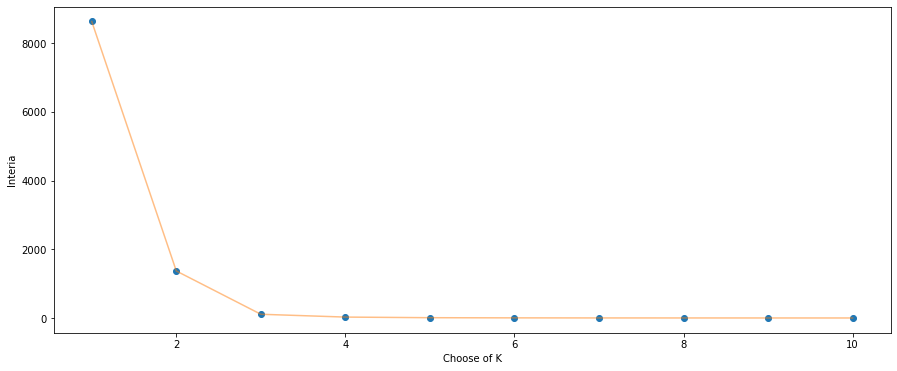

In [80]:
df_empty = pd.DataFrame(columns=['first','second','third','label'])
df_empty['first'] = X[:,0]
df_empty['second'] = X[:,1]
df_empty['third'] = X[:,2]
df_empty['label'] = labele
df1 = df_empty[['first','second','third']].iloc[:,:].values  
inertia = []   

for k in range(1,11):  
    algorithm = (KMeans(n_clusters=k,  
                       init="k-means++",  
                       n_init=10,  
                       max_iter=300,  
                       tol=0.0001,  
                       random_state=111,  
                       algorithm="full"))  
    algorithm.fit(df1)  
    inertia.append(algorithm.inertia_) 
plt.figure(1,figsize=(15,6))
plt.plot(np.arange(1,11), inertia, 'o')  
plt.plot(np.arange(1,11), inertia, '-', alpha=0.5)

plt.xlabel("Choose of K")
plt.ylabel("Interia")
plt.show()

In [75]:
df_empty[df_empty['label'] == 0]['first'].mean(),df_empty[df_empty['label'] == 0]['second'].mean(),df_empty[df_empty['label'] == 0]['third'].mean()

(9.165524534182623e-05, 0.00896358396857977, 0.9909712076187134)

In [76]:
df_empty[df_empty['label'] == 1]['first'].mean(),df_empty[df_empty['label'] == 1]['second'].mean(),df_empty[df_empty['label'] == 1]['third'].mean()

(0.990898072719574, 0.009074725210666656, 3.482540705590509e-05)

In [77]:
df_empty[df_empty['label'] == 2]['first'].mean(),df_empty[df_empty['label'] == 2]['second'].mean(),df_empty[df_empty['label'] == 2]['third'].mean()

(0.00579996919259429, 0.9644550681114197, 0.02974364534020424)

Starting compute t-SNE Embedding...


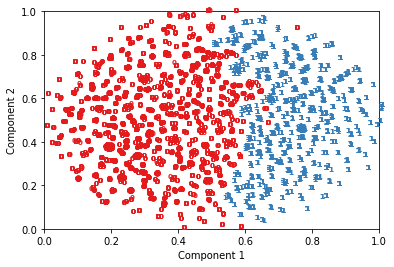

In [79]:
X = scores.detach().numpy()
from sklearn.cluster import KMeans
estimators = KMeans(n_clusters=2)
estimators.fit(X)
labele = estimators.labels_
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
data, label, n_samples, n_features,title = scores.detach().numpy(), labele, 17314, 3,'Cluster of users according to importances of contexts'
print('Starting compute t-SNE Embedding...')
ts = TSNE(n_components=2, init='pca', random_state=0)

reslut = ts.fit_transform(data)

x_min, x_max = np.min(reslut, 0), np.max(reslut, 0)
reslut = (reslut - x_min) / (x_max - x_min)

fig = plt.figure()
ax = plt.subplot(111)
for i in range(reslut.shape[0]):
    plt.text(reslut[i, 0], reslut[i, 1], str(label[i]), color=plt.cm.Set1(label[i]),
                 fontdict={'weight': 'bold', 'size': 7})
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.xticks()
plt.yticks()
#plt.title(title, fontsize=14)
#plt.savefig('/home/jinfeng/Downloads/doctorant/Conférences/recsys2022/jb.png')
plt.show()

In [81]:
df_empty['label'].value_counts()

0    10601
1     6713
Name: label, dtype: int64

In [83]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap

ModuleNotFoundError: No module named 'numba.experimental.structref'

In [78]:
ratings = pd.read_pickle('NETFLIX/movie_ratings_500_id.pkl')
films = pd.read_pickle('NETFLIX/movie_metadata.pkl')

In [79]:
row = []
for mid,haha in ratings.items():
    for info in haha:
        info['movie'] = mid
        row.append(info)
df_ratings = pd.DataFrame(row)

In [80]:
row = []
for mid,haha in films.items():
    haha['movie'] = mid
    row.append(haha)
df_movie = pd.DataFrame(row)

In [81]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_ratings[['user_id', 'movie', 'user_rating']], reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=0.2)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions),accuracy.mae(predictions)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

RMSE: 0.9537
MAE:  0.7538
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9568  0.9497  0.9587  0.9511  0.9569  0.9546  0.0035  
MAE (testset)     0.7562  0.7508  0.7573  0.7506  0.7552  0.7540  0.0028  
Fit time          9.93    9.72    10.06   10.97   9.94    10.12   0.44    
Test time         0.33    0.34    0.36    0.36    0.33    0.35    0.01    


{'test_rmse': array([0.95680126, 0.94970654, 0.95868429, 0.95110425, 0.95686326]),
 'test_mae': array([0.75623885, 0.75076684, 0.75725393, 0.75064085, 0.7552102 ]),
 'fit_time': (9.933877944946289,
  9.716795921325684,
  10.058424472808838,
  10.972285032272339,
  9.942571878433228),
 'test_time': (0.33469080924987793,
  0.3446078300476074,
  0.3580808639526367,
  0.36244916915893555,
  0.33349180221557617)}

In [82]:
def binary_predictions(true_ratings, predicted_ratings):
    assert len(true_ratings) == len(predicted_ratings)
    binary_true_ratings = []
    binary_predicted_ratings = []

    for i in range(len(true_ratings)):
        if true_ratings[i] >= 3:
            binary_true_ratings.append(1)
        else:
            binary_true_ratings.append(0)

        if predicted_ratings[i] >= 3:
            binary_predicted_ratings.append(1)
        else:
            binary_predicted_ratings.append(0)

    return precision_score(binary_true_ratings, binary_predicted_ratings), recall_score(binary_true_ratings, binary_predicted_ratings), f1_score(binary_true_ratings, binary_predicted_ratings)

In [10]:
a = df_movie['director'].value_counts()[df_movie['director'].value_counts() >= 2]
df_movie = df_movie[df_movie['director'].isin(list(a.index))]
df_movie.index = range(len(df_movie))

In [11]:
df_movie

,director,genre,actors,title,movie
0,Marc Forster,"[Biography, Drama, Family]","[Johnny Depp, Kate Winslet, Julie Christie, Du...",Finding Neverland,tt0308644
1,Kevin Smith,[Comedy],"[Jason Mewes, Kevin Smith, Ben Affleck, Ali La...",Jay and Silent Bob Strike Back,tt0261392
2,Jay Roach,"[Comedy, Romance]","[Ben Stiller, Robert De Niro, Blythe Danner, D...",Meet the Fockers,tt0290002
3,Steven Soderbergh,"[Biography, Drama]","[Julia Roberts, Albert Finney, David Brisbin]",Erin Brockovich,tt0195685
4,Jon Turteltaub,"[Action, Adventure, Family]","[Nicolas Cage, Diane Kruger, Justin Bartha, Se...",National Treasure,tt0368891
...,...,...,...,...,...
235,Roger Michell,"[Drama, Romance]","[Daniel Craig, Anna Wilson-Jones, Anne Reid, P...",The Mother,tt0323298
236,Sam Mendes,"[Drama, Romance]","[Kevin Spacey, Annette Bening, Thora Birch, We...",American Beauty,tt0169547
237,Robert Rodriguez,"[Action, Adventure, Comedy]","[Alexa PenaVega, Daryl Sabara, Antonio Banderas]",Spy Kids,tt0227538
238,Nora Ephron,"[Comedy, Fantasy, Romance]","[Nicole Kidman, Will Ferrell, Shirley MacLaine...",Bewitched,tt0374536


In [12]:
df_movie['director'].value_counts()

Steven Soderbergh    7
Joel Schumacher      6
Steven Spielberg     5
Ridley Scott         4
Woody Allen          4
                    ..
McG                  2
Boaz Yakin           2
Gary Fleder          2
George Lucas         2
Jon Turteltaub       2
Name: director, Length: 101, dtype: int64

In [13]:
final = pd.merge(df_movie,df_ratings,on='movie')

In [14]:
a = final['user_id'].value_counts()[final['user_id'].value_counts() >= 10]
final = final[final['user_id'].isin(list(a.index))]
final.index = range(len(final))

In [15]:
hehe = final.copy()
del hehe['title']
del hehe['user_rating_date']

In [16]:
hehe['user_id'].value_counts()

1174530    178
306466     168
1907667    167
1744889    165
1468812    160
          ... 
2122978     10
853484      10
2084468     10
1366126     10
868186      10
Name: user_id, Length: 2802, dtype: int64

In [17]:
# def aggregate_entity(x, scores):
#     val_base = x.index[0]
#     val_base = torch.LongTensor(val_base)
#     entities_base = b(val_base)
#     entities_base_final = scores[0] * entities_base
#     entities_base_final = entities_base_final.sum(0).unsqueeze(0)
#     for i in x.index[1:]:
#         val = x[i]
#         entity = torch.LongTensor(val)
#         entities = b(entity)
#         entities_f = scores[i] * entities
#         entities_f = entities_f.sum(0).unsqueeze(0)
#         entities_base_final = torch.cat((entities_base_final, entities_f))
#     return entities_base_final.shape

In [18]:
# def aggregate_entity(x, b, scores, users):
#     val_base = x.index[0]
#     val_base = torch.LongTensor(val_base)
#     entities_base = b(val_base)
#     entities_score = torch.mm(entities_base,users[0].unsqueeze(1))
#     entities_score = entities_score * scores[0]
#     entities_score = entities_score.sum(0)
#     for i in x.index[1:]:
#         val = x[i]
#         entity = torch.LongTensor(val)
#         entities = b(entity)
#         entities = torch.mm(entities,users[i].unsqueeze(1))
#         entities_f = entities * scores[i]
#         entities_f = entities_f.sum(0)
#         entities_score = torch.cat((entities_score, entities_f))
#     return entities_score.shape

In [19]:
# def calculate_score(x,users,aspects,scores):
#     val_base = x[0]
#     actor_base = torch.LongTensor(val_base)
#     actors_base = aspects(actor_base)  # 5 * 64
#     pre_rating = torch.mm(actors_base, users[0].unsqueeze(1))
#     pre_rating = pre_rating * scores[0] / pre_rating.shape[0]
#     pre_rating = pre_rating.sum(0)
#     for i in x.index[1:]:
#         val = x[i]
#         actor = torch.LongTensor(val)
#         actors = aspects(actor)
#         pre_ra = torch.mm(actors, users[i].unsqueeze(1))
#         actors_f = pre_ra * scores[i]
#         actors_f = actors_f.sum(0) / actors_f.shape[0]
#         pre_rating = torch.cat((pre_rating, actors_f))
#     return pre_rating

In [20]:
# calculate_score(hehe.iloc[:,2].loc[0:127],users,b,score1)

In [21]:

# user_index = hehe.iloc[:,0].loc[0:127]
# user_index = torch.LongTensor(user_index)
# users = b(user_index)
# val_base = hehe.iloc[:, 2].loc[0:127][0]
# actor_base = torch.LongTensor(val_base)
# actors_base = b(actor_base) # 5 * 64
# #actors_f_base = score3[0] * actors_base # 5 * 64
# pre_rating = torch.mm(actors_base, users[0].unsqueeze(1))
# pre_rating = pre_rating * score3[0]
# pre_rating = pre_rating.sum(0) / pre_rating.shape[0]
# for i in hehe.iloc[:, 2].loc[0:127].index[1:]:
#     val = hehe.iloc[:, 2][i]
#     actor = torch.LongTensor(val)
#     actors = b(actor)
#     pre_ra = torch.mm(actors, users[i].unsqueeze(1))
#     actors_f = pre_ra * score3[i]
#     actors_f = actors_f.sum(0) / actors_f.shape[0]
#     pre_rating = torch.cat((pre_rating,actors_f))
#     #print(pre_rating.shape)

# a = calculate_score(hehe.iloc[:,2].loc[0:127],users,b,score1)
# d = calculate_score(hehe.iloc[:,3].loc[0:127],users,b,score2)
# g = calculate_score(hehe.iloc[:,4].loc[0:127],users,b,score3)
# score_final = a + d + g

# importance_sum = score1 + score2 + score3
# importance_sum = importance_sum.squeeze(2).squeeze(1)
# final = score_final / importance_sum


In [22]:
movie = dict()
for i in range(df_movie.shape[0]):
    m = df_movie['movie'][i]
    movie.setdefault(m,dict())
    movie[m]['director'] = df_movie['director'][i]
    movie[m]['genre'] = df_movie['genre'][i]
    movie[m]['actors'] = df_movie['actors'][i]
    movie[m]['title'] = df_movie['title'][i]

In [23]:
def map_aspect_values_to_movies(x):
    (film, meta), aspect = x
    aspects = dict()
    if aspect == "director":
        aspects[meta[aspect]] = 1
    else:
        for g in meta[aspect]:
            aspects[g] = 1
    return film, meta, aspects


def dict_movie_aspect(paper_films, aspect):
    paper_films_aspect_prepended = map(
        lambda e: (e, aspect), list(paper_films.items()))
    aspect_dict = dict()
    with ProcessPoolExecutor(max_workers=THREADS) as executor:
        results = executor.map(map_aspect_values_to_movies,
                               paper_films_aspect_prepended)
    for film, meta, aspects in results:
        aspect_dict[film + "_" + meta["title"]] = aspects
    return aspect_dict

In [24]:
movie_genres = dict_movie_aspect(movie, "genre")
movie_directors = dict_movie_aspect(movie,'director')
movie_actors = dict_movie_aspect(movie,'actors')

In [25]:
actors = pd.DataFrame.from_dict(movie_actors,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index

In [26]:
directors = pd.DataFrame.from_dict(movie_directors,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index

In [27]:
genres = pd.DataFrame.from_dict(movie_genres,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index

In [28]:
actors_dict = dict(zip(actors, range(len(actors))))
directors_dict = dict(zip(directors, range(
    len(actors), len(actors) + len(directors))))
genres_dict = dict(zip(genres, range(
    len(actors) + len(directors), len(actors) + len(directors) + len(genres))))
# max(actors_dict.values()),max(directors_dict.values()),max(genres_dict.values())

In [29]:
min(actors_dict.values()),max(actors_dict.values())

(0, 507)

In [30]:
min(directors_dict.values()),max(directors_dict.values())

(508, 608)

In [31]:
min(genres_dict.values()),max(genres_dict.values())

(609, 626)

In [32]:
def change_director(x):
    return [itemgetter(x)(directors_dict)]


def change_actor(x):
    return change_list((itemgetter(*x)(actors_dict)))


def change_genre(x):
    qunima = itemgetter(*x)(genres_dict)
    if type(qunima) == int:
        return [qunima]
    else:
        return change_list(qunima)


def change_list(x):
    return list(x)

In [33]:
hehe['director'] = hehe['director'].map(change_director)
hehe['actors'] = hehe['actors'].map(change_actor)
hehe['genre'] = hehe['genre'].map(change_genre)

In [34]:
hehe = hehe[['user_id','movie','actors','director','genre','user_rating']]
hehe['user_rating'] = hehe['user_rating'].astype('float')

In [35]:
le = LabelEncoder()
y = le.fit_transform(hehe['user_id'])
hehe['user_id'] = y

y = le.fit_transform(hehe['movie'])
hehe['movie'] = y


In [36]:
# b = torch.nn.Embedding(40000,64)
# user = hehe.iloc[:, 0].loc[0:127].values
# haha = torch.LongTensor(user)
# users = b(haha)
# item = hehe.iloc[:, 1].loc[0:127].values
# haha = torch.LongTensor(item)
# items = b(haha)
# director = hehe.iloc[:, 3].loc[0:127].values
# haha = torch.LongTensor(director)
# directors = b(haha)


In [37]:
## For the output of the factorization machine, it should be added before the final addition

In [38]:
print("The number of aspects is {}".format(max(genres_dict.values()) + 1))
print("The number of users is {}".format(max(hehe['user_id'])+1))

The number of aspects is 627
The number of users is 2802


In [39]:
def calculate_score_res(x, users, aspects, scores):
    res = []
    for i in x.index:
        val = x[i]
        actor = torch.LongTensor(val)
        actors = aspects(actor)
        pre_ra = torch.mm(actors, users[i % 128].unsqueeze(1))
        actors_f = pre_ra * scores[i % 128] / pre_ra.shape[0]
        #actors_f = actors_f.sum(0)
        res.append(actors_f)
    return res

In [40]:
hehe

,user_id,movie,actors,director,genre,user_rating
0,261,192,"[0, 1, 2, 3, 4]",[508],"[609, 610, 611]",3.0
1,16,192,"[0, 1, 2, 3, 4]",[508],"[609, 610, 611]",5.0
2,677,192,"[0, 1, 2, 3, 4]",[508],"[609, 610, 611]",5.0
3,1208,192,"[0, 1, 2, 3, 4]",[508],"[609, 610, 611]",4.0
4,1305,192,"[0, 1, 2, 3, 4]",[508],"[609, 610, 611]",4.0
...,...,...,...,...,...,...
85606,1336,224,"[237, 264, 507]",[606],"[610, 617]",4.0
85607,670,224,"[237, 264, 507]",[606],"[610, 617]",1.0
85608,1650,224,"[237, 264, 507]",[606],"[610, 617]",5.0
85609,63,224,"[237, 264, 507]",[606],"[610, 617]",2.0


In [41]:
from tqdm import tqdm


def calculate_score(x, users, aspects, scores):
    first = x.index[0]
    val_base = x[first]
    actor_base = torch.LongTensor(val_base)
    actors_base = aspects(actor_base)  # 5 * 64
    actors_base = F.dropout(actors_base, p = rate, training = True )
    pre_rating = torch.mm(actors_base, users[first % 128].unsqueeze(1))
    pre_rating = pre_rating * scores[first % 128] / pre_rating.shape[0]
    pre_rating = pre_rating.sum(0)
    for i in x.index[1:]:
        val = x[i]
        actor = torch.LongTensor(val)
        actors = aspects(actor)
        pre_ra = torch.mm(actors, users[i % 128].unsqueeze(1))
        actors_f = pre_ra * scores[i % 128] / pre_ra.shape[0]
        actors_f = actors_f.sum(0)
        pre_rating = torch.cat((pre_rating, actors_f))
    return pre_rating


class aspect_augumentation(nn.Module):
    def __init__(self, n_users, n_entity, n_rk, n_factors):
        super(aspect_augumentation, self).__init__()
        self.n_users = n_users
        self.n_entity = n_entity
        self.n_rk = n_rk
        self.n_factors = n_factors
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.entity_factors = torch.nn.Embedding(n_entity, n_factors)
        self.relation_k = torch.nn.Embedding(n_factors, n_rk)
        #self.item_factors = torch.nn.Embedding(n_items, n_factors)

    def forward(self, user_id, actors_id, directors_id, genres_id):
        '''
        user_factors: n_users * 64
        entity_factors: n_entity * 64
        relation_k: 64 * 3
        '''
        users = self.user_factors(user_id)  # 128 * 64
        aspects = self.entity_factors  # n_entity * 64
        users = F.dropout(users, p=rate,training=self.training)
        
        
        scores = torch.matmul(users, F.dropout(self.relation_k.weight,p = rate,training = self.training))  # 128 * 3
        m = torch.nn.Softmax(dim=1)  # 128 * 3
        scores = m(scores)  # 128 * 3

        '''
        Compute the importance of each aspects
        '''
        scores_actors = scores[:, 0].unsqueeze(1).unsqueeze(2)
        scores_directors = scores[:, 1].unsqueeze(1).unsqueeze(2)
        scores_genres = scores[:, 2].unsqueeze(1).unsqueeze(2)

        '''
        Compute the contribution of each aspects
        '''
        contribute_actors = calculate_score(
            actors_id, users, aspects, scores_actors)
        contribute_directors = calculate_score(
            directors_id, users, aspects, scores_directors)
        contribute_genres = calculate_score(
            genres_id, users, aspects, scores_genres)

        '''
        Compute the final predictions
        '''
        importance_sum = scores_actors + scores_directors + scores_genres
        importance_sum = importance_sum.squeeze(2).squeeze(1)
        prediction_sum = contribute_actors * scores_actors.squeeze(2).squeeze(1)  + contribute_directors * scores_directors.squeeze(2).squeeze(1) + contribute_genres * scores_genres.squeeze(2).squeeze(1)
        prediction = prediction_sum / importance_sum

        return prediction,scores,contribute_actors,contribute_directors,contribute_genres

In [70]:
model = aspect_augumentation(2802,627,3,64)
rate = 0.3

In [71]:
# user = hehe.iloc[:, 0].values
# users = torch.LongTensor(user)
# actors_id = hehe.iloc[:,2]
# directors_id = hehe.iloc[:,3]
# genres_id = hehe.iloc[:,4]
# model(users,actors_id,directors_id,genres_id).shape

In [72]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, threshold=0.05, threshold_mode='abs')

In [73]:
def RMSE(hehe, model):
    users_index = hehe.iloc[:, 0].values
    users = torch.LongTensor(users_index)
    actors_id = hehe.iloc[:, 2]
    directors_id = hehe.iloc[:, 3]
    genres_id = hehe.iloc[:, 4]
    rating = torch.FloatTensor(
        hehe.iloc[:, 5].values)
    prediction,scores,contribute_actors,contribute_directors,contribute_genres = model(users, actors_id, directors_id, genres_id)
    rmse = loss_func(prediction, rating)
    return rmse ** 0.5

In [74]:
train = hehe.sample(frac=0.7, random_state=0, axis=0)
train.index = range(len(train))
test = hehe[~hehe.index.isin(train.index)]
test.index = range(len(test))

In [75]:
# from surprise import SVD
# from surprise import Dataset
# from surprise import accuracy
# from surprise.model_selection import train_test_split
# from surprise import Reader
# from surprise.model_selection import cross_validate

# reader = Reader(rating_scale=(1, 5))
# data = Dataset.load_from_df(hehe[['user_id', 'movie', 'user_rating']], reader)

# # sample random trainset and testset
# # test set is made of 25% of the ratings.
# trainset, testset = train_test_split(data, test_size=0.2)

# # We'll use the famous SVD algorithm.
# algo = SVD()

# # Train the algorithm on the trainset, and predict ratings for the testset
# algo.fit(trainset)
# predictions = algo.test(testset)

# # Then compute RMSE
# accuracy.rmse(predictions),accuracy.mae(predictions)
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [76]:
#model = aspect_augumentation(2802,627,3,64)
batch_size = 512
reg = 5 * 10e-7
for epoch in range(100):
    model.train()
    
    import time
    t1 = time.time()
    num_example = len(train)
    indices = list(range(num_example))
    for i in tqdm(range(0, num_example, batch_size)):
        optimizer.zero_grad()
        indexs = indices[i:min(i+batch_size, num_example)]
        users_index = train.iloc[:, 0].loc[indexs].values
        users = torch.LongTensor(users_index)
        actors_id = train.iloc[:, 2].loc[indexs]
        directors_id = train.iloc[:, 3].loc[indexs]
        genres_id = train.iloc[:, 4].loc[indexs]
        rating = torch.FloatTensor(
            hehe.iloc[:, 5].loc[indexs].values)

        prediction,scores,contribute_actors,contribute_directors,contribute_genres = model(users, actors_id, directors_id, genres_id)
        err = loss_func(prediction, rating) + reg * ((model.user_factors.weight*model.user_factors.weight).sum() +
                                                      (model.entity_factors.weight*model.entity_factors.weight).sum() +
                                                      (model.relation_k.weight*model.relation_k.weight).sum())
        err.backward()
        optimizer.step()
        
    t2 = time.time()
    rmse = RMSE(test, model)
    scheduler.step(rmse)
    print("Epoch: ", epoch, " Loss: ", err, " RMSE in training set:",
          rmse, "Time consumed is:", t2-t1)

100%|██████████| 118/118 [00:45<00:00,  2.62it/s]


Epoch:  0  Loss:  tensor(11.4860, grad_fn=<AddBackward0>)  RMSE in training set: tensor(4.2211, grad_fn=<PowBackward0>) Time consumed is: 45.0720739364624


100%|██████████| 118/118 [00:48<00:00,  2.43it/s]


Epoch:  1  Loss:  tensor(12.9099, grad_fn=<AddBackward0>)  RMSE in training set: tensor(3.7291, grad_fn=<PowBackward0>) Time consumed is: 48.539297342300415


100%|██████████| 118/118 [00:46<00:00,  2.53it/s]


Epoch:  2  Loss:  tensor(9.7568, grad_fn=<AddBackward0>)  RMSE in training set: tensor(3.4495, grad_fn=<PowBackward0>) Time consumed is: 46.710288524627686


100%|██████████| 118/118 [00:46<00:00,  2.53it/s]


Epoch:  3  Loss:  tensor(8.2992, grad_fn=<AddBackward0>)  RMSE in training set: tensor(3.2222, grad_fn=<PowBackward0>) Time consumed is: 46.69277548789978


100%|██████████| 118/118 [00:46<00:00,  2.56it/s]


Epoch:  4  Loss:  tensor(2.7553, grad_fn=<AddBackward0>)  RMSE in training set: tensor(3.1055, grad_fn=<PowBackward0>) Time consumed is: 46.12769603729248


100%|██████████| 118/118 [00:45<00:00,  2.60it/s]


Epoch:  5  Loss:  tensor(6.4669, grad_fn=<AddBackward0>)  RMSE in training set: tensor(3.0307, grad_fn=<PowBackward0>) Time consumed is: 45.408830642700195


100%|██████████| 118/118 [00:45<00:00,  2.57it/s]


Epoch:  6  Loss:  tensor(2.9873, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.9017, grad_fn=<PowBackward0>) Time consumed is: 45.89714574813843


100%|██████████| 118/118 [00:45<00:00,  2.57it/s]


Epoch:  7  Loss:  tensor(2.8418, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.8599, grad_fn=<PowBackward0>) Time consumed is: 45.8764328956604


100%|██████████| 118/118 [00:45<00:00,  2.62it/s]


Epoch:  8  Loss:  tensor(4.8110, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.7588, grad_fn=<PowBackward0>) Time consumed is: 45.13276553153992


100%|██████████| 118/118 [00:45<00:00,  2.58it/s]


Epoch:  9  Loss:  tensor(5.3677, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.7416, grad_fn=<PowBackward0>) Time consumed is: 45.72103214263916


100%|██████████| 118/118 [00:45<00:00,  2.61it/s]


Epoch:  10  Loss:  tensor(3.6966, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.6820, grad_fn=<PowBackward0>) Time consumed is: 45.18866014480591


100%|██████████| 118/118 [00:45<00:00,  2.58it/s]


Epoch:  11  Loss:  tensor(4.8388, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.6431, grad_fn=<PowBackward0>) Time consumed is: 45.6975519657135


100%|██████████| 118/118 [00:45<00:00,  2.60it/s]


Epoch:  12  Loss:  tensor(2.4238, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.5665, grad_fn=<PowBackward0>) Time consumed is: 45.325947999954224


100%|██████████| 118/118 [00:46<00:00,  2.55it/s]


Epoch:  13  Loss:  tensor(1.8460, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.5274, grad_fn=<PowBackward0>) Time consumed is: 46.36401605606079


100%|██████████| 118/118 [00:45<00:00,  2.59it/s]


Epoch:  14  Loss:  tensor(2.5125, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.4803, grad_fn=<PowBackward0>) Time consumed is: 45.61905908584595


100%|██████████| 118/118 [00:45<00:00,  2.58it/s]


Epoch:  15  Loss:  tensor(2.8236, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.4290, grad_fn=<PowBackward0>) Time consumed is: 45.67918682098389


100%|██████████| 118/118 [00:46<00:00,  2.53it/s]


Epoch:  16  Loss:  tensor(2.1176, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.4276, grad_fn=<PowBackward0>) Time consumed is: 46.73261618614197


100%|██████████| 118/118 [00:45<00:00,  2.58it/s]


Epoch:  17  Loss:  tensor(2.0973, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.3454, grad_fn=<PowBackward0>) Time consumed is: 45.68687891960144


100%|██████████| 118/118 [00:45<00:00,  2.62it/s]


Epoch:  18  Loss:  tensor(1.6909, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.3581, grad_fn=<PowBackward0>) Time consumed is: 45.0583291053772


100%|██████████| 118/118 [00:46<00:00,  2.55it/s]


Epoch:  19  Loss:  tensor(1.6996, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.2958, grad_fn=<PowBackward0>) Time consumed is: 46.272217988967896


100%|██████████| 118/118 [00:46<00:00,  2.55it/s]


Epoch:  20  Loss:  tensor(3.3611, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.2677, grad_fn=<PowBackward0>) Time consumed is: 46.2569043636322


100%|██████████| 118/118 [00:45<00:00,  2.58it/s]


Epoch:  21  Loss:  tensor(1.7296, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.2524, grad_fn=<PowBackward0>) Time consumed is: 45.76211762428284


100%|██████████| 118/118 [00:45<00:00,  2.60it/s]


Epoch:  22  Loss:  tensor(2.0493, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.2707, grad_fn=<PowBackward0>) Time consumed is: 45.41462469100952


100%|██████████| 118/118 [00:45<00:00,  2.57it/s]


Epoch:  23  Loss:  tensor(1.7255, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.2045, grad_fn=<PowBackward0>) Time consumed is: 45.96328258514404


100%|██████████| 118/118 [00:46<00:00,  2.56it/s]


Epoch:  24  Loss:  tensor(1.3951, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.2417, grad_fn=<PowBackward0>) Time consumed is: 46.07822132110596


100%|██████████| 118/118 [00:45<00:00,  2.61it/s]


Epoch:  25  Loss:  tensor(2.5621, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.2063, grad_fn=<PowBackward0>) Time consumed is: 45.23206448554993


100%|██████████| 118/118 [00:45<00:00,  2.61it/s]


Epoch:  26  Loss:  tensor(2.0527, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.1918, grad_fn=<PowBackward0>) Time consumed is: 45.29937410354614


100%|██████████| 118/118 [00:46<00:00,  2.55it/s]


Epoch:  27  Loss:  tensor(1.4751, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.1692, grad_fn=<PowBackward0>) Time consumed is: 46.21191763877869


100%|██████████| 118/118 [00:45<00:00,  2.58it/s]


Epoch:  28  Loss:  tensor(1.2700, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.1827, grad_fn=<PowBackward0>) Time consumed is: 45.69017219543457


100%|██████████| 118/118 [00:45<00:00,  2.60it/s]


Epoch:  29  Loss:  tensor(1.7438, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.1571, grad_fn=<PowBackward0>) Time consumed is: 45.382490396499634


100%|██████████| 118/118 [00:45<00:00,  2.61it/s]


Epoch:  30  Loss:  tensor(1.4844, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.1312, grad_fn=<PowBackward0>) Time consumed is: 45.30962562561035


100%|██████████| 118/118 [00:45<00:00,  2.58it/s]


Epoch:  31  Loss:  tensor(1.3219, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.1267, grad_fn=<PowBackward0>) Time consumed is: 45.75318789482117


100%|██████████| 118/118 [00:45<00:00,  2.62it/s]


Epoch:  32  Loss:  tensor(1.4205, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.1478, grad_fn=<PowBackward0>) Time consumed is: 45.09548234939575


100%|██████████| 118/118 [00:46<00:00,  2.54it/s]


Epoch:  33  Loss:  tensor(1.5975, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.1215, grad_fn=<PowBackward0>) Time consumed is: 46.51016116142273


100%|██████████| 118/118 [00:47<00:00,  2.51it/s]


Epoch:  34  Loss:  tensor(1.1559, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.1082, grad_fn=<PowBackward0>) Time consumed is: 47.11141490936279


100%|██████████| 118/118 [00:48<00:00,  2.44it/s]


Epoch:  35  Loss:  tensor(1.0802, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.0892, grad_fn=<PowBackward0>) Time consumed is: 48.3589186668396


100%|██████████| 118/118 [00:45<00:00,  2.58it/s]


Epoch:  36  Loss:  tensor(0.9690, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.1162, grad_fn=<PowBackward0>) Time consumed is: 45.675843715667725


100%|██████████| 118/118 [00:48<00:00,  2.44it/s]


Epoch:  37  Loss:  tensor(1.3543, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.0868, grad_fn=<PowBackward0>) Time consumed is: 48.46700644493103


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


Epoch:  38  Loss:  tensor(1.2579, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.1019, grad_fn=<PowBackward0>) Time consumed is: 49.77885460853577


100%|██████████| 118/118 [00:46<00:00,  2.56it/s]


Epoch:  39  Loss:  tensor(1.1839, grad_fn=<AddBackward0>)  RMSE in training set: tensor(2.0966, grad_fn=<PowBackward0>) Time consumed is: 46.1875855922699


 82%|████████▏ | 97/118 [00:45<00:09,  2.13it/s]


KeyboardInterrupt: 

In [ ]:
def xiba(hehe):
    users_index = hehe.iloc[:, 0].values
    users = torch.LongTensor(users_index)
    actors_id = hehe.iloc[:, 2]
    directors_id = hehe.iloc[:, 3]
    genres_id = hehe.iloc[:, 4]
    rating = torch.FloatTensor(
        hehe.iloc[:, 5].values)
    prediction,scores,contribute_actors,contribute_directors,contribute_genres = model(users, actors_id, directors_id, genres_id)
    return prediction,scores,contribute_actors,contribute_directors,contribute_genres

In [ ]:
prediction,scores,contribute_actors,contribute_directors,contribute_genres = xiba(test)

In [ ]:
rating = torch.FloatTensor(
        test.iloc[:, 5].values)

In [ ]:
contribute_actors

In [ ]:
contribute_directors

In [ ]:
contribute_genres

In [51]:
prediction

tensor([ 3.1272e+00,  2.3309e+00,  2.0140e+00,  ...,  3.0299e+00,
        -2.0955e-05,  2.7817e+00], grad_fn=<DivBackward0>)

In [52]:
rating

tensor([5., 1., 4.,  ..., 5., 2., 5.])

In [53]:
scores

tensor([[9.9988e-01, 5.3696e-05, 6.3557e-05],
        [9.9999e-01, 1.6811e-06, 5.3176e-06],
        [1.0000e+00, 9.7140e-07, 2.5493e-06],
        ...,
        [9.9996e-01, 1.2966e-05, 2.4807e-05],
        [9.9997e-01, 6.7867e-06, 2.5935e-05],
        [9.9999e-01, 3.4182e-06, 1.5629e-06]], grad_fn=<SoftmaxBackward0>)

In [54]:
calculate_score_res

<function __main__.calculate_score_res(x, users, aspects, scores)>

In [55]:
users_index = test.iloc[:, 0].values
users_ten = torch.LongTensor(users_index)
users = model.user_factors(users_ten)
actors_id = test.iloc[:, 2]
directors_id = test.iloc[:, 3]
genres_id = test.iloc[:, 4]
aspects = model.entity_factors

In [56]:
scores = torch.matmul(users, model.relation_k.weight)  # 128 * 3
m = torch.nn.Softmax(dim=1)  # 128 * 3
scores = m(scores)

In [57]:
def calculate_score_res(x, users, aspects, scores):
    res = []
    for i in x.index:
        val = x[i]
        actor = torch.LongTensor(val)
        actors = aspects(actor)
        pre_ra = torch.mm(actors, users[i % 128].unsqueeze(1))
        actors_f = pre_ra * scores[i % 128] / pre_ra.shape[0]
        #actors_f = actors_f.sum(0)
        res.append(actors_f)
    return res

In [58]:
calculate_score_res(actors_id,users,aspects,scores)

[tensor([[8.1548e-01, 4.3793e-05, 5.1835e-05],
         [4.1142e-01, 2.2094e-05, 2.6152e-05],
         [5.4273e-01, 2.9146e-05, 3.4498e-05],
         [2.1107e-01, 1.1335e-05, 1.3417e-05],
         [3.6166e-01, 1.9422e-05, 2.2989e-05],
         [2.1395e-01, 1.1490e-05, 1.3600e-05],
         [5.7124e-01, 3.0677e-05, 3.6311e-05]], grad_fn=<DivBackward0>),
 tensor([[7.5009e-01, 1.2610e-06, 3.9887e-06],
         [3.5797e-01, 6.0180e-07, 1.9036e-06],
         [3.1562e-01, 5.3061e-07, 1.6784e-06],
         [1.8369e-01, 3.0881e-07, 9.7681e-07],
         [3.8477e-01, 6.4685e-07, 2.0461e-06],
         [1.1170e-01, 1.8778e-07, 5.9398e-07],
         [2.2710e-01, 3.8178e-07, 1.2076e-06]], grad_fn=<DivBackward0>),
 tensor([[4.5113e-01, 4.3824e-07, 1.1501e-06],
         [2.7391e-01, 2.6608e-07, 6.9827e-07],
         [3.7654e-01, 3.6577e-07, 9.5990e-07],
         [7.6079e-02, 7.3904e-08, 1.9395e-07],
         [2.7861e-01, 2.7064e-07, 7.1026e-07],
         [1.1317e-01, 1.0993e-07, 2.8850e-07],
        

In [59]:
a = [3,4,1,2,8,7,10]
a.pop(0)

3

In [60]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
def binary_predictions(true_ratings, predicted_ratings):
    assert len(true_ratings) == len(predicted_ratings)
    binary_true_ratings = []
    binary_predicted_ratings = []

    # make 3 a positive
    for i in range(len(true_ratings)):
        if true_ratings[i] >= 3:
            binary_true_ratings.append(1)
        else:
            binary_true_ratings.append(0)

        if predicted_ratings[i] >= 3:
            binary_predicted_ratings.append(1)
        else:
            binary_predicted_ratings.append(0)

    return precision_score(binary_true_ratings, binary_predicted_ratings), recall_score(binary_true_ratings, binary_predicted_ratings), f1_score(binary_true_ratings, binary_predicted_ratings)

In [61]:
def arg_accuracy_int(ratings, predictions):
    ratings = ratings.detach().numpy()
    predictions = predictions.detach().numpy()
    total_nr = len(ratings)
    total_pred = 0
    for i in range(total_nr):
        (true_rating, pred_rating) = ratings[i], predictions[i]
        if round(pred_rating) >= int(true_rating)-1 and round(pred_rating) <= int(true_rating)+1:
            total_pred += 1

    return float(total_pred)/total_nr


def round_of_rating(number):
    return round(number * 2) / 2

In [62]:
rating

tensor([5., 1., 4.,  ..., 5., 2., 5.])

In [63]:
binary_predictions(rating,prediction)

(0.8100209863588668, 0.5577874923226995, 0.6606474250625816)

In [64]:
arg_accuracy_int(rating,prediction)

0.700210255811237

In [65]:
hehe[hehe['user_rating'] == 3.0].shape,hehe.shape

((27949, 6), (85611, 6))

In [1]:
import torch

In [2]:
a = torch.nn.Embedding(128,64).weight

In [4]:
hehe = a.sum(1)
hehe.shape

torch.Size([128])